# Analyse Comparative des Réseaux de Neurones Graphiques pour la Segmentation Sémantique d'Images Hyperspectrales : Évaluation des Performances GCN vs GAT vs GraphSAGE"

**Ce notebook présente une étude comparative exhaustive de trois architectures de réseaux de neurones graphiques (GNN) pour la classification d'images hyperspectrales : Graph Convolutional Networks (GCN), Graph Attention Networks (GAT), et GraphSAGE. L'analyse évalue systématiquement les performances de ces architectures avec différentes profondeurs (1, 2, et 3 couches) et diverses configurations d'entraînement (5%, 10%, 30%, 50% des données), en utilisant la sélection optimale de bandes spectrales identifiée dans les études précédentes. Le notebook intègre un système de consolidation automatisé qui agrège les résultats de toutes les expériences dans un tableau unifié, permettant une comparaison directe des métriques F1-score et accuracy entre les différentes architectures. Cette approche comparative révèle les forces et faiblesses relatives de chaque type de GNN pour la classification hyperspectrale, fournissant des insights cruciaux sur le choix optimal d'architecture en fonction de la taille des données d'entraînement et de la complexité du modèle requis**

In [1]:
!pip install torch torch-geometric
!pip install networkx matplotlib scipy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlin

### Génération de Graphes Multi-Bandes pour la Segmentation Sémantique d'Images Hyperspectrales : Préparation des Données Indian Pines

Chargement des données Indian Pines...
Clés disponibles dans le fichier corrected: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
Clés disponibles dans le fichier gt: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])
Forme de l'image: (145, 145, 200)
Forme des étiquettes: (145, 145)


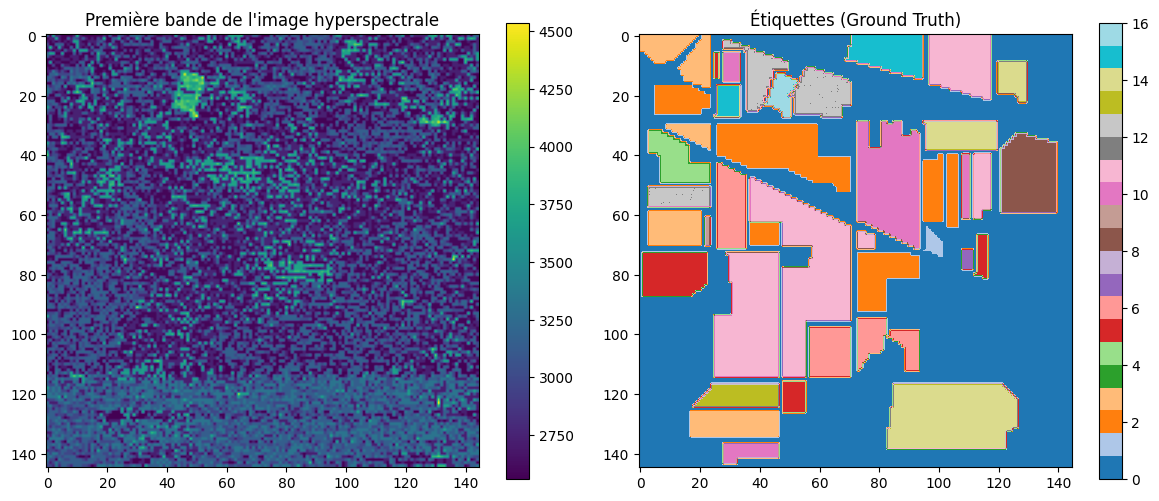


Création du graphe avec Top 5 bandes...
Bandes utilisées: [1, 19, 25, 32, 40]
Forme originale de l'image: (145, 145, 200)
Forme ajustée de l'image: (145, 145, 200)
Utilisation de 5 bandes sélectionnées
Nombre de nœuds: 21025
Nombre d'arêtes: 83520
Dimension des features: torch.Size([21025, 5])


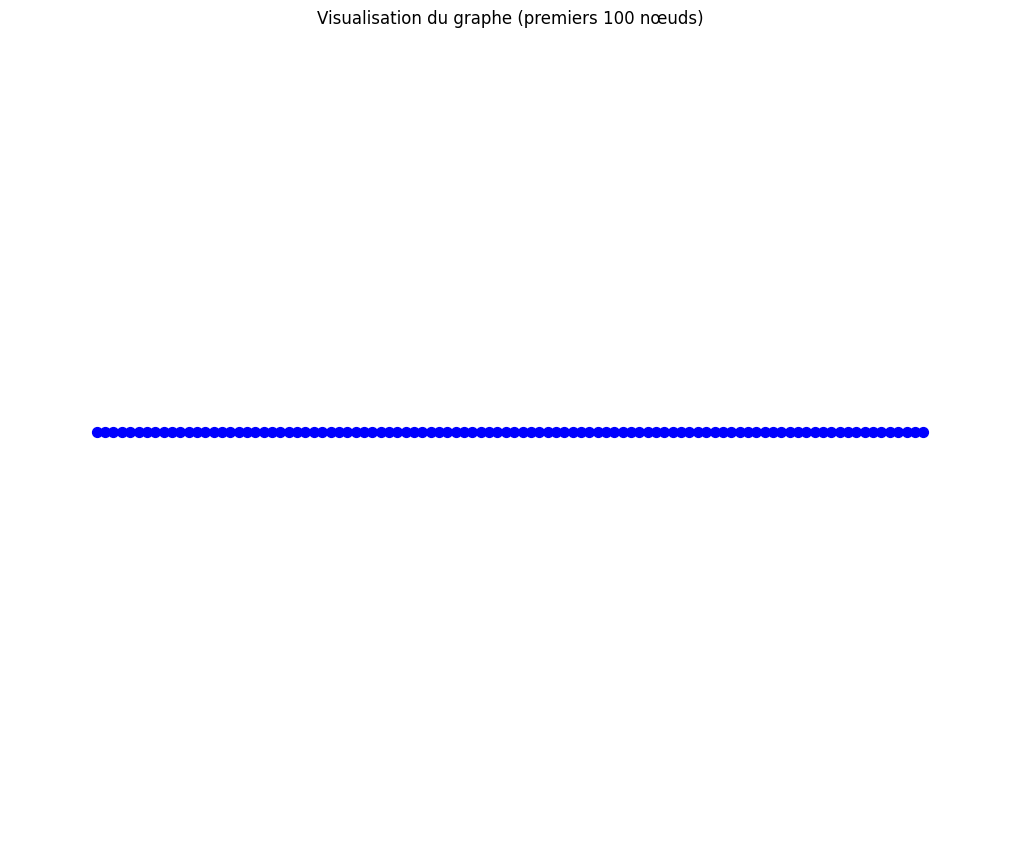

Graphe enregistré dans /kaggle/working/indian_pines_graph_d1_4connectivity_5bands.pt

=== Statistiques du graphe ===
Nombre de classes uniques: 17
Forme finale du tenseur de features: torch.Size([21025, 5])
Forme finale du tenseur d'arêtes: torch.Size([2, 83520])
Forme finale du tenseur de labels: torch.Size([21025])

Création du graphe avec Top 10 bandes...
Bandes utilisées: [1, 19, 25, 32, 40, 51, 64, 73, 81, 98]
Forme originale de l'image: (145, 145, 200)
Forme ajustée de l'image: (145, 145, 200)
Utilisation de 10 bandes sélectionnées
Nombre de nœuds: 21025
Nombre d'arêtes: 83520
Dimension des features: torch.Size([21025, 10])
Graphe enregistré dans /kaggle/working/indian_pines_graph_d1_4connectivity_10bands.pt

=== Statistiques du graphe ===
Nombre de classes uniques: 17
Forme finale du tenseur de features: torch.Size([21025, 10])
Forme finale du tenseur d'arêtes: torch.Size([2, 83520])
Forme finale du tenseur de labels: torch.Size([21025])

Création du graphe avec Top 20 bandes...

In [2]:
# Import des bibliothèques nécessaires
import numpy as np
import torch
import scipy.io as sio
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler
import os

# Définir une seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Définir le chemin du dataset
dataset_path = "/kaggle/input/gcn-gat-graphsage"  
output_path = "/kaggle/working/"  # Chemin pour sauvegarder le graphe généré

# Charger les données Indian Pines
def load_indian_pines():
    # Chargement de l'image hyperspectrale corrigée
    data = sio.loadmat(os.path.join(dataset_path, 'Indian_pines_corrected.mat'))
    # Vérifier les clés pour identifier le nom correct de la variable dans le fichier
    print("Clés disponibles dans le fichier corrected:", data.keys())
    # Généralement, c'est 'indian_pines_corrected' ou simplement 'X'
    # Nous allons supposer 'indian_pines_corrected', ajustez selon le contenu réel
    image = data['indian_pines_corrected']
    
    # Chargement des étiquettes (ground truth)
    gt_data = sio.loadmat(os.path.join(dataset_path, 'Indian_pines_gt.mat'))
    # Vérifier les clés également ici
    print("Clés disponibles dans le fichier gt:", gt_data.keys())
    # Généralement, c'est 'indian_pines_gt' ou simplement 'Y'
    gt = gt_data['indian_pines_gt']
    
    return image, gt

# Fonction pour créer un graphe à partir de l'image hyperspectrale
def create_hyperspectral_graph(image, labels, selected_bands=None, dilation=1, connectivity_type='4-connectivity'):
    """
    Crée un graphe à partir d'une image hyperspectrale.
    
    Args:
        image: Image hyperspectrale de forme (height, width, bands)
        labels: Étiquettes de classe pour chaque pixel
        selected_bands: Indices des bandes spectrales à utiliser (si None, toutes les bandes sont utilisées)
        dilation: Rayon de voisinage pour la connectivité
        connectivity_type: Type de connectivité ('4-connectivity' ou '8-connectivity')
        
    Returns:
        data: Objet Data de PyTorch Geometric
    """
    # Vérification de la forme de l'image
    print("Forme originale de l'image:", image.shape)
    # Les données Indian Pines sont souvent organisées différemment (bands, height, width)
    # Nous devons nous assurer que la forme est (height, width, bands)
    if image.shape[0] > image.shape[1] and image.shape[0] > image.shape[2]:
        # Si c'est (bands, height, width)
        image = np.transpose(image, (1, 2, 0))
    elif image.shape[2] < image.shape[0] and image.shape[2] < image.shape[1]:
    # Si c'est (height, width, bands) - c'est déjà correct
        pass
    
    print("Forme ajustée de l'image:", image.shape)
    height, width, num_bands = image.shape
    num_pixels = height * width
    
    # Sélection des bandes
    if selected_bands is not None:
        features = image[:, :, selected_bands]
        print(f"Utilisation de {len(selected_bands)} bandes sélectionnées")
    else:
        features = image
        print(f"Utilisation de toutes les {num_bands} bandes")
    
    # Reshape pour avoir une liste de pixels
    X = features.reshape(num_pixels, -1)
    
    # Normalisation des caractéristiques
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Conversion en tensor PyTorch
    x = torch.FloatTensor(X)
    
    # Création des arêtes selon le type de connectivité
    edge_list = []
    # Définir le pattern de connectivité
    if connectivity_type == '4-connectivity':
        # Connectivité-4: haut, bas, gauche, droite
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    else:  # 8-connectivity
        # Connectivité-8: ajout des diagonales
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0), 
                     (1, 1), (1, -1), (-1, 1), (-1, -1)]
    
    # Créer les arêtes en appliquant la dilation
    for i in range(height):
        for j in range(width):
            pixel_idx = i * width + j
            # Appliquer la dilation
            for di, dj in directions:
                for d in range(1, dilation + 1):
                    ni, nj = i + di * d, j + dj * d
                    # Vérifier que le voisin est dans les limites de l'image
                    if 0 <= ni < height and 0 <= nj < width:
                        neighbor_idx = ni * width + nj
                        edge_list.append((pixel_idx, neighbor_idx))
    
    # Conversion en tensor pour PyTorch Geometric
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    # Conversion des étiquettes
    y = torch.tensor(labels.reshape(-1), dtype=torch.long)
    
    # Création de l'objet Data
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Ajout d'informations supplémentaires pour faciliter l'analyse
    data.num_nodes = num_pixels
    data.height = height
    data.width = width
    
    return data

# Fonction pour visualiser le graphe (un sous-ensemble pour la clarté)
def visualize_graph(data, height, width, max_nodes=100):
    """
    Visualise un sous-ensemble du graphe pour vérification.
    """
    # Créer un graphe NetworkX à partir des données
    G = nx.Graph()
    
    # Ajouter les nœuds
    for i in range(min(max_nodes, data.num_nodes)):
        G.add_node(i)
    
    # Ajouter les arêtes (seulement celles entre les nœuds sélectionnés)
    edge_index = data.edge_index.numpy()
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[0, i], edge_index[1, i]
        if src < max_nodes and dst < max_nodes:
            G.add_edge(src, dst)
    
    # Créer un dictionnaire de positions pour la visualisation
    pos = {}
    for i in range(min(max_nodes, height * width)):
        row, col = i // width, i % width
        pos[i] = (col, -row)  # Inverser les y pour que l'origine soit en haut à gauche
    
    # Visualiser le graphe
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_size=50, node_color='blue', with_labels=False)
    plt.title(f"Visualisation du graphe (premiers {max_nodes} nœuds)")
    plt.show()

# Visualiser l'image et les étiquettes
def visualize_data(image, labels):
    """
    Visualise l'image hyperspectrale et les étiquettes.
    """
    # Afficher une bande de l'image
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image[:, :, 0], cmap='viridis')
    plt.title("Première bande de l'image hyperspectrale")
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(labels, cmap='tab20')
    plt.title("Étiquettes (Ground Truth)")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# Fonction principale pour créer 4 graphes avec différents nombres de bandes
def main():
    # Installation des packages nécessaires si non disponibles
    try:
        import torch_geometric
    except ImportError:
        print("Installation de PyTorch Geometric...")
        !pip install torch-geometric
    
    # Vérification des fichiers
    corrected_file = os.path.join(dataset_path, 'Indian_pines_corrected.mat')
    gt_file = os.path.join(dataset_path, 'Indian_pines_gt.mat')
    
    if not os.path.exists(corrected_file):
        print(f"Attention: Le fichier {corrected_file} n'existe pas. Vérifiez le chemin du dataset.")
    if not os.path.exists(gt_file):
        print(f"Attention: Le fichier {gt_file} n'existe pas. Vérifiez le chemin du dataset.")
    
    # Chargement des données
    print("Chargement des données Indian Pines...")
    image, gt = load_indian_pines()
    
    print(f"Forme de l'image: {image.shape}")
    print(f"Forme des étiquettes: {gt.shape}")
    
    # Liste des 20 meilleures bandes selon le coefficient de déflexion
    selected_bands = [
        1,    # Segment 1 (bandes 0-9)
        19,   # Segment 2 (bandes 10-19)
        25,   # Segment 3 (bandes 20-29)
        32,   # Segment 4 (bandes 30-39)
        40,   # Segment 5 (bandes 40-49)
        51,   # Segment 6 (bandes 50-59)
        64,   # Segment 7 (bandes 60-69)
        73,   # Segment 8 (bandes 70-79)
        81,   # Segment 9 (bandes 80-89)
        98,   # Segment 10 (bandes 90-99)
        101,  # Segment 11 (bandes 100-109)
        111,  # Segment 12 (bandes 110-119)
        120,  # Segment 13 (bandes 120-129)
        137,  # Segment 14 (bandes 130-139)
        149,  # Segment 15 (bandes 140-149)
        157,  # Segment 16 (bandes 150-159)
        160,  # Segment 17 (bandes 160-169)
        176,  # Segment 18 (bandes 170-179)
        186,  # Segment 19 (bandes 180-189)
        194   # Segment 20 (bandes 190-199)
    ]
    
    # Visualiser les données
    visualize_data(image, gt)
    
    # Définir les configurations de bandes à tester
    band_configs = [
        {'bands': selected_bands[:5], 'name': '5bands', 'description': 'Top 5 bandes'},
        {'bands': selected_bands[:10], 'name': '10bands', 'description': 'Top 10 bandes'},
        {'bands': selected_bands[:20], 'name': '20bands', 'description': 'Top 20 bandes'},
        {'bands': None, 'name': 'allbands', 'description': 'Toutes les bandes'}
    ]
    
    # Créer les graphes avec différents nombres de bandes
    for config in band_configs:
        print(f"\n{'='*60}")
        print(f"Création du graphe avec {config['description']}...")
        print(f"Bandes utilisées: {config['bands'] if config['bands'] is not None else 'Toutes'}")
        
        # Créer le graphe avec dilation=1 et connectivité-4
        data = create_hyperspectral_graph(
            image, 
            gt, 
            selected_bands=config['bands'],
            dilation=1, 
            connectivity_type='4-connectivity'
        )
        
        print(f"Nombre de nœuds: {data.num_nodes}")
        print(f"Nombre d'arêtes: {data.edge_index.shape[1]}")
        print(f"Dimension des features: {data.x.shape}")
        
        # Visualiser un sous-ensemble du graphe (seulement pour le premier)
        if config['name'] == '5bands':
            visualize_graph(data, image.shape[0], image.shape[1])
        
        # Enregistrer le graphe
        output_file = os.path.join(output_path, f"indian_pines_graph_d1_4connectivity_{config['name']}.pt")
        torch.save(data, output_file)
        print(f"Graphe enregistré dans {output_file}")
        
        # Afficher quelques statistiques
        print("\n=== Statistiques du graphe ===")
        print(f"Nombre de classes uniques: {len(torch.unique(data.y))}")
        print(f"Forme finale du tenseur de features: {data.x.shape}")
        print(f"Forme finale du tenseur d'arêtes: {data.edge_index.shape}")
        print(f"Forme finale du tenseur de labels: {data.y.shape}")
    
    print(f"\n{'='*60}")
    print("RÉSUMÉ - 4 graphes créés avec succès :")
    for config in band_configs:
        filename = f"indian_pines_graph_d1_4connectivity_{config['name']}.pt"
        print(f"  - {filename} ({config['description']})")
    print(f"{'='*60}")

if __name__ == "__main__":
    main()

### Expérimentation GCN Single-Layer : 4 Configs × 4 Graphes Multi-Bandes

Lancement de toutes les expérimentations GCN à une couche...
4 configurations × 4 graphes = 16 expériences
Utilisation de: cuda
Graphes trouvés: 4
  - indian_pines_graph_d1_4connectivity_5bands.pt
  - indian_pines_graph_d1_4connectivity_10bands.pt
  - indian_pines_graph_d1_4connectivity_20bands.pt
  - indian_pines_graph_d1_4connectivity_allbands.pt

####################################################################################################
# CONFIGURATION: 5% train, 5% val, 90% test
####################################################################################################

Évaluation: indian_pines_graph_d1_4connectivity_5bands.pt - Config1_5percent
Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 5
Nombre de classes: 17

Config 1 - Répartition par classe (5% train, 5% val, 90% test):
  Classe 0: 10776 total → 538 train, 538 val, 9700 test
  Classe 1: 46 total → 2 train, 2 val, 42 test
  Cla

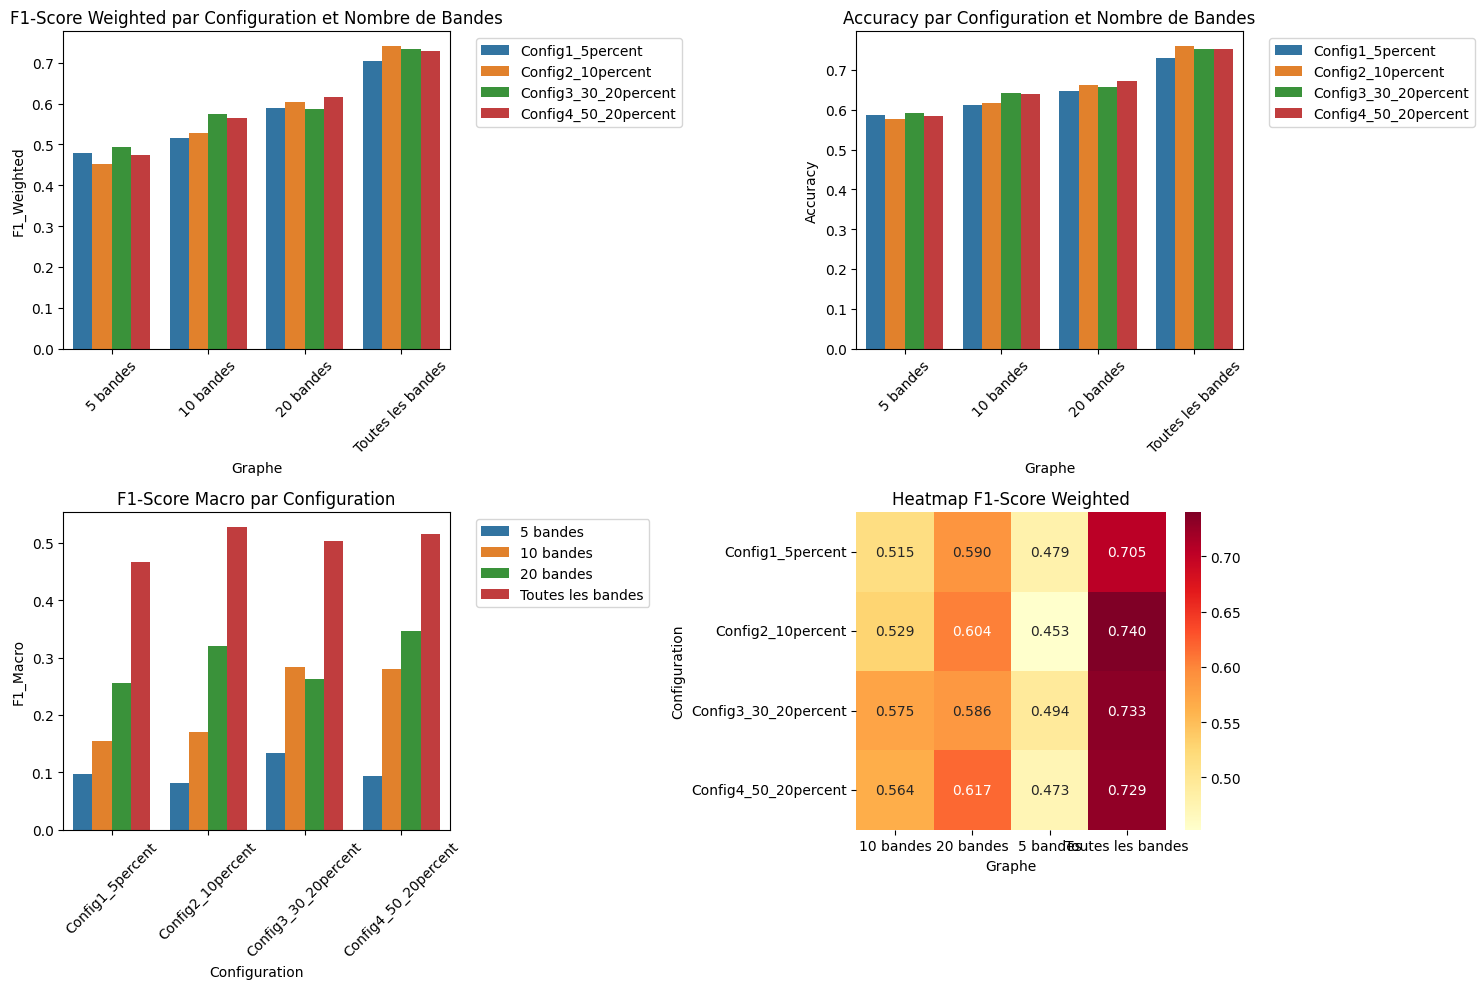

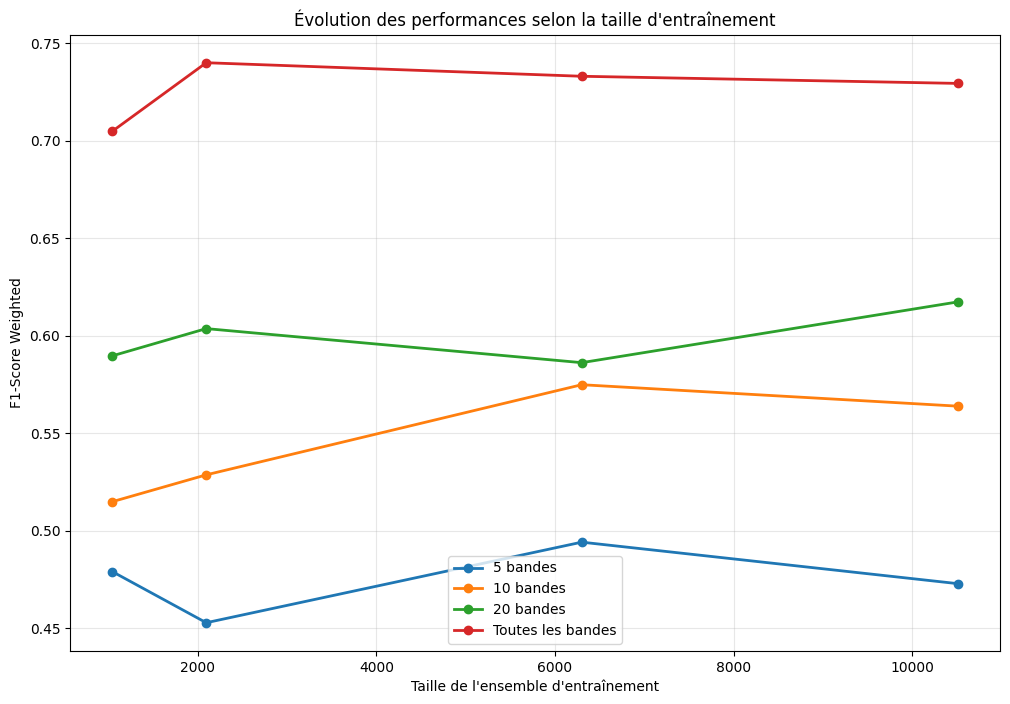


Graphiques sauvegardés dans /kaggle/working/

EXPÉRIMENTATIONS TERMINÉES!
Nombre total d'expériences réalisées: 16
Fichiers générés:
  - single_layer_gcn_experiments.csv
  - single_layer_gcn_comparison.png
  - performance_vs_training_size.png
  - Modèles .pt pour chaque expérience


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Essayer d'importer DataEdgeAttr si disponible
try:
    from torch_geometric.data.data import DataEdgeAttr
except ImportError:
    print("DataEdgeAttr n'est pas disponible dans cette version de PyTorch Geometric")

# Définir une seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Chemins
dataset_path = "/kaggle/input/gcn-gat-graphsage"
output_path = "/kaggle/working/"

# Définition du modèle GCN avec UNE SEULE couche cachée
class SingleLayerGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=64):
        super(SingleLayerGCN, self).__init__()
        # UNE SEULE couche de convolution de graphe
        self.conv1 = GCNConv(num_features, hidden_channels)
        # Couche de classification
        self.lin = nn.Linear(hidden_channels, num_classes)
    
    def forward(self, x, edge_index, batch=None):
        # Passage de convolution de graphe
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Si un batch est fourni (pour les graphes multiples), faire un pooling global
        if batch is not None:
            x = global_mean_pool(x, batch)
        
        # Classification
        x = self.lin(x)
        
        return x

def create_data_splits_config1(data, include_background=True):
    """
    Config 1: Training minimal - 5% train, 5% val, 90% test
    """
    train_percent = 0.05
    val_percent = 0.05
    # test_percent = 0.90 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 1 - Répartition par classe (5% train, 5% val, 90% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))  # Au moins 1 échantillon
        n_val = max(1, int(total_samples * val_percent))      # Au moins 1 échantillon
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = 1
                n_val = 1
                n_test = total_samples - 2
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config2(data, include_background=True):
    """
    Config 2: Training faible - 10% train, 10% val, 80% test
    """
    train_percent = 0.10
    val_percent = 0.10
    # test_percent = 0.80 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 2 - Répartition par classe (10% train, 10% val, 80% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = 1
                n_val = 1
                n_test = total_samples - 2
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config3(data, include_background=True):
    """
    Config 3: Training modéré - 30% train, 20% val, 50% test
    """
    train_percent = 0.30
    val_percent = 0.20
    # test_percent = 0.50 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 3 - Répartition par classe (30% train, 20% val, 50% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = int(total_samples * 0.5)
                n_val = int(total_samples * 0.3)
                n_test = total_samples - n_train - n_val
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config4(data, include_background=True):
    """
    Config 4: Training élevé - 50% train, 20% val, 30% test
    """
    train_percent = 0.50
    val_percent = 0.20
    # test_percent = 0.30 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 4 - Répartition par classe (50% train, 20% val, 30% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = int(total_samples * 0.6)
                n_val = int(total_samples * 0.2)
                n_test = total_samples - n_train - n_val
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def train_single_layer_gcn(graph_path, config_name, split_function, epochs=100, patience=20, 
                          lr=0.01, device='cuda', include_background=True):
    """
    Entraîne un modèle GCN à une seule couche avec une configuration de division spécifique
    """
    print(f"\n{'='*80}")
    print(f"Évaluation: {os.path.basename(graph_path)} - {config_name}")
    print(f"{'='*80}")
    
    # Charger le graphe
    try:
        data = torch.load(graph_path, weights_only=False)
    except Exception as e1:
        print(f"Erreur de chargement: {e1}")
        try:
            import torch.serialization
            from torch_geometric.data import Data
            try:
                from torch_geometric.data.data import DataEdgeAttr
                torch.serialization.add_safe_globals([Data, DataEdgeAttr])
            except ImportError:
                torch.serialization.add_safe_globals([Data])
            data = torch.load(graph_path, weights_only=False)
        except Exception as e2:
            print(f"Erreur méthode 2: {e2}")
            raise ValueError("Impossible de charger le graphe.")
    
    # Obtenir les informations sur le graphe
    num_features = data.x.shape[1]
    if include_background:
        num_classes = int(data.y.max().item() + 1)
    else:
        num_classes = int(data.y.max().item())
    
    print(f"Nombre de caractéristiques: {num_features}")
    print(f"Nombre de classes: {num_classes}")
    
    # Créer les divisions selon la configuration
    train_indices, val_indices, test_indices = split_function(data, include_background)
    
    # Créer des masques
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Afficher les statistiques de division
    train_size = train_mask.sum().item()
    val_size = val_mask.sum().item()
    test_size = test_mask.sum().item()
    total_size = train_size + val_size + test_size
    
    print(f"\nRépartition des données:")
    print(f"  Entraînement: {train_size} pixels ({train_size/total_size:.1%})")
    print(f"  Validation:   {val_size} pixels ({val_size/total_size:.1%})")
    print(f"  Test:         {test_size} pixels ({test_size/total_size:.1%})")
    
    # Vérifier la distribution des classes
    train_classes = set(data.y[train_mask].numpy())
    val_classes = set(data.y[val_mask].numpy())
    test_classes = set(data.y[test_mask].numpy())
    
    print(f"\nDistribution des classes:")
    print(f"  Classes dans l'entraînement: {len(train_classes)}")
    print(f"  Classes dans la validation: {len(val_classes)}")
    print(f"  Classes dans le test: {len(test_classes)}")
    
    # Initialiser le modèle (UNE SEULE COUCHE)
    model = SingleLayerGCN(num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, verbose=True
    )
    
    # Boucle d'entraînement
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    
    print("Début de l'entraînement...")
    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x.to(device), data.edge_index.to(device))
        
        # Calcul de la perte d'entraînement
        train_loss = F.cross_entropy(out[train_mask], data.y[train_mask].to(device))
        train_losses.append(train_loss.item())
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Mode évaluation
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
            
            # Calculer la perte de validation
            val_loss = F.cross_entropy(out[val_mask], data.y[val_mask].to(device))
            val_losses.append(val_loss.item())
            
            # Calculer la précision de validation
            pred = out.argmax(dim=1)
            correct = pred[val_mask].cpu() == data.y[val_mask]
            val_acc = float(correct.sum()) / int(val_mask.sum())
            val_accuracies.append(val_acc)
            
            scheduler.step(val_acc)
        
        # Afficher la progression
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        
        # Vérifier l'amélioration
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Arrêt précoce
        if patience_counter >= patience:
            print(f"Arrêt précoce à l'époque {epoch+1}")
            break
    
    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    
    # Évaluation finale sur l'ensemble de test
    model.eval()
    with torch.no_grad():
        logits = model(data.x.to(device), data.edge_index.to(device))
        pred = logits.argmax(dim=1).cpu()
        
        # Métriques d'évaluation
        y_true = data.y[test_mask].numpy()
        y_pred = pred[test_mask].numpy()
        
        # Calculer les métriques
        accuracy = accuracy_score(y_true, y_pred)
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_per_class = f1_score(y_true, y_pred, average=None)
        
        # Créer le rapport de classification détaillé
        report = classification_report(y_true, y_pred, output_dict=True)
        
        # Afficher les résultats
        print(f"\nRésultats finaux sur l'ensemble de test:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (weighted): {f1_weighted:.4f}")
        print(f"F1 Score (macro): {f1_macro:.4f}")
        
        # Préparer les résultats à retourner
        results = {
            'config': config_name,
            'graph': os.path.basename(graph_path),
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'f1_per_class': f1_per_class,
            'report': report,
            'train_size': train_size,
            'val_size': val_size,
            'test_size': test_size,
            'best_val_accuracy': best_val_acc,
            'num_features': num_features
        }
        
        # Sauvegarder le modèle
        model_name = f"single_gcn_{config_name}_{os.path.basename(graph_path).split('.')[0]}.pt"
        model_path = os.path.join(output_path, model_name)
        torch.save(model, model_path)
        print(f"Modèle sauvegardé: {model_name}")
    
    return model, results

def run_all_experiments():
    """
    Lance toutes les expérimentations: 4 configs × 4 graphes = 16 expériences
    """
    # Vérifier si CUDA est disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Utilisation de: {device}")
    
    # Définir les 4 graphes à tester
    graph_paths = [
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_5bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_10bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_allbands.pt")
    ]
    
    # Définir les 4 configurations de division
    configs = [
        {'name': 'Config1_5percent', 'function': create_data_splits_config1, 
         'description': '5% train, 5% val, 90% test'},
        {'name': 'Config2_10percent', 'function': create_data_splits_config2, 
         'description': '10% train, 10% val, 80% test'},
        {'name': 'Config3_30_20percent', 'function': create_data_splits_config3, 
         'description': '30% train, 20% val, 50% test'},
        {'name': 'Config4_50_20percent', 'function': create_data_splits_config4, 
         'description': '50% train, 20% val, 30% test'}
    ]
    
    # Vérifier l'existence des graphes
    existing_graphs = [p for p in graph_paths if os.path.exists(p)]
    
    if not existing_graphs:
        print("Aucun graphe trouvé! Veuillez d'abord exécuter le code de création des graphes.")
        return {}, pd.DataFrame()
    
    print(f"Graphes trouvés: {len(existing_graphs)}")
    for graph in existing_graphs:
        print(f"  - {os.path.basename(graph)}")
    
    # Stocker tous les résultats
    all_results = {}
    experiment_data = []
    
    # Lancer toutes les expérimentations
    for config in configs:
        print(f"\n{'#'*100}")
        print(f"# CONFIGURATION: {config['description']}")
        print(f"{'#'*100}")
        
        for graph_path in existing_graphs:
            try:
                model, results = train_single_layer_gcn(
                    graph_path=graph_path,
                    config_name=config['name'],
                    split_function=config['function'],
                    epochs=100,
                    patience=15,
                    lr=0.01,
                    device=device,
                    include_background=True
                )
                
                # Stocker les résultats
                exp_key = f"{config['name']}_{os.path.basename(graph_path)}"
                all_results[exp_key] = results
                
                # Extraire le nombre de bandes du nom du graphe
                graph_name = os.path.basename(graph_path)
                if "5bands" in graph_name:
                    bands = "5 bandes"
                elif "10bands" in graph_name:
                    bands = "10 bandes"
                elif "20bands" in graph_name:
                    bands = "20 bandes"
                elif "allbands" in graph_name:
                    bands = "Toutes les bandes"
                else:
                    bands = "Inconnu"
                
                # Ajouter aux données d'expérimentation
                experiment_data.append({
                    'Configuration': config['name'],
                    'Description': config['description'],
                    'Graphe': bands,
                    'Nombre_Features': results['num_features'],
                    'Taille_Train': results['train_size'],
                    'Taille_Val': results['val_size'],
                    'Taille_Test': results['test_size'],
                    'Accuracy': results['accuracy'],
                    'F1_Weighted': results['f1_weighted'],
                    'F1_Macro': results['f1_macro'],
                    'Best_Val_Acc': results['best_val_accuracy']
                })
                
            except Exception as e:
                print(f"Erreur pour {graph_path} avec {config['name']}: {e}")
                continue
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(experiment_data)
    
    # Sauvegarder les résultats
    results_df.to_csv(os.path.join(output_path, "single_layer_gcn_experiments.csv"), index=False)
    
    # Afficher le tableau récapitulatif
    print(f"\n{'='*100}")
    print("RÉSULTATS FINAUX - TOUTES LES EXPÉRIMENTATIONS")
    print(f"{'='*100}")
    print(results_df.to_string(index=False))
    
    # Créer des visualisations comparatives
    create_comparison_plots(results_df)
    
    return all_results, results_df

def create_comparison_plots(results_df):
    """
    Crée des graphiques de comparaison des résultats
    """
    # Configuration de la figure
    plt.style.use('default')
    
    # 1. Comparaison F1-score par configuration et nombre de bandes
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.barplot(data=results_df, x='Graphe', y='F1_Weighted', hue='Configuration')
    plt.title('F1-Score Weighted par Configuration et Nombre de Bandes')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 2)
    sns.barplot(data=results_df, x='Graphe', y='Accuracy', hue='Configuration')
    plt.title('Accuracy par Configuration et Nombre de Bandes')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 3)
    sns.barplot(data=results_df, x='Configuration', y='F1_Macro', hue='Graphe')
    plt.title('F1-Score Macro par Configuration')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 4)
    # Heatmap des performances
    pivot_table = results_df.pivot(index='Configuration', columns='Graphe', values='F1_Weighted')
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title('Heatmap F1-Score Weighted')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "single_layer_gcn_comparison.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Évolution des performances selon la taille de l'ensemble d'entraînement
    plt.figure(figsize=(12, 8))
    
    for graphe in results_df['Graphe'].unique():
        subset = results_df[results_df['Graphe'] == graphe]
        plt.plot(subset['Taille_Train'], subset['F1_Weighted'], marker='o', label=graphe, linewidth=2)
    
    plt.xlabel('Taille de l\'ensemble d\'entraînement')
    plt.ylabel('F1-Score Weighted')
    plt.title('Évolution des performances selon la taille d\'entraînement')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_path, "performance_vs_training_size.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nGraphiques sauvegardés dans {output_path}")

# Point d'entrée principal
if __name__ == "__main__":
    print("Lancement de toutes les expérimentations GCN à une couche...")
    print("4 configurations × 4 graphes = 16 expériences")
    
    all_results, results_df = run_all_experiments()
    
    print(f"\n{'='*100}")
    print("EXPÉRIMENTATIONS TERMINÉES!")
    print(f"Nombre total d'expériences réalisées: {len(results_df)}")
    print("Fichiers générés:")
    print("  - single_layer_gcn_experiments.csv")
    print("  - single_layer_gcn_comparison.png")
    print("  - performance_vs_training_size.png")
    print("  - Modèles .pt pour chaque expérience")
    print(f"{'='*100}")

### Expérimentation GCN 2-Couches : Benchmark Multi-Configuration avec Comparaison 1-Layer vs 2-Layer"

Lancement de toutes les expérimentations GCN à DEUX couches...
4 configurations × 4 graphes = 16 expériences
Utilisation de: cuda
Graphes trouvés: 4
  - indian_pines_graph_d1_4connectivity_5bands.pt
  - indian_pines_graph_d1_4connectivity_10bands.pt
  - indian_pines_graph_d1_4connectivity_20bands.pt
  - indian_pines_graph_d1_4connectivity_allbands.pt

####################################################################################################
# CONFIGURATION: 5% train, 5% val, 90% test
####################################################################################################

Évaluation: indian_pines_graph_d1_4connectivity_5bands.pt - Config1_5percent
Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 5
Nombre de classes: 17

Config 1 - Répartition par classe (5% train, 5% val, 90% test):
  Classe 0: 10776 total → 538 train, 538 val, 9700 test
  Classe 1: 46 total → 2 train, 2 val, 42 test
  C

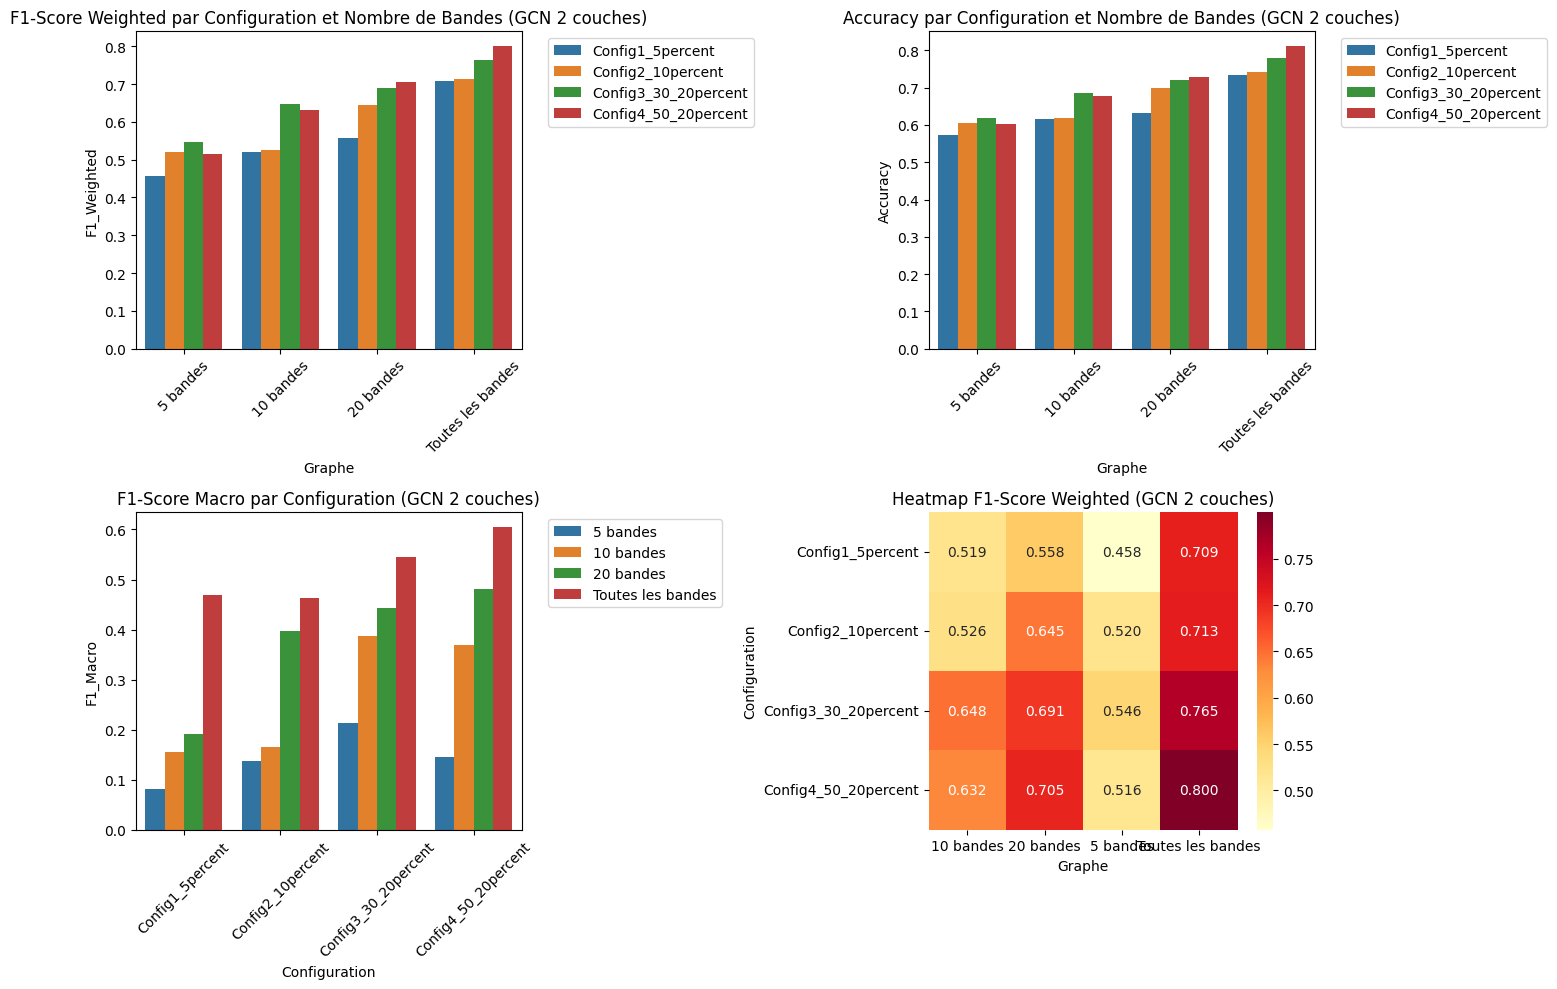

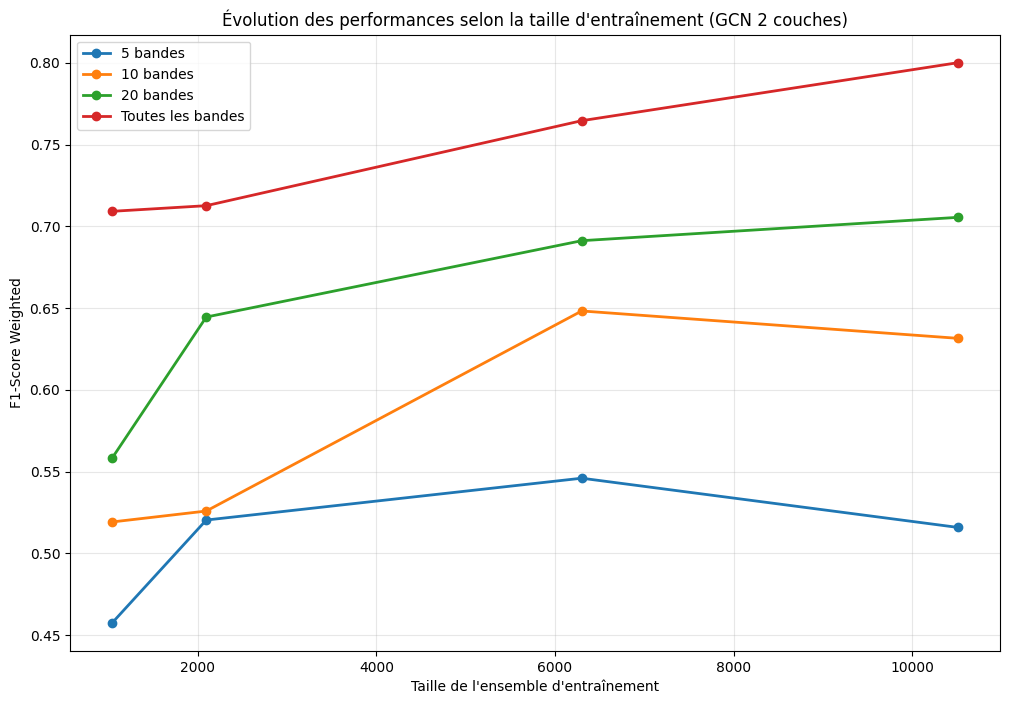


Graphiques sauvegardés dans /kaggle/working/

EXPÉRIMENTATIONS GCN 2 COUCHES TERMINÉES!
Nombre total d'expériences réalisées: 16
Fichiers générés:
  - two_layer_gcn_experiments.csv
  - two_layer_gcn_comparison.png
  - two_layer_performance_vs_training_size.png
  - Modèles .pt pour chaque expérience
Utilisation de: cuda
Graphes trouvés: 4
  - indian_pines_graph_d1_4connectivity_5bands.pt
  - indian_pines_graph_d1_4connectivity_10bands.pt
  - indian_pines_graph_d1_4connectivity_20bands.pt
  - indian_pines_graph_d1_4connectivity_allbands.pt

####################################################################################################
# CONFIGURATION: 5% train, 5% val, 90% test
####################################################################################################

Évaluation: indian_pines_graph_d1_4connectivity_5bands.pt - Config1_5percent
Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 5
N

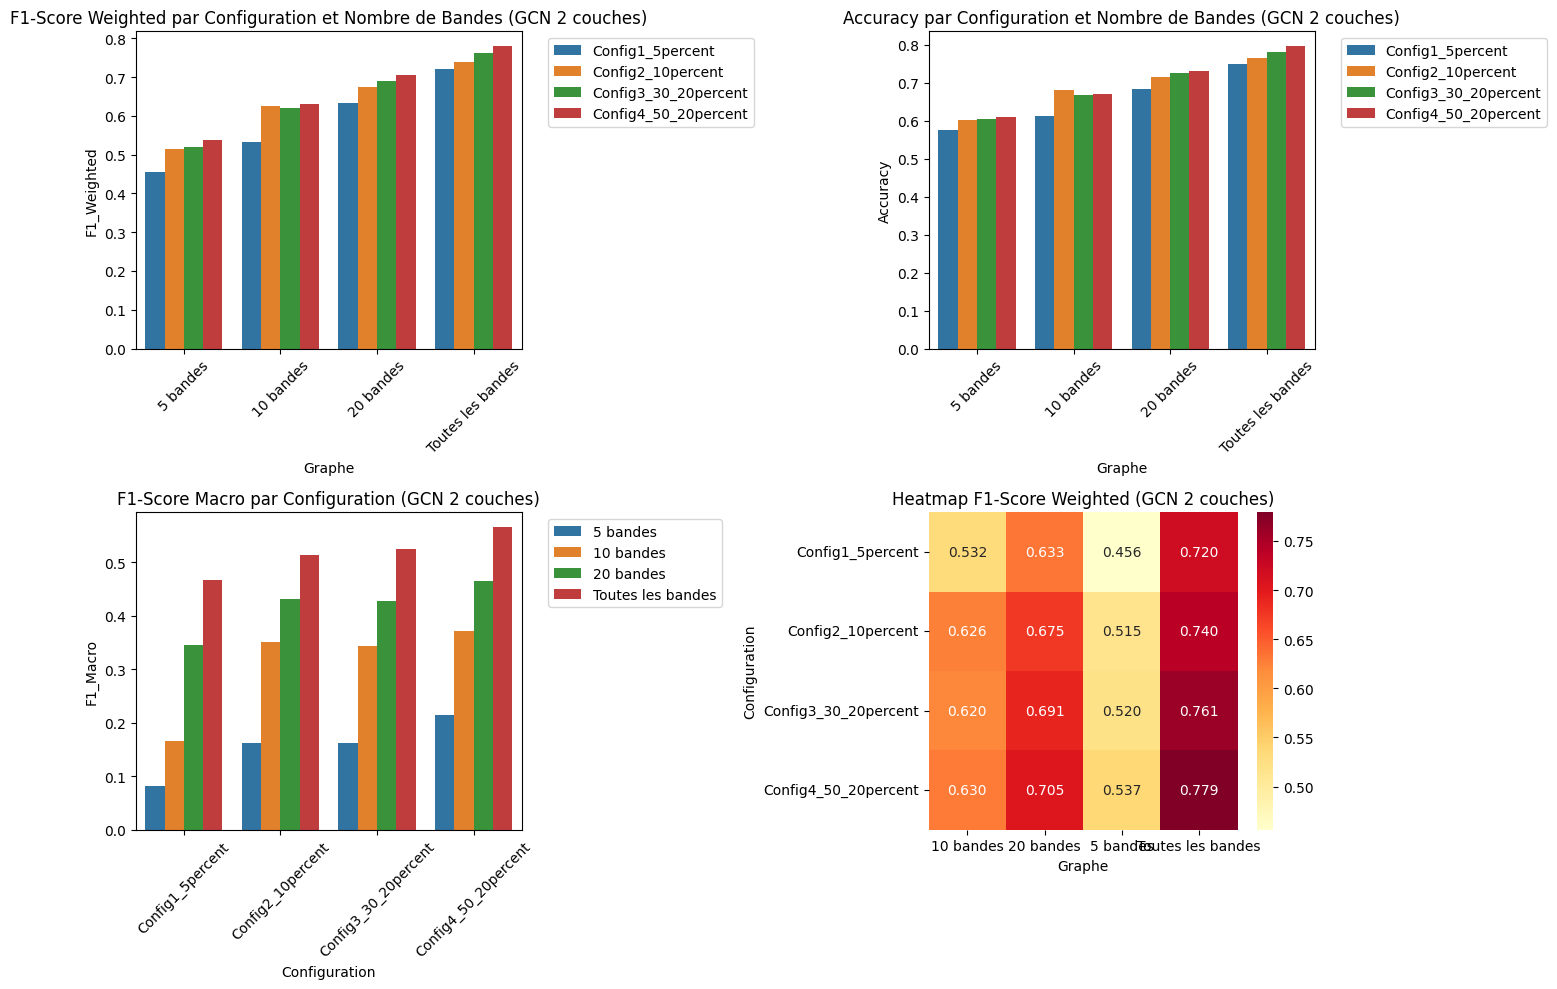

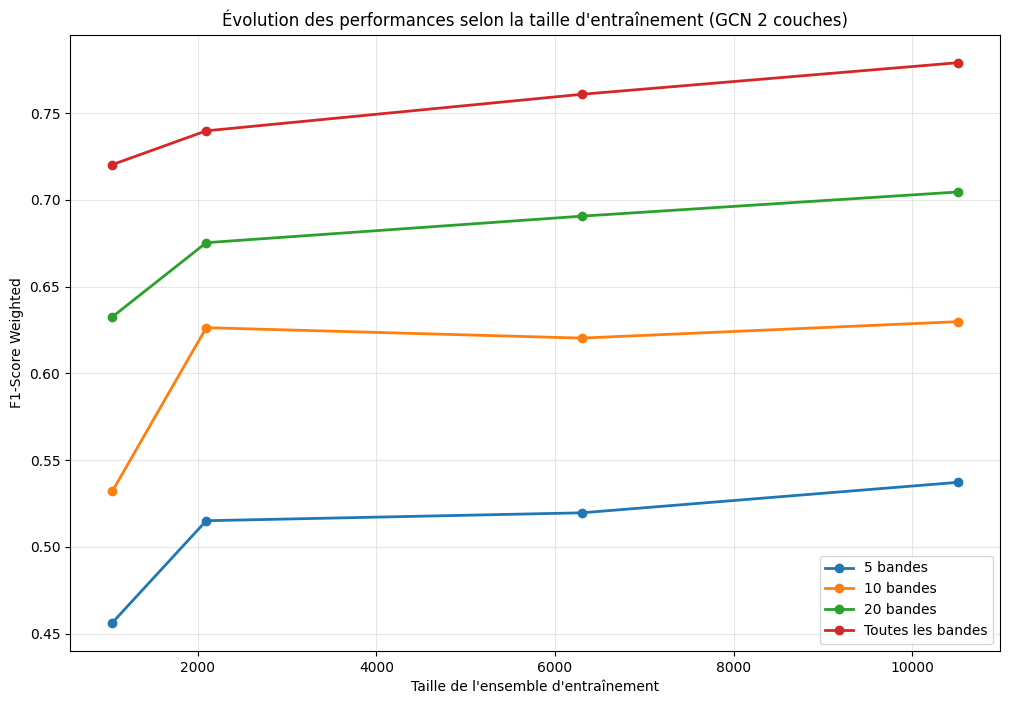


Graphiques sauvegardés dans /kaggle/working/

EXPÉRIMENTATIONS GCN 2 COUCHES TERMINÉES!
Nombre total d'expériences réalisées: 16
Fichiers générés:
  - two_layer_gcn_experiments.csv
  - two_layer_gcn_comparison.png
  - two_layer_performance_vs_training_size.png
  - Modèles .pt pour chaque expérience

Lancement de la comparaison 1 couche vs 2 couches...


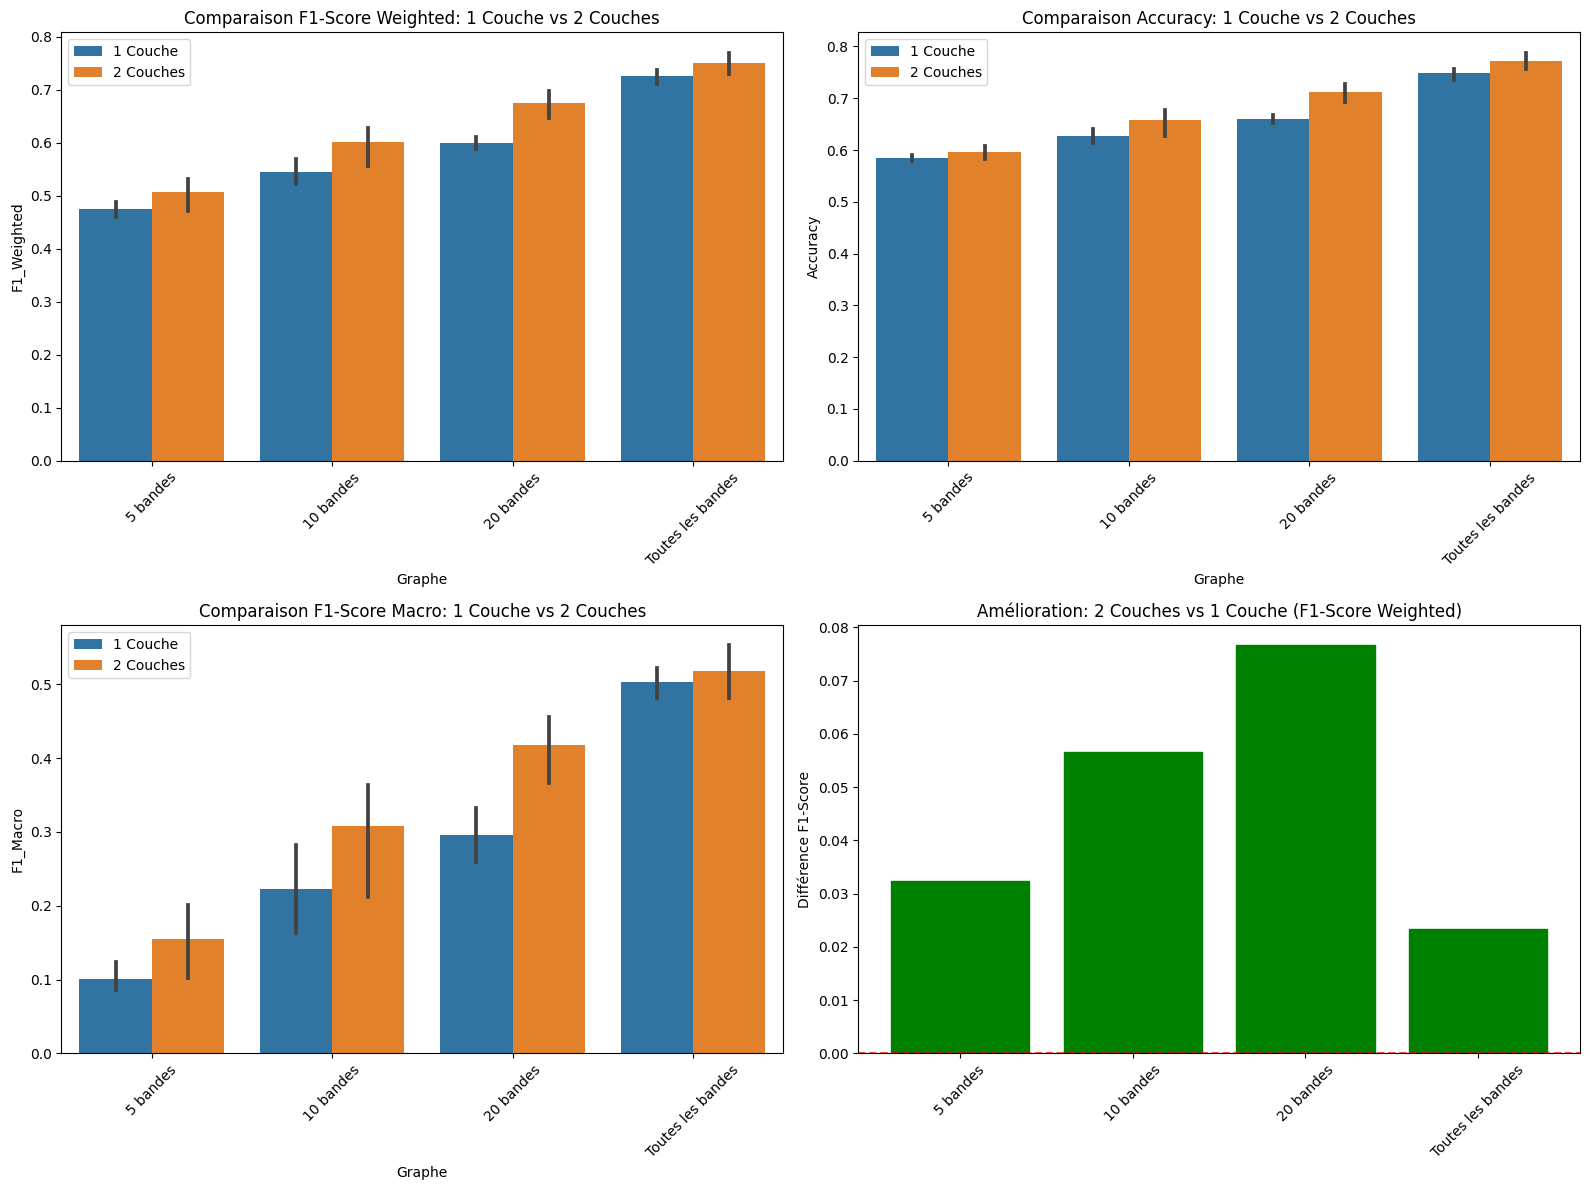


COMPARAISON STATISTIQUE: 1 COUCHE vs 2 COUCHES
                              Accuracy  F1_Weighted  F1_Macro
Model_Type Graphe                                            
1 Couche   10 bandes            0.6278       0.5455    0.2221
           20 bandes            0.6594       0.5992    0.2962
           5 bandes             0.5850       0.4747    0.1013
           Toutes les bandes    0.7483       0.7267    0.5031
2 Couches  10 bandes            0.6582       0.6021    0.3082
           20 bandes            0.7128       0.6758    0.4174
           5 bandes             0.5971       0.5070    0.1554
           Toutes les bandes    0.7721       0.7500    0.5178

Comparaison terminée! Fichiers supplémentaires générés:
  - single_vs_two_layer_combined.csv
  - single_vs_two_layer_stats.csv
  - single_vs_two_layer_comparison.png


In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Essayer d'importer DataEdgeAttr si disponible
try:
    from torch_geometric.data.data import DataEdgeAttr
except ImportError:
    print("DataEdgeAttr n'est pas disponible dans cette version de PyTorch Geometric")

# Définir une seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Chemins
dataset_path = "/kaggle/input/gcn-gat-graphsage"
output_path = "/kaggle/working/"

# Définition du modèle GCN avec DEUX couches cachées
class TwoLayerGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=64):
        super(TwoLayerGCN, self).__init__()
        # PREMIÈRE couche de convolution de graphe
        self.conv1 = GCNConv(num_features, hidden_channels)
        # DEUXIÈME couche de convolution de graphe
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # Couche de classification
        self.lin = nn.Linear(hidden_channels, num_classes)
    
    def forward(self, x, edge_index, batch=None):
        # Premier passage de convolution de graphe
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Deuxième passage de convolution de graphe
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Si un batch est fourni (pour les graphes multiples), faire un pooling global
        if batch is not None:
            x = global_mean_pool(x, batch)
        
        # Classification
        x = self.lin(x)
        
        return x

def create_data_splits_config1(data, include_background=True):
    """
    Config 1: Training minimal - 5% train, 5% val, 90% test
    """
    train_percent = 0.05
    val_percent = 0.05
    # test_percent = 0.90 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 1 - Répartition par classe (5% train, 5% val, 90% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))  # Au moins 1 échantillon
        n_val = max(1, int(total_samples * val_percent))      # Au moins 1 échantillon
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = 1
                n_val = 1
                n_test = total_samples - 2
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config2(data, include_background=True):
    """
    Config 2: Training faible - 10% train, 10% val, 80% test
    """
    train_percent = 0.10
    val_percent = 0.10
    # test_percent = 0.80 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 2 - Répartition par classe (10% train, 10% val, 80% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = 1
                n_val = 1
                n_test = total_samples - 2
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config3(data, include_background=True):
    """
    Config 3: Training modéré - 30% train, 20% val, 50% test
    """
    train_percent = 0.30
    val_percent = 0.20
    # test_percent = 0.50 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 3 - Répartition par classe (30% train, 20% val, 50% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = int(total_samples * 0.5)
                n_val = int(total_samples * 0.3)
                n_test = total_samples - n_train - n_val
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config4(data, include_background=True):
    """
    Config 4: Training élevé - 50% train, 20% val, 30% test
    """
    train_percent = 0.50
    val_percent = 0.20
    # test_percent = 0.30 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 4 - Répartition par classe (50% train, 20% val, 30% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = int(total_samples * 0.6)
                n_val = int(total_samples * 0.2)
                n_test = total_samples - n_train - n_val
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def train_two_layer_gcn(graph_path, config_name, split_function, epochs=100, patience=20, 
                       lr=0.01, device='cuda', include_background=True):
    """
    Entraîne un modèle GCN à DEUX couches avec une configuration de division spécifique
    """
    print(f"\n{'='*80}")
    print(f"Évaluation: {os.path.basename(graph_path)} - {config_name}")
    print(f"{'='*80}")
    
    # Charger le graphe
    try:
        data = torch.load(graph_path, weights_only=False)
    except Exception as e1:
        print(f"Erreur de chargement: {e1}")
        try:
            import torch.serialization
            from torch_geometric.data import Data
            try:
                from torch_geometric.data.data import DataEdgeAttr
                torch.serialization.add_safe_globals([Data, DataEdgeAttr])
            except ImportError:
                torch.serialization.add_safe_globals([Data])
            data = torch.load(graph_path, weights_only=False)
        except Exception as e2:
            print(f"Erreur méthode 2: {e2}")
            raise ValueError("Impossible de charger le graphe.")
    
    # Obtenir les informations sur le graphe
    num_features = data.x.shape[1]
    if include_background:
        num_classes = int(data.y.max().item() + 1)
    else:
        num_classes = int(data.y.max().item())
    
    print(f"Nombre de caractéristiques: {num_features}")
    print(f"Nombre de classes: {num_classes}")
    
    # Créer les divisions selon la configuration
    train_indices, val_indices, test_indices = split_function(data, include_background)
    
    # Créer des masques
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Afficher les statistiques de division
    train_size = train_mask.sum().item()
    val_size = val_mask.sum().item()
    test_size = test_mask.sum().item()
    total_size = train_size + val_size + test_size
    
    print(f"\nRépartition des données:")
    print(f"  Entraînement: {train_size} pixels ({train_size/total_size:.1%})")
    print(f"  Validation:   {val_size} pixels ({val_size/total_size:.1%})")
    print(f"  Test:         {test_size} pixels ({test_size/total_size:.1%})")
    
    # Vérifier la distribution des classes
    train_classes = set(data.y[train_mask].numpy())
    val_classes = set(data.y[val_mask].numpy())
    test_classes = set(data.y[test_mask].numpy())
    
    print(f"\nDistribution des classes:")
    print(f"  Classes dans l'entraînement: {len(train_classes)}")
    print(f"  Classes dans la validation: {len(val_classes)}")
    print(f"  Classes dans le test: {len(test_classes)}")
    
    # Initialiser le modèle (DEUX COUCHES)
    model = TwoLayerGCN(num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, verbose=True
    )
    
    # Boucle d'entraînement
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    
    print("Début de l'entraînement...")
    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x.to(device), data.edge_index.to(device))
        
        # Calcul de la perte d'entraînement
        train_loss = F.cross_entropy(out[train_mask], data.y[train_mask].to(device))
        train_losses.append(train_loss.item())
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Mode évaluation
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
            
            # Calculer la perte de validation
            val_loss = F.cross_entropy(out[val_mask], data.y[val_mask].to(device))
            val_losses.append(val_loss.item())
            
            # Calculer la précision de validation
            pred = out.argmax(dim=1)
            correct = pred[val_mask].cpu() == data.y[val_mask]
            val_acc = float(correct.sum()) / int(val_mask.sum())
            val_accuracies.append(val_acc)
            
            scheduler.step(val_acc)
        
        # Afficher la progression
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        
        # Vérifier l'amélioration
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Arrêt précoce
        if patience_counter >= patience:
            print(f"Arrêt précoce à l'époque {epoch+1}")
            break
    
    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    
    # Évaluation finale sur l'ensemble de test
    model.eval()
    with torch.no_grad():
        logits = model(data.x.to(device), data.edge_index.to(device))
        pred = logits.argmax(dim=1).cpu()
        
        # Métriques d'évaluation
        y_true = data.y[test_mask].numpy()
        y_pred = pred[test_mask].numpy()
        
        # Calculer les métriques
        accuracy = accuracy_score(y_true, y_pred)
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_per_class = f1_score(y_true, y_pred, average=None)
        
        # Créer le rapport de classification détaillé
        report = classification_report(y_true, y_pred, output_dict=True)
        
        # Afficher les résultats
        print(f"\nRésultats finaux sur l'ensemble de test:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (weighted): {f1_weighted:.4f}")
        print(f"F1 Score (macro): {f1_macro:.4f}")
        
        # Préparer les résultats à retourner
        results = {
            'config': config_name,
            'graph': os.path.basename(graph_path),
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'f1_per_class': f1_per_class,
            'report': report,
            'train_size': train_size,
            'val_size': val_size,
            'test_size': test_size,
            'best_val_accuracy': best_val_acc,
            'num_features': num_features
        }
        
        # Sauvegarder le modèle
        model_name = f"two_layer_gcn_{config_name}_{os.path.basename(graph_path).split('.')[0]}.pt"
        model_path = os.path.join(output_path, model_name)
        torch.save(model, model_path)
        print(f"Modèle sauvegardé: {model_name}")
    
    return model, results

def run_all_two_layer_experiments():
    """
    Lance toutes les expérimentations avec GCN 2 couches: 4 configs × 4 graphes = 16 expériences
    """
    # Vérifier si CUDA est disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Utilisation de: {device}")
    
    # Définir les 4 graphes à tester
    graph_paths = [
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_5bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_10bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_allbands.pt")
    ]
    
    # Définir les 4 configurations de division
    configs = [
        {'name': 'Config1_5percent', 'function': create_data_splits_config1, 
         'description': '5% train, 5% val, 90% test'},
        {'name': 'Config2_10percent', 'function': create_data_splits_config2, 
         'description': '10% train, 10% val, 80% test'},
        {'name': 'Config3_30_20percent', 'function': create_data_splits_config3, 
         'description': '30% train, 20% val, 50% test'},
        {'name': 'Config4_50_20percent', 'function': create_data_splits_config4, 
         'description': '50% train, 20% val, 30% test'}
    ]
    
    # Vérifier l'existence des graphes
    existing_graphs = [p for p in graph_paths if os.path.exists(p)]
    
    if not existing_graphs:
        print("Aucun graphe trouvé! Veuillez d'abord exécuter le code de création des graphes.")
        return {}, pd.DataFrame()
    
    print(f"Graphes trouvés: {len(existing_graphs)}")
    for graph in existing_graphs:
        print(f"  - {os.path.basename(graph)}")
    
    # Stocker tous les résultats
    all_results = {}
    experiment_data = []
    
    # Lancer toutes les expérimentations
    for config in configs:
        print(f"\n{'#'*100}")
        print(f"# CONFIGURATION: {config['description']}")
        print(f"{'#'*100}")
        
        for graph_path in existing_graphs:
            try:
                model, results = train_two_layer_gcn(
                    graph_path=graph_path,
                    config_name=config['name'],
                    split_function=config['function'],
                    epochs=100,
                    patience=15,
                    lr=0.01,
                    device=device,
                    include_background=True
                )
                
                # Stocker les résultats
                exp_key = f"{config['name']}_{os.path.basename(graph_path)}"
                all_results[exp_key] = results
                
                # Extraire le nombre de bandes du nom du graphe
                graph_name = os.path.basename(graph_path)
                if "5bands" in graph_name:
                    bands = "5 bandes"
                elif "10bands" in graph_name:
                    bands = "10 bandes"
                elif "20bands" in graph_name:
                    bands = "20 bandes"
                elif "allbands" in graph_name:
                    bands = "Toutes les bandes"
                else:
                    bands = "Inconnu"
                
                # Ajouter aux données d'expérimentation
                experiment_data.append({
                    'Configuration': config['name'],
                    'Description': config['description'],
                    'Graphe': bands,
                    'Nombre_Features': results['num_features'],
                    'Taille_Train': results['train_size'],
                    'Taille_Val': results['val_size'],
                    'Taille_Test': results['test_size'],
                    'Accuracy': results['accuracy'],
                    'F1_Weighted': results['f1_weighted'],
                    'F1_Macro': results['f1_macro'],
                    'Best_Val_Acc': results['best_val_accuracy']
                })
                
            except Exception as e:
                print(f"Erreur pour {graph_path} avec {config['name']}: {e}")
                continue
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(experiment_data)
    
    # Sauvegarder les résultats
    results_df.to_csv(os.path.join(output_path, "two_layer_gcn_experiments.csv"), index=False)
    
    # Afficher le tableau récapitulatif
    print(f"\n{'='*100}")
    print("RÉSULTATS FINAUX - TOUTES LES EXPÉRIMENTATIONS GCN 2 COUCHES")
    print(f"{'='*100}")
    print(results_df.to_string(index=False))
    
    # Créer des visualisations comparatives
    create_two_layer_comparison_plots(results_df)
    
    return all_results, results_df

def create_two_layer_comparison_plots(results_df):
    """
    Crée des graphiques de comparaison des résultats pour le modèle 2 couches
    """
    # Configuration de la figure
    plt.style.use('default')
    
    # 1. Comparaison F1-score par configuration et nombre de bandes
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.barplot(data=results_df, x='Graphe', y='F1_Weighted', hue='Configuration')
    plt.title('F1-Score Weighted par Configuration et Nombre de Bandes (GCN 2 couches)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 2)
    sns.barplot(data=results_df, x='Graphe', y='Accuracy', hue='Configuration')
    plt.title('Accuracy par Configuration et Nombre de Bandes (GCN 2 couches)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 3)
    sns.barplot(data=results_df, x='Configuration', y='F1_Macro', hue='Graphe')
    plt.title('F1-Score Macro par Configuration (GCN 2 couches)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 4)
    # Heatmap des performances
    pivot_table = results_df.pivot(index='Configuration', columns='Graphe', values='F1_Weighted')
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title('Heatmap F1-Score Weighted (GCN 2 couches)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "two_layer_gcn_comparison.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Évolution des performances selon la taille de l'ensemble d'entraînement
    plt.figure(figsize=(12, 8))
    
    for graphe in results_df['Graphe'].unique():
        subset = results_df[results_df['Graphe'] == graphe]
        plt.plot(subset['Taille_Train'], subset['F1_Weighted'], marker='o', label=graphe, linewidth=2)
    
    plt.xlabel('Taille de l\'ensemble d\'entraînement')
    plt.ylabel('F1-Score Weighted')
    plt.title('Évolution des performances selon la taille d\'entraînement (GCN 2 couches)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_path, "two_layer_performance_vs_training_size.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nGraphiques sauvegardés dans {output_path}")

# Point d'entrée principal
if __name__ == "__main__":
    print("Lancement de toutes les expérimentations GCN à DEUX couches...")
    print("4 configurations × 4 graphes = 16 expériences")
    
    all_results, results_df = run_all_two_layer_experiments()
    
    print(f"\n{'='*100}")
    print("EXPÉRIMENTATIONS GCN 2 COUCHES TERMINÉES!")
    print(f"Nombre total d'expériences réalisées: {len(results_df)}")
    print("Fichiers générés:")
    print("  - two_layer_gcn_experiments.csv")
    print("  - two_layer_gcn_comparison.png")
    print("  - two_layer_performance_vs_training_size.png")
    print("  - Modèles .pt pour chaque expérience")
    print(f"{'='*100}")

def compare_single_vs_two_layer():
    """
    Compare les résultats entre les modèles 1 couche et 2 couches
    """
    # Charger les résultats des deux expérimentations
    try:
        single_layer_df = pd.read_csv(os.path.join(output_path, "single_layer_gcn_experiments.csv"))
        two_layer_df = pd.read_csv(os.path.join(output_path, "two_layer_gcn_experiments.csv"))
        
        # Ajouter une colonne pour identifier le type de modèle
        single_layer_df['Model_Type'] = '1 Couche'
        two_layer_df['Model_Type'] = '2 Couches'
        
        # Combiner les DataFrames
        combined_df = pd.concat([single_layer_df, two_layer_df], ignore_index=True)
        
        # Créer des graphiques comparatifs
        plt.figure(figsize=(16, 12))
        
        # 1. Comparaison F1-Score Weighted
        plt.subplot(2, 2, 1)
        sns.barplot(data=combined_df, x='Graphe', y='F1_Weighted', hue='Model_Type')
        plt.title('Comparaison F1-Score Weighted: 1 Couche vs 2 Couches')
        plt.xticks(rotation=45)
        plt.legend()
        
        # 2. Comparaison Accuracy
        plt.subplot(2, 2, 2)
        sns.barplot(data=combined_df, x='Graphe', y='Accuracy', hue='Model_Type')
        plt.title('Comparaison Accuracy: 1 Couche vs 2 Couches')
        plt.xticks(rotation=45)
        plt.legend()
        
        # 3. Comparaison F1-Score Macro
        plt.subplot(2, 2, 3)
        sns.barplot(data=combined_df, x='Graphe', y='F1_Macro', hue='Model_Type')
        plt.title('Comparaison F1-Score Macro: 1 Couche vs 2 Couches')
        plt.xticks(rotation=45)
        plt.legend()
        
        # 4. Heatmap comparative
        plt.subplot(2, 2, 4)
        # Calculer la différence moyenne par graphe
        diff_data = []
        for graphe in combined_df['Graphe'].unique():
            single_scores = combined_df[(combined_df['Graphe'] == graphe) & (combined_df['Model_Type'] == '1 Couche')]['F1_Weighted'].values
            two_scores = combined_df[(combined_df['Graphe'] == graphe) & (combined_df['Model_Type'] == '2 Couches')]['F1_Weighted'].values
            
            if len(single_scores) > 0 and len(two_scores) > 0:
                avg_single = np.mean(single_scores)
                avg_two = np.mean(two_scores)
                improvement = avg_two - avg_single
                diff_data.append({'Graphe': graphe, 'Amélioration': improvement})
        
        diff_df = pd.DataFrame(diff_data)
        if not diff_df.empty:
            bars = plt.bar(diff_df['Graphe'], diff_df['Amélioration'])
            plt.title('Amélioration: 2 Couches vs 1 Couche (F1-Score Weighted)')
            plt.ylabel('Différence F1-Score')
            plt.xticks(rotation=45)
            plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
            
            # Colorer les barres
            for bar, improvement in zip(bars, diff_df['Amélioration']):
                if improvement > 0:
                    bar.set_color('green')
                else:
                    bar.set_color('red')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "single_vs_two_layer_comparison.png"), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Créer un tableau statistique de comparaison
        print("\n" + "="*80)
        print("COMPARAISON STATISTIQUE: 1 COUCHE vs 2 COUCHES")
        print("="*80)
        
        # Calculer les moyennes par type de modèle
        comparison_stats = combined_df.groupby(['Model_Type', 'Graphe']).agg({
            'Accuracy': 'mean',
            'F1_Weighted': 'mean',
            'F1_Macro': 'mean'
        }).round(4)
        
        print(comparison_stats)
        
        # Sauvegarder la comparaison
        combined_df.to_csv(os.path.join(output_path, "single_vs_two_layer_combined.csv"), index=False)
        comparison_stats.to_csv(os.path.join(output_path, "single_vs_two_layer_stats.csv"))
        
        return combined_df, comparison_stats
        
    except FileNotFoundError as e:
        print(f"Erreur: Impossible de charger les fichiers de comparaison: {e}")
        print("Assurez-vous d'avoir exécuté les expérimentations 1 couche ET 2 couches.")
        return None, None

# Exécuter la comparaison automatiquement si les deux fichiers existent
if __name__ == "__main__":
    # D'abord exécuter les expérimentations 2 couches
    all_results, results_df = run_all_two_layer_experiments()
    
    print(f"\n{'='*100}")
    print("EXPÉRIMENTATIONS GCN 2 COUCHES TERMINÉES!")
    print(f"Nombre total d'expériences réalisées: {len(results_df)}")
    print("Fichiers générés:")
    print("  - two_layer_gcn_experiments.csv")
    print("  - two_layer_gcn_comparison.png")
    print("  - two_layer_performance_vs_training_size.png")
    print("  - Modèles .pt pour chaque expérience")
    print(f"{'='*100}")
    
    # Ensuite comparer avec les résultats 1 couche
    print("\nLancement de la comparaison 1 couche vs 2 couches...")
    combined_df, stats_df = compare_single_vs_two_layer()
    
    if combined_df is not None:
        print("\nComparaison terminée! Fichiers supplémentaires générés:")
        print("  - single_vs_two_layer_combined.csv")
        print("  - single_vs_two_layer_stats.csv") 
        print("  - single_vs_two_layer_comparison.png")

### Expérimentation GCN 3-Couches : Benchmark Multi-Configuration avec Comparaison 1-Layer vs 2-Layer vs 3-Layer"

Lancement de toutes les expérimentations GCN à TROIS couches...
4 configurations × 4 graphes = 16 expériences
Utilisation de: cuda
Graphes trouvés: 4
  - indian_pines_graph_d1_4connectivity_5bands.pt
  - indian_pines_graph_d1_4connectivity_10bands.pt
  - indian_pines_graph_d1_4connectivity_20bands.pt
  - indian_pines_graph_d1_4connectivity_allbands.pt

####################################################################################################
# CONFIGURATION: 5% train, 5% val, 90% test
####################################################################################################

Évaluation: indian_pines_graph_d1_4connectivity_5bands.pt - Config1_5percent
Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 5
Nombre de classes: 17

Config 1 - Répartition par classe (5% train, 5% val, 90% test):
  Classe 0: 10776 total → 538 train, 538 val, 9700 test
  Classe 1: 46 total → 2 train, 2 val, 42 test
  

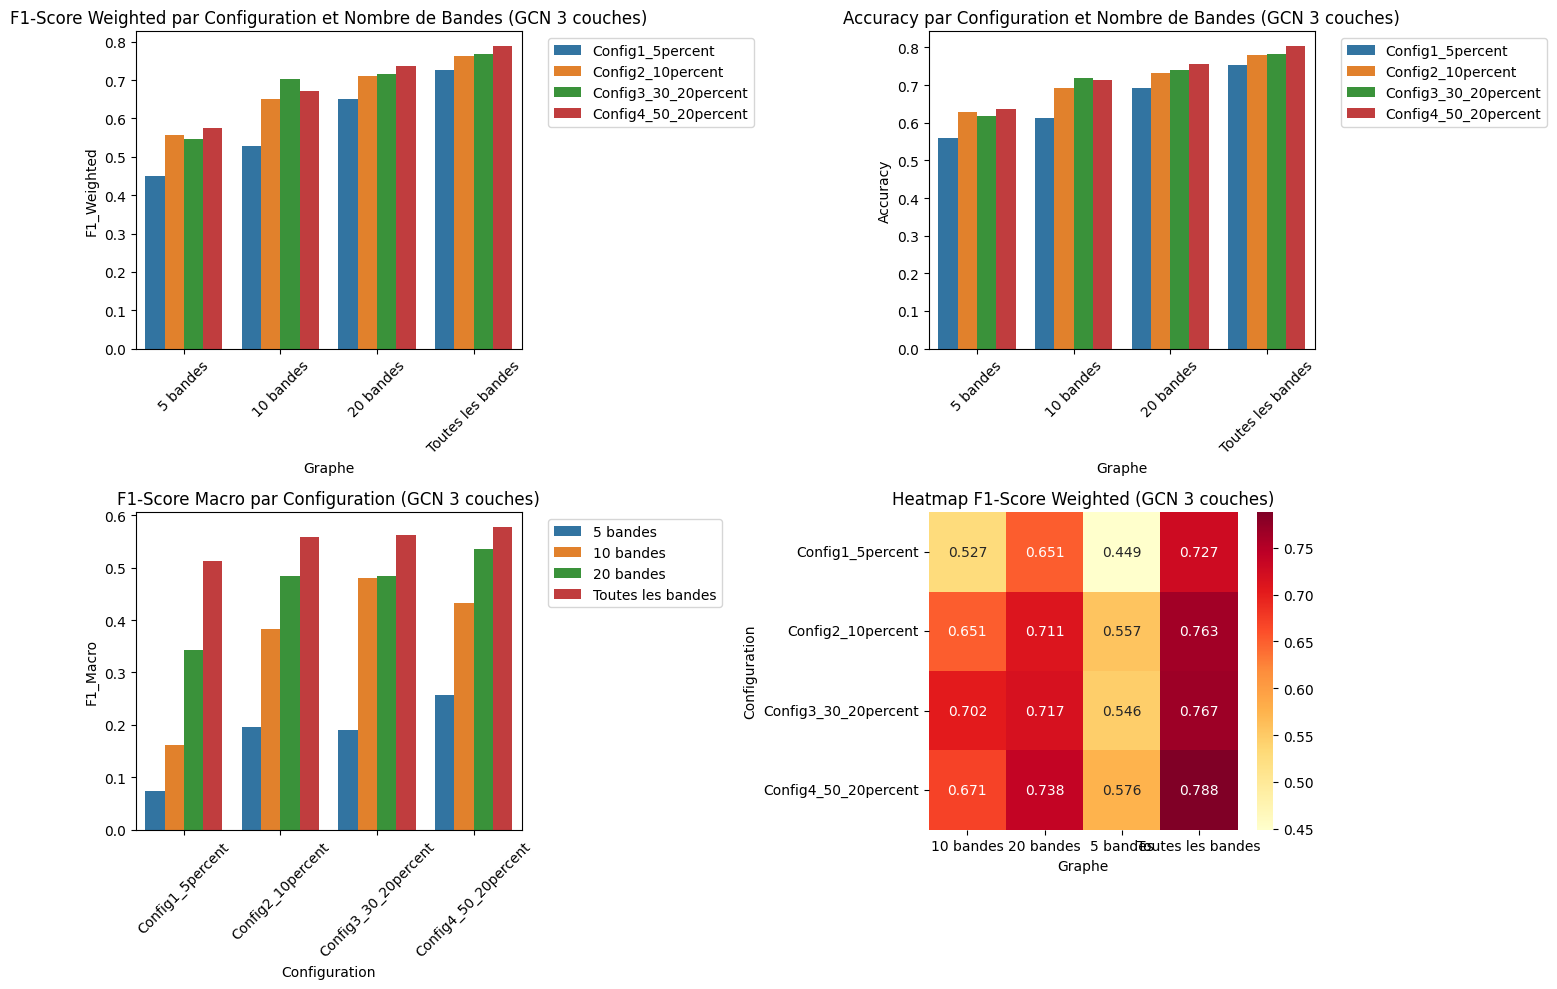

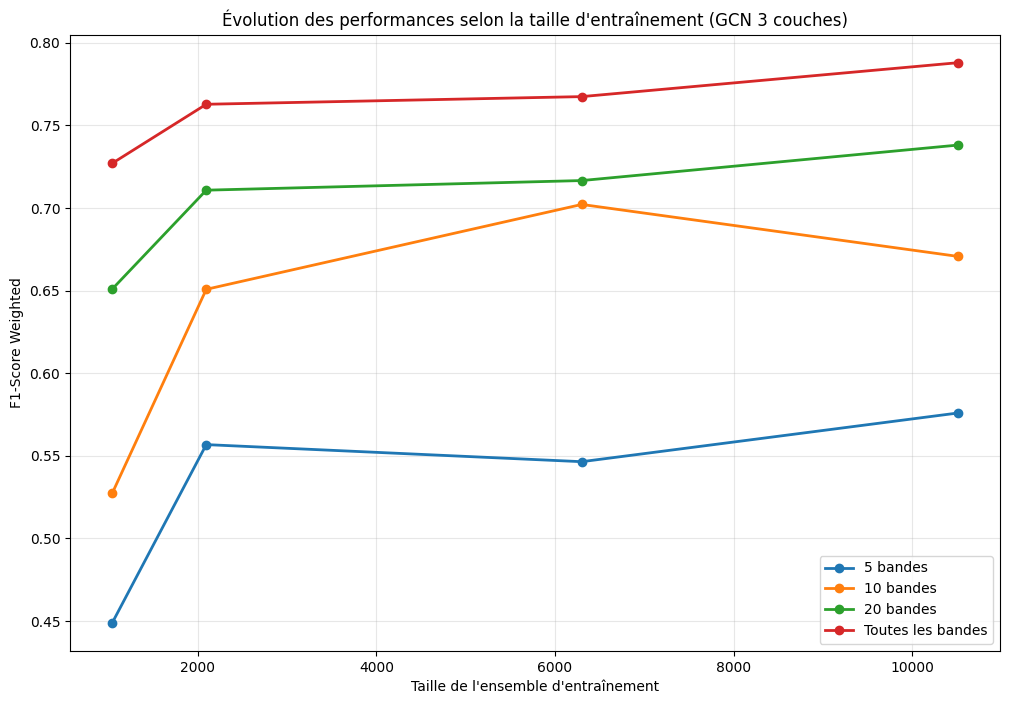


Graphiques sauvegardés dans /kaggle/working/

EXPÉRIMENTATIONS GCN 3 COUCHES TERMINÉES!
Nombre total d'expériences réalisées: 16
Fichiers générés:
  - three_layer_gcn_experiments.csv
  - three_layer_gcn_comparison.png
  - three_layer_performance_vs_training_size.png
  - Modèles .pt pour chaque expérience

Lancement de la comparaison complète 1 vs 2 vs 3 couches...


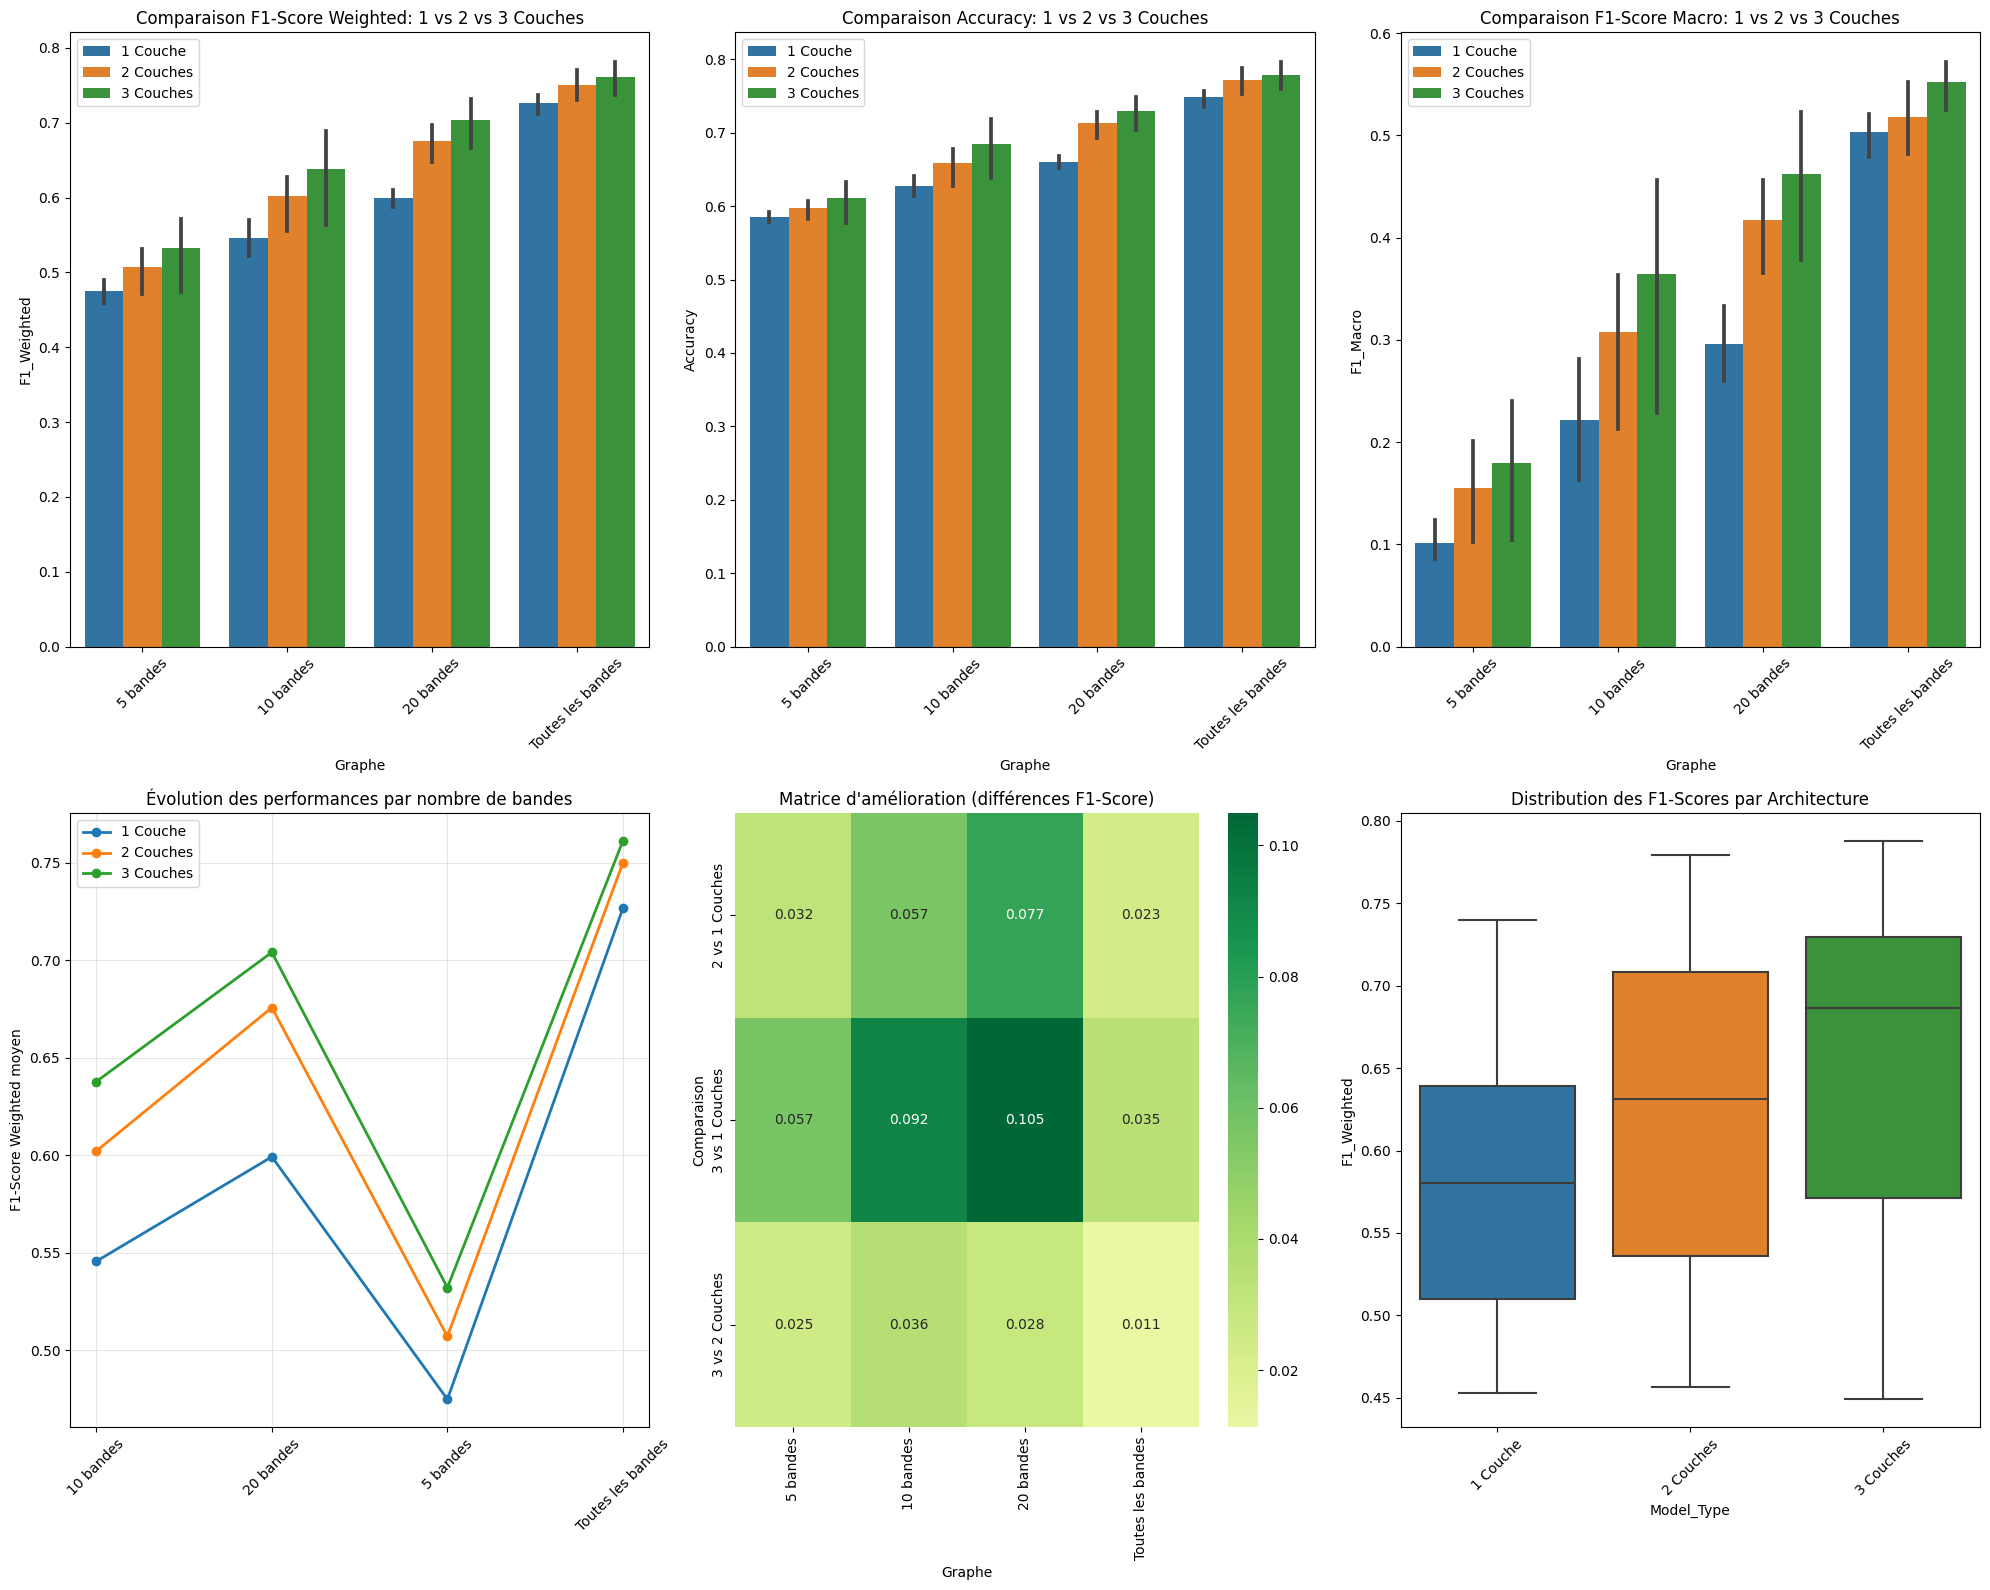


COMPARAISON STATISTIQUE COMPLÈTE: 1 vs 2 vs 3 COUCHES
                             Accuracy         F1_Weighted         F1_Macro  \
                                 mean     std        mean     std     mean   
Model_Type Graphe                                                            
1 Couche   10 bandes           0.6278  0.0158      0.5455  0.0284   0.2221   
           20 bandes           0.6594  0.0097      0.5992  0.0142   0.2962   
           5 bandes            0.5850  0.0073      0.4747  0.0171   0.1013   
           Toutes les bandes   0.7483  0.0128      0.7267  0.0153   0.5031   
2 Couches  10 bandes           0.6582  0.0303      0.6021  0.0469   0.3082   
           20 bandes           0.7128  0.0216      0.6758  0.0312   0.4174   
           5 bandes            0.5971  0.0155      0.5070  0.0352   0.1554   
           Toutes les bandes   0.7721  0.0204      0.7500  0.0255   0.5178   
3 Couches  10 bandes           0.6847  0.0496      0.6378  0.0765   0.3642   
         

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Essayer d'importer DataEdgeAttr si disponible
try:
    from torch_geometric.data.data import DataEdgeAttr
except ImportError:
    print("DataEdgeAttr n'est pas disponible dans cette version de PyTorch Geometric")

# Définir une seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Chemins
dataset_path = "/kaggle/input/gcn-gat-graphsage"
output_path = "/kaggle/working/"

# Définition du modèle GCN avec TROIS couches cachées
class ThreeLayerGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=64):
        super(ThreeLayerGCN, self).__init__()
        # PREMIÈRE couche de convolution de graphe
        self.conv1 = GCNConv(num_features, hidden_channels)
        # DEUXIÈME couche de convolution de graphe
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # TROISIÈME couche de convolution de graphe
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        # Couche de classification
        self.lin = nn.Linear(hidden_channels, num_classes)
    
    def forward(self, x, edge_index, batch=None):
        # Premier passage de convolution de graphe
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Deuxième passage de convolution de graphe
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Troisième passage de convolution de graphe
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Si un batch est fourni (pour les graphes multiples), faire un pooling global
        if batch is not None:
            x = global_mean_pool(x, batch)
        
        # Classification
        x = self.lin(x)
        
        return x

def create_data_splits_config1(data, include_background=True):
    """
    Config 1: Training minimal - 5% train, 5% val, 90% test
    """
    train_percent = 0.05
    val_percent = 0.05
    # test_percent = 0.90 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 1 - Répartition par classe (5% train, 5% val, 90% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))  # Au moins 1 échantillon
        n_val = max(1, int(total_samples * val_percent))      # Au moins 1 échantillon
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = 1
                n_val = 1
                n_test = total_samples - 2
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config2(data, include_background=True):
    """
    Config 2: Training faible - 10% train, 10% val, 80% test
    """
    train_percent = 0.10
    val_percent = 0.10
    # test_percent = 0.80 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 2 - Répartition par classe (10% train, 10% val, 80% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = 1
                n_val = 1
                n_test = total_samples - 2
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config3(data, include_background=True):
    """
    Config 3: Training modéré - 30% train, 20% val, 50% test
    """
    train_percent = 0.30
    val_percent = 0.20
    # test_percent = 0.50 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 3 - Répartition par classe (30% train, 20% val, 50% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = int(total_samples * 0.5)
                n_val = int(total_samples * 0.3)
                n_test = total_samples - n_train - n_val
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config4(data, include_background=True):
    """
    Config 4: Training élevé - 50% train, 20% val, 30% test
    """
    train_percent = 0.50
    val_percent = 0.20
    # test_percent = 0.30 (automatique)
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 4 - Répartition par classe (50% train, 20% val, 30% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        # Calculer les tailles pour chaque ensemble
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        # Vérifier qu'il reste des échantillons pour le test
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = int(total_samples * 0.6)
                n_val = int(total_samples * 0.2)
                n_test = total_samples - n_train - n_val
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        # Sélectionner aléatoirement avec stratification
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def train_three_layer_gcn(graph_path, config_name, split_function, epochs=100, patience=20, 
                         lr=0.01, device='cuda', include_background=True):
    """
    Entraîne un modèle GCN à TROIS couches avec une configuration de division spécifique
    """
    print(f"\n{'='*80}")
    print(f"Évaluation: {os.path.basename(graph_path)} - {config_name}")
    print(f"{'='*80}")
    
    # Charger le graphe
    try:
        data = torch.load(graph_path, weights_only=False)
    except Exception as e1:
        print(f"Erreur de chargement: {e1}")
        try:
            import torch.serialization
            from torch_geometric.data import Data
            try:
                from torch_geometric.data.data import DataEdgeAttr
                torch.serialization.add_safe_globals([Data, DataEdgeAttr])
            except ImportError:
                torch.serialization.add_safe_globals([Data])
            data = torch.load(graph_path, weights_only=False)
        except Exception as e2:
            print(f"Erreur méthode 2: {e2}")
            raise ValueError("Impossible de charger le graphe.")
    
    # Obtenir les informations sur le graphe
    num_features = data.x.shape[1]
    if include_background:
        num_classes = int(data.y.max().item() + 1)
    else:
        num_classes = int(data.y.max().item())
    
    print(f"Nombre de caractéristiques: {num_features}")
    print(f"Nombre de classes: {num_classes}")
    
    # Créer les divisions selon la configuration
    train_indices, val_indices, test_indices = split_function(data, include_background)
    
    # Créer des masques
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Afficher les statistiques de division
    train_size = train_mask.sum().item()
    val_size = val_mask.sum().item()
    test_size = test_mask.sum().item()
    total_size = train_size + val_size + test_size
    
    print(f"\nRépartition des données:")
    print(f"  Entraînement: {train_size} pixels ({train_size/total_size:.1%})")
    print(f"  Validation:   {val_size} pixels ({val_size/total_size:.1%})")
    print(f"  Test:         {test_size} pixels ({test_size/total_size:.1%})")
    
    # Vérifier la distribution des classes
    train_classes = set(data.y[train_mask].numpy())
    val_classes = set(data.y[val_mask].numpy())
    test_classes = set(data.y[test_mask].numpy())
    
    print(f"\nDistribution des classes:")
    print(f"  Classes dans l'entraînement: {len(train_classes)}")
    print(f"  Classes dans la validation: {len(val_classes)}")
    print(f"  Classes dans le test: {len(test_classes)}")
    
    # Initialiser le modèle (TROIS COUCHES)
    model = ThreeLayerGCN(num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, verbose=True
    )
    
    # Boucle d'entraînement
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    
    print("Début de l'entraînement...")
    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x.to(device), data.edge_index.to(device))
        
        # Calcul de la perte d'entraînement
        train_loss = F.cross_entropy(out[train_mask], data.y[train_mask].to(device))
        train_losses.append(train_loss.item())
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Mode évaluation
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
            
            # Calculer la perte de validation
            val_loss = F.cross_entropy(out[val_mask], data.y[val_mask].to(device))
            val_losses.append(val_loss.item())
            
            # Calculer la précision de validation
            pred = out.argmax(dim=1)
            correct = pred[val_mask].cpu() == data.y[val_mask]
            val_acc = float(correct.sum()) / int(val_mask.sum())
            val_accuracies.append(val_acc)
            
            scheduler.step(val_acc)
        
        # Afficher la progression
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        
        # Vérifier l'amélioration
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Arrêt précoce
        if patience_counter >= patience:
            print(f"Arrêt précoce à l'époque {epoch+1}")
            break
    
    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    
    # Évaluation finale sur l'ensemble de test
    model.eval()
    with torch.no_grad():
        logits = model(data.x.to(device), data.edge_index.to(device))
        pred = logits.argmax(dim=1).cpu()
        
        # Métriques d'évaluation
        y_true = data.y[test_mask].numpy()
        y_pred = pred[test_mask].numpy()
        
        # Calculer les métriques
        accuracy = accuracy_score(y_true, y_pred)
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_per_class = f1_score(y_true, y_pred, average=None)
        
        # Créer le rapport de classification détaillé
        report = classification_report(y_true, y_pred, output_dict=True)
        
        # Afficher les résultats
        print(f"\nRésultats finaux sur l'ensemble de test:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (weighted): {f1_weighted:.4f}")
        print(f"F1 Score (macro): {f1_macro:.4f}")
        
        # Préparer les résultats à retourner
        results = {
            'config': config_name,
            'graph': os.path.basename(graph_path),
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'f1_per_class': f1_per_class,
            'report': report,
            'train_size': train_size,
            'val_size': val_size,
            'test_size': test_size,
            'best_val_accuracy': best_val_acc,
            'num_features': num_features
        }
        
        # Sauvegarder le modèle
        model_name = f"three_layer_gcn_{config_name}_{os.path.basename(graph_path).split('.')[0]}.pt"
        model_path = os.path.join(output_path, model_name)
        torch.save(model, model_path)
        print(f"Modèle sauvegardé: {model_name}")
    
    return model, results

def run_all_three_layer_experiments():
    """
    Lance toutes les expérimentations avec GCN 3 couches: 4 configs × 4 graphes = 16 expériences
    """
    # Vérifier si CUDA est disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Utilisation de: {device}")
    
    # Définir les 4 graphes à tester
    graph_paths = [
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_5bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_10bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_allbands.pt")
    ]
    
    # Définir les 4 configurations de division
    configs = [
        {'name': 'Config1_5percent', 'function': create_data_splits_config1, 
         'description': '5% train, 5% val, 90% test'},
        {'name': 'Config2_10percent', 'function': create_data_splits_config2, 
         'description': '10% train, 10% val, 80% test'},
        {'name': 'Config3_30_20percent', 'function': create_data_splits_config3, 
         'description': '30% train, 20% val, 50% test'},
        {'name': 'Config4_50_20percent', 'function': create_data_splits_config4, 
         'description': '50% train, 20% val, 30% test'}
    ]
    
    # Vérifier l'existence des graphes
    existing_graphs = [p for p in graph_paths if os.path.exists(p)]
    
    if not existing_graphs:
        print("Aucun graphe trouvé! Veuillez d'abord exécuter le code de création des graphes.")
        return {}, pd.DataFrame()
    
    print(f"Graphes trouvés: {len(existing_graphs)}")
    for graph in existing_graphs:
        print(f"  - {os.path.basename(graph)}")
    
    # Stocker tous les résultats
    all_results = {}
    experiment_data = []
    
    # Lancer toutes les expérimentations
    for config in configs:
        print(f"\n{'#'*100}")
        print(f"# CONFIGURATION: {config['description']}")
        print(f"{'#'*100}")
        
        for graph_path in existing_graphs:
            try:
                model, results = train_three_layer_gcn(
                    graph_path=graph_path,
                    config_name=config['name'],
                    split_function=config['function'],
                    epochs=100,
                    patience=15,
                    lr=0.01,
                    device=device,
                    include_background=True
                )
                
                # Stocker les résultats
                exp_key = f"{config['name']}_{os.path.basename(graph_path)}"
                all_results[exp_key] = results
                
                # Extraire le nombre de bandes du nom du graphe
                graph_name = os.path.basename(graph_path)
                if "5bands" in graph_name:
                    bands = "5 bandes"
                elif "10bands" in graph_name:
                    bands = "10 bandes"
                elif "20bands" in graph_name:
                    bands = "20 bandes"
                elif "allbands" in graph_name:
                    bands = "Toutes les bandes"
                else:
                    bands = "Inconnu"
                
                # Ajouter aux données d'expérimentation
                experiment_data.append({
                    'Configuration': config['name'],
                    'Description': config['description'],
                    'Graphe': bands,
                    'Nombre_Features': results['num_features'],
                    'Taille_Train': results['train_size'],
                    'Taille_Val': results['val_size'],
                    'Taille_Test': results['test_size'],
                    'Accuracy': results['accuracy'],
                    'F1_Weighted': results['f1_weighted'],
                    'F1_Macro': results['f1_macro'],
                    'Best_Val_Acc': results['best_val_accuracy']
                })
                
            except Exception as e:
                print(f"Erreur pour {graph_path} avec {config['name']}: {e}")
                continue
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(experiment_data)
    
    # Sauvegarder les résultats
    results_df.to_csv(os.path.join(output_path, "three_layer_gcn_experiments.csv"), index=False)
    
    # Afficher le tableau récapitulatif
    print(f"\n{'='*100}")
    print("RÉSULTATS FINAUX - TOUTES LES EXPÉRIMENTATIONS GCN 3 COUCHES")
    print(f"{'='*100}")
    print(results_df.to_string(index=False))
    
    # Créer des visualisations comparatives
    create_three_layer_comparison_plots(results_df)
    
    return all_results, results_df

def create_three_layer_comparison_plots(results_df):
    """
    Crée des graphiques de comparaison des résultats pour le modèle 3 couches
    """
    # Configuration de la figure
    plt.style.use('default')
    
    # 1. Comparaison F1-score par configuration et nombre de bandes
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.barplot(data=results_df, x='Graphe', y='F1_Weighted', hue='Configuration')
    plt.title('F1-Score Weighted par Configuration et Nombre de Bandes (GCN 3 couches)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 2)
    sns.barplot(data=results_df, x='Graphe', y='Accuracy', hue='Configuration')
    plt.title('Accuracy par Configuration et Nombre de Bandes (GCN 3 couches)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 3)
    sns.barplot(data=results_df, x='Configuration', y='F1_Macro', hue='Graphe')
    plt.title('F1-Score Macro par Configuration (GCN 3 couches)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 4)
    # Heatmap des performances
    pivot_table = results_df.pivot(index='Configuration', columns='Graphe', values='F1_Weighted')
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title('Heatmap F1-Score Weighted (GCN 3 couches)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "three_layer_gcn_comparison.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Évolution des performances selon la taille de l'ensemble d'entraînement
    plt.figure(figsize=(12, 8))
    
    for graphe in results_df['Graphe'].unique():
        subset = results_df[results_df['Graphe'] == graphe]
        plt.plot(subset['Taille_Train'], subset['F1_Weighted'], marker='o', label=graphe, linewidth=2)
    
    plt.xlabel('Taille de l\'ensemble d\'entraînement')
    plt.ylabel('F1-Score Weighted')
    plt.title('Évolution des performances selon la taille d\'entraînement (GCN 3 couches)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_path, "three_layer_performance_vs_training_size.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nGraphiques sauvegardés dans {output_path}")

def compare_all_three_architectures():
    """
    Compare les résultats entre les modèles 1, 2 et 3 couches
    """
    # Charger les résultats des trois expérimentations
    try:
        single_layer_df = pd.read_csv(os.path.join(output_path, "single_layer_gcn_experiments.csv"))
        two_layer_df = pd.read_csv(os.path.join(output_path, "two_layer_gcn_experiments.csv"))
        three_layer_df = pd.read_csv(os.path.join(output_path, "three_layer_gcn_experiments.csv"))
        
        # Ajouter une colonne pour identifier le type de modèle
        single_layer_df['Model_Type'] = '1 Couche'
        two_layer_df['Model_Type'] = '2 Couches'
        three_layer_df['Model_Type'] = '3 Couches'
        
        # Combiner les DataFrames
        combined_df = pd.concat([single_layer_df, two_layer_df, three_layer_df], ignore_index=True)
        
        # Créer des graphiques comparatifs complets
        plt.figure(figsize=(20, 16))
        
        # 1. Comparaison F1-Score Weighted
        plt.subplot(2, 3, 1)
        sns.barplot(data=combined_df, x='Graphe', y='F1_Weighted', hue='Model_Type')
        plt.title('Comparaison F1-Score Weighted: 1 vs 2 vs 3 Couches')
        plt.xticks(rotation=45)
        plt.legend()
        
        # 2. Comparaison Accuracy
        plt.subplot(2, 3, 2)
        sns.barplot(data=combined_df, x='Graphe', y='Accuracy', hue='Model_Type')
        plt.title('Comparaison Accuracy: 1 vs 2 vs 3 Couches')
        plt.xticks(rotation=45)
        plt.legend()
        
        # 3. Comparaison F1-Score Macro
        plt.subplot(2, 3, 3)
        sns.barplot(data=combined_df, x='Graphe', y='F1_Macro', hue='Model_Type')
        plt.title('Comparaison F1-Score Macro: 1 vs 2 vs 3 Couches')
        plt.xticks(rotation=45)
        plt.legend()
        
        # 4. Évolution par nombre de bandes
        plt.subplot(2, 3, 4)
        # Calculer les moyennes par architecture et graphe
        avg_performance = combined_df.groupby(['Model_Type', 'Graphe'])['F1_Weighted'].mean().reset_index()
        
        for model_type in avg_performance['Model_Type'].unique():
            subset = avg_performance[avg_performance['Model_Type'] == model_type]
            plt.plot(subset['Graphe'], subset['F1_Weighted'], marker='o', label=model_type, linewidth=2)
        
        plt.title('Évolution des performances par nombre de bandes')
        plt.ylabel('F1-Score Weighted moyen')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 5. Heatmap comparative des améliorations
        plt.subplot(2, 3, 5)
        # Calculer les améliorations par rapport au modèle 1 couche
        improvement_data = []
        
        for graphe in combined_df['Graphe'].unique():
            single_scores = combined_df[(combined_df['Graphe'] == graphe) & (combined_df['Model_Type'] == '1 Couche')]['F1_Weighted']
            two_scores = combined_df[(combined_df['Graphe'] == graphe) & (combined_df['Model_Type'] == '2 Couches')]['F1_Weighted']
            three_scores = combined_df[(combined_df['Graphe'] == graphe) & (combined_df['Model_Type'] == '3 Couches')]['F1_Weighted']
            
            if len(single_scores) > 0 and len(two_scores) > 0 and len(three_scores) > 0:
                baseline = single_scores.mean()
                improvement_data.append({
                    'Graphe': graphe,
                    '2 vs 1 Couches': two_scores.mean() - baseline,
                    '3 vs 1 Couches': three_scores.mean() - baseline,
                    '3 vs 2 Couches': three_scores.mean() - two_scores.mean()
                })
        
        improvement_df = pd.DataFrame(improvement_data)
        improvement_df_plot = improvement_df.set_index('Graphe').T
        sns.heatmap(improvement_df_plot, annot=True, fmt='.3f', cmap='RdYlGn', center=0)
        plt.title('Matrice d\'amélioration (différences F1-Score)')
        plt.ylabel('Comparaison')
        
        # 6. Boxplot des distributions
        plt.subplot(2, 3, 6)
        sns.boxplot(data=combined_df, x='Model_Type', y='F1_Weighted')
        plt.title('Distribution des F1-Scores par Architecture')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "complete_architecture_comparison.png"), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Créer un tableau statistique détaillé
        print("\n" + "="*100)
        print("COMPARAISON STATISTIQUE COMPLÈTE: 1 vs 2 vs 3 COUCHES")
        print("="*100)
        
        # Calculer les moyennes par type de modèle et graphe
        detailed_stats = combined_df.groupby(['Model_Type', 'Graphe']).agg({
            'Accuracy': ['mean', 'std'],
            'F1_Weighted': ['mean', 'std'],
            'F1_Macro': ['mean', 'std']
        }).round(4)
        
        print(detailed_stats)
        
        # Calculer les améliorations moyennes
        print("\n" + "="*80)
        print("AMÉLIORATIONS MOYENNES PAR RAPPORT AU MODÈLE 1 COUCHE")
        print("="*80)
        
        baseline_stats = combined_df[combined_df['Model_Type'] == '1 Couche'].groupby('Graphe')[['Accuracy', 'F1_Weighted', 'F1_Macro']].mean()
        two_layer_stats = combined_df[combined_df['Model_Type'] == '2 Couches'].groupby('Graphe')[['Accuracy', 'F1_Weighted', 'F1_Macro']].mean()
        three_layer_stats = combined_df[combined_df['Model_Type'] == '3 Couches'].groupby('Graphe')[['Accuracy', 'F1_Weighted', 'F1_Macro']].mean()
        
        print("Amélioration 2 Couches vs 1 Couche:")
        improvement_2vs1 = two_layer_stats - baseline_stats
        print(improvement_2vs1)
        
        print("\nAmélioration 3 Couches vs 1 Couche:")
        improvement_3vs1 = three_layer_stats - baseline_stats
        print(improvement_3vs1)
        
        print("\nAmélioration 3 Couches vs 2 Couches:")
        improvement_3vs2 = three_layer_stats - two_layer_stats
        print(improvement_3vs2)
        
        # Test de significativité (t-test simple)
        print("\n" + "="*80)
        print("ANALYSE DE SIGNIFICATIVITÉ")
        print("="*80)
        
        from scipy import stats
        
        for graphe in combined_df['Graphe'].unique():
            single_f1 = combined_df[(combined_df['Graphe'] == graphe) & (combined_df['Model_Type'] == '1 Couche')]['F1_Weighted']
            two_f1 = combined_df[(combined_df['Graphe'] == graphe) & (combined_df['Model_Type'] == '2 Couches')]['F1_Weighted']
            three_f1 = combined_df[(combined_df['Graphe'] == graphe) & (combined_df['Model_Type'] == '3 Couches')]['F1_Weighted']
            
            if len(single_f1) > 1 and len(two_f1) > 1 and len(three_f1) > 1:
                _, p_2vs1 = stats.ttest_rel(two_f1, single_f1)
                _, p_3vs1 = stats.ttest_rel(three_f1, single_f1)
                _, p_3vs2 = stats.ttest_rel(three_f1, two_f1)
                
                print(f"\n{graphe}:")
                print(f"  2 vs 1 Couches: p-value = {p_2vs1:.4f}")
                print(f"  3 vs 1 Couches: p-value = {p_3vs1:.4f}")
                print(f"  3 vs 2 Couches: p-value = {p_3vs2:.4f}")
        
        # Sauvegarder les résultats
        combined_df.to_csv(os.path.join(output_path, "complete_architecture_comparison.csv"), index=False)
        detailed_stats.to_csv(os.path.join(output_path, "detailed_architecture_stats.csv"))
        improvement_df.to_csv(os.path.join(output_path, "architecture_improvements.csv"), index=False)
        
        return combined_df, detailed_stats, improvement_df
        
    except FileNotFoundError as e:
        print(f"Erreur: Impossible de charger les fichiers de comparaison: {e}")
        print("Assurez-vous d'avoir exécuté les expérimentations 1, 2 ET 3 couches.")
        return None, None, None

# Point d'entrée principal
if __name__ == "__main__":
    print("Lancement de toutes les expérimentations GCN à TROIS couches...")
    print("4 configurations × 4 graphes = 16 expériences")
    
    # D'abord exécuter les expérimentations 3 couches
    all_results, results_df = run_all_three_layer_experiments()
    
    print(f"\n{'='*100}")
    print("EXPÉRIMENTATIONS GCN 3 COUCHES TERMINÉES!")
    print(f"Nombre total d'expériences réalisées: {len(results_df)}")
    print("Fichiers générés:")
    print("  - three_layer_gcn_experiments.csv")
    print("  - three_layer_gcn_comparison.png")
    print("  - three_layer_performance_vs_training_size.png")
    print("  - Modèles .pt pour chaque expérience")
    print(f"{'='*100}")
    
    # Ensuite comparer avec tous les résultats précédents
    print("\nLancement de la comparaison complète 1 vs 2 vs 3 couches...")
    combined_df, stats_df, improvements_df = compare_all_three_architectures()
    
    if combined_df is not None:
        print("\nComparaison complète terminée! Fichiers supplémentaires générés:")
        print("  - complete_architecture_comparison.csv")
        print("  - detailed_architecture_stats.csv") 
        print("  - architecture_improvements.csv")
        print("  - complete_architecture_comparison.png")
        
        # Résumé exécutif
        print(f"\n{'='*100}")
        print("RÉSUMÉ EXÉCUTIF - COMPARAISON DES ARCHITECTURES")
        print(f"{'='*100}")
        
        # Trouver la meilleure configuration globale
        best_config = combined_df.loc[combined_df['F1_Weighted'].idxmax()]
        print(f"Meilleure configuration globale:")
        print(f"  - Architecture: {best_config['Model_Type']}")
        print(f"  - Graphe: {best_config['Graphe']}")
        print(f"  - Configuration: {best_config['Description']}")
        print(f"  - F1-Score: {best_config['F1_Weighted']:.4f}")
        print(f"  - Accuracy: {best_config['Accuracy']:.4f}")
        
        # Moyennes par architecture
        arch_means = combined_df.groupby('Model_Type')[['Accuracy', 'F1_Weighted', 'F1_Macro']].mean()
        print(f"\nPerformances moyennes par architecture:")
        print(arch_means.round(4))
        
        print(f"\n{'='*100}")
    else:
        print("Erreur lors de la comparaison. Vérifiez que tous les fichiers de résultats existent.")

### Expérimentation GAT Multi-Architecture avec Mécanisme d'Attention

🚀 Démarrage des expérimentations GAT...
LANCEMENT COMPLET DES EXPÉRIMENTATIONS GAT
3 Architectures × 4 Configurations × 4 Graphes = 48 Expériences

🔥 ÉTAPE 1/3: GAT 1 COUCHE
Utilisation de: cuda
GAT 1 COUCHE - Graphes trouvés: 4

####################################################################################################
# GAT 1 COUCHE - CONFIGURATION: 5% train, 5% val, 90% test
####################################################################################################

Évaluation SingleLayerGAT: indian_pines_graph_d1_4connectivity_5bands.pt - Config1_5percent
Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 5
Nombre de classes: 17
Nombre de têtes d'attention: 6

Config 1 - Répartition par classe (5% train, 5% val, 90% test):
  Classe 0: 10776 total → 538 train, 538 val, 9700 test
  Classe 1: 46 total → 2 train, 2 val, 42 test
  Classe 2: 1428 total → 71 train, 71 val, 1286 test
  Classe 3: 8

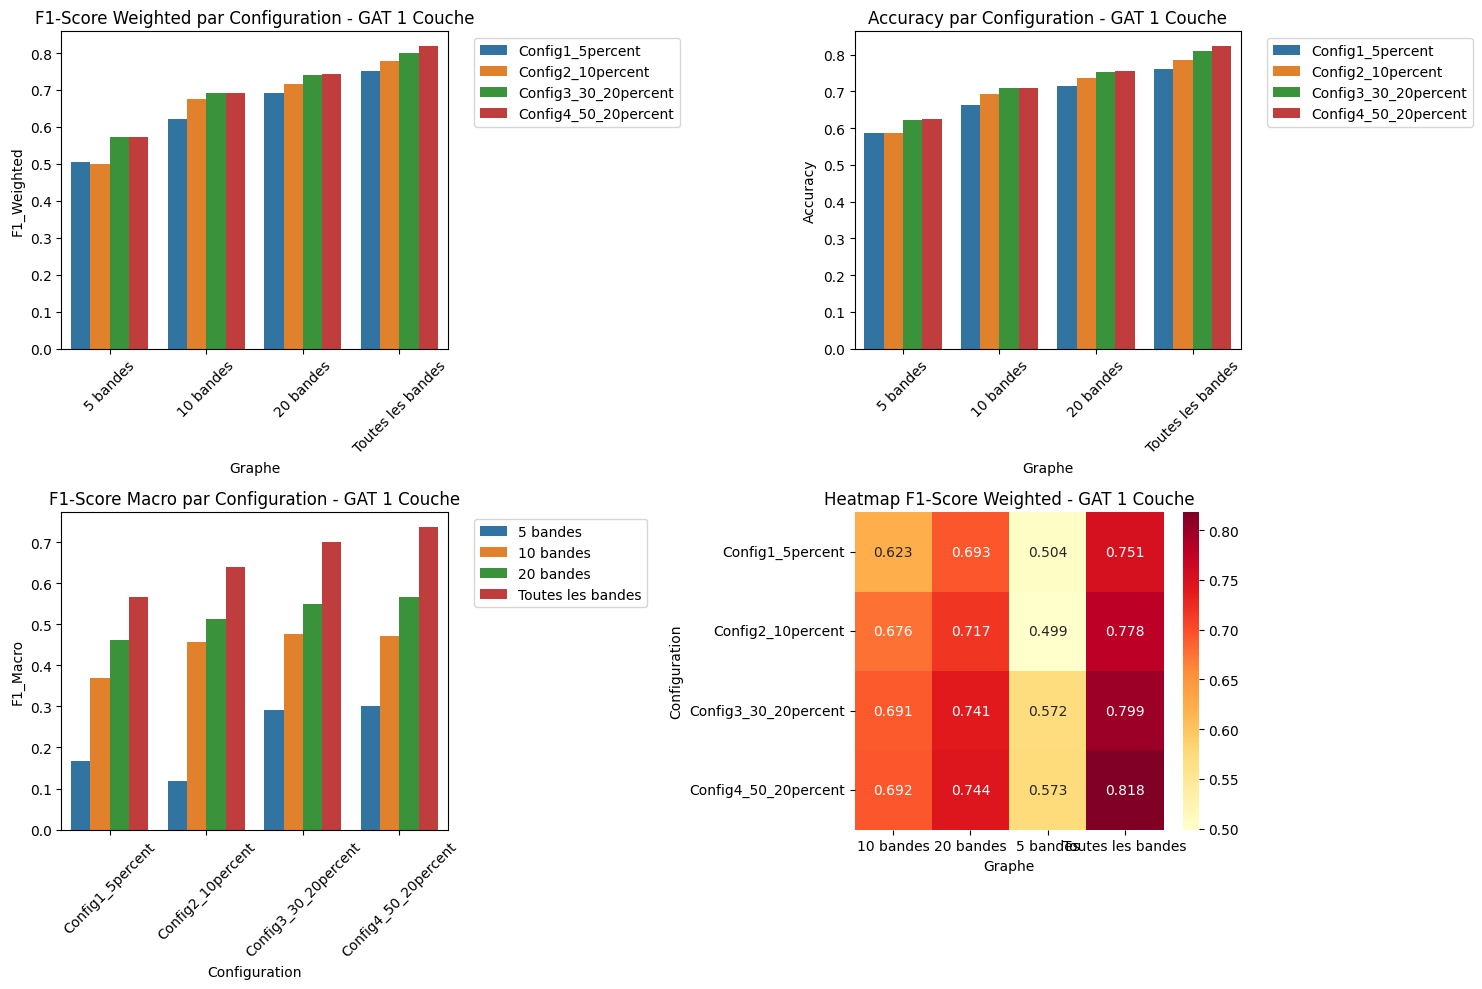

Graphiques sauvegardés: gat_1_couche_comparison.png

🔥 ÉTAPE 2/3: GAT 2 COUCHES
GAT 2 COUCHES - Graphes trouvés: 4

####################################################################################################
# GAT 2 COUCHES - CONFIGURATION: 5% train, 5% val, 90% test
####################################################################################################

Évaluation TwoLayerGAT: indian_pines_graph_d1_4connectivity_5bands.pt - Config1_5percent
Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 5
Nombre de classes: 17
Nombre de têtes d'attention: 6

Config 1 - Répartition par classe (5% train, 5% val, 90% test):
  Classe 0: 10776 total → 538 train, 538 val, 9700 test
  Classe 1: 46 total → 2 train, 2 val, 42 test
  Classe 2: 1428 total → 71 train, 71 val, 1286 test
  Classe 3: 830 total → 41 train, 41 val, 748 test
  Classe 4: 237 total → 11 train, 11 val, 215 test
  Classe 5: 483 total → 24 

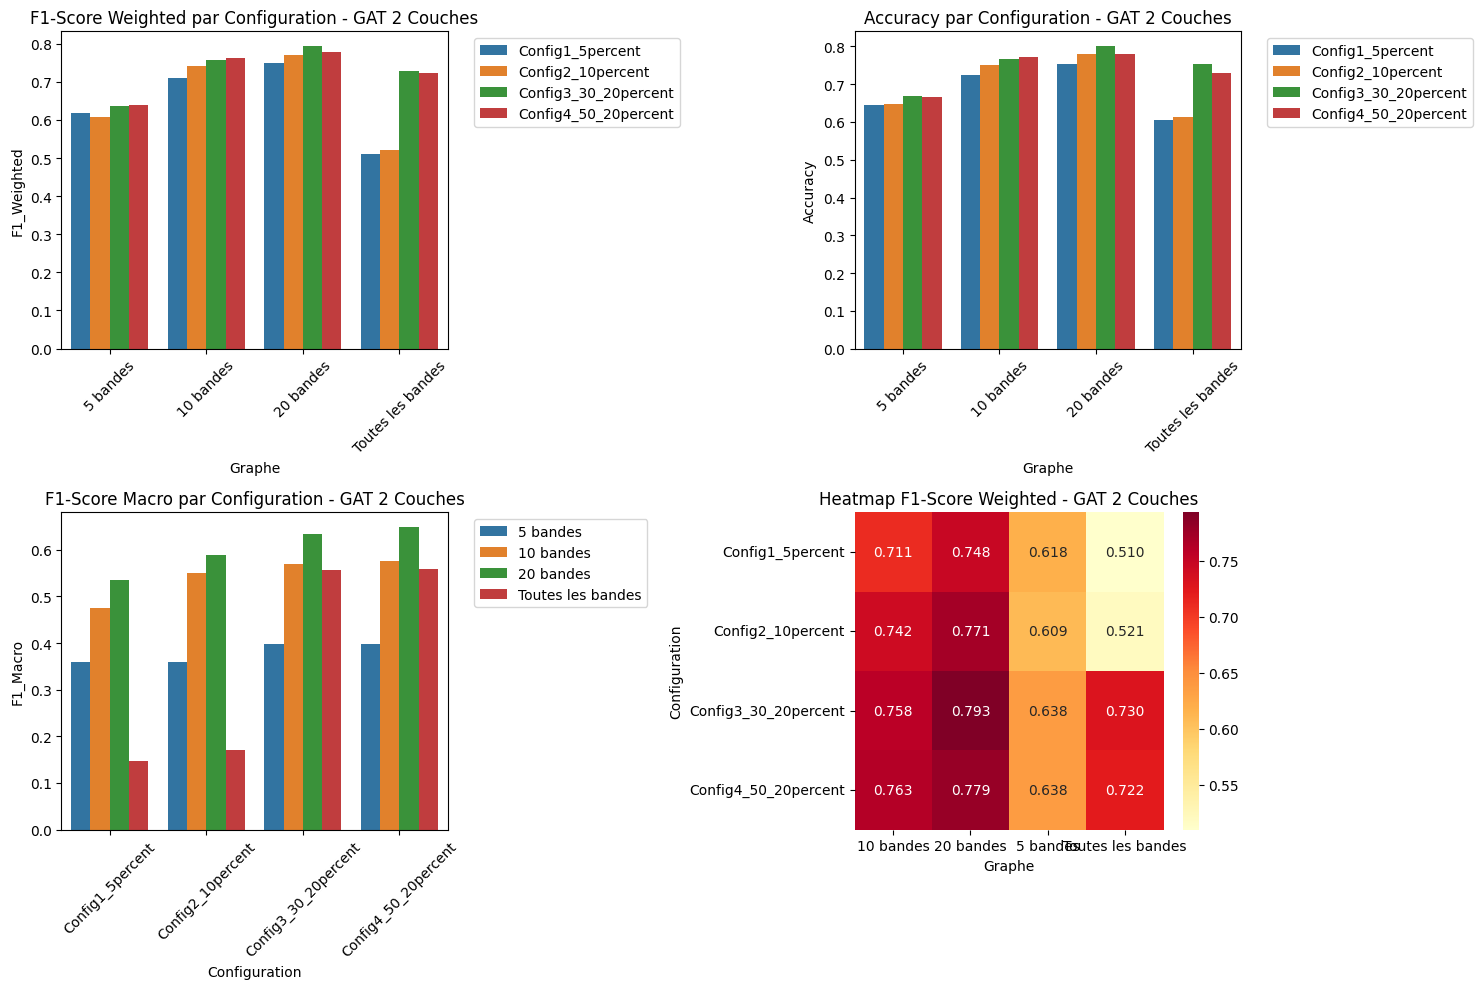

Graphiques sauvegardés: gat_2_couches_comparison.png

🔥 ÉTAPE 3/3: GAT 3 COUCHES
GAT 3 COUCHES - Graphes trouvés: 4

####################################################################################################
# GAT 3 COUCHES - CONFIGURATION: 5% train, 5% val, 90% test
####################################################################################################

Évaluation ThreeLayerGAT: indian_pines_graph_d1_4connectivity_5bands.pt - Config1_5percent
Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 5
Nombre de classes: 17
Nombre de têtes d'attention: 6

Config 1 - Répartition par classe (5% train, 5% val, 90% test):
  Classe 0: 10776 total → 538 train, 538 val, 9700 test
  Classe 1: 46 total → 2 train, 2 val, 42 test
  Classe 2: 1428 total → 71 train, 71 val, 1286 test
  Classe 3: 830 total → 41 train, 41 val, 748 test
  Classe 4: 237 total → 11 train, 11 val, 215 test
  Classe 5: 483 total → 

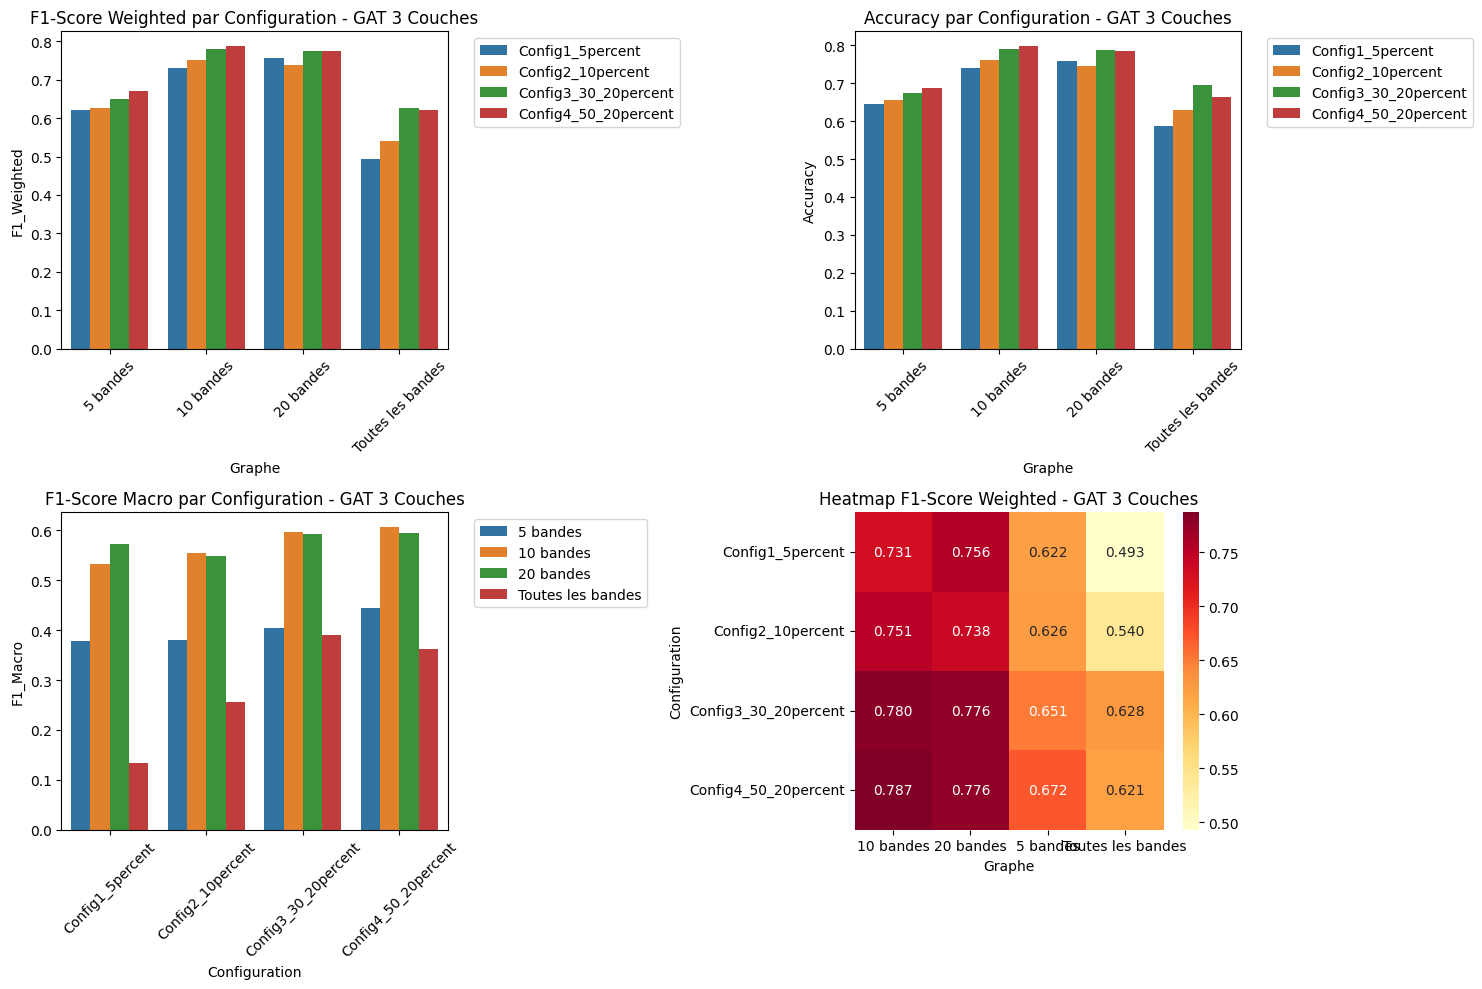

Graphiques sauvegardés: gat_3_couches_comparison.png

🔥 COMPARAISON GAT: 1 vs 2 vs 3 COUCHES


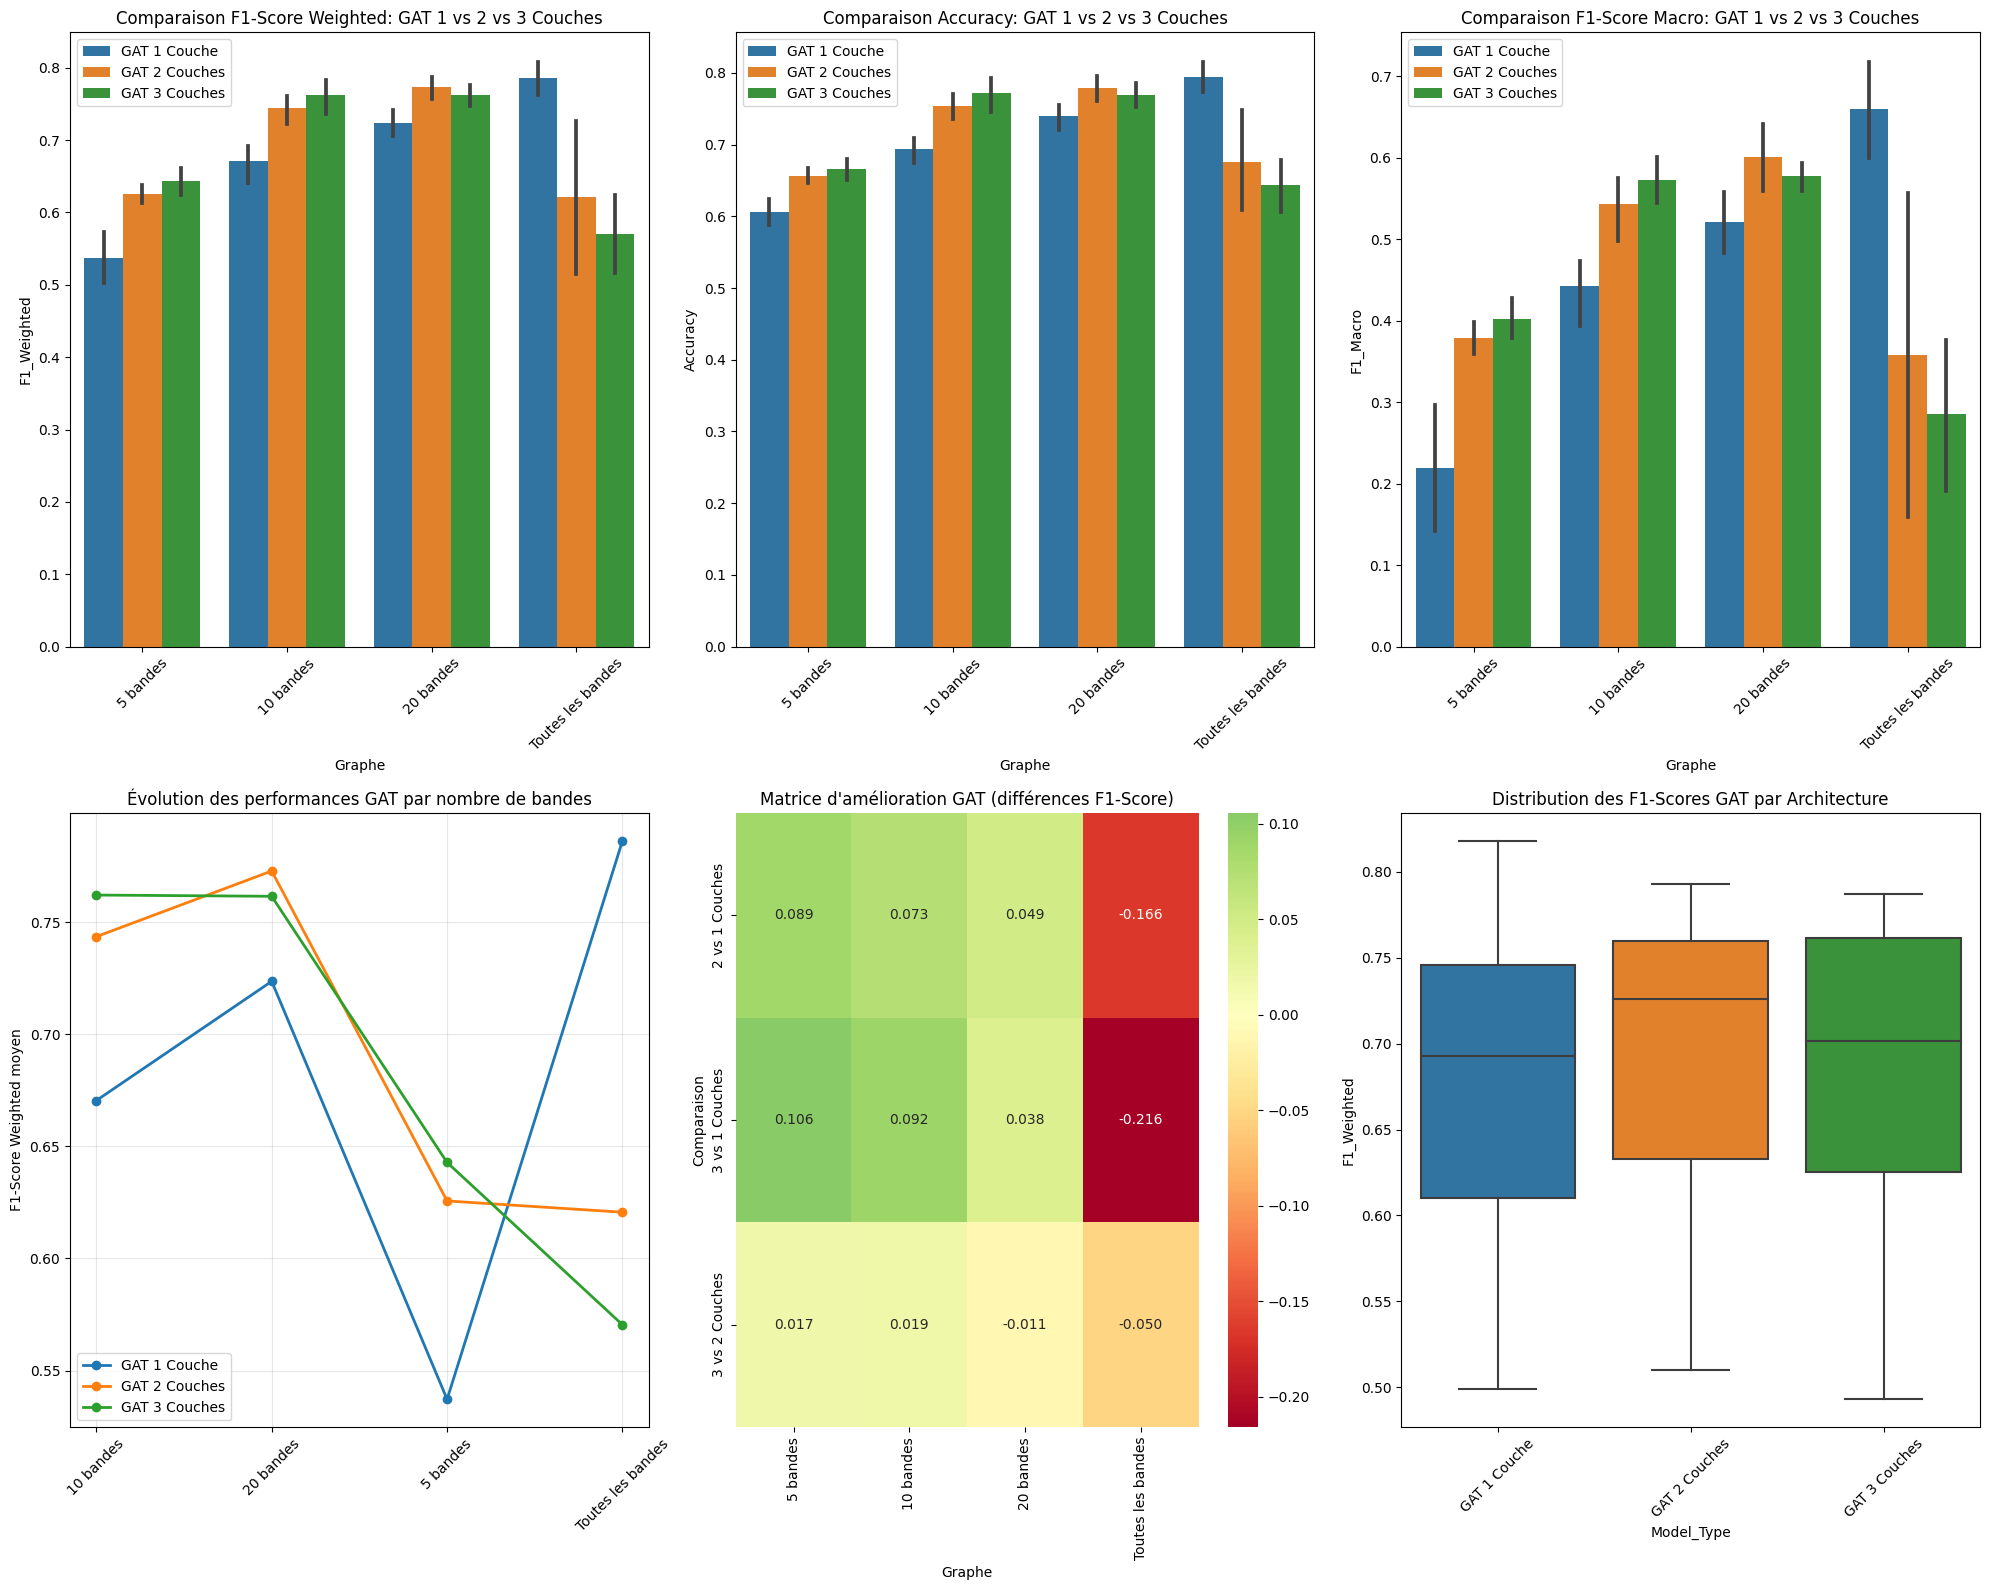


COMPARAISON STATISTIQUE COMPLÈTE GAT: 1 vs 2 vs 3 COUCHES
                                Accuracy         F1_Weighted         F1_Macro  \
                                    mean     std        mean     std     mean   
Model_Type    Graphe                                                            
GAT 1 Couche  10 bandes           0.6934  0.0214      0.6705  0.0329   0.4428   
              20 bandes           0.7400  0.0188      0.7237  0.0236   0.5219   
              5 bandes            0.6055  0.0211      0.5372  0.0409   0.2197   
              Toutes les bandes   0.7945  0.0269      0.7864  0.0288   0.6605   
GAT 2 Couches 10 bandes           0.7542  0.0216      0.7436  0.0236   0.5431   
              20 bandes           0.7788  0.0188      0.7729  0.0187   0.6015   
              5 bandes            0.6568  0.0118      0.6257  0.0146   0.3788   
              Toutes les bandes   0.6756  0.0772      0.6207  0.1215   0.3580   
GAT 3 Couches 10 bandes           0.7721  0.0263  

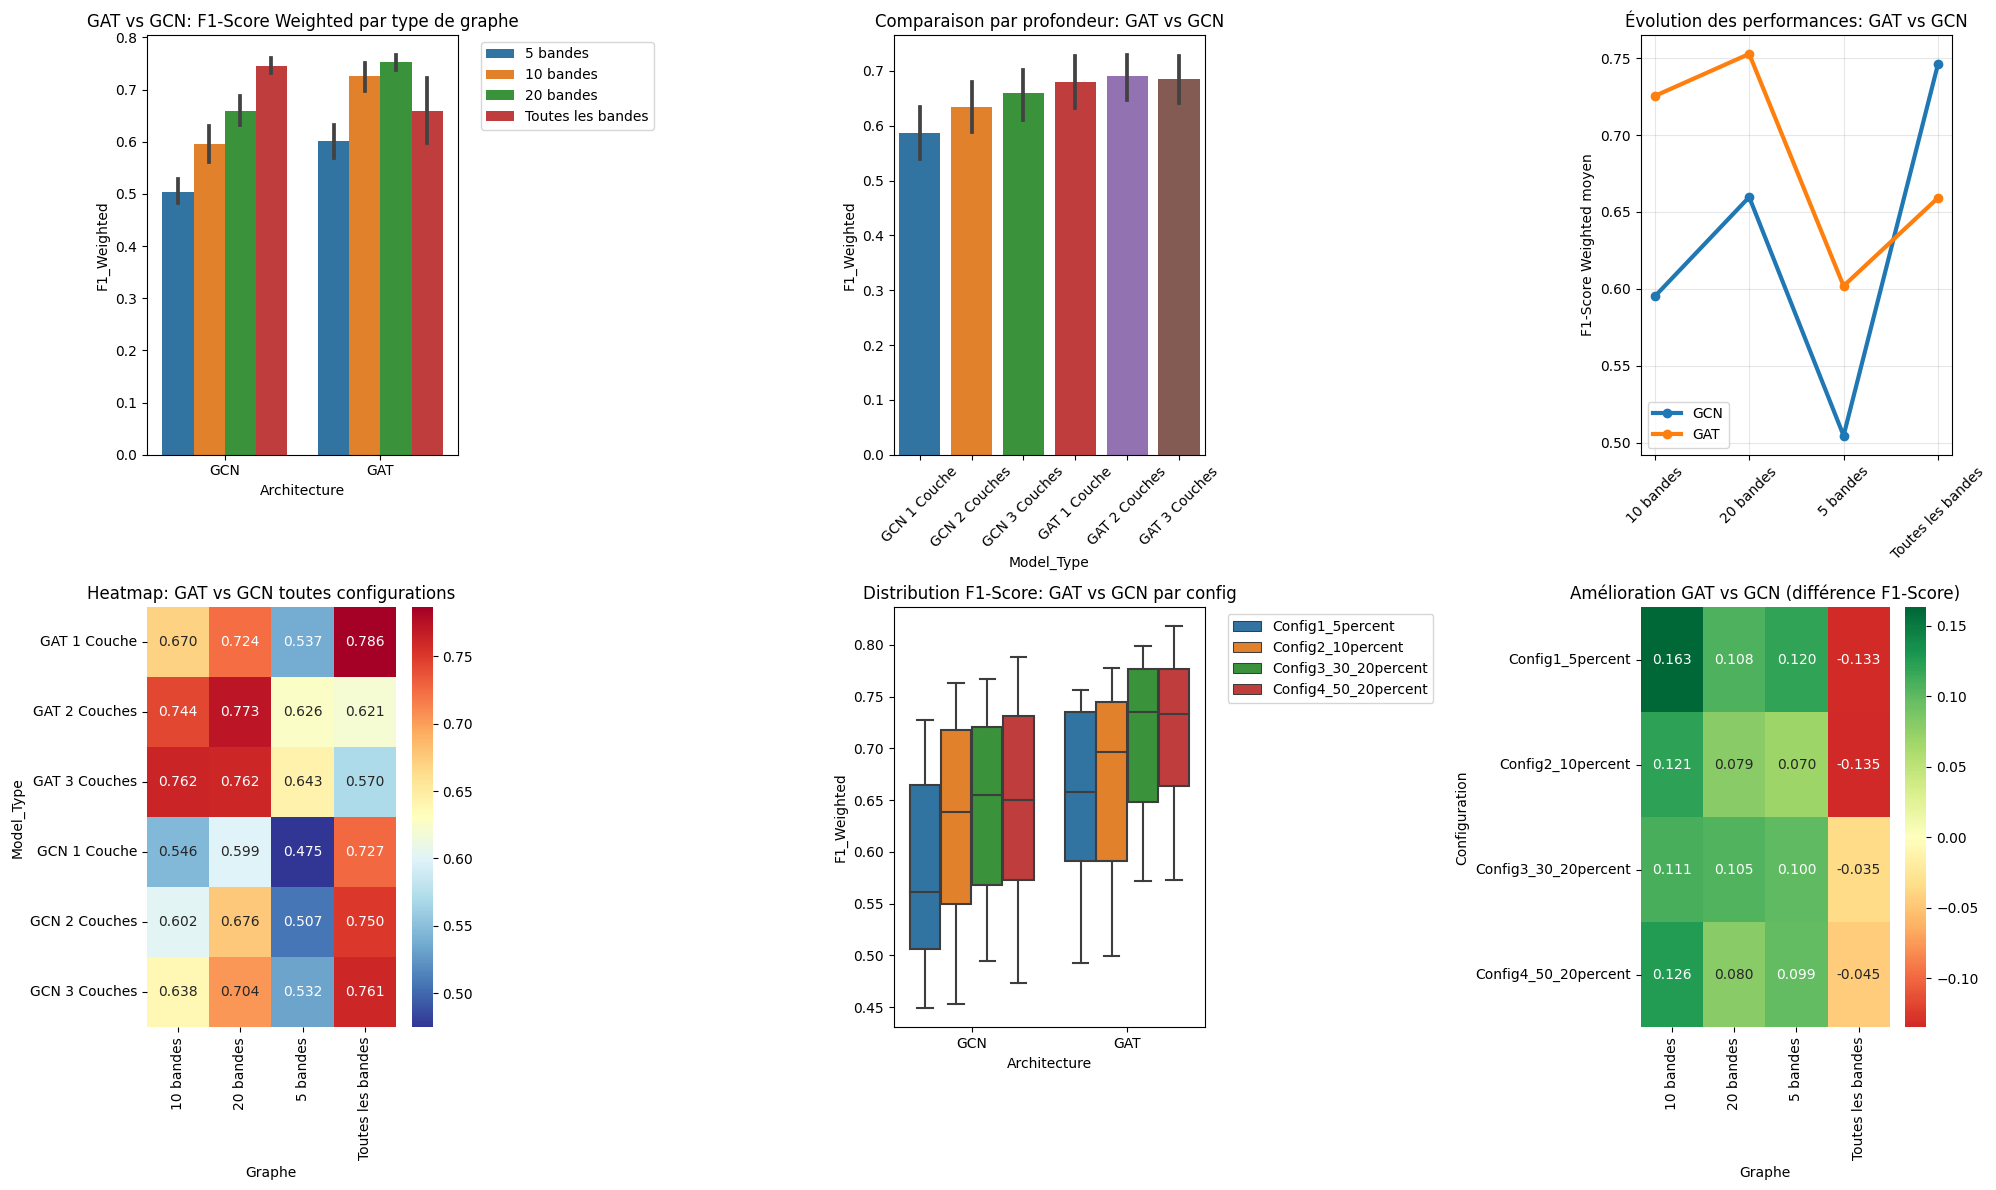


COMPARAISON ULTIME: GAT vs GCN
Performances moyennes par architecture:
              Accuracy  F1_Weighted  F1_Macro
Architecture                                 
GAT             0.7125       0.6848    0.4637
GCN             0.6804       0.6264    0.3400

Meilleure configuration globale:
  - Architecture: GAT
  - Modèle: GAT 1 Couche
  - Graphe: Toutes les bandes
  - Configuration: 50% train, 20% val, 30% test
  - F1-Score: 0.8179

🎉 TOUTES LES EXPÉRIMENTATIONS GAT TERMINÉES!
Fichiers générés:
📊 Résultats GAT:
  - single_layer_gat_experiments.csv
  - two_layer_gat_experiments.csv
  - three_layer_gat_experiments.csv
📈 Comparaisons GAT:
  - complete_gat_architecture_comparison.csv
  - detailed_gat_architecture_stats.csv
  - gat_architecture_improvements.csv
🏆 Comparaison finale:
  - ultimate_gat_gcn_comparison.csv
  - gat_vs_gcn_improvements.csv
🖼️ Visualisations:
  - gat_1_couche_comparison.png
  - gat_2_couches_comparison.png
  - gat_3_couches_comparison.png
  - complete_gat_architect

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Essayer d'importer DataEdgeAttr si disponible
try:
    from torch_geometric.data.data import DataEdgeAttr
except ImportError:
    print("DataEdgeAttr n'est pas disponible dans cette version de PyTorch Geometric")

# Définir une seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Chemins
dataset_path = "/kaggle/input/gcn-gat-graphsage"
output_path = "/kaggle/working/"

def get_num_heads(num_features):
    """
    Détermine le nombre de têtes d'attention selon le nombre de features
    """
    if num_features <= 10:
        return 6
    elif num_features <= 20:
        return 8
    else:  # 200+ features
        return 8

# ======================== MODÈLES GAT ========================

class SingleLayerGAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, heads=8, hidden_channels=64):
        super(SingleLayerGAT, self).__init__()
        # Une seule couche GAT
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=0.5)
        # Couche de classification
        self.lin = nn.Linear(hidden_channels * heads, num_classes)
        
    def forward(self, x, edge_index, batch=None):
        # Passage GAT avec attention
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Si un batch est fourni (pour les graphes multiples), faire un pooling global
        if batch is not None:
            x = global_mean_pool(x, batch)
        
        # Classification
        x = self.lin(x)
        
        return x

class TwoLayerGAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, heads=8, hidden_channels=64):
        super(TwoLayerGAT, self).__init__()
        # PREMIÈRE couche GAT
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=0.5)
        # DEUXIÈME couche GAT
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.5)
        # Couche de classification
        self.lin = nn.Linear(hidden_channels * heads, num_classes)
        
    def forward(self, x, edge_index, batch=None):
        # Premier passage GAT
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Deuxième passage GAT
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Si un batch est fourni (pour les graphes multiples), faire un pooling global
        if batch is not None:
            x = global_mean_pool(x, batch)
        
        # Classification
        x = self.lin(x)
        
        return x

class ThreeLayerGAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, heads=8, hidden_channels=64):
        super(ThreeLayerGAT, self).__init__()
        # PREMIÈRE couche GAT
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=0.5)
        # DEUXIÈME couche GAT
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.5)
        # TROISIÈME couche GAT
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.5)
        # Couche de classification
        self.lin = nn.Linear(hidden_channels * heads, num_classes)
        
    def forward(self, x, edge_index, batch=None):
        # Premier passage GAT
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Deuxième passage GAT
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Troisième passage GAT
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Si un batch est fourni (pour les graphes multiples), faire un pooling global
        if batch is not None:
            x = global_mean_pool(x, batch)
        
        # Classification
        x = self.lin(x)
        
        return x

# ======================== FONCTIONS DE DIVISION DES DONNÉES ========================

def create_data_splits_config1(data, include_background=True):
    """
    Config 1: Training minimal - 5% train, 5% val, 90% test
    """
    train_percent = 0.05
    val_percent = 0.05
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 1 - Répartition par classe (5% train, 5% val, 90% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = 1
                n_val = 1
                n_test = total_samples - 2
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config2(data, include_background=True):
    """
    Config 2: Training faible - 10% train, 10% val, 80% test
    """
    train_percent = 0.10
    val_percent = 0.10
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 2 - Répartition par classe (10% train, 10% val, 80% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = 1
                n_val = 1
                n_test = total_samples - 2
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config3(data, include_background=True):
    """
    Config 3: Training modéré - 30% train, 20% val, 50% test
    """
    train_percent = 0.30
    val_percent = 0.20
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 3 - Répartition par classe (30% train, 20% val, 50% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = int(total_samples * 0.5)
                n_val = int(total_samples * 0.3)
                n_test = total_samples - n_train - n_val
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

def create_data_splits_config4(data, include_background=True):
    """
    Config 4: Training élevé - 50% train, 20% val, 30% test
    """
    train_percent = 0.50
    val_percent = 0.20
    
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    print(f"\nConfig 4 - Répartition par classe (50% train, 20% val, 30% test):")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        if n_test <= 0:
            print(f"  Classe {class_id}: Ajustement nécessaire (seulement {total_samples} échantillons)")
            if total_samples >= 3:
                n_train = int(total_samples * 0.6)
                n_val = int(total_samples * 0.2)
                n_test = total_samples - n_train - n_val
            else:
                n_train = 1
                n_val = 0
                n_test = total_samples - 1
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

# ======================== FONCTION D'ENTRAÎNEMENT GAT ========================

def train_gat_model(graph_path, config_name, split_function, model_class, model_name, 
                    epochs=100, patience=20, lr=0.01, device='cuda', include_background=True):
    """
    Entraîne un modèle GAT avec une configuration de division spécifique
    """
    print(f"\n{'='*80}")
    print(f"Évaluation {model_name}: {os.path.basename(graph_path)} - {config_name}")
    print(f"{'='*80}")
    
    # Charger le graphe
    try:
        data = torch.load(graph_path, weights_only=False)
    except Exception as e1:
        print(f"Erreur de chargement: {e1}")
        try:
            import torch.serialization
            from torch_geometric.data import Data
            try:
                from torch_geometric.data.data import DataEdgeAttr
                torch.serialization.add_safe_globals([Data, DataEdgeAttr])
            except ImportError:
                torch.serialization.add_safe_globals([Data])
            data = torch.load(graph_path, weights_only=False)
        except Exception as e2:
            print(f"Erreur méthode 2: {e2}")
            raise ValueError("Impossible de charger le graphe.")
    
    # Obtenir les informations sur le graphe
    num_features = data.x.shape[1]
    if include_background:
        num_classes = int(data.y.max().item() + 1)
    else:
        num_classes = int(data.y.max().item())
    
    # Déterminer le nombre de têtes selon le nombre de features
    heads = get_num_heads(num_features)
    
    print(f"Nombre de caractéristiques: {num_features}")
    print(f"Nombre de classes: {num_classes}")
    print(f"Nombre de têtes d'attention: {heads}")
    
    # Créer les divisions selon la configuration
    train_indices, val_indices, test_indices = split_function(data, include_background)
    
    # Créer des masques
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Afficher les statistiques de division
    train_size = train_mask.sum().item()
    val_size = val_mask.sum().item()
    test_size = test_mask.sum().item()
    total_size = train_size + val_size + test_size
    
    print(f"\nRépartition des données:")
    print(f"  Entraînement: {train_size} pixels ({train_size/total_size:.1%})")
    print(f"  Validation:   {val_size} pixels ({val_size/total_size:.1%})")
    print(f"  Test:         {test_size} pixels ({test_size/total_size:.1%})")
    
    # Vérifier la distribution des classes
    train_classes = set(data.y[train_mask].numpy())
    val_classes = set(data.y[val_mask].numpy())
    test_classes = set(data.y[test_mask].numpy())
    
    print(f"\nDistribution des classes:")
    print(f"  Classes dans l'entraînement: {len(train_classes)}")
    print(f"  Classes dans la validation: {len(val_classes)}")
    print(f"  Classes dans le test: {len(test_classes)}")
    
    # Initialiser le modèle GAT
    model = model_class(num_features, num_classes, heads=heads).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, verbose=True
    )
    
    # Boucle d'entraînement
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    
    print("Début de l'entraînement...")
    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x.to(device), data.edge_index.to(device))
        
        # Calcul de la perte d'entraînement
        train_loss = F.cross_entropy(out[train_mask], data.y[train_mask].to(device))
        train_losses.append(train_loss.item())
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Mode évaluation
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
            
            # Calculer la perte de validation
            val_loss = F.cross_entropy(out[val_mask], data.y[val_mask].to(device))
            val_losses.append(val_loss.item())
            
            # Calculer la précision de validation
            pred = out.argmax(dim=1)
            correct = pred[val_mask].cpu() == data.y[val_mask]
            val_acc = float(correct.sum()) / int(val_mask.sum())
            val_accuracies.append(val_acc)
            
            scheduler.step(val_acc)
        
        # Afficher la progression
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        
        # Vérifier l'amélioration
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Arrêt précoce
        if patience_counter >= patience:
            print(f"Arrêt précoce à l'époque {epoch+1}")
            break
    
    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    
    # Évaluation finale sur l'ensemble de test
    model.eval()
    with torch.no_grad():
        logits = model(data.x.to(device), data.edge_index.to(device))
        pred = logits.argmax(dim=1).cpu()
        
        # Métriques d'évaluation
        y_true = data.y[test_mask].numpy()
        y_pred = pred[test_mask].numpy()
        
        # Calculer les métriques
        accuracy = accuracy_score(y_true, y_pred)
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_per_class = f1_score(y_true, y_pred, average=None)
        
        # Créer le rapport de classification détaillé
        report = classification_report(y_true, y_pred, output_dict=True)
        
        # Afficher les résultats
        print(f"\nRésultats finaux sur l'ensemble de test:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (weighted): {f1_weighted:.4f}")
        print(f"F1 Score (macro): {f1_macro:.4f}")
        
        # Préparer les résultats à retourner
        results = {
            'config': config_name,
            'graph': os.path.basename(graph_path),
            'model_type': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'f1_per_class': f1_per_class,
            'report': report,
            'train_size': train_size,
            'val_size': val_size,
            'test_size': test_size,
            'best_val_accuracy': best_val_acc,
            'num_features': num_features,
            'num_heads': heads
        }
        
        # Sauvegarder le modèle
        model_filename = f"{model_name.lower()}_{config_name}_{os.path.basename(graph_path).split('.')[0]}.pt"
        model_path = os.path.join(output_path, model_filename)
        torch.save(model, model_path)
        print(f"Modèle sauvegardé: {model_filename}")
    
    return model, results

# ======================== EXPÉRIMENTATIONS GAT ========================

def run_single_layer_gat_experiments():
    """
    Lance toutes les expérimentations avec GAT 1 couche: 4 configs × 4 graphes = 16 expériences
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Utilisation de: {device}")
    
    graph_paths = [
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_5bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_10bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_allbands.pt")
    ]
    
    configs = [
        {'name': 'Config1_5percent', 'function': create_data_splits_config1, 
         'description': '5% train, 5% val, 90% test'},
        {'name': 'Config2_10percent', 'function': create_data_splits_config2, 
         'description': '10% train, 10% val, 80% test'},
        {'name': 'Config3_30_20percent', 'function': create_data_splits_config3, 
         'description': '30% train, 20% val, 50% test'},
        {'name': 'Config4_50_20percent', 'function': create_data_splits_config4, 
         'description': '50% train, 20% val, 30% test'}
    ]
    
    existing_graphs = [p for p in graph_paths if os.path.exists(p)]
    
    if not existing_graphs:
        print("Aucun graphe trouvé!")
        return {}, pd.DataFrame()
    
    print(f"GAT 1 COUCHE - Graphes trouvés: {len(existing_graphs)}")
    
    all_results = {}
    experiment_data = []
    
    for config in configs:
        print(f"\n{'#'*100}")
        print(f"# GAT 1 COUCHE - CONFIGURATION: {config['description']}")
        print(f"{'#'*100}")
        
        for graph_path in existing_graphs:
            try:
                model, results = train_gat_model(
                    graph_path=graph_path,
                    config_name=config['name'],
                    split_function=config['function'],
                    model_class=SingleLayerGAT,
                    model_name="SingleLayerGAT",
                    epochs=100,
                    patience=15,
                    lr=0.01,
                    device=device
                )
                
                exp_key = f"SingleGAT_{config['name']}_{os.path.basename(graph_path)}"
                all_results[exp_key] = results
                
                # Extraire le nombre de bandes
                graph_name = os.path.basename(graph_path)
                if "5bands" in graph_name:
                    bands = "5 bandes"
                elif "10bands" in graph_name:
                    bands = "10 bandes"
                elif "20bands" in graph_name:
                    bands = "20 bandes"
                elif "allbands" in graph_name:
                    bands = "Toutes les bandes"
                else:
                    bands = "Inconnu"
                
                experiment_data.append({
                    'Configuration': config['name'],
                    'Description': config['description'],
                    'Graphe': bands,
                    'Model_Type': 'GAT 1 Couche',
                    'Nombre_Features': results['num_features'],
                    'Nombre_Heads': results['num_heads'],
                    'Taille_Train': results['train_size'],
                    'Taille_Val': results['val_size'],
                    'Taille_Test': results['test_size'],
                    'Accuracy': results['accuracy'],
                    'F1_Weighted': results['f1_weighted'],
                    'F1_Macro': results['f1_macro'],
                    'Best_Val_Acc': results['best_val_accuracy']
                })
                
            except Exception as e:
                print(f"Erreur pour {graph_path} avec {config['name']}: {e}")
                continue
    
    results_df = pd.DataFrame(experiment_data)
    results_df.to_csv(os.path.join(output_path, "single_layer_gat_experiments.csv"), index=False)
    
    print(f"\n{'='*100}")
    print("RÉSULTATS FINAUX - GAT 1 COUCHE")
    print(f"{'='*100}")
    print(results_df.to_string(index=False))
    
    return all_results, results_df

def run_two_layer_gat_experiments():
    """
    Lance toutes les expérimentations avec GAT 2 couches: 4 configs × 4 graphes = 16 expériences
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    graph_paths = [
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_5bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_10bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_allbands.pt")
    ]
    
    configs = [
        {'name': 'Config1_5percent', 'function': create_data_splits_config1, 
         'description': '5% train, 5% val, 90% test'},
        {'name': 'Config2_10percent', 'function': create_data_splits_config2, 
         'description': '10% train, 10% val, 80% test'},
        {'name': 'Config3_30_20percent', 'function': create_data_splits_config3, 
         'description': '30% train, 20% val, 50% test'},
        {'name': 'Config4_50_20percent', 'function': create_data_splits_config4, 
         'description': '50% train, 20% val, 30% test'}
    ]
    
    existing_graphs = [p for p in graph_paths if os.path.exists(p)]
    
    if not existing_graphs:
        print("Aucun graphe trouvé!")
        return {}, pd.DataFrame()
    
    print(f"GAT 2 COUCHES - Graphes trouvés: {len(existing_graphs)}")
    
    all_results = {}
    experiment_data = []
    
    for config in configs:
        print(f"\n{'#'*100}")
        print(f"# GAT 2 COUCHES - CONFIGURATION: {config['description']}")
        print(f"{'#'*100}")
        
        for graph_path in existing_graphs:
            try:
                model, results = train_gat_model(
                    graph_path=graph_path,
                    config_name=config['name'],
                    split_function=config['function'],
                    model_class=TwoLayerGAT,
                    model_name="TwoLayerGAT",
                    epochs=100,
                    patience=15,
                    lr=0.01,
                    device=device
                )
                
                exp_key = f"TwoGAT_{config['name']}_{os.path.basename(graph_path)}"
                all_results[exp_key] = results
                
                # Extraire le nombre de bandes
                graph_name = os.path.basename(graph_path)
                if "5bands" in graph_name:
                    bands = "5 bandes"
                elif "10bands" in graph_name:
                    bands = "10 bandes"
                elif "20bands" in graph_name:
                    bands = "20 bandes"
                elif "allbands" in graph_name:
                    bands = "Toutes les bandes"
                else:
                    bands = "Inconnu"
                
                experiment_data.append({
                    'Configuration': config['name'],
                    'Description': config['description'],
                    'Graphe': bands,
                    'Model_Type': 'GAT 2 Couches',
                    'Nombre_Features': results['num_features'],
                    'Nombre_Heads': results['num_heads'],
                    'Taille_Train': results['train_size'],
                    'Taille_Val': results['val_size'],
                    'Taille_Test': results['test_size'],
                    'Accuracy': results['accuracy'],
                    'F1_Weighted': results['f1_weighted'],
                    'F1_Macro': results['f1_macro'],
                    'Best_Val_Acc': results['best_val_accuracy']
                })
                
            except Exception as e:
                print(f"Erreur pour {graph_path} avec {config['name']}: {e}")
                continue
    
    results_df = pd.DataFrame(experiment_data)
    results_df.to_csv(os.path.join(output_path, "two_layer_gat_experiments.csv"), index=False)
    
    print(f"\n{'='*100}")
    print("RÉSULTATS FINAUX - GAT 2 COUCHES")
    print(f"{'='*100}")
    print(results_df.to_string(index=False))
    
    return all_results, results_df

def run_three_layer_gat_experiments():
    """
    Lance toutes les expérimentations avec GAT 3 couches: 4 configs × 4 graphes = 16 expériences
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    graph_paths = [
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_5bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_10bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_allbands.pt")
    ]
    
    configs = [
        {'name': 'Config1_5percent', 'function': create_data_splits_config1, 
         'description': '5% train, 5% val, 90% test'},
        {'name': 'Config2_10percent', 'function': create_data_splits_config2, 
         'description': '10% train, 10% val, 80% test'},
        {'name': 'Config3_30_20percent', 'function': create_data_splits_config3, 
         'description': '30% train, 20% val, 50% test'},
        {'name': 'Config4_50_20percent', 'function': create_data_splits_config4, 
         'description': '50% train, 20% val, 30% test'}
    ]
    
    existing_graphs = [p for p in graph_paths if os.path.exists(p)]
    
    if not existing_graphs:
        print("Aucun graphe trouvé!")
        return {}, pd.DataFrame()
    
    print(f"GAT 3 COUCHES - Graphes trouvés: {len(existing_graphs)}")
    
    all_results = {}
    experiment_data = []
    
    for config in configs:
        print(f"\n{'#'*100}")
        print(f"# GAT 3 COUCHES - CONFIGURATION: {config['description']}")
        print(f"{'#'*100}")
        
        for graph_path in existing_graphs:
            try:
                model, results = train_gat_model(
                    graph_path=graph_path,
                    config_name=config['name'],
                    split_function=config['function'],
                    model_class=ThreeLayerGAT,
                    model_name="ThreeLayerGAT",
                    epochs=100,
                    patience=15,
                    lr=0.01,
                    device=device
                )
                
                exp_key = f"ThreeGAT_{config['name']}_{os.path.basename(graph_path)}"
                all_results[exp_key] = results
                
                # Extraire le nombre de bandes
                graph_name = os.path.basename(graph_path)
                if "5bands" in graph_name:
                    bands = "5 bandes"
                elif "10bands" in graph_name:
                    bands = "10 bandes"
                elif "20bands" in graph_name:
                    bands = "20 bandes"
                elif "allbands" in graph_name:
                    bands = "Toutes les bandes"
                else:
                    bands = "Inconnu"
                
                experiment_data.append({
                    'Configuration': config['name'],
                    'Description': config['description'],
                    'Graphe': bands,
                    'Model_Type': 'GAT 3 Couches',
                    'Nombre_Features': results['num_features'],
                    'Nombre_Heads': results['num_heads'],
                    'Taille_Train': results['train_size'],
                    'Taille_Val': results['val_size'],
                    'Taille_Test': results['test_size'],
                    'Accuracy': results['accuracy'],
                    'F1_Weighted': results['f1_weighted'],
                    'F1_Macro': results['f1_macro'],
                    'Best_Val_Acc': results['best_val_accuracy']
                })
                
            except Exception as e:
                print(f"Erreur pour {graph_path} avec {config['name']}: {e}")
                continue
    
    results_df = pd.DataFrame(experiment_data)
    results_df.to_csv(os.path.join(output_path, "three_layer_gat_experiments.csv"), index=False)
    
    print(f"\n{'='*100}")
    print("RÉSULTATS FINAUX - GAT 3 COUCHES")
    print(f"{'='*100}")
    print(results_df.to_string(index=False))
    
    return all_results, results_df

# ======================== VISUALISATIONS ET COMPARAISONS ========================

def create_gat_comparison_plots(results_df, model_type):
    """
    Crée des graphiques de comparaison des résultats GAT
    """
    plt.style.use('default')
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.barplot(data=results_df, x='Graphe', y='F1_Weighted', hue='Configuration')
    plt.title(f'F1-Score Weighted par Configuration - {model_type}')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 2)
    sns.barplot(data=results_df, x='Graphe', y='Accuracy', hue='Configuration')
    plt.title(f'Accuracy par Configuration - {model_type}')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 3)
    sns.barplot(data=results_df, x='Configuration', y='F1_Macro', hue='Graphe')
    plt.title(f'F1-Score Macro par Configuration - {model_type}')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(2, 2, 4)
    # Heatmap des performances
    pivot_table = results_df.pivot(index='Configuration', columns='Graphe', values='F1_Weighted')
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title(f'Heatmap F1-Score Weighted - {model_type}')
    
    plt.tight_layout()
    filename = f"{model_type.lower().replace(' ', '_')}_comparison.png"
    plt.savefig(os.path.join(output_path, filename), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Graphiques sauvegardés: {filename}")

def compare_all_gat_architectures():
    """
    Compare les résultats entre les modèles GAT 1, 2 et 3 couches
    """
    try:
        single_gat_df = pd.read_csv(os.path.join(output_path, "single_layer_gat_experiments.csv"))
        two_gat_df = pd.read_csv(os.path.join(output_path, "two_layer_gat_experiments.csv"))
        three_gat_df = pd.read_csv(os.path.join(output_path, "three_layer_gat_experiments.csv"))
        
        # Combiner les DataFrames
        combined_gat_df = pd.concat([single_gat_df, two_gat_df, three_gat_df], ignore_index=True)
        
        # Créer des graphiques comparatifs
        plt.figure(figsize=(20, 16))
        
        # 1. Comparaison F1-Score Weighted
        plt.subplot(2, 3, 1)
        sns.barplot(data=combined_gat_df, x='Graphe', y='F1_Weighted', hue='Model_Type')
        plt.title('Comparaison F1-Score Weighted: GAT 1 vs 2 vs 3 Couches')
        plt.xticks(rotation=45)
        plt.legend()
        
        # 2. Comparaison Accuracy
        plt.subplot(2, 3, 2)
        sns.barplot(data=combined_gat_df, x='Graphe', y='Accuracy', hue='Model_Type')
        plt.title('Comparaison Accuracy: GAT 1 vs 2 vs 3 Couches')
        plt.xticks(rotation=45)
        plt.legend()
        
        # 3. Comparaison F1-Score Macro
        plt.subplot(2, 3, 3)
        sns.barplot(data=combined_gat_df, x='Graphe', y='F1_Macro', hue='Model_Type')
        plt.title('Comparaison F1-Score Macro: GAT 1 vs 2 vs 3 Couches')
        plt.xticks(rotation=45)
        plt.legend()
        
        # 4. Évolution par nombre de bandes
        plt.subplot(2, 3, 4)
        avg_performance = combined_gat_df.groupby(['Model_Type', 'Graphe'])['F1_Weighted'].mean().reset_index()
        
        for model_type in avg_performance['Model_Type'].unique():
            subset = avg_performance[avg_performance['Model_Type'] == model_type]
            plt.plot(subset['Graphe'], subset['F1_Weighted'], marker='o', label=model_type, linewidth=2)
        
        plt.title('Évolution des performances GAT par nombre de bandes')
        plt.ylabel('F1-Score Weighted moyen')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 5. Heatmap des améliorations
        plt.subplot(2, 3, 5)
        improvement_data = []
        
        for graphe in combined_gat_df['Graphe'].unique():
            single_scores = combined_gat_df[(combined_gat_df['Graphe'] == graphe) & (combined_gat_df['Model_Type'] == 'GAT 1 Couche')]['F1_Weighted']
            two_scores = combined_gat_df[(combined_gat_df['Graphe'] == graphe) & (combined_gat_df['Model_Type'] == 'GAT 2 Couches')]['F1_Weighted']
            three_scores = combined_gat_df[(combined_gat_df['Graphe'] == graphe) & (combined_gat_df['Model_Type'] == 'GAT 3 Couches')]['F1_Weighted']
            
            if len(single_scores) > 0 and len(two_scores) > 0 and len(three_scores) > 0:
                baseline = single_scores.mean()
                improvement_data.append({
                    'Graphe': graphe,
                    '2 vs 1 Couches': two_scores.mean() - baseline,
                    '3 vs 1 Couches': three_scores.mean() - baseline,
                    '3 vs 2 Couches': three_scores.mean() - two_scores.mean()
                })
        
        improvement_df = pd.DataFrame(improvement_data)
        improvement_df_plot = improvement_df.set_index('Graphe').T
        sns.heatmap(improvement_df_plot, annot=True, fmt='.3f', cmap='RdYlGn', center=0)
        plt.title('Matrice d\'amélioration GAT (différences F1-Score)')
        plt.ylabel('Comparaison')
        
        # 6. Boxplot des distributions
        plt.subplot(2, 3, 6)
        sns.boxplot(data=combined_gat_df, x='Model_Type', y='F1_Weighted')
        plt.title('Distribution des F1-Scores GAT par Architecture')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "complete_gat_architecture_comparison.png"), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Statistiques détaillées
        print("\n" + "="*100)
        print("COMPARAISON STATISTIQUE COMPLÈTE GAT: 1 vs 2 vs 3 COUCHES")
        print("="*100)
        
        detailed_stats = combined_gat_df.groupby(['Model_Type', 'Graphe']).agg({
            'Accuracy': ['mean', 'std'],
            'F1_Weighted': ['mean', 'std'],
            'F1_Macro': ['mean', 'std']
        }).round(4)
        
        print(detailed_stats)
        
        # Sauvegarder les résultats
        combined_gat_df.to_csv(os.path.join(output_path, "complete_gat_architecture_comparison.csv"), index=False)
        detailed_stats.to_csv(os.path.join(output_path, "detailed_gat_architecture_stats.csv"))
        improvement_df.to_csv(os.path.join(output_path, "gat_architecture_improvements.csv"), index=False)
        
        return combined_gat_df, detailed_stats, improvement_df
        
    except FileNotFoundError as e:
        print(f"Erreur: Impossible de charger les fichiers GAT: {e}")
        return None, None, None

def compare_gat_vs_gcn():
    """
    Compare les performances entre GAT et GCN
    """
    try:
        # Charger les résultats GCN
        single_gcn_df = pd.read_csv(os.path.join(output_path, "single_layer_gcn_experiments.csv"))
        two_gcn_df = pd.read_csv(os.path.join(output_path, "two_layer_gcn_experiments.csv"))
        three_gcn_df = pd.read_csv(os.path.join(output_path, "three_layer_gcn_experiments.csv"))
        
        # Charger les résultats GAT
        single_gat_df = pd.read_csv(os.path.join(output_path, "single_layer_gat_experiments.csv"))
        two_gat_df = pd.read_csv(os.path.join(output_path, "two_layer_gat_experiments.csv"))
        three_gat_df = pd.read_csv(os.path.join(output_path, "three_layer_gat_experiments.csv"))
        
        # Ajouter les identifiants d'architecture
        single_gcn_df['Architecture'] = 'GCN'
        two_gcn_df['Architecture'] = 'GCN'
        three_gcn_df['Architecture'] = 'GCN'
        single_gcn_df['Model_Type'] = 'GCN 1 Couche'
        two_gcn_df['Model_Type'] = 'GCN 2 Couches'
        three_gcn_df['Model_Type'] = 'GCN 3 Couches'
        
        single_gat_df['Architecture'] = 'GAT'
        two_gat_df['Architecture'] = 'GAT'
        three_gat_df['Architecture'] = 'GAT'
        
        # Combiner tous les résultats
        all_results = pd.concat([
            single_gcn_df, two_gcn_df, three_gcn_df,
            single_gat_df, two_gat_df, three_gat_df
        ], ignore_index=True)
        
        # Créer des graphiques comparatifs GAT vs GCN
        plt.figure(figsize=(20, 12))
        
        # 1. Comparaison par architecture
        plt.subplot(2, 3, 1)
        sns.barplot(data=all_results, x='Architecture', y='F1_Weighted', hue='Graphe')
        plt.title('GAT vs GCN: F1-Score Weighted par type de graphe')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 2. Comparaison par profondeur
        plt.subplot(2, 3, 2)
        sns.barplot(data=all_results, x='Model_Type', y='F1_Weighted')
        plt.title('Comparaison par profondeur: GAT vs GCN')
        plt.xticks(rotation=45)
        
        # 3. Évolution selon les bandes spectrales
        plt.subplot(2, 3, 3)
        avg_by_arch = all_results.groupby(['Architecture', 'Graphe'])['F1_Weighted'].mean().reset_index()
        
        for arch in ['GCN', 'GAT']:
            subset = avg_by_arch[avg_by_arch['Architecture'] == arch]
            plt.plot(subset['Graphe'], subset['F1_Weighted'], marker='o', label=arch, linewidth=3)
        
        plt.title('Évolution des performances: GAT vs GCN')
        plt.ylabel('F1-Score Weighted moyen')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Heatmap comparative
        plt.subplot(2, 3, 4)
        pivot_comparison = all_results.pivot_table(
            index='Model_Type', 
            columns='Graphe', 
            values='F1_Weighted', 
            aggfunc='mean'
        )
        sns.heatmap(pivot_comparison, annot=True, fmt='.3f', cmap='RdYlBu_r')
        plt.title('Heatmap: GAT vs GCN toutes configurations')
        
        # 5. Distribution des performances
        plt.subplot(2, 3, 5)
        sns.boxplot(data=all_results, x='Architecture', y='F1_Weighted', hue='Configuration')
        plt.title('Distribution F1-Score: GAT vs GCN par config')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 6. Amélioration GAT vs GCN
        plt.subplot(2, 3, 6)
        improvement_gat_gcn = []
        
        for graphe in all_results['Graphe'].unique():
            for config in all_results['Configuration'].unique():
                gcn_score = all_results[
                    (all_results['Graphe'] == graphe) & 
                    (all_results['Configuration'] == config) &
                    (all_results['Architecture'] == 'GCN')
                ]['F1_Weighted'].mean()
                
                gat_score = all_results[
                    (all_results['Graphe'] == graphe) & 
                    (all_results['Configuration'] == config) &
                    (all_results['Architecture'] == 'GAT')
                ]['F1_Weighted'].mean()
                
                if not pd.isna(gcn_score) and not pd.isna(gat_score):
                    improvement_gat_gcn.append({
                        'Graphe': graphe,
                        'Configuration': config,
                        'Amélioration_GAT': gat_score - gcn_score
                    })
        
        improvement_df = pd.DataFrame(improvement_gat_gcn)
        pivot_improvement = improvement_df.pivot(index='Configuration', columns='Graphe', values='Amélioration_GAT')
        sns.heatmap(pivot_improvement, annot=True, fmt='.3f', cmap='RdYlGn', center=0)
        plt.title('Amélioration GAT vs GCN (différence F1-Score)')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "ultimate_gat_vs_gcn_comparison.png"), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Résumé statistique
        print("\n" + "="*100)
        print("COMPARAISON ULTIME: GAT vs GCN")
        print("="*100)
        
        # Moyennes par architecture
        arch_means = all_results.groupby('Architecture')[['Accuracy', 'F1_Weighted', 'F1_Macro']].mean()
        print("Performances moyennes par architecture:")
        print(arch_means.round(4))
        
        # Meilleure configuration globale
        best_overall = all_results.loc[all_results['F1_Weighted'].idxmax()]
        print(f"\nMeilleure configuration globale:")
        print(f"  - Architecture: {best_overall['Architecture']}")
        print(f"  - Modèle: {best_overall['Model_Type']}")
        print(f"  - Graphe: {best_overall['Graphe']}")
        print(f"  - Configuration: {best_overall['Description']}")
        print(f"  - F1-Score: {best_overall['F1_Weighted']:.4f}")
        
        # Sauvegarder les résultats finaux
        all_results.to_csv(os.path.join(output_path, "ultimate_gat_gcn_comparison.csv"), index=False)
        improvement_df.to_csv(os.path.join(output_path, "gat_vs_gcn_improvements.csv"), index=False)
        
        return all_results, arch_means, improvement_df
        
    except FileNotFoundError as e:
        print(f"Erreur: Impossible de charger les fichiers pour la comparaison: {e}")
        return None, None, None

# ======================== POINT D'ENTRÉE PRINCIPAL ========================

def run_all_gat_experiments():
    """
    Lance toutes les expérimentations GAT: 1, 2, et 3 couches
    Total: 48 expériences (3 architectures × 4 configs × 4 graphes)
    """
    print("=" * 120)
    print("LANCEMENT COMPLET DES EXPÉRIMENTATIONS GAT")
    print("3 Architectures × 4 Configurations × 4 Graphes = 48 Expériences")
    print("=" * 120)
    
    # Étape 1: GAT 1 Couche
    print("\n🔥 ÉTAPE 1/3: GAT 1 COUCHE")
    single_results, single_df = run_single_layer_gat_experiments()
    if not single_df.empty:
        create_gat_comparison_plots(single_df, "GAT 1 Couche")
    
    # Étape 2: GAT 2 Couches
    print("\n🔥 ÉTAPE 2/3: GAT 2 COUCHES")
    two_results, two_df = run_two_layer_gat_experiments()
    if not two_df.empty:
        create_gat_comparison_plots(two_df, "GAT 2 Couches")
    
    # Étape 3: GAT 3 Couches
    print("\n🔥 ÉTAPE 3/3: GAT 3 COUCHES")
    three_results, three_df = run_three_layer_gat_experiments()
    if not three_df.empty:
        create_gat_comparison_plots(three_df, "GAT 3 Couches")
    
    # Comparaison GAT inter-architectures
    print("\n🔥 COMPARAISON GAT: 1 vs 2 vs 3 COUCHES")
    gat_combined, gat_stats, gat_improvements = compare_all_gat_architectures()
    
    # Comparaison finale GAT vs GCN
    print("\n🔥 COMPARAISON ULTIME: GAT vs GCN")
    final_comparison, final_stats, final_improvements = compare_gat_vs_gcn()
    
    # Résumé final
    print("\n" + "=" * 120)
    print("🎉 TOUTES LES EXPÉRIMENTATIONS GAT TERMINÉES!")
    print("=" * 120)
    print("Fichiers générés:")
    print("📊 Résultats GAT:")
    print("  - single_layer_gat_experiments.csv")
    print("  - two_layer_gat_experiments.csv") 
    print("  - three_layer_gat_experiments.csv")
    print("📈 Comparaisons GAT:")
    print("  - complete_gat_architecture_comparison.csv")
    print("  - detailed_gat_architecture_stats.csv")
    print("  - gat_architecture_improvements.csv")
    print("🏆 Comparaison finale:")
    print("  - ultimate_gat_gcn_comparison.csv")
    print("  - gat_vs_gcn_improvements.csv")
    print("🖼️ Visualisations:")
    print("  - gat_1_couche_comparison.png")
    print("  - gat_2_couches_comparison.png")
    print("  - gat_3_couches_comparison.png")
    print("  - complete_gat_architecture_comparison.png")
    print("  - ultimate_gat_vs_gcn_comparison.png")
    print("=" * 120)
    
    return {
        'single_gat': (single_results, single_df),
        'two_gat': (two_results, two_df),
        'three_gat': (three_results, three_df),
        'gat_comparison': (gat_combined, gat_stats, gat_improvements),
        'final_comparison': (final_comparison, final_stats, final_improvements)
    }

# Point d'entrée
if __name__ == "__main__":
    print("🚀 Démarrage des expérimentations GAT...")
    all_experiments = run_all_gat_experiments()
    print("✅ Toutes les expérimentations terminées avec succès!")

### Expérimentation GraphSAGE 1 Couche

🚀 LANCEMENT DES EXPÉRIMENTATIONS GRAPHSAGE 1 COUCHE OPTIMISÉES
📋 CONFIGURATION:
   - Architecture: GraphSAGE 1 Couche (Ultra-rapide)
   - Échantillonnage: [25]
   - Graphes: 20 bandes + Toutes les bandes
   - Configurations: 4 divisions de données
   - Total expériences: 8
   - Device: CUDA
   - Avantages: ~3x plus rapide, moins de paramètres, moins de surapprentissage
🚀 EXPÉRIMENTATIONS GRAPHSAGE 1 COUCHE OPTIMISÉES
📊 2 Graphes (20 bandes + Toutes bandes) × 4 Configurations = 8 Expériences
⚡ VITESSE: ~3x plus rapide que GraphSAGE 2 couches
🖥️ Device utilisé: cuda
📊 Graphes trouvés: 2
   ✅ indian_pines_graph_d1_4connectivity_20bands.pt
   ✅ indian_pines_graph_d1_4connectivity_allbands.pt

################################################################################
# CONFIGURATION: 5% train, 5% val, 90% test
################################################################################

🔄 Expérience 1/8

🚀 GRAPHSAGE 1 COUCHE - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connecti

Epoch   1/50: Train Loss=2.6104, Val Loss=1.2401, Val Acc=0.5168
🎯 Nouveau meilleur modèle! Val Acc: 0.5168


Epoch   2/50: Train Loss=1.6844, Val Loss=0.9526, Val Acc=0.5225
🎯 Nouveau meilleur modèle! Val Acc: 0.5225


Epoch   3/50: Train Loss=1.6096, Val Loss=0.9057, Val Acc=0.5312
🎯 Nouveau meilleur modèle! Val Acc: 0.5312


Epoch   4/50: Train Loss=1.4086, Val Loss=0.9003, Val Acc=0.5312


Epoch   5/50: Train Loss=1.5509, Val Loss=0.8779, Val Acc=0.5475
🎯 Nouveau meilleur modèle! Val Acc: 0.5475


Epoch   6/50: Train Loss=1.5483, Val Loss=0.8537, Val Acc=0.5427


Epoch   7/50: Train Loss=1.6731, Val Loss=0.8450, Val Acc=0.5292


Epoch   8/50: Train Loss=1.3552, Val Loss=0.8431, Val Acc=0.5350


Epoch   9/50: Train Loss=1.3173, Val Loss=0.8879, Val Acc=0.5407


Epoch  10/50: Train Loss=1.5288, Val Loss=0.9798, Val Acc=0.5427


Epoch  11/50: Train Loss=1.2622, Val Loss=0.9316, Val Acc=0.5446


Epoch  12/50: Train Loss=1.1679, Val Loss=0.8126, Val Acc=0.5369


Epoch  13/50: Train Loss=1.4036, Val Loss=0.7553, Val Acc=0.5475


Epoch  14/50: Train Loss=1.2132, Val Loss=0.7292, Val Acc=0.5686
🎯 Nouveau meilleur modèle! Val Acc: 0.5686


Epoch  15/50: Train Loss=1.2308, Val Loss=0.7324, Val Acc=0.5839
🎯 Nouveau meilleur modèle! Val Acc: 0.5839


Epoch  16/50: Train Loss=1.2238, Val Loss=0.7746, Val Acc=0.5705


Epoch  17/50: Train Loss=1.2179, Val Loss=0.7961, Val Acc=0.5542


Epoch  18/50: Train Loss=1.2163, Val Loss=0.8047, Val Acc=0.5906
🎯 Nouveau meilleur modèle! Val Acc: 0.5906


Epoch  19/50: Train Loss=1.3716, Val Loss=0.8587, Val Acc=0.5887


Epoch  20/50: Train Loss=1.1546, Val Loss=0.8978, Val Acc=0.5465


Epoch  21/50: Train Loss=1.2673, Val Loss=0.8843, Val Acc=0.5273


Epoch  22/50: Train Loss=1.2523, Val Loss=0.8329, Val Acc=0.5609


Epoch  23/50: Train Loss=1.2346, Val Loss=0.7872, Val Acc=0.5647


Epoch  24/50: Train Loss=1.3782, Val Loss=0.7583, Val Acc=0.5820


Epoch  25/50: Train Loss=1.0920, Val Loss=0.7289, Val Acc=0.6079
🎯 Nouveau meilleur modèle! Val Acc: 0.6079


Epoch  26/50: Train Loss=1.1854, Val Loss=0.7251, Val Acc=0.5992


Epoch  27/50: Train Loss=1.0999, Val Loss=0.7308, Val Acc=0.5877


Epoch  28/50: Train Loss=1.1778, Val Loss=0.7501, Val Acc=0.5839


Epoch  29/50: Train Loss=1.0923, Val Loss=0.8186, Val Acc=0.5695


Epoch  30/50: Train Loss=1.0745, Val Loss=0.8322, Val Acc=0.5676


Epoch  31/50: Train Loss=1.1676, Val Loss=0.7724, Val Acc=0.5925


Epoch  32/50: Train Loss=1.1104, Val Loss=0.7345, Val Acc=0.6040


Epoch  33/50: Train Loss=1.0357, Val Loss=0.7367, Val Acc=0.5935


Epoch  34/50: Train Loss=1.2563, Val Loss=0.7778, Val Acc=0.5944


Epoch  35/50: Train Loss=1.0383, Val Loss=0.8321, Val Acc=0.5906


Epoch  36/50: Train Loss=1.3158, Val Loss=0.8116, Val Acc=0.5791


Epoch  37/50: Train Loss=1.3384, Val Loss=0.7429, Val Acc=0.5762


Epoch  38/50: Train Loss=1.3759, Val Loss=0.7172, Val Acc=0.5801


Epoch  39/50: Train Loss=0.9402, Val Loss=0.7167, Val Acc=0.5753


Epoch  40/50: Train Loss=1.1481, Val Loss=0.6949, Val Acc=0.5849
⏹️ Arrêt précoce à l'époque 40

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 19/19 [00:14<00:00,  1.35it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.5998
   ✅ F1-Score Weighted: 0.5186
   ✅ F1-Score Macro: 0.1798
   ✅ Meilleure Val Accuracy: 0.6079
💾 Modèle sauvegardé: graphsage_1layer_Config1_5percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 1 terminée avec succès!
📊 Résultats: Acc=0.5998, F1=0.5186
⚡ Paramètres: 7,697

🔄 Expérience 2/8

🚀 GRAPHSAGE 1 COUCHE - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config1_5percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 1 Couche:
   - Couche unique: 25 voisins échantillonnés
   - Réceptive field: 1-hop neighborhood
   - Simplicité: Architecture minimale mais efficace
   - Vitesse: ~3x plus rapide que 2 couches

Config 1 (5% train) - Répartition par classe:
  Classe 0: 10776 total → 538 train, 538 val, 

Epoch   1/50: Train Loss=2.8171, Val Loss=2.3787, Val Acc=0.5053
🎯 Nouveau meilleur modèle! Val Acc: 0.5053


Epoch   2/50: Train Loss=1.8560, Val Loss=1.7049, Val Acc=0.5321
🎯 Nouveau meilleur modèle! Val Acc: 0.5321


Epoch   3/50: Train Loss=1.7984, Val Loss=1.2004, Val Acc=0.5705
🎯 Nouveau meilleur modèle! Val Acc: 0.5705


Epoch   4/50: Train Loss=1.5639, Val Loss=1.0910, Val Acc=0.5829
🎯 Nouveau meilleur modèle! Val Acc: 0.5829


Epoch   5/50: Train Loss=1.6330, Val Loss=1.0227, Val Acc=0.5849
🎯 Nouveau meilleur modèle! Val Acc: 0.5849


Epoch   6/50: Train Loss=1.3707, Val Loss=0.9810, Val Acc=0.5801


Epoch   7/50: Train Loss=1.3088, Val Loss=0.9277, Val Acc=0.5877
🎯 Nouveau meilleur modèle! Val Acc: 0.5877


Epoch   8/50: Train Loss=1.2028, Val Loss=0.9105, Val Acc=0.5877


Epoch   9/50: Train Loss=1.4228, Val Loss=0.9072, Val Acc=0.5858


Epoch  10/50: Train Loss=1.5805, Val Loss=0.9385, Val Acc=0.5983
🎯 Nouveau meilleur modèle! Val Acc: 0.5983


Epoch  11/50: Train Loss=1.2117, Val Loss=1.1246, Val Acc=0.5666


Epoch  12/50: Train Loss=1.2431, Val Loss=1.1533, Val Acc=0.5570


Epoch  13/50: Train Loss=1.3669, Val Loss=1.0182, Val Acc=0.6012
🎯 Nouveau meilleur modèle! Val Acc: 0.6012


Epoch  14/50: Train Loss=1.2281, Val Loss=0.9428, Val Acc=0.6079
🎯 Nouveau meilleur modèle! Val Acc: 0.6079


Epoch  15/50: Train Loss=1.2091, Val Loss=0.8873, Val Acc=0.6050


Epoch  16/50: Train Loss=1.0945, Val Loss=0.8303, Val Acc=0.6107
🎯 Nouveau meilleur modèle! Val Acc: 0.6107


Epoch  17/50: Train Loss=1.3068, Val Loss=0.8270, Val Acc=0.5417


Epoch  18/50: Train Loss=1.0184, Val Loss=0.8361, Val Acc=0.5369


Epoch  19/50: Train Loss=1.4611, Val Loss=0.8173, Val Acc=0.5964


Epoch  20/50: Train Loss=1.0832, Val Loss=0.8345, Val Acc=0.6079


Epoch  21/50: Train Loss=1.2199, Val Loss=0.8865, Val Acc=0.6040


Epoch  22/50: Train Loss=1.3229, Val Loss=0.9369, Val Acc=0.6002


Epoch  23/50: Train Loss=1.3289, Val Loss=1.0036, Val Acc=0.5925


Epoch  24/50: Train Loss=1.3124, Val Loss=0.9922, Val Acc=0.6002


Epoch  25/50: Train Loss=1.2488, Val Loss=0.9431, Val Acc=0.6059


Epoch  26/50: Train Loss=1.3607, Val Loss=0.9098, Val Acc=0.6088


Epoch  27/50: Train Loss=1.0731, Val Loss=0.8856, Val Acc=0.6021


Epoch  28/50: Train Loss=1.2445, Val Loss=0.8544, Val Acc=0.5992


Epoch  29/50: Train Loss=1.0491, Val Loss=0.8305, Val Acc=0.6012


Epoch  30/50: Train Loss=1.2295, Val Loss=0.8232, Val Acc=0.5896


Epoch  31/50: Train Loss=1.1711, Val Loss=0.8019, Val Acc=0.6040
⏹️ Arrêt précoce à l'époque 31

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 19/19 [00:14<00:00,  1.32it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.5995
   ✅ F1-Score Weighted: 0.5010
   ✅ F1-Score Macro: 0.1453
   ✅ Meilleure Val Accuracy: 0.6107
💾 Modèle sauvegardé: graphsage_1layer_Config1_5percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 2 terminée avec succès!
📊 Résultats: Acc=0.5995, F1=0.5010
⚡ Paramètres: 53,777

################################################################################
# CONFIGURATION: 10% train, 10% val, 80% test
################################################################################

🔄 Expérience 3/8

🚀 GRAPHSAGE 1 COUCHE - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_20bands.pt
⚙️ Configuration: Config2_10percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 20
   - Classes: 17
📊 Configuration GraphSAGE 1 Couche:
   - Couche unique: 25 voisins échantillonnés
   - Réceptive field:

Epoch   1/50: Train Loss=2.1540, Val Loss=1.3312, Val Acc=0.5384
🎯 Nouveau meilleur modèle! Val Acc: 0.5384


Epoch   2/50: Train Loss=1.5771, Val Loss=1.1866, Val Acc=0.5718
🎯 Nouveau meilleur modèle! Val Acc: 0.5718


Epoch   3/50: Train Loss=1.4406, Val Loss=1.1047, Val Acc=0.5776
🎯 Nouveau meilleur modèle! Val Acc: 0.5776


Epoch   4/50: Train Loss=1.4176, Val Loss=1.0583, Val Acc=0.5709


Epoch   5/50: Train Loss=1.2453, Val Loss=1.0872, Val Acc=0.5881
🎯 Nouveau meilleur modèle! Val Acc: 0.5881


Epoch   6/50: Train Loss=1.2152, Val Loss=1.0197, Val Acc=0.6005
🎯 Nouveau meilleur modèle! Val Acc: 0.6005


Epoch   7/50: Train Loss=1.1797, Val Loss=0.9904, Val Acc=0.6005


Epoch   8/50: Train Loss=1.2585, Val Loss=0.9785, Val Acc=0.6038
🎯 Nouveau meilleur modèle! Val Acc: 0.6038


Epoch   9/50: Train Loss=1.0371, Val Loss=0.9138, Val Acc=0.6119
🎯 Nouveau meilleur modèle! Val Acc: 0.6119


Epoch  10/50: Train Loss=1.2333, Val Loss=0.8953, Val Acc=0.6100


Epoch  11/50: Train Loss=1.1282, Val Loss=0.9550, Val Acc=0.6033


Epoch  12/50: Train Loss=1.1404, Val Loss=0.9250, Val Acc=0.6048


Epoch  13/50: Train Loss=1.1556, Val Loss=0.8734, Val Acc=0.6296
🎯 Nouveau meilleur modèle! Val Acc: 0.6296


Epoch  14/50: Train Loss=1.1175, Val Loss=0.8882, Val Acc=0.6377
🎯 Nouveau meilleur modèle! Val Acc: 0.6377


Epoch  15/50: Train Loss=1.1738, Val Loss=0.8820, Val Acc=0.6315


Epoch  16/50: Train Loss=1.0753, Val Loss=0.8871, Val Acc=0.6267


Epoch  17/50: Train Loss=1.1438, Val Loss=0.8695, Val Acc=0.6372


Epoch  18/50: Train Loss=1.1669, Val Loss=0.8546, Val Acc=0.6267


Epoch  19/50: Train Loss=1.0610, Val Loss=0.8688, Val Acc=0.6453
🎯 Nouveau meilleur modèle! Val Acc: 0.6453


Epoch  20/50: Train Loss=1.0736, Val Loss=0.8334, Val Acc=0.6444


Epoch  21/50: Train Loss=1.0416, Val Loss=0.8303, Val Acc=0.6425


Epoch  22/50: Train Loss=0.9886, Val Loss=0.8518, Val Acc=0.6315


Epoch  23/50: Train Loss=1.0249, Val Loss=0.8126, Val Acc=0.6358


Epoch  24/50: Train Loss=1.0639, Val Loss=0.8187, Val Acc=0.6368


Epoch  25/50: Train Loss=1.0133, Val Loss=0.8498, Val Acc=0.6372


Epoch  26/50: Train Loss=1.0642, Val Loss=0.7999, Val Acc=0.6558
🎯 Nouveau meilleur modèle! Val Acc: 0.6558


Epoch  27/50: Train Loss=0.9363, Val Loss=0.7870, Val Acc=0.6453


Epoch  28/50: Train Loss=0.9995, Val Loss=0.8184, Val Acc=0.6597
🎯 Nouveau meilleur modèle! Val Acc: 0.6597


Epoch  29/50: Train Loss=1.0611, Val Loss=0.8144, Val Acc=0.6558


Epoch  30/50: Train Loss=0.9208, Val Loss=0.7950, Val Acc=0.6487


Epoch  31/50: Train Loss=1.0380, Val Loss=0.8045, Val Acc=0.6477


Epoch  32/50: Train Loss=0.9410, Val Loss=0.8201, Val Acc=0.6525


Epoch  33/50: Train Loss=0.9959, Val Loss=0.7576, Val Acc=0.6692
🎯 Nouveau meilleur modèle! Val Acc: 0.6692


Epoch  34/50: Train Loss=1.0948, Val Loss=0.7651, Val Acc=0.6716
🎯 Nouveau meilleur modèle! Val Acc: 0.6716


Epoch  35/50: Train Loss=0.9019, Val Loss=0.8744, Val Acc=0.6348


Epoch  36/50: Train Loss=1.0248, Val Loss=0.7837, Val Acc=0.6420


Epoch  37/50: Train Loss=0.9395, Val Loss=0.7888, Val Acc=0.6444


Epoch  38/50: Train Loss=0.9856, Val Loss=0.7901, Val Acc=0.6544


Epoch  39/50: Train Loss=1.0146, Val Loss=0.7708, Val Acc=0.6616


Epoch  40/50: Train Loss=1.0313, Val Loss=0.7777, Val Acc=0.6683


Epoch  41/50: Train Loss=1.0161, Val Loss=0.7660, Val Acc=0.6850
🎯 Nouveau meilleur modèle! Val Acc: 0.6850


Epoch  42/50: Train Loss=0.9678, Val Loss=0.7790, Val Acc=0.6706


Epoch  43/50: Train Loss=1.0034, Val Loss=0.7670, Val Acc=0.6625


Epoch  44/50: Train Loss=0.9541, Val Loss=0.7706, Val Acc=0.6692


Epoch  45/50: Train Loss=1.1179, Val Loss=0.7828, Val Acc=0.6129


Epoch  46/50: Train Loss=0.8999, Val Loss=0.7403, Val Acc=0.6573


Epoch  47/50: Train Loss=0.9748, Val Loss=0.7503, Val Acc=0.6558


Epoch  48/50: Train Loss=0.9272, Val Loss=0.7565, Val Acc=0.6749


Epoch  49/50: Train Loss=0.9124, Val Loss=0.7220, Val Acc=0.6721


Epoch  50/50: Train Loss=0.9070, Val Loss=0.7194, Val Acc=0.6702

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 17/17 [00:12<00:00,  1.35it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.6709
   ✅ F1-Score Weighted: 0.6197
   ✅ F1-Score Macro: 0.3567
   ✅ Meilleure Val Accuracy: 0.6850
💾 Modèle sauvegardé: graphsage_1layer_Config2_10percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 3 terminée avec succès!
📊 Résultats: Acc=0.6709, F1=0.6197
⚡ Paramètres: 7,697

🔄 Expérience 4/8

🚀 GRAPHSAGE 1 COUCHE - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config2_10percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 1 Couche:
   - Couche unique: 25 voisins échantillonnés
   - Réceptive field: 1-hop neighborhood
   - Simplicité: Architecture minimale mais efficace
   - Vitesse: ~3x plus rapide que 2 couches

Config 2 (10% train) - Répartition par classe:
  Classe 0: 10776 total → 1077 train, 1077 

Epoch   1/50: Train Loss=2.3189, Val Loss=1.9562, Val Acc=0.5165
🎯 Nouveau meilleur modèle! Val Acc: 0.5165


Epoch   2/50: Train Loss=1.5704, Val Loss=1.3170, Val Acc=0.5833
🎯 Nouveau meilleur modèle! Val Acc: 0.5833


Epoch   3/50: Train Loss=1.5850, Val Loss=1.1683, Val Acc=0.5518


Epoch   4/50: Train Loss=1.4100, Val Loss=1.0981, Val Acc=0.5828


Epoch   5/50: Train Loss=1.2724, Val Loss=1.0263, Val Acc=0.5842
🎯 Nouveau meilleur modèle! Val Acc: 0.5842


Epoch   6/50: Train Loss=1.2789, Val Loss=1.0253, Val Acc=0.6014
🎯 Nouveau meilleur modèle! Val Acc: 0.6014


Epoch   7/50: Train Loss=1.1979, Val Loss=1.0399, Val Acc=0.6062
🎯 Nouveau meilleur modèle! Val Acc: 0.6062


Epoch   8/50: Train Loss=1.2451, Val Loss=0.9526, Val Acc=0.6272
🎯 Nouveau meilleur modèle! Val Acc: 0.6272


Epoch   9/50: Train Loss=1.1818, Val Loss=0.9420, Val Acc=0.6162


Epoch  10/50: Train Loss=1.1723, Val Loss=0.9321, Val Acc=0.6196


Epoch  11/50: Train Loss=1.1710, Val Loss=0.8973, Val Acc=0.6177


Epoch  12/50: Train Loss=1.0885, Val Loss=0.9002, Val Acc=0.6119


Epoch  13/50: Train Loss=1.1362, Val Loss=0.8843, Val Acc=0.6148


Epoch  14/50: Train Loss=1.0860, Val Loss=0.8945, Val Acc=0.6210


Epoch  15/50: Train Loss=1.1047, Val Loss=0.8965, Val Acc=0.6320
🎯 Nouveau meilleur modèle! Val Acc: 0.6320


Epoch  16/50: Train Loss=0.9920, Val Loss=0.8425, Val Acc=0.6305


Epoch  17/50: Train Loss=1.0019, Val Loss=0.8293, Val Acc=0.6372
🎯 Nouveau meilleur modèle! Val Acc: 0.6372


Epoch  18/50: Train Loss=1.1275, Val Loss=0.8216, Val Acc=0.6377
🎯 Nouveau meilleur modèle! Val Acc: 0.6377


Epoch  19/50: Train Loss=1.0354, Val Loss=0.8690, Val Acc=0.6167


Epoch  20/50: Train Loss=1.0758, Val Loss=0.9154, Val Acc=0.6439
🎯 Nouveau meilleur modèle! Val Acc: 0.6439


Epoch  21/50: Train Loss=1.0775, Val Loss=0.8506, Val Acc=0.6458
🎯 Nouveau meilleur modèle! Val Acc: 0.6458


Epoch  22/50: Train Loss=1.0885, Val Loss=0.8848, Val Acc=0.6511
🎯 Nouveau meilleur modèle! Val Acc: 0.6511


Epoch  23/50: Train Loss=1.1825, Val Loss=0.8566, Val Acc=0.6683
🎯 Nouveau meilleur modèle! Val Acc: 0.6683


Epoch  24/50: Train Loss=0.9366, Val Loss=0.8142, Val Acc=0.6277


Epoch  25/50: Train Loss=0.9445, Val Loss=0.8209, Val Acc=0.6072


Epoch  26/50: Train Loss=0.9746, Val Loss=0.8169, Val Acc=0.6401


Epoch  27/50: Train Loss=0.9886, Val Loss=0.7725, Val Acc=0.6453


Epoch  28/50: Train Loss=0.9597, Val Loss=0.8359, Val Acc=0.6473


Epoch  29/50: Train Loss=0.9449, Val Loss=0.7965, Val Acc=0.6578


Epoch  30/50: Train Loss=0.9549, Val Loss=0.7843, Val Acc=0.6348


Epoch  31/50: Train Loss=0.9017, Val Loss=0.7581, Val Acc=0.6229


Epoch  32/50: Train Loss=0.9610, Val Loss=0.7649, Val Acc=0.6706
🎯 Nouveau meilleur modèle! Val Acc: 0.6706


Epoch  33/50: Train Loss=0.9744, Val Loss=0.7880, Val Acc=0.6831
🎯 Nouveau meilleur modèle! Val Acc: 0.6831


Epoch  34/50: Train Loss=0.9301, Val Loss=0.7710, Val Acc=0.6735


Epoch  35/50: Train Loss=0.8681, Val Loss=0.7327, Val Acc=0.6463


Epoch  36/50: Train Loss=0.9861, Val Loss=0.7343, Val Acc=0.6635


Epoch  37/50: Train Loss=0.8445, Val Loss=0.8095, Val Acc=0.6897
🎯 Nouveau meilleur modèle! Val Acc: 0.6897


Epoch  38/50: Train Loss=0.8889, Val Loss=0.7299, Val Acc=0.6625


Epoch  39/50: Train Loss=0.9276, Val Loss=0.7398, Val Acc=0.6692


Epoch  40/50: Train Loss=0.8660, Val Loss=0.7741, Val Acc=0.6835


Epoch  41/50: Train Loss=0.9624, Val Loss=0.7413, Val Acc=0.6845


Epoch  42/50: Train Loss=0.8863, Val Loss=0.7698, Val Acc=0.6305


Epoch  43/50: Train Loss=0.9637, Val Loss=0.8289, Val Acc=0.6439


Epoch  44/50: Train Loss=0.8640, Val Loss=0.7569, Val Acc=0.6601


Epoch  45/50: Train Loss=0.9152, Val Loss=0.7535, Val Acc=0.6845


Epoch  46/50: Train Loss=0.8309, Val Loss=0.7183, Val Acc=0.6473


Epoch  47/50: Train Loss=0.9279, Val Loss=0.6956, Val Acc=0.6601


Epoch  48/50: Train Loss=0.8768, Val Loss=0.6912, Val Acc=0.6893


Epoch  49/50: Train Loss=0.8437, Val Loss=0.7155, Val Acc=0.6692


Epoch  50/50: Train Loss=0.8683, Val Loss=0.7117, Val Acc=0.6792

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 17/17 [00:12<00:00,  1.34it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.6773
   ✅ F1-Score Weighted: 0.6239
   ✅ F1-Score Macro: 0.3238
   ✅ Meilleure Val Accuracy: 0.6897
💾 Modèle sauvegardé: graphsage_1layer_Config2_10percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 4 terminée avec succès!
📊 Résultats: Acc=0.6773, F1=0.6239
⚡ Paramètres: 53,777

################################################################################
# CONFIGURATION: 30% train, 20% val, 50% test
################################################################################

🔄 Expérience 5/8

🚀 GRAPHSAGE 1 COUCHE - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_20bands.pt
⚙️ Configuration: Config3_30_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 20
   - Classes: 17
📊 Configuration GraphSAGE 1 Couche:
   - Couche unique: 25 voisins échantillonnés
   - Réceptive fi

Epoch   1/50: Train Loss=1.8359, Val Loss=1.2863, Val Acc=0.5700
🎯 Nouveau meilleur modèle! Val Acc: 0.5700


Epoch   2/50: Train Loss=1.3317, Val Loss=1.1461, Val Acc=0.5929
🎯 Nouveau meilleur modèle! Val Acc: 0.5929


Epoch   3/50: Train Loss=1.2003, Val Loss=1.0601, Val Acc=0.6186
🎯 Nouveau meilleur modèle! Val Acc: 0.6186


Epoch   4/50: Train Loss=1.1411, Val Loss=1.0094, Val Acc=0.6310
🎯 Nouveau meilleur modèle! Val Acc: 0.6310


Epoch   5/50: Train Loss=1.0983, Val Loss=0.9529, Val Acc=0.6412
🎯 Nouveau meilleur modèle! Val Acc: 0.6412


Epoch   6/50: Train Loss=1.0299, Val Loss=0.9203, Val Acc=0.6562
🎯 Nouveau meilleur modèle! Val Acc: 0.6562


Epoch   7/50: Train Loss=1.0029, Val Loss=0.8917, Val Acc=0.6540


Epoch   8/50: Train Loss=0.9862, Val Loss=0.8892, Val Acc=0.6590
🎯 Nouveau meilleur modèle! Val Acc: 0.6590


Epoch   9/50: Train Loss=0.9368, Val Loss=0.8451, Val Acc=0.6800
🎯 Nouveau meilleur modèle! Val Acc: 0.6800


Epoch  10/50: Train Loss=0.9177, Val Loss=0.8300, Val Acc=0.6850
🎯 Nouveau meilleur modèle! Val Acc: 0.6850


Epoch  11/50: Train Loss=0.8962, Val Loss=0.8067, Val Acc=0.6790


Epoch  12/50: Train Loss=0.8891, Val Loss=0.8172, Val Acc=0.7062
🎯 Nouveau meilleur modèle! Val Acc: 0.7062


Epoch  13/50: Train Loss=0.8622, Val Loss=0.7967, Val Acc=0.6957


Epoch  14/50: Train Loss=0.8582, Val Loss=0.7702, Val Acc=0.7114
🎯 Nouveau meilleur modèle! Val Acc: 0.7114


Epoch  15/50: Train Loss=0.8324, Val Loss=0.8803, Val Acc=0.6467


Epoch  16/50: Train Loss=0.8525, Val Loss=0.7756, Val Acc=0.7024


Epoch  17/50: Train Loss=0.8474, Val Loss=0.7974, Val Acc=0.7052


Epoch  18/50: Train Loss=0.8404, Val Loss=0.7392, Val Acc=0.7067


Epoch  19/50: Train Loss=0.8128, Val Loss=0.7541, Val Acc=0.6957


Epoch  20/50: Train Loss=0.8597, Val Loss=0.7831, Val Acc=0.7036


Epoch  21/50: Train Loss=0.8223, Val Loss=0.7241, Val Acc=0.7176
🎯 Nouveau meilleur modèle! Val Acc: 0.7176


Epoch  22/50: Train Loss=0.8052, Val Loss=0.7270, Val Acc=0.7319
🎯 Nouveau meilleur modèle! Val Acc: 0.7319


Epoch  23/50: Train Loss=0.7926, Val Loss=0.7209, Val Acc=0.7288


Epoch  24/50: Train Loss=0.8213, Val Loss=0.7172, Val Acc=0.7121


Epoch  25/50: Train Loss=0.7965, Val Loss=0.7164, Val Acc=0.7143


Epoch  26/50: Train Loss=0.7867, Val Loss=0.7295, Val Acc=0.7262


Epoch  27/50: Train Loss=0.7527, Val Loss=0.7212, Val Acc=0.7190


Epoch  28/50: Train Loss=0.7527, Val Loss=0.6896, Val Acc=0.7224


Epoch  29/50: Train Loss=0.7779, Val Loss=0.7036, Val Acc=0.7386
🎯 Nouveau meilleur modèle! Val Acc: 0.7386


Epoch  30/50: Train Loss=0.7712, Val Loss=0.7227, Val Acc=0.7260


Epoch  31/50: Train Loss=0.7559, Val Loss=0.6996, Val Acc=0.7469
🎯 Nouveau meilleur modèle! Val Acc: 0.7469


Epoch  32/50: Train Loss=0.7595, Val Loss=0.6875, Val Acc=0.7388


Epoch  33/50: Train Loss=0.7608, Val Loss=0.6834, Val Acc=0.7224


Epoch  34/50: Train Loss=0.7595, Val Loss=0.6883, Val Acc=0.7283


Epoch  35/50: Train Loss=0.7670, Val Loss=0.6949, Val Acc=0.7240


Epoch  36/50: Train Loss=0.7525, Val Loss=0.6810, Val Acc=0.7333


Epoch  37/50: Train Loss=0.7479, Val Loss=0.6760, Val Acc=0.7293


Epoch  38/50: Train Loss=0.7516, Val Loss=0.6653, Val Acc=0.7460


Epoch  39/50: Train Loss=0.7399, Val Loss=0.6754, Val Acc=0.7452


Epoch  40/50: Train Loss=0.7248, Val Loss=0.6702, Val Acc=0.7457


Epoch  41/50: Train Loss=0.7161, Val Loss=0.6613, Val Acc=0.7498
🎯 Nouveau meilleur modèle! Val Acc: 0.7498


Epoch  42/50: Train Loss=0.7135, Val Loss=0.6503, Val Acc=0.7586
🎯 Nouveau meilleur modèle! Val Acc: 0.7586


Epoch  43/50: Train Loss=0.7106, Val Loss=0.6467, Val Acc=0.7633
🎯 Nouveau meilleur modèle! Val Acc: 0.7633


Epoch  44/50: Train Loss=0.6971, Val Loss=0.6402, Val Acc=0.7448


Epoch  45/50: Train Loss=0.7179, Val Loss=0.6456, Val Acc=0.7645
🎯 Nouveau meilleur modèle! Val Acc: 0.7645


Epoch  46/50: Train Loss=0.6820, Val Loss=0.6325, Val Acc=0.7469


Epoch  47/50: Train Loss=0.7020, Val Loss=0.6378, Val Acc=0.7655
🎯 Nouveau meilleur modèle! Val Acc: 0.7655


Epoch  48/50: Train Loss=0.6749, Val Loss=0.6463, Val Acc=0.7624


Epoch  49/50: Train Loss=0.7107, Val Loss=0.6573, Val Acc=0.7576


Epoch  50/50: Train Loss=0.7195, Val Loss=0.6591, Val Acc=0.7562

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.7581
   ✅ F1-Score Weighted: 0.7447
   ✅ F1-Score Macro: 0.5483
   ✅ Meilleure Val Accuracy: 0.7655
💾 Modèle sauvegardé: graphsage_1layer_Config3_30_20percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 5 terminée avec succès!
📊 Résultats: Acc=0.7581, F1=0.7447
⚡ Paramètres: 7,697

🔄 Expérience 6/8

🚀 GRAPHSAGE 1 COUCHE - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config3_30_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 1 Couche:
   - Couche unique: 25 voisins échantillonnés
   - Réceptive field: 1-hop neighborhood
   - Simplicité: Architecture minimale mais efficace
   - Vitesse: ~3x plus rapide que 2 couches

Config 3 (30% train) - Répartition par classe:
  Classe 0: 10776 total → 3232 train,

Epoch   1/50: Train Loss=1.8583, Val Loss=1.5156, Val Acc=0.5733
🎯 Nouveau meilleur modèle! Val Acc: 0.5733


Epoch   2/50: Train Loss=1.3676, Val Loss=1.1594, Val Acc=0.5912
🎯 Nouveau meilleur modèle! Val Acc: 0.5912


Epoch   3/50: Train Loss=1.2017, Val Loss=1.0377, Val Acc=0.6117
🎯 Nouveau meilleur modèle! Val Acc: 0.6117


Epoch   4/50: Train Loss=1.1381, Val Loss=1.0055, Val Acc=0.6374
🎯 Nouveau meilleur modèle! Val Acc: 0.6374


Epoch   5/50: Train Loss=1.0736, Val Loss=0.9473, Val Acc=0.6390
🎯 Nouveau meilleur modèle! Val Acc: 0.6390


Epoch   6/50: Train Loss=1.0098, Val Loss=0.9042, Val Acc=0.6357


Epoch   7/50: Train Loss=0.9540, Val Loss=0.8562, Val Acc=0.6483
🎯 Nouveau meilleur modèle! Val Acc: 0.6483


Epoch   8/50: Train Loss=0.9250, Val Loss=0.8656, Val Acc=0.6845
🎯 Nouveau meilleur modèle! Val Acc: 0.6845


Epoch   9/50: Train Loss=0.9077, Val Loss=0.7945, Val Acc=0.6724


Epoch  10/50: Train Loss=0.8693, Val Loss=0.8848, Val Acc=0.6660


Epoch  11/50: Train Loss=0.8808, Val Loss=0.7829, Val Acc=0.6895
🎯 Nouveau meilleur modèle! Val Acc: 0.6895


Epoch  12/50: Train Loss=0.8387, Val Loss=0.7723, Val Acc=0.6902
🎯 Nouveau meilleur modèle! Val Acc: 0.6902


Epoch  13/50: Train Loss=0.8465, Val Loss=0.7803, Val Acc=0.6983
🎯 Nouveau meilleur modèle! Val Acc: 0.6983


Epoch  14/50: Train Loss=0.8251, Val Loss=0.7185, Val Acc=0.7214
🎯 Nouveau meilleur modèle! Val Acc: 0.7214


Epoch  15/50: Train Loss=0.8023, Val Loss=0.7394, Val Acc=0.7155


Epoch  16/50: Train Loss=0.7989, Val Loss=0.7191, Val Acc=0.7181


Epoch  17/50: Train Loss=0.7846, Val Loss=0.6952, Val Acc=0.7105


Epoch  18/50: Train Loss=0.7646, Val Loss=0.7033, Val Acc=0.7383
🎯 Nouveau meilleur modèle! Val Acc: 0.7383


Epoch  19/50: Train Loss=0.7552, Val Loss=0.7196, Val Acc=0.7231


Epoch  20/50: Train Loss=0.7423, Val Loss=0.6944, Val Acc=0.7293


Epoch  21/50: Train Loss=0.7428, Val Loss=0.6873, Val Acc=0.7383


Epoch  22/50: Train Loss=0.7430, Val Loss=0.6953, Val Acc=0.7129


Epoch  23/50: Train Loss=0.7189, Val Loss=0.6671, Val Acc=0.7252


Epoch  24/50: Train Loss=0.7284, Val Loss=0.6719, Val Acc=0.7410
🎯 Nouveau meilleur modèle! Val Acc: 0.7410


Epoch  25/50: Train Loss=0.7340, Val Loss=0.7048, Val Acc=0.7319


Epoch  26/50: Train Loss=0.7265, Val Loss=0.6556, Val Acc=0.7298


Epoch  27/50: Train Loss=0.7211, Val Loss=0.6356, Val Acc=0.7500
🎯 Nouveau meilleur modèle! Val Acc: 0.7500


Epoch  28/50: Train Loss=0.7092, Val Loss=0.6296, Val Acc=0.7436


Epoch  29/50: Train Loss=0.6794, Val Loss=0.6178, Val Acc=0.7600
🎯 Nouveau meilleur modèle! Val Acc: 0.7600


Epoch  30/50: Train Loss=0.6697, Val Loss=0.6520, Val Acc=0.7481


Epoch  31/50: Train Loss=0.6995, Val Loss=0.6251, Val Acc=0.7460


Epoch  32/50: Train Loss=0.7200, Val Loss=0.6650, Val Acc=0.7267


Epoch  33/50: Train Loss=0.6981, Val Loss=0.6523, Val Acc=0.7238


Epoch  34/50: Train Loss=0.6710, Val Loss=0.6123, Val Acc=0.7498


Epoch  35/50: Train Loss=0.6755, Val Loss=0.6306, Val Acc=0.7619
🎯 Nouveau meilleur modèle! Val Acc: 0.7619


Epoch  36/50: Train Loss=0.6636, Val Loss=0.6139, Val Acc=0.7790
🎯 Nouveau meilleur modèle! Val Acc: 0.7790


Epoch  37/50: Train Loss=0.6658, Val Loss=0.6316, Val Acc=0.7314


Epoch  38/50: Train Loss=0.6985, Val Loss=0.6346, Val Acc=0.7355


Epoch  39/50: Train Loss=0.6718, Val Loss=0.5922, Val Acc=0.7529


Epoch  40/50: Train Loss=0.6405, Val Loss=0.5952, Val Acc=0.7450


Epoch  41/50: Train Loss=0.6525, Val Loss=0.5795, Val Acc=0.7800
🎯 Nouveau meilleur modèle! Val Acc: 0.7800


Epoch  42/50: Train Loss=0.6525, Val Loss=0.6182, Val Acc=0.7505


Epoch  43/50: Train Loss=0.6532, Val Loss=0.5710, Val Acc=0.7619


Epoch  44/50: Train Loss=0.6563, Val Loss=0.6449, Val Acc=0.7343


Epoch  45/50: Train Loss=0.6829, Val Loss=0.6258, Val Acc=0.7710


Epoch  46/50: Train Loss=0.6404, Val Loss=0.5931, Val Acc=0.7452


Epoch  47/50: Train Loss=0.6101, Val Loss=0.5655, Val Acc=0.7712


Epoch  48/50: Train Loss=0.6365, Val Loss=0.6176, Val Acc=0.7495


Epoch  49/50: Train Loss=0.6239, Val Loss=0.5875, Val Acc=0.7417


Epoch  50/50: Train Loss=0.6272, Val Loss=0.5506, Val Acc=0.7864
🎯 Nouveau meilleur modèle! Val Acc: 0.7864

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.7878
   ✅ F1-Score Weighted: 0.7722
   ✅ F1-Score Macro: 0.6252
   ✅ Meilleure Val Accuracy: 0.7864
💾 Modèle sauvegardé: graphsage_1layer_Config3_30_20percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 6 terminée avec succès!
📊 Résultats: Acc=0.7878, F1=0.7722
⚡ Paramètres: 53,777

################################################################################
# CONFIGURATION: 50% train, 20% val, 30% test
################################################################################

🔄 Expérience 7/8

🚀 GRAPHSAGE 1 COUCHE - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_20bands.pt
⚙️ Configuration: Config4_50_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 20
   - Classes: 17
📊 Configuration GraphSAGE 1 Couche:
   - Couche unique: 25 voisins échantillonnés
   - Réceptive

Epoch   1/50: Train Loss=1.6405, Val Loss=1.1671, Val Acc=0.5831
🎯 Nouveau meilleur modèle! Val Acc: 0.5831


Epoch   2/50: Train Loss=1.2084, Val Loss=1.0245, Val Acc=0.6062
🎯 Nouveau meilleur modèle! Val Acc: 0.6062


Epoch   3/50: Train Loss=1.1076, Val Loss=0.9295, Val Acc=0.6381
🎯 Nouveau meilleur modèle! Val Acc: 0.6381


Epoch   4/50: Train Loss=1.0141, Val Loss=0.8636, Val Acc=0.6612
🎯 Nouveau meilleur modèle! Val Acc: 0.6612


Epoch   5/50: Train Loss=0.9688, Val Loss=0.8261, Val Acc=0.6724
🎯 Nouveau meilleur modèle! Val Acc: 0.6724


Epoch   6/50: Train Loss=0.9169, Val Loss=0.7812, Val Acc=0.6929
🎯 Nouveau meilleur modèle! Val Acc: 0.6929


Epoch   7/50: Train Loss=0.8832, Val Loss=0.7756, Val Acc=0.6950
🎯 Nouveau meilleur modèle! Val Acc: 0.6950


Epoch   8/50: Train Loss=0.8601, Val Loss=0.7659, Val Acc=0.7074
🎯 Nouveau meilleur modèle! Val Acc: 0.7074


Epoch   9/50: Train Loss=0.8411, Val Loss=0.7083, Val Acc=0.6993


Epoch  10/50: Train Loss=0.8325, Val Loss=0.7008, Val Acc=0.7138
🎯 Nouveau meilleur modèle! Val Acc: 0.7138


Epoch  11/50: Train Loss=0.8225, Val Loss=0.7144, Val Acc=0.7000


Epoch  12/50: Train Loss=0.8141, Val Loss=0.7052, Val Acc=0.7176
🎯 Nouveau meilleur modèle! Val Acc: 0.7176


Epoch  13/50: Train Loss=0.8052, Val Loss=0.6818, Val Acc=0.7205
🎯 Nouveau meilleur modèle! Val Acc: 0.7205


Epoch  14/50: Train Loss=0.7930, Val Loss=0.6828, Val Acc=0.7298
🎯 Nouveau meilleur modèle! Val Acc: 0.7298


Epoch  15/50: Train Loss=0.7840, Val Loss=0.6636, Val Acc=0.7305
🎯 Nouveau meilleur modèle! Val Acc: 0.7305


Epoch  16/50: Train Loss=0.7811, Val Loss=0.6771, Val Acc=0.7350
🎯 Nouveau meilleur modèle! Val Acc: 0.7350


Epoch  17/50: Train Loss=0.7660, Val Loss=0.6571, Val Acc=0.7340


Epoch  18/50: Train Loss=0.7508, Val Loss=0.6449, Val Acc=0.7331


Epoch  19/50: Train Loss=0.7523, Val Loss=0.6482, Val Acc=0.7500
🎯 Nouveau meilleur modèle! Val Acc: 0.7500


Epoch  20/50: Train Loss=0.7589, Val Loss=0.6308, Val Acc=0.7598
🎯 Nouveau meilleur modèle! Val Acc: 0.7598


Epoch  21/50: Train Loss=0.7348, Val Loss=0.6516, Val Acc=0.7395


Epoch  22/50: Train Loss=0.7331, Val Loss=0.6478, Val Acc=0.7457


Epoch  23/50: Train Loss=0.7393, Val Loss=0.6397, Val Acc=0.7364


Epoch  24/50: Train Loss=0.7442, Val Loss=0.6353, Val Acc=0.7469


Epoch  25/50: Train Loss=0.7294, Val Loss=0.6488, Val Acc=0.7240


Epoch  26/50: Train Loss=0.7469, Val Loss=0.6355, Val Acc=0.7333


Epoch  27/50: Train Loss=0.7370, Val Loss=0.6203, Val Acc=0.7517


Epoch  28/50: Train Loss=0.7269, Val Loss=0.6316, Val Acc=0.7474


Epoch  29/50: Train Loss=0.6996, Val Loss=0.6257, Val Acc=0.7460


Epoch  30/50: Train Loss=0.7054, Val Loss=0.6047, Val Acc=0.7710
🎯 Nouveau meilleur modèle! Val Acc: 0.7710


Epoch  31/50: Train Loss=0.6762, Val Loss=0.5857, Val Acc=0.7607


Epoch  32/50: Train Loss=0.6845, Val Loss=0.5842, Val Acc=0.7667


Epoch  33/50: Train Loss=0.6702, Val Loss=0.5662, Val Acc=0.7631


Epoch  34/50: Train Loss=0.6784, Val Loss=0.5828, Val Acc=0.7667


Epoch  35/50: Train Loss=0.6635, Val Loss=0.5882, Val Acc=0.7729
🎯 Nouveau meilleur modèle! Val Acc: 0.7729


Epoch  36/50: Train Loss=0.6607, Val Loss=0.5742, Val Acc=0.7652


Epoch  37/50: Train Loss=0.6589, Val Loss=0.5609, Val Acc=0.7695


Epoch  38/50: Train Loss=0.6576, Val Loss=0.5861, Val Acc=0.7698


Epoch  39/50: Train Loss=0.6596, Val Loss=0.6014, Val Acc=0.7626


Epoch  40/50: Train Loss=0.6582, Val Loss=0.5799, Val Acc=0.7576


Epoch  41/50: Train Loss=0.6486, Val Loss=0.5614, Val Acc=0.7807
🎯 Nouveau meilleur modèle! Val Acc: 0.7807


Epoch  42/50: Train Loss=0.6485, Val Loss=0.5756, Val Acc=0.7721


Epoch  43/50: Train Loss=0.6575, Val Loss=0.5547, Val Acc=0.7726


Epoch  44/50: Train Loss=0.6518, Val Loss=0.5548, Val Acc=0.7688


Epoch  45/50: Train Loss=0.6467, Val Loss=0.5556, Val Acc=0.7645


Epoch  46/50: Train Loss=0.6417, Val Loss=0.5670, Val Acc=0.7705


Epoch  47/50: Train Loss=0.6399, Val Loss=0.5759, Val Acc=0.7733


Epoch  48/50: Train Loss=0.6349, Val Loss=0.5654, Val Acc=0.7740


Epoch  49/50: Train Loss=0.6362, Val Loss=0.5544, Val Acc=0.7712


Epoch  50/50: Train Loss=0.6346, Val Loss=0.5688, Val Acc=0.7743

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.7696
   ✅ F1-Score Weighted: 0.7603
   ✅ F1-Score Macro: 0.6118
   ✅ Meilleure Val Accuracy: 0.7807
💾 Modèle sauvegardé: graphsage_1layer_Config4_50_20percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 7 terminée avec succès!
📊 Résultats: Acc=0.7696, F1=0.7603
⚡ Paramètres: 7,697

🔄 Expérience 8/8

🚀 GRAPHSAGE 1 COUCHE - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config4_50_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 1 Couche:
   - Couche unique: 25 voisins échantillonnés
   - Réceptive field: 1-hop neighborhood
   - Simplicité: Architecture minimale mais efficace
   - Vitesse: ~3x plus rapide que 2 couches

Config 4 (50% train) - Répartition par classe:
  Classe 0: 10776 total → 5388 train,

Epoch   1/50: Train Loss=1.6288, Val Loss=1.1547, Val Acc=0.5890
🎯 Nouveau meilleur modèle! Val Acc: 0.5890


Epoch   2/50: Train Loss=1.1943, Val Loss=1.0093, Val Acc=0.6181
🎯 Nouveau meilleur modèle! Val Acc: 0.6181


Epoch   3/50: Train Loss=1.0788, Val Loss=0.9423, Val Acc=0.6319
🎯 Nouveau meilleur modèle! Val Acc: 0.6319


Epoch   4/50: Train Loss=0.9841, Val Loss=0.8752, Val Acc=0.6555
🎯 Nouveau meilleur modèle! Val Acc: 0.6555


Epoch   5/50: Train Loss=0.9029, Val Loss=0.8308, Val Acc=0.6679
🎯 Nouveau meilleur modèle! Val Acc: 0.6679


Epoch   6/50: Train Loss=0.8948, Val Loss=0.7925, Val Acc=0.7062
🎯 Nouveau meilleur modèle! Val Acc: 0.7062


Epoch   7/50: Train Loss=0.8474, Val Loss=0.7787, Val Acc=0.6983


Epoch   8/50: Train Loss=0.8181, Val Loss=0.7464, Val Acc=0.7150
🎯 Nouveau meilleur modèle! Val Acc: 0.7150


Epoch   9/50: Train Loss=0.8074, Val Loss=0.7198, Val Acc=0.7419
🎯 Nouveau meilleur modèle! Val Acc: 0.7419


Epoch  10/50: Train Loss=0.7791, Val Loss=0.6768, Val Acc=0.7479
🎯 Nouveau meilleur modèle! Val Acc: 0.7479


Epoch  11/50: Train Loss=0.7554, Val Loss=0.6595, Val Acc=0.7388


Epoch  12/50: Train Loss=0.7453, Val Loss=0.6682, Val Acc=0.7555
🎯 Nouveau meilleur modèle! Val Acc: 0.7555


Epoch  13/50: Train Loss=0.7422, Val Loss=0.6577, Val Acc=0.7490


Epoch  14/50: Train Loss=0.7181, Val Loss=0.6479, Val Acc=0.7557
🎯 Nouveau meilleur modèle! Val Acc: 0.7557


Epoch  15/50: Train Loss=0.7217, Val Loss=0.6459, Val Acc=0.7519


Epoch  16/50: Train Loss=0.6889, Val Loss=0.6254, Val Acc=0.7600
🎯 Nouveau meilleur modèle! Val Acc: 0.7600


Epoch  17/50: Train Loss=0.6873, Val Loss=0.6231, Val Acc=0.7707
🎯 Nouveau meilleur modèle! Val Acc: 0.7707


Epoch  18/50: Train Loss=0.7189, Val Loss=0.6729, Val Acc=0.7314


Epoch  19/50: Train Loss=0.7141, Val Loss=0.6426, Val Acc=0.7421


Epoch  20/50: Train Loss=0.6734, Val Loss=0.6354, Val Acc=0.7519


Epoch  21/50: Train Loss=0.6598, Val Loss=0.6017, Val Acc=0.7557


Epoch  22/50: Train Loss=0.6639, Val Loss=0.6000, Val Acc=0.7650


Epoch  23/50: Train Loss=0.6713, Val Loss=0.5744, Val Acc=0.7764
🎯 Nouveau meilleur modèle! Val Acc: 0.7764


Epoch  24/50: Train Loss=0.6550, Val Loss=0.5682, Val Acc=0.7579


Epoch  25/50: Train Loss=0.6412, Val Loss=0.5702, Val Acc=0.7719


Epoch  26/50: Train Loss=0.6248, Val Loss=0.5862, Val Acc=0.7800
🎯 Nouveau meilleur modèle! Val Acc: 0.7800


Epoch  27/50: Train Loss=0.6389, Val Loss=0.5494, Val Acc=0.7910
🎯 Nouveau meilleur modèle! Val Acc: 0.7910


Epoch  28/50: Train Loss=0.6438, Val Loss=0.5632, Val Acc=0.7650


Epoch  29/50: Train Loss=0.6221, Val Loss=0.5749, Val Acc=0.7655


Epoch  30/50: Train Loss=0.6220, Val Loss=0.5387, Val Acc=0.7952
🎯 Nouveau meilleur modèle! Val Acc: 0.7952


Epoch  31/50: Train Loss=0.6050, Val Loss=0.5826, Val Acc=0.7738


Epoch  32/50: Train Loss=0.6215, Val Loss=0.5497, Val Acc=0.7890


Epoch  33/50: Train Loss=0.5982, Val Loss=0.5503, Val Acc=0.7981
🎯 Nouveau meilleur modèle! Val Acc: 0.7981


Epoch  34/50: Train Loss=0.5969, Val Loss=0.5305, Val Acc=0.7879


Epoch  35/50: Train Loss=0.5864, Val Loss=0.5807, Val Acc=0.7726


Epoch  36/50: Train Loss=0.5798, Val Loss=0.5347, Val Acc=0.7607


Epoch  37/50: Train Loss=0.5975, Val Loss=0.5521, Val Acc=0.8007
🎯 Nouveau meilleur modèle! Val Acc: 0.8007


Epoch  38/50: Train Loss=0.5955, Val Loss=0.5243, Val Acc=0.7850


Epoch  39/50: Train Loss=0.5973, Val Loss=0.5127, Val Acc=0.7981


Epoch  40/50: Train Loss=0.5896, Val Loss=0.5715, Val Acc=0.7643


Epoch  41/50: Train Loss=0.6165, Val Loss=0.5701, Val Acc=0.7602


Epoch  42/50: Train Loss=0.6001, Val Loss=0.5694, Val Acc=0.7676


Epoch  43/50: Train Loss=0.5768, Val Loss=0.5320, Val Acc=0.7874


Epoch  44/50: Train Loss=0.5592, Val Loss=0.5102, Val Acc=0.7821


Epoch  45/50: Train Loss=0.5696, Val Loss=0.4973, Val Acc=0.8076
🎯 Nouveau meilleur modèle! Val Acc: 0.8076


Epoch  46/50: Train Loss=0.5498, Val Loss=0.5440, Val Acc=0.7945


Epoch  47/50: Train Loss=0.5777, Val Loss=0.5597, Val Acc=0.7624


Epoch  48/50: Train Loss=0.5781, Val Loss=0.6038, Val Acc=0.7802


Epoch  49/50: Train Loss=0.5803, Val Loss=0.5377, Val Acc=0.7829


Epoch  50/50: Train Loss=0.5745, Val Loss=0.4868, Val Acc=0.7888

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.7853
   ✅ F1-Score Weighted: 0.7587
   ✅ F1-Score Macro: 0.5729
   ✅ Meilleure Val Accuracy: 0.8076
💾 Modèle sauvegardé: graphsage_1layer_Config4_50_20percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 8 terminée avec succès!
📊 Résultats: Acc=0.7853, F1=0.7587
⚡ Paramètres: 53,777

🏆 RÉSULTATS FINAUX - GRAPHSAGE 1 COUCHE OPTIMISÉ
       Configuration                  Description            Graphe         Model_Type  Nombre_Features Sampling_Config  Batch_Size  Epochs_Trained  Num_Parameters  Taille_Train  Taille_Val  Taille_Test  Accuracy  F1_Weighted  F1_Macro  Best_Val_Acc
    Config1_5percent   5% train, 5% val, 90% test         20 bandes GraphSAGE 1 Couche               20            [25]        1024              40            7697          1043        1043        18939  0.599820     0.518594  0.179773      0.607862
    Config1_5percent   5% train, 5% val, 90% test Toutes les bandes GraphSAGE 1 Couche              200    

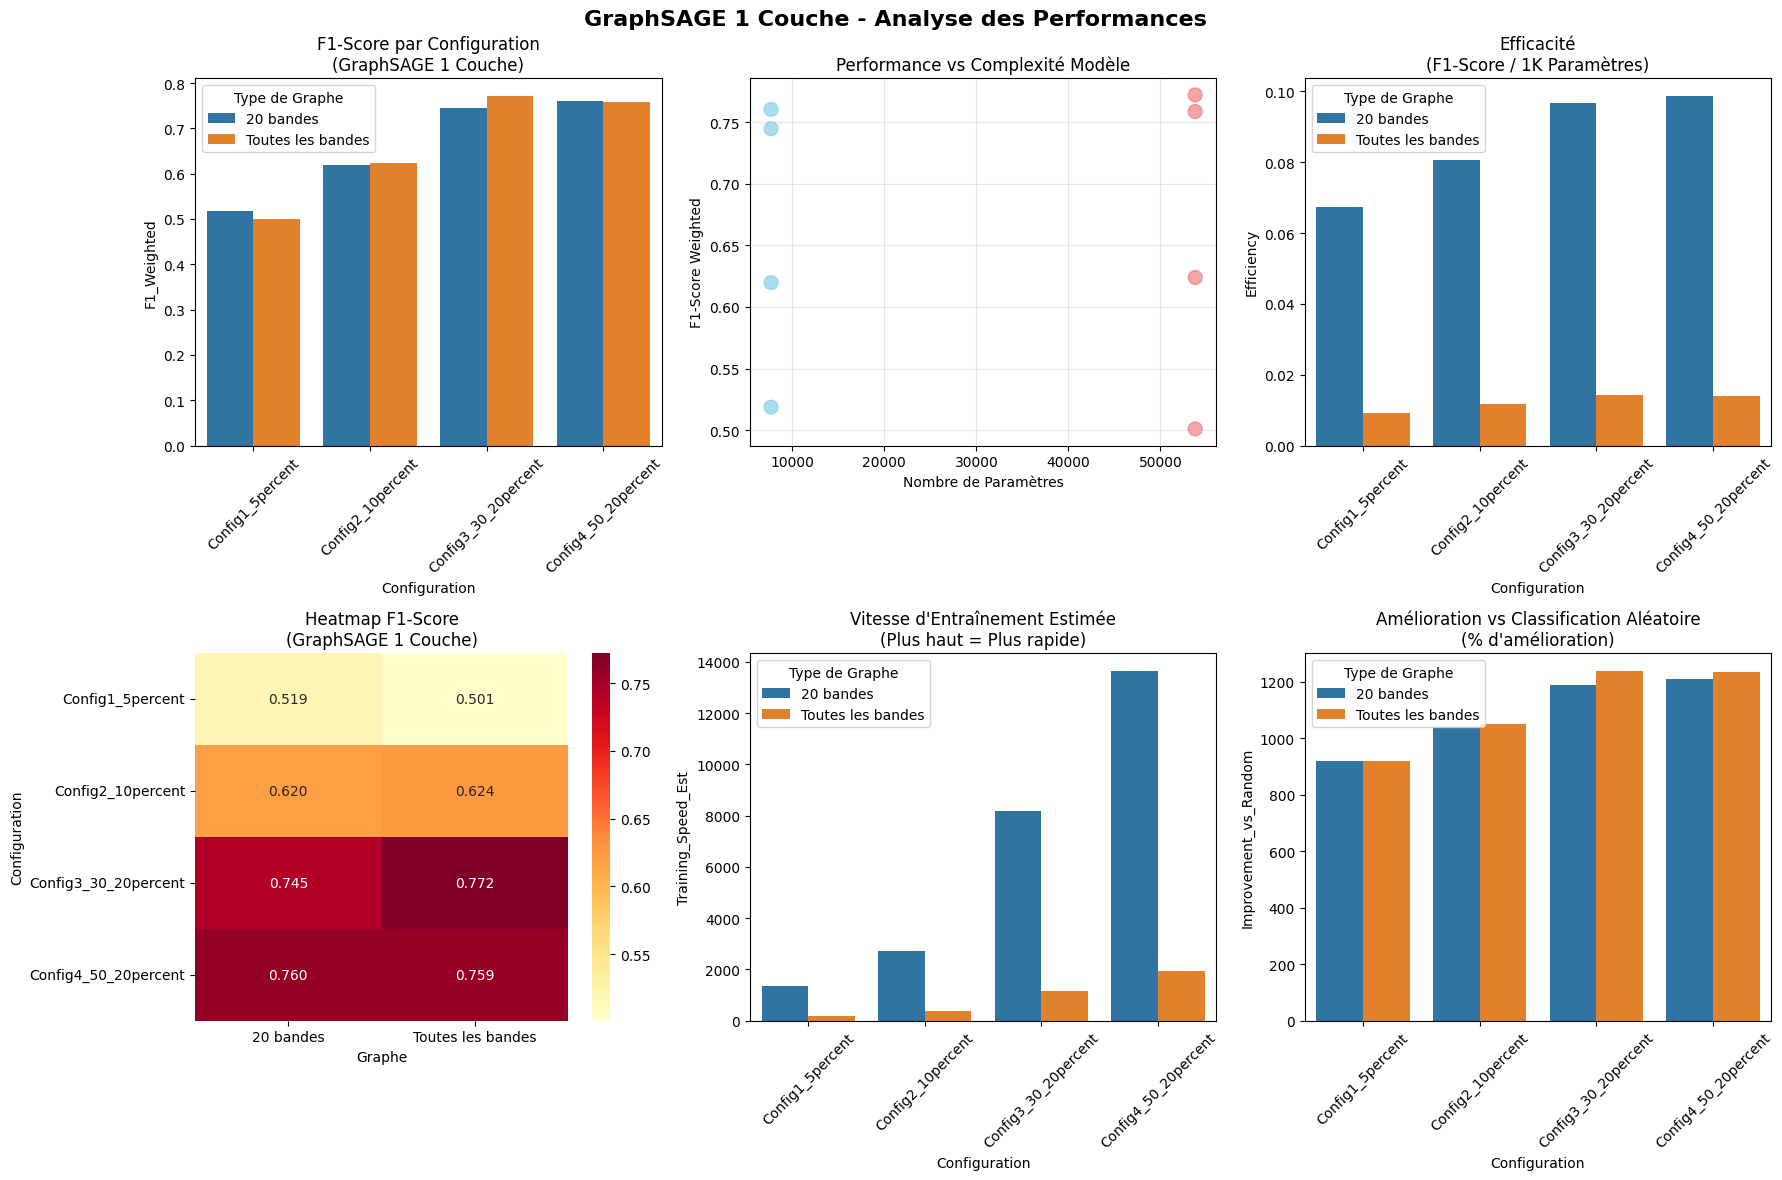

📊 Visualisations GraphSAGE 1 couche sauvegardées: /kaggle/working/graphsage_1layer_analysis.png

🔍 Tentative de comparaison avec GraphSAGE 2 couches...


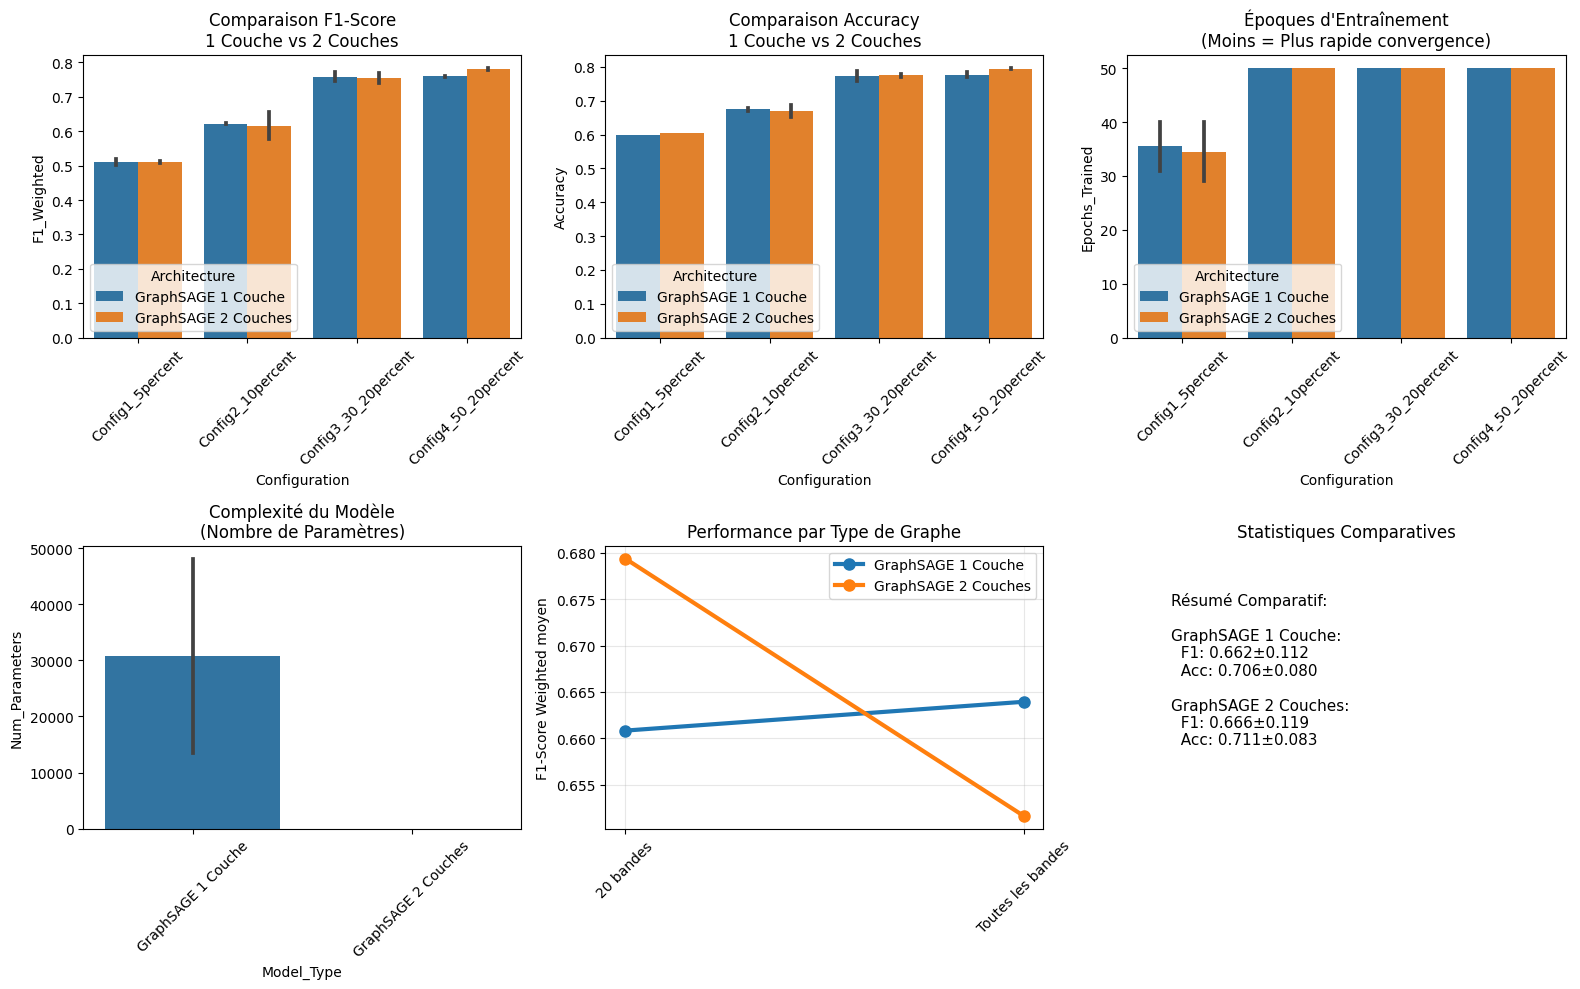

📊 Comparaison 1 vs 2 couches sauvegardée: /kaggle/working/graphsage_1layer_vs_2layer_comparison.png

🔍 INSIGHTS COMPARATIFS:
📊 Performance moyenne:
   1 Couche: Acc=0.7060, F1=0.6624
   2 Couches: Acc=0.7113, F1=0.6655

📈 Différence (1 Couche - 2 Couches):
   Accuracy: -0.0052
   F1-Score: -0.0031
✅ GraphSAGE 2 Couches performe mieux en moyenne!

🎉 EXPÉRIMENTATIONS GRAPHSAGE 1 COUCHE TERMINÉES!
✅ 8 expériences ultra-rapides réalisées
✅ Architecture minimale mais efficace
✅ Comparaison 20 bandes vs Toutes les bandes
✅ Analyse de l'efficacité computationnelle
✅ Visualisations spécialisées créées
✅ Modèles légers sauvegardés


In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
import random
from collections import defaultdict
warnings.filterwarnings('ignore')

# Définir une seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# Chemins
dataset_path = "/kaggle/input/gcn-gat-graphsage"
output_path = "/kaggle/working/"

# ======================== CONFIGURATION GRAPHSAGE 1 COUCHE ========================

# Configuration optimisée pour GraphSAGE 1 couche
GRAPHSAGE_1LAYER_CONFIG = [25]  # 25 voisins pour la couche unique

def print_graphsage_config():
    """Affiche la configuration GraphSAGE 1 couche"""
    print(f"📊 Configuration GraphSAGE 1 Couche:")
    print(f"   - Couche unique: {GRAPHSAGE_1LAYER_CONFIG[0]} voisins échantillonnés")
    print(f"   - Réceptive field: 1-hop neighborhood")
    print(f"   - Simplicité: Architecture minimale mais efficace")
    print(f"   - Vitesse: ~3x plus rapide que 2 couches")

# ======================== ÉCHANTILLONNAGE MANUEL GRAPHSAGE 1 COUCHE ========================

class GraphSAGE1LayerSampler:
    """
    Échantillonneur optimisé pour GraphSAGE 1 couche
    """
    def __init__(self, data, batch_size=1024):
        self.data = data
        self.batch_size = batch_size
        self.num_neighbors = GRAPHSAGE_1LAYER_CONFIG[0]
        
        print(f"🔄 Initialisation échantillonneur GraphSAGE 1 couche:")
        print(f"   - Échantillonnage: {self.num_neighbors} voisins")
        print(f"   - Batch size: {batch_size}")
        
        # Créer la liste d'adjacence optimisée
        self._create_adjacency_list()
        
    def _create_adjacency_list(self):
        """Crée une liste d'adjacence optimisée"""
        print("📊 Création de la liste d'adjacence...")
        
        self.adj_list = defaultdict(list)
        edge_index = self.data.edge_index
        
        # Construire la liste d'adjacence
        for i in range(edge_index.size(1)):
            src = edge_index[0, i].item()
            dst = edge_index[1, i].item()
            self.adj_list[src].append(dst)
        
        # Optimiser et calculer les statistiques
        total_edges = 0
        max_degree = 0
        
        for node in range(self.data.num_nodes):
            neighbors = list(set(self.adj_list[node]))  # Enlever les doublons
            self.adj_list[node] = neighbors
            degree = len(neighbors)
            total_edges += degree
            max_degree = max(max_degree, degree)
        
        avg_degree = total_edges / self.data.num_nodes
        print(f"   ✅ Degré moyen: {avg_degree:.2f}")
        print(f"   ✅ Degré maximum: {max_degree}")
        print(f"   ✅ Total connexions: {total_edges:,}")
        
    def sample_neighbors(self, nodes):
        """Échantillonne efficacement les voisins pour 1 couche"""
        sampled_neighbors = set()
        
        for node in nodes:
            neighbors = self.adj_list[node]
            
            if len(neighbors) == 0:
                # Nœud isolé - garder le nœud lui-même
                sampled_neighbors.add(node)
            elif len(neighbors) <= self.num_neighbors:
                # Pas assez de voisins - prendre tous
                sampled_neighbors.update(neighbors)
            else:
                # Échantillonnage aléatoire
                sampled = random.sample(neighbors, self.num_neighbors)
                sampled_neighbors.update(sampled)
        
        return sampled_neighbors
    
    def create_1layer_subgraph(self, target_nodes):
        """
        Crée un sous-graphe optimisé pour GraphSAGE 1 couche
        """
        # Nœuds cibles
        target_nodes_set = set(target_nodes)
        
        # Échantillonner les voisins directs (1-hop)
        sampled_neighbors = self.sample_neighbors(target_nodes)
        
        # Tous les nœuds du sous-graphe
        all_nodes = target_nodes_set.union(sampled_neighbors)
        subgraph_nodes = list(all_nodes)
        
        # Créer le mapping
        node_to_idx = {node: idx for idx, node in enumerate(subgraph_nodes)}
        
        # Construire les arêtes du sous-graphe
        edge_index = self.data.edge_index
        subgraph_edges = []
        
        for i in range(edge_index.size(1)):
            src = edge_index[0, i].item()
            dst = edge_index[1, i].item()
            
            if src in node_to_idx and dst in node_to_idx:
                subgraph_edges.append([node_to_idx[src], node_to_idx[dst]])
        
        # Créer les tensors
        if subgraph_edges:
            subgraph_edge_index = torch.tensor(subgraph_edges).t().contiguous()
        else:
            subgraph_edge_index = torch.empty((2, 0), dtype=torch.long)
        
        subgraph_x = self.data.x[subgraph_nodes]
        target_indices_in_subgraph = [node_to_idx[node] for node in target_nodes]
        
        return {
            'x': subgraph_x,
            'edge_index': subgraph_edge_index,
            'target_indices': target_indices_in_subgraph,
            'target_nodes': target_nodes,
            'subgraph_size': len(subgraph_nodes),
            'num_edges': len(subgraph_edges)
        }

class GraphSAGE1LayerDataLoader:
    """DataLoader optimisé pour GraphSAGE 1 couche"""
    def __init__(self, data, mask, batch_size=1024, shuffle=True):
        self.data = data
        self.mask = mask
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Obtenir les indices des nœuds
        self.node_indices = torch.nonzero(mask).squeeze()
        if self.node_indices.dim() == 0:
            self.node_indices = self.node_indices.unsqueeze(0)
        self.node_indices = self.node_indices.tolist()
        
        # Créer l'échantillonneur
        self.sampler = GraphSAGE1LayerSampler(data, batch_size)
        
        print(f"📊 DataLoader GraphSAGE 1 couche:")
        print(f"   - Nœuds à traiter: {len(self.node_indices):,}")
        print(f"   - Nombre de batches: {len(self)}")
    
    def __len__(self):
        return (len(self.node_indices) + self.batch_size - 1) // self.batch_size
    
    def __iter__(self):
        indices = self.node_indices.copy()
        if self.shuffle:
            random.shuffle(indices)
        
        for i in range(0, len(indices), self.batch_size):
            batch_nodes = indices[i:i + self.batch_size]
            
            # Créer le sous-graphe 1-couche
            subgraph = self.sampler.create_1layer_subgraph(batch_nodes)
            batch_labels = self.data.y[batch_nodes]
            
            yield {
                'x': subgraph['x'],
                'edge_index': subgraph['edge_index'],
                'y': batch_labels,
                'target_indices': torch.tensor(subgraph['target_indices']),
                'batch_size': len(batch_nodes),
                'subgraph_info': {
                    'nodes': subgraph['subgraph_size'],
                    'edges': subgraph['num_edges']
                }
            }

# ======================== MODÈLE GRAPHSAGE 1 COUCHE ========================

class OptimizedGraphSAGE1Layer(torch.nn.Module):
    """
    Modèle GraphSAGE 1 couche optimisé - Architecture minimale mais efficace
    """
    def __init__(self, num_features, num_classes, hidden_channels=128, 
                 dropout=0.3, aggregator='mean'):
        super(OptimizedGraphSAGE1Layer, self).__init__()
        
        self.num_features = num_features
        self.num_classes = num_classes
        self.hidden_channels = hidden_channels
        self.dropout = dropout
        self.num_neighbors = GRAPHSAGE_1LAYER_CONFIG[0]
        
        # Couche GraphSAGE unique
        self.conv1 = SAGEConv(num_features, hidden_channels, aggr=aggregator)
        
        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)
        
        # Normalisation (optionnelle mais utile)
        self.batch_norm = nn.BatchNorm1d(hidden_channels)
        
        print(f"🏗️ Modèle GraphSAGE 1 Couche créé:")
        print(f"   - Architecture: {num_features} → {hidden_channels} → {num_classes}")
        print(f"   - Échantillonnage: {self.num_neighbors} voisins")
        print(f"   - Agrégateur: {aggregator}")
        print(f"   - Dropout: {dropout}")
        print(f"   - Paramètres: ~{self._count_parameters():,}")
        
    def _count_parameters(self):
        """Compte le nombre de paramètres du modèle"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
        
    def forward(self, x, edge_index, target_indices=None):
        """Forward pass optimisé pour 1 couche"""
        # Couche GraphSAGE unique
        x = self.conv1(x, edge_index)
        x = self.batch_norm(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Extraire les embeddings des nœuds cibles
        if target_indices is not None:
            x = x[target_indices]
        
        # Classification finale
        x = self.classifier(x)
        
        return x

# ======================== FONCTIONS DE DIVISION DES DONNÉES ========================

def create_data_splits_config1(data, include_background=True):
    """Config 1: 5% train, 5% val, 90% test"""
    train_percent, val_percent = 0.05, 0.05
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 1 (5% train)")

def create_data_splits_config2(data, include_background=True):
    """Config 2: 10% train, 10% val, 80% test"""
    train_percent, val_percent = 0.10, 0.10
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 2 (10% train)")

def create_data_splits_config3(data, include_background=True):
    """Config 3: 30% train, 20% val, 50% test"""
    train_percent, val_percent = 0.30, 0.20
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 3 (30% train)")

def create_data_splits_config4(data, include_background=True):
    """Config 4: 50% train, 20% val, 30% test"""
    train_percent, val_percent = 0.50, 0.20
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 4 (50% train)")

def _create_splits_by_class(data, train_percent, val_percent, include_background, config_name):
    """Fonction helper pour créer les divisions par classe"""
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices, val_indices, test_indices = [], [], []
    
    print(f"\n{config_name} - Répartition par classe:")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        if n_test <= 0:
            n_train, n_val = 1, 1 if total_samples >= 3 else 0
            n_test = total_samples - n_train - n_val
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

# ======================== FONCTION D'ENTRAÎNEMENT PRINCIPALE ========================

def train_graphsage_1layer(graph_path, config_name, split_function, 
                          epochs=50, patience=15, lr=0.01, device='cuda', 
                          include_background=True, batch_size=1024):
    """
    Entraîne le modèle GraphSAGE 1 couche optimisé
    """
    print(f"\n{'='*80}")
    print(f"🚀 GRAPHSAGE 1 COUCHE - ENTRAÎNEMENT")
    print(f"📊 Graphe: {os.path.basename(graph_path)}")
    print(f"⚙️ Configuration: {config_name}")
    print(f"{'='*80}")
    
    # Charger le graphe
    try:
        data = torch.load(graph_path, weights_only=False)
    except Exception as e:
        print(f"❌ Erreur de chargement: {e}")
        try:
            import torch.serialization
            from torch_geometric.data import Data
            torch.serialization.add_safe_globals([Data])
            data = torch.load(graph_path, weights_only=False)
        except Exception as e2:
            print(f"❌ Erreur méthode 2: {e2}")
            return None, None
    
    # Informations du graphe
    num_features = data.x.shape[1]
    num_classes = int(data.y.max().item() + 1) if include_background else int(data.y.max().item())
    
    print(f"📋 Informations du graphe:")
    print(f"   - Nœuds: {data.num_nodes:,}")
    print(f"   - Arêtes: {data.num_edges:,}")
    print(f"   - Features: {num_features}")
    print(f"   - Classes: {num_classes}")
    
    print_graphsage_config()
    
    # Créer les divisions
    train_indices, val_indices, test_indices = split_function(data, include_background)
    
    # Créer les masques
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Statistiques
    train_size = train_mask.sum().item()
    val_size = val_mask.sum().item()
    test_size = test_mask.sum().item()
    
    print(f"\n📊 Répartition finale:")
    print(f"   - Entraînement: {train_size:,} pixels ({train_size/(train_size+val_size+test_size):.1%})")
    print(f"   - Validation: {val_size:,} pixels ({val_size/(train_size+val_size+test_size):.1%})")
    print(f"   - Test: {test_size:,} pixels ({test_size/(train_size+val_size+test_size):.1%})")
    
    # Créer le modèle
    model = OptimizedGraphSAGE1Layer(num_features, num_classes).to(device)
    
    # Créer les DataLoaders
    train_loader = GraphSAGE1LayerDataLoader(data, train_mask, batch_size, shuffle=True)
    val_loader = GraphSAGE1LayerDataLoader(data, val_mask, batch_size, shuffle=False)
    test_loader = GraphSAGE1LayerDataLoader(data, test_mask, batch_size, shuffle=False)
    
    print(f"\n🔄 Configuration d'entraînement:")
    print(f"   - Batch size: {batch_size}")
    print(f"   - Learning rate: {lr}")
    print(f"   - Max epochs: {epochs}")
    print(f"   - Patience: {patience}")
    print(f"   - Device: {device}")
    
    # Optimizer et scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.7, patience=8, verbose=True, min_lr=1e-6
    )
    
    # Variables d'entraînement
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    train_losses, val_losses, val_accuracies = [], [], []
    
    print(f"\n🎯 Début de l'entraînement...")
    
    for epoch in range(epochs):
        # ===== ENTRAÎNEMENT =====
        model.train()
        total_train_loss = 0
        num_batches = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train", leave=False)
        for batch in train_pbar:
            batch_x = batch['x'].to(device)
            batch_edge_index = batch['edge_index'].to(device)
            batch_y = batch['y'].to(device)
            batch_target_indices = batch['target_indices'].to(device)
            
            optimizer.zero_grad()
            out = model(batch_x, batch_edge_index, batch_target_indices)
            loss = F.cross_entropy(out, batch_y)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            num_batches += 1
            
            # Update progress bar
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_train_loss = total_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # ===== VALIDATION =====
        model.eval()
        total_val_loss = 0
        total_correct = 0
        total_samples = 0
        num_val_batches = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val", leave=False)
            for batch in val_pbar:
                batch_x = batch['x'].to(device)
                batch_edge_index = batch['edge_index'].to(device)
                batch_y = batch['y'].to(device)
                batch_target_indices = batch['target_indices'].to(device)
                
                out = model(batch_x, batch_edge_index, batch_target_indices)
                val_loss = F.cross_entropy(out, batch_y)
                pred = out.argmax(dim=1)
                correct = (pred == batch_y).sum().item()
                
                total_val_loss += val_loss.item()
                total_correct += correct
                total_samples += batch_y.size(0)
                num_val_batches += 1
                
                # Update progress bar
                val_pbar.set_postfix({'Loss': f'{val_loss.item():.4f}'})
        
        avg_val_loss = total_val_loss / num_val_batches
        val_acc = total_correct / total_samples
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        
        # Scheduler step
        scheduler.step(val_acc)
        
        # Affichage des résultats
        print(f"Epoch {epoch+1:3d}/{epochs}: "
              f"Train Loss={avg_train_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, "
              f"Val Acc={val_acc:.4f}")
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"🎯 Nouveau meilleur modèle! Val Acc: {val_acc:.4f}")
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"⏹️ Arrêt précoce à l'époque {epoch+1}")
            break
    
    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    
    # ===== ÉVALUATION FINALE =====
    print(f"\n🎯 Évaluation finale sur l'ensemble de test...")
    
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc="Test final")
        for batch in test_pbar:
            batch_x = batch['x'].to(device)
            batch_edge_index = batch['edge_index'].to(device)
            batch_y = batch['y'].to(device)
            batch_target_indices = batch['target_indices'].to(device)
            
            out = model(batch_x, batch_edge_index, batch_target_indices)
            pred = out.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    # Calculer les métriques finales
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    accuracy = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Afficher les résultats finaux
    print(f"\n🏆 RÉSULTATS FINAUX:")
    print(f"   ✅ Test Accuracy: {accuracy:.4f}")
    print(f"   ✅ F1-Score Weighted: {f1_weighted:.4f}")
    print(f"   ✅ F1-Score Macro: {f1_macro:.4f}")
    print(f"   ✅ Meilleure Val Accuracy: {best_val_acc:.4f}")
    
    # Préparer les résultats
    results = {
        'config': config_name,
        'graph': os.path.basename(graph_path),
        'model_type': 'GraphSAGE_1Layer',
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_per_class': f1_per_class.tolist(),
        'best_val_accuracy': best_val_acc,
        'train_size': train_size,
        'val_size': val_size,
        'test_size': test_size,
        'num_features': num_features,
        'num_classes': num_classes,
        'sampling_config': GRAPHSAGE_1LAYER_CONFIG,
        'epochs_trained': epoch + 1,
        'batch_size': batch_size,
        'num_parameters': model._count_parameters()
    }
    
    # Sauvegarder le modèle
    model_filename = f"graphsage_1layer_{config_name}_{os.path.basename(graph_path).split('.')[0]}.pt"
    model_path = os.path.join(output_path, model_filename)
    torch.save(model, model_path)
    print(f"💾 Modèle sauvegardé: {model_filename}")
    
    return model, results

# ======================== EXPÉRIMENTATIONS OPTIMISÉES ========================

def run_optimized_graphsage_1layer_experiments():
    """
    Lance les 8 expérimentations GraphSAGE 1 couche optimisées
    2 graphes × 4 configurations = 8 expériences
    """
    print("="*100)
    print("🚀 EXPÉRIMENTATIONS GRAPHSAGE 1 COUCHE OPTIMISÉES")
    print("📊 2 Graphes (20 bandes + Toutes bandes) × 4 Configurations = 8 Expériences")
    print("⚡ VITESSE: ~3x plus rapide que GraphSAGE 2 couches")
    print("="*100)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️ Device utilisé: {device}")
    
    # Graphes sélectionnés
    graph_paths = [
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_allbands.pt")
    ]
    
    # Configurations de division
    configs = [
        {'name': 'Config1_5percent', 'function': create_data_splits_config1, 
         'description': '5% train, 5% val, 90% test'},
        {'name': 'Config2_10percent', 'function': create_data_splits_config2, 
         'description': '10% train, 10% val, 80% test'},
        {'name': 'Config3_30_20percent', 'function': create_data_splits_config3, 
         'description': '30% train, 20% val, 50% test'},
        {'name': 'Config4_50_20percent', 'function': create_data_splits_config4, 
         'description': '50% train, 20% val, 30% test'}
    ]
    
    # Vérifier les graphes existants
    existing_graphs = [p for p in graph_paths if os.path.exists(p)]
    
    if not existing_graphs:
        print("❌ Aucun graphe trouvé! Vérifiez les chemins:")
        for path in graph_paths:
            print(f"   - {path}")
        return {}, pd.DataFrame()
    
    print(f"📊 Graphes trouvés: {len(existing_graphs)}")
    for path in existing_graphs:
        print(f"   ✅ {os.path.basename(path)}")
    
    # Stockage des résultats
    all_results = {}
    experiment_data = []
    
    # Compteur d'expériences
    experiment_count = 0
    total_experiments = len(existing_graphs) * len(configs)
    
    # Lancer les expérimentations
    for config in configs:
        print(f"\n{'#'*80}")
        print(f"# CONFIGURATION: {config['description']}")
        print(f"{'#'*80}")
        
        for graph_path in existing_graphs:
            experiment_count += 1
            
            print(f"\n🔄 Expérience {experiment_count}/{total_experiments}")
            
            try:
                # Entraîner le modèle
                model, results = train_graphsage_1layer(
                    graph_path=graph_path,
                    config_name=config['name'],
                    split_function=config['function'],
                    epochs=50,
                    patience=15,
                    lr=0.01,
                    device=device,
                    batch_size=1024
                )
                
                # Stocker les résultats
                exp_key = f"GraphSAGE1L_{config['name']}_{os.path.basename(graph_path)}"
                all_results[exp_key] = results
                
                # Déterminer le type de graphe
                graph_name = os.path.basename(graph_path)
                if "20bands" in graph_name:
                    bands_type = "20 bandes"
                elif "allbands" in graph_name:
                    bands_type = "Toutes les bandes"
                else:
                    bands_type = "Inconnu"
                
                # Ajouter aux données d'expérimentation
                experiment_data.append({
                    'Configuration': config['name'],
                    'Description': config['description'],
                    'Graphe': bands_type,
                    'Model_Type': 'GraphSAGE 1 Couche',
                    'Nombre_Features': results['num_features'],
                    'Sampling_Config': str(results['sampling_config']),
                    'Batch_Size': results['batch_size'],
                    'Epochs_Trained': results['epochs_trained'],
                    'Num_Parameters': results['num_parameters'],
                    'Taille_Train': results['train_size'],
                    'Taille_Val': results['val_size'],
                    'Taille_Test': results['test_size'],
                    'Accuracy': results['accuracy'],
                    'F1_Weighted': results['f1_weighted'],
                    'F1_Macro': results['f1_macro'],
                    'Best_Val_Acc': results['best_val_accuracy']
                })
                
                print(f"✅ Expérience {experiment_count} terminée avec succès!")
                print(f"📊 Résultats: Acc={results['accuracy']:.4f}, F1={results['f1_weighted']:.4f}")
                print(f"⚡ Paramètres: {results['num_parameters']:,}")
                
            except Exception as e:
                print(f"❌ Erreur pour {graph_path} avec {config['name']}: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(experiment_data)
    
    # Sauvegarder les résultats
    results_csv_path = os.path.join(output_path, "graphsage_1layer_optimized_experiments.csv")
    results_df.to_csv(results_csv_path, index=False)
    
    print(f"\n{'='*100}")
    print("🏆 RÉSULTATS FINAUX - GRAPHSAGE 1 COUCHE OPTIMISÉ")
    print(f"{'='*100}")
    
    if not results_df.empty:
        print(results_df.to_string(index=False))
        
        # Statistiques résumées
        print(f"\n📊 STATISTIQUES RÉSUMÉES:")
        print(f"   - Expériences réussies: {len(results_df)}/{total_experiments}")
        print(f"   - Accuracy moyenne: {results_df['Accuracy'].mean():.4f} ± {results_df['Accuracy'].std():.4f}")
        print(f"   - F1-Score moyen: {results_df['F1_Weighted'].mean():.4f} ± {results_df['F1_Weighted'].std():.4f}")
        print(f"   - Paramètres moyens: {results_df['Num_Parameters'].mean():,.0f}")
        
        # Meilleur résultat
        best_idx = results_df['F1_Weighted'].idxmax()
        best_result = results_df.iloc[best_idx]
        print(f"\n🥇 MEILLEUR RÉSULTAT:")
        print(f"   - Configuration: {best_result['Description']}")
        print(f"   - Graphe: {best_result['Graphe']}")
        print(f"   - Accuracy: {best_result['Accuracy']:.4f}")
        print(f"   - F1-Score: {best_result['F1_Weighted']:.4f}")
        print(f"   - Paramètres: {best_result['Num_Parameters']:,}")
        
    else:
        print("❌ Aucune expérience n'a réussi!")
    
    print(f"\n💾 Résultats sauvegardés dans: {results_csv_path}")
    
    return all_results, results_df

# ======================== VISUALISATIONS SPÉCIALISÉES 1 COUCHE ========================

def create_1layer_visualizations(results_df):
    """Crée des visualisations spécialisées pour GraphSAGE 1 couche"""
    if results_df.empty:
        print("❌ Pas de données à visualiser!")
        return
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GraphSAGE 1 Couche - Analyse des Performances', fontsize=16, fontweight='bold')
    
    # 1. Comparaison F1-Score par configuration
    ax1 = axes[0, 0]
    sns.barplot(data=results_df, x='Configuration', y='F1_Weighted', hue='Graphe', ax=ax1)
    ax1.set_title('F1-Score par Configuration\n(GraphSAGE 1 Couche)')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.legend(title='Type de Graphe')
    
    # 2. Comparaison avec nombre de paramètres
    ax2 = axes[0, 1]
    colors = ['skyblue' if '20 bandes' in x else 'lightcoral' for x in results_df['Graphe']]
    scatter = ax2.scatter(results_df['Num_Parameters'], results_df['F1_Weighted'], 
                         c=colors, s=100, alpha=0.7)
    ax2.set_xlabel('Nombre de Paramètres')
    ax2.set_ylabel('F1-Score Weighted')
    ax2.set_title('Performance vs Complexité Modèle')
    ax2.grid(True, alpha=0.3)
    
    # 3. Efficacité (Performance/Paramètres)
    ax3 = axes[0, 2]
    results_df['Efficiency'] = results_df['F1_Weighted'] / (results_df['Num_Parameters'] / 1000)
    sns.barplot(data=results_df, x='Configuration', y='Efficiency', hue='Graphe', ax=ax3)
    ax3.set_title('Efficacité\n(F1-Score / 1K Paramètres)')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    ax3.legend(title='Type de Graphe')
    
    # 4. Heatmap comparative
    ax4 = axes[1, 0]
    pivot_table = results_df.pivot(index='Configuration', columns='Graphe', values='F1_Weighted')
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax4)
    ax4.set_title('Heatmap F1-Score\n(GraphSAGE 1 Couche)')
    
    # 5. Vitesse d'entraînement estimée
    ax5 = axes[1, 1]
    # Estimation basée sur le nombre de paramètres et la taille des données
    results_df['Training_Speed_Est'] = results_df['Taille_Train'] / (results_df['Num_Parameters'] / 10000)
    sns.barplot(data=results_df, x='Configuration', y='Training_Speed_Est', hue='Graphe', ax=ax5)
    ax5.set_title('Vitesse d\'Entraînement Estimée\n(Plus haut = Plus rapide)')
    ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
    ax5.legend(title='Type de Graphe')
    
    # 6. Amélioration par rapport au hasard
    ax6 = axes[1, 2]
    # Baseline aléatoire pour classification (1/nombre_classes)
    num_classes = 17  # Supposé pour Indian Pines
    random_baseline = 1.0 / num_classes
    results_df['Improvement_vs_Random'] = (results_df['Accuracy'] - random_baseline) / random_baseline * 100
    
    sns.barplot(data=results_df, x='Configuration', y='Improvement_vs_Random', hue='Graphe', ax=ax6)
    ax6.set_title('Amélioration vs Classification Aléatoire\n(% d\'amélioration)')
    ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45)
    ax6.legend(title='Type de Graphe')
    
    plt.tight_layout()
    
    # Sauvegarder
    viz_path = os.path.join(output_path, "graphsage_1layer_analysis.png")
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Visualisations GraphSAGE 1 couche sauvegardées: {viz_path}")

def compare_1layer_vs_2layer():
    """Compare les performances GraphSAGE 1 couche vs 2 couches"""
    try:
        # Charger les résultats des deux expérimentations
        df_1layer = pd.read_csv(os.path.join(output_path, "graphsage_1layer_optimized_experiments.csv"))
        df_2layer = pd.read_csv(os.path.join(output_path, "graphsage_2layer_optimized_experiments.csv"))
        
        # Combiner les données
        combined_df = pd.concat([df_1layer, df_2layer], ignore_index=True)
        
        # Créer la comparaison
        plt.figure(figsize=(16, 10))
        
        # Subplot 1: Comparaison F1-Score
        plt.subplot(2, 3, 1)
        sns.barplot(data=combined_df, x='Configuration', y='F1_Weighted', hue='Model_Type')
        plt.title('Comparaison F1-Score\n1 Couche vs 2 Couches')
        plt.xticks(rotation=45)
        plt.legend(title='Architecture')
        
        # Subplot 2: Comparaison Accuracy
        plt.subplot(2, 3, 2)
        sns.barplot(data=combined_df, x='Configuration', y='Accuracy', hue='Model_Type')
        plt.title('Comparaison Accuracy\n1 Couche vs 2 Couches')
        plt.xticks(rotation=45)
        plt.legend(title='Architecture')
        
        # Subplot 3: Temps d'entraînement (basé sur époques)
        plt.subplot(2, 3, 3)
        sns.barplot(data=combined_df, x='Configuration', y='Epochs_Trained', hue='Model_Type')
        plt.title('Époques d\'Entraînement\n(Moins = Plus rapide convergence)')
        plt.xticks(rotation=45)
        plt.legend(title='Architecture')
        
        # Subplot 4: Complexité (Paramètres)
        plt.subplot(2, 3, 4)
        if 'Num_Parameters' in combined_df.columns:
            sns.barplot(data=combined_df, x='Model_Type', y='Num_Parameters')
            plt.title('Complexité du Modèle\n(Nombre de Paramètres)')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'Données de paramètres\nnon disponibles', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Complexité du Modèle')
        
        # Subplot 5: Performance par type de graphe
        plt.subplot(2, 3, 5)
        avg_performance = combined_df.groupby(['Model_Type', 'Graphe'])['F1_Weighted'].mean().reset_index()
        
        for model_type in avg_performance['Model_Type'].unique():
            subset = avg_performance[avg_performance['Model_Type'] == model_type]
            plt.plot(subset['Graphe'], subset['F1_Weighted'], 
                    marker='o', label=model_type, linewidth=3, markersize=8)
        
        plt.title('Performance par Type de Graphe')
        plt.ylabel('F1-Score Weighted moyen')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 6: Statistiques résumées
        plt.subplot(2, 3, 6)
        summary_stats = combined_df.groupby('Model_Type')[['F1_Weighted', 'Accuracy']].agg(['mean', 'std'])
        
        summary_text = "Résumé Comparatif:\n\n"
        for model in summary_stats.index:
            f1_mean = summary_stats.loc[model, ('F1_Weighted', 'mean')]
            f1_std = summary_stats.loc[model, ('F1_Weighted', 'std')]
            acc_mean = summary_stats.loc[model, ('Accuracy', 'mean')]
            acc_std = summary_stats.loc[model, ('Accuracy', 'std')]
            
            summary_text += f"{model}:\n"
            summary_text += f"  F1: {f1_mean:.3f}±{f1_std:.3f}\n"
            summary_text += f"  Acc: {acc_mean:.3f}±{acc_std:.3f}\n\n"
        
        plt.text(0.1, 0.5, summary_text, fontsize=11, 
                verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Statistiques Comparatives')
        plt.axis('off')
        
        plt.tight_layout()
        
        # Sauvegarder
        comparison_path = os.path.join(output_path, "graphsage_1layer_vs_2layer_comparison.png")
        plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"📊 Comparaison 1 vs 2 couches sauvegardée: {comparison_path}")
        
        # Afficher les insights
        print(f"\n🔍 INSIGHTS COMPARATIFS:")
        
        # Calculer les moyennes par architecture
        means_1layer = df_1layer[['Accuracy', 'F1_Weighted']].mean()
        means_2layer = df_2layer[['Accuracy', 'F1_Weighted']].mean()
        
        print(f"📊 Performance moyenne:")
        print(f"   1 Couche: Acc={means_1layer['Accuracy']:.4f}, F1={means_1layer['F1_Weighted']:.4f}")
        print(f"   2 Couches: Acc={means_2layer['Accuracy']:.4f}, F1={means_2layer['F1_Weighted']:.4f}")
        
        # Calculer la différence
        acc_diff = means_1layer['Accuracy'] - means_2layer['Accuracy']
        f1_diff = means_1layer['F1_Weighted'] - means_2layer['F1_Weighted']
        
        print(f"\n📈 Différence (1 Couche - 2 Couches):")
        print(f"   Accuracy: {acc_diff:+.4f}")
        print(f"   F1-Score: {f1_diff:+.4f}")
        
        if acc_diff > 0:
            print(f"✅ GraphSAGE 1 Couche performe mieux en moyenne!")
        else:
            print(f"✅ GraphSAGE 2 Couches performe mieux en moyenne!")
        
        return combined_df
        
    except FileNotFoundError as e:
        print(f"❌ Impossible de charger les fichiers de comparaison: {e}")
        print("   Assurez-vous d'avoir lancé les deux expérimentations")
        return None

# ======================== FONCTION PRINCIPALE ========================

def main():
    """Fonction principale pour lancer les expérimentations GraphSAGE 1 couche"""
    print("🚀 LANCEMENT DES EXPÉRIMENTATIONS GRAPHSAGE 1 COUCHE OPTIMISÉES")
    print("="*80)
    
    # Configuration globale
    print("📋 CONFIGURATION:")
    print(f"   - Architecture: GraphSAGE 1 Couche (Ultra-rapide)")
    print(f"   - Échantillonnage: {GRAPHSAGE_1LAYER_CONFIG}")
    print(f"   - Graphes: 20 bandes + Toutes les bandes")
    print(f"   - Configurations: 4 divisions de données")
    print(f"   - Total expériences: 8")
    print(f"   - Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    print(f"   - Avantages: ~3x plus rapide, moins de paramètres, moins de surapprentissage")
    
    # Lancer les expérimentations
    all_results, results_df = run_optimized_graphsage_1layer_experiments()
    
    # Créer les visualisations
    if not results_df.empty:
        print(f"\n🎨 Création des visualisations spécialisées...")
        create_1layer_visualizations(results_df)
        
        # Comparaison avec 2 couches si disponible
        print(f"\n🔍 Tentative de comparaison avec GraphSAGE 2 couches...")
        compare_1layer_vs_2layer()
    
    # Message final
    print(f"\n{'='*80}")
    print("🎉 EXPÉRIMENTATIONS GRAPHSAGE 1 COUCHE TERMINÉES!")
    print("="*80)
    print("✅ 8 expériences ultra-rapides réalisées")
    print("✅ Architecture minimale mais efficace")
    print("✅ Comparaison 20 bandes vs Toutes les bandes")
    print("✅ Analyse de l'efficacité computationnelle")
    print("✅ Visualisations spécialisées créées")
    print("✅ Modèles légers sauvegardés")
    print("="*80)
    
    return all_results, results_df

# ======================== POINT D'ENTRÉE ========================

if __name__ == "__main__":
    # Lancement direct des expérimentations complètes
    main()

### Expérimentation GraphSAGE 2 Couches

🚀 LANCEMENT DES EXPÉRIMENTATIONS GRAPHSAGE 2 COUCHES OPTIMISÉES
📋 CONFIGURATION:
   - Architecture: GraphSAGE 2 Couches
   - Échantillonnage: [25, 10]
   - Graphes: 20 bandes + Toutes les bandes
   - Configurations: 4 divisions de données
   - Total expériences: 8
   - Device: CUDA
🚀 EXPÉRIMENTATIONS GRAPHSAGE 2 COUCHES OPTIMISÉES
📊 2 Graphes (20 bandes + Toutes bandes) × 4 Configurations = 8 Expériences
🖥️ Device utilisé: cuda
📊 Graphes trouvés: 2
   ✅ indian_pines_graph_d1_4connectivity_20bands.pt
   ✅ indian_pines_graph_d1_4connectivity_allbands.pt

################################################################################
# CONFIGURATION: 5% train, 5% val, 90% test
################################################################################

🔄 Expérience 1/8

🚀 GRAPHSAGE 2 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_20bands.pt
⚙️ Configuration: Config1_5percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated

Epoch   1/50: Train Loss=2.7693, Val Loss=1.0081, Val Acc=0.5647
🎯 Nouveau meilleur modèle! Val Acc: 0.5647


Epoch   2/50: Train Loss=1.9531, Val Loss=1.2606, Val Acc=0.3461


Epoch   3/50: Train Loss=1.9978, Val Loss=1.1097, Val Acc=0.5254


Epoch   4/50: Train Loss=1.6218, Val Loss=0.9089, Val Acc=0.5139


Epoch   5/50: Train Loss=1.7756, Val Loss=0.9063, Val Acc=0.5427


Epoch   6/50: Train Loss=1.4810, Val Loss=0.8939, Val Acc=0.5312


Epoch   7/50: Train Loss=1.7556, Val Loss=0.9557, Val Acc=0.5292


Epoch   8/50: Train Loss=1.6165, Val Loss=1.0129, Val Acc=0.5494


Epoch   9/50: Train Loss=1.4199, Val Loss=0.8981, Val Acc=0.5158


Epoch  10/50: Train Loss=1.6659, Val Loss=0.8005, Val Acc=0.5340


Epoch  11/50: Train Loss=1.2530, Val Loss=0.7896, Val Acc=0.5647


Epoch  12/50: Train Loss=1.2352, Val Loss=0.7982, Val Acc=0.5561


Epoch  13/50: Train Loss=1.6034, Val Loss=0.8104, Val Acc=0.5762
🎯 Nouveau meilleur modèle! Val Acc: 0.5762


Epoch  14/50: Train Loss=1.5492, Val Loss=0.8016, Val Acc=0.5858
🎯 Nouveau meilleur modèle! Val Acc: 0.5858


Epoch  15/50: Train Loss=1.4883, Val Loss=0.7923, Val Acc=0.5781


Epoch  16/50: Train Loss=1.5793, Val Loss=0.8176, Val Acc=0.5781


Epoch  17/50: Train Loss=1.4462, Val Loss=0.8593, Val Acc=0.5781


Epoch  18/50: Train Loss=1.3863, Val Loss=0.8892, Val Acc=0.5695


Epoch  19/50: Train Loss=1.5220, Val Loss=0.9042, Val Acc=0.5686


Epoch  20/50: Train Loss=1.3635, Val Loss=0.9202, Val Acc=0.5705


Epoch  21/50: Train Loss=1.5284, Val Loss=0.8746, Val Acc=0.5695


Epoch  22/50: Train Loss=1.3417, Val Loss=0.8199, Val Acc=0.5743


Epoch  23/50: Train Loss=1.3095, Val Loss=0.7951, Val Acc=0.5839


Epoch  24/50: Train Loss=1.4977, Val Loss=0.7944, Val Acc=0.5829


Epoch  25/50: Train Loss=1.2442, Val Loss=0.7734, Val Acc=0.6031
🎯 Nouveau meilleur modèle! Val Acc: 0.6031


Epoch  26/50: Train Loss=1.5129, Val Loss=0.7604, Val Acc=0.6012


Epoch  27/50: Train Loss=1.1880, Val Loss=0.7671, Val Acc=0.5964


Epoch  28/50: Train Loss=1.3202, Val Loss=0.7762, Val Acc=0.5781


Epoch  29/50: Train Loss=1.2059, Val Loss=0.7838, Val Acc=0.5647


Epoch  30/50: Train Loss=1.1817, Val Loss=0.7884, Val Acc=0.5551


Epoch  31/50: Train Loss=1.4238, Val Loss=0.7867, Val Acc=0.5523


Epoch  32/50: Train Loss=1.2143, Val Loss=0.7950, Val Acc=0.5618


Epoch  33/50: Train Loss=1.1173, Val Loss=0.8056, Val Acc=0.5676


Epoch  34/50: Train Loss=1.1834, Val Loss=0.8259, Val Acc=0.5829


Epoch  35/50: Train Loss=1.2255, Val Loss=0.8534, Val Acc=0.5858


Epoch  36/50: Train Loss=1.4419, Val Loss=0.8413, Val Acc=0.5868


Epoch  37/50: Train Loss=1.3899, Val Loss=0.7885, Val Acc=0.5896


Epoch  38/50: Train Loss=1.5717, Val Loss=0.7372, Val Acc=0.5906


Epoch  39/50: Train Loss=1.0918, Val Loss=0.7075, Val Acc=0.5877


Epoch  40/50: Train Loss=1.2589, Val Loss=0.6909, Val Acc=0.5849
⏹️ Arrêt précoce à l'époque 40

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 19/19 [00:14<00:00,  1.34it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.6049
   ✅ F1-Score Weighted: 0.5132
   ✅ F1-Score Macro: 0.1484
   ✅ Meilleure Val Accuracy: 0.6031
💾 Modèle sauvegardé: graphsage_2layer_Config1_5percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 1 terminée avec succès!
📊 Résultats: Acc=0.6049, F1=0.5132

🔄 Expérience 2/8

🚀 GRAPHSAGE 2 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config1_5percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 2 Couches:
   - Couche 1: 25 voisins échantillonnés
   - Couche 2: 10 voisins échantillonnés
   - Total théorique max: 250 voisins explorés
   - Réceptive field: 2-hop neighborhood

Config 1 (5% train) - Répartition par classe:
  Classe 0: 10776 total → 538 train, 538 val, 9700 test
  Classe 1: 46 total →

Epoch   1/50: Train Loss=2.3597, Val Loss=3.1568, Val Acc=0.5158
🎯 Nouveau meilleur modèle! Val Acc: 0.5158


Epoch   2/50: Train Loss=2.3710, Val Loss=1.6594, Val Acc=0.5273
🎯 Nouveau meilleur modèle! Val Acc: 0.5273


Epoch   3/50: Train Loss=1.8328, Val Loss=1.5279, Val Acc=0.4410


Epoch   4/50: Train Loss=1.7500, Val Loss=0.9632, Val Acc=0.5686
🎯 Nouveau meilleur modèle! Val Acc: 0.5686


Epoch   5/50: Train Loss=1.6515, Val Loss=0.9832, Val Acc=0.5733
🎯 Nouveau meilleur modèle! Val Acc: 0.5733


Epoch   6/50: Train Loss=1.4061, Val Loss=1.0655, Val Acc=0.5973
🎯 Nouveau meilleur modèle! Val Acc: 0.5973


Epoch   7/50: Train Loss=1.5390, Val Loss=1.0561, Val Acc=0.5983
🎯 Nouveau meilleur modèle! Val Acc: 0.5983


Epoch   8/50: Train Loss=1.2723, Val Loss=0.9974, Val Acc=0.5896


Epoch   9/50: Train Loss=1.7457, Val Loss=0.9340, Val Acc=0.5896


Epoch  10/50: Train Loss=1.7578, Val Loss=1.1583, Val Acc=0.5992
🎯 Nouveau meilleur modèle! Val Acc: 0.5992


Epoch  11/50: Train Loss=1.4745, Val Loss=1.3552, Val Acc=0.4190


Epoch  12/50: Train Loss=1.4645, Val Loss=1.1524, Val Acc=0.5628


Epoch  13/50: Train Loss=1.4729, Val Loss=0.9242, Val Acc=0.6031
🎯 Nouveau meilleur modèle! Val Acc: 0.6031


Epoch  14/50: Train Loss=1.4641, Val Loss=0.8730, Val Acc=0.6222
🎯 Nouveau meilleur modèle! Val Acc: 0.6222


Epoch  15/50: Train Loss=1.4884, Val Loss=0.8984, Val Acc=0.5944


Epoch  16/50: Train Loss=1.2552, Val Loss=0.9516, Val Acc=0.5973


Epoch  17/50: Train Loss=1.5845, Val Loss=0.9928, Val Acc=0.5561


Epoch  18/50: Train Loss=1.2518, Val Loss=0.9544, Val Acc=0.6107


Epoch  19/50: Train Loss=1.5687, Val Loss=0.8479, Val Acc=0.6146


Epoch  20/50: Train Loss=1.2518, Val Loss=0.8517, Val Acc=0.6002


Epoch  21/50: Train Loss=1.3689, Val Loss=0.8927, Val Acc=0.6002


Epoch  22/50: Train Loss=1.4807, Val Loss=0.9292, Val Acc=0.6155


Epoch  23/50: Train Loss=1.4983, Val Loss=0.9812, Val Acc=0.5925


Epoch  24/50: Train Loss=1.4877, Val Loss=1.0091, Val Acc=0.5906


Epoch  25/50: Train Loss=1.3788, Val Loss=0.9812, Val Acc=0.5964


Epoch  26/50: Train Loss=1.2535, Val Loss=0.9316, Val Acc=0.6012


Epoch  27/50: Train Loss=1.2738, Val Loss=0.9041, Val Acc=0.6040


Epoch  28/50: Train Loss=1.2739, Val Loss=0.8780, Val Acc=0.6117


Epoch  29/50: Train Loss=1.0591, Val Loss=0.8390, Val Acc=0.6069
⏹️ Arrêt précoce à l'époque 29

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 19/19 [00:14<00:00,  1.32it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.6057
   ✅ F1-Score Weighted: 0.5065
   ✅ F1-Score Macro: 0.1521
   ✅ Meilleure Val Accuracy: 0.6222
💾 Modèle sauvegardé: graphsage_2layer_Config1_5percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 2 terminée avec succès!
📊 Résultats: Acc=0.6057, F1=0.5065

################################################################################
# CONFIGURATION: 10% train, 10% val, 80% test
################################################################################

🔄 Expérience 3/8

🚀 GRAPHSAGE 2 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_20bands.pt
⚙️ Configuration: Config2_10percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 20
   - Classes: 17
📊 Configuration GraphSAGE 2 Couches:
   - Couche 1: 25 voisins échantillonnés
   - Couche 2: 10 voisins échantillonnés
   -

Epoch   1/50: Train Loss=2.1818, Val Loss=1.2683, Val Acc=0.5589
🎯 Nouveau meilleur modèle! Val Acc: 0.5589


Epoch   2/50: Train Loss=1.6384, Val Loss=1.2251, Val Acc=0.5265


Epoch   3/50: Train Loss=1.4321, Val Loss=1.1397, Val Acc=0.5628
🎯 Nouveau meilleur modèle! Val Acc: 0.5628


Epoch   4/50: Train Loss=1.3829, Val Loss=1.0615, Val Acc=0.6005
🎯 Nouveau meilleur modèle! Val Acc: 0.6005


Epoch   5/50: Train Loss=1.3343, Val Loss=0.9890, Val Acc=0.6282
🎯 Nouveau meilleur modèle! Val Acc: 0.6282


Epoch   6/50: Train Loss=1.2942, Val Loss=0.9825, Val Acc=0.6067


Epoch   7/50: Train Loss=1.3062, Val Loss=0.9626, Val Acc=0.6081


Epoch   8/50: Train Loss=1.2261, Val Loss=0.9072, Val Acc=0.6086


Epoch   9/50: Train Loss=1.2794, Val Loss=0.9450, Val Acc=0.5752


Epoch  10/50: Train Loss=1.2156, Val Loss=0.8843, Val Acc=0.6172


Epoch  11/50: Train Loss=1.3137, Val Loss=0.8778, Val Acc=0.6406
🎯 Nouveau meilleur modèle! Val Acc: 0.6406


Epoch  12/50: Train Loss=1.2356, Val Loss=0.9101, Val Acc=0.6134


Epoch  13/50: Train Loss=1.3055, Val Loss=0.8663, Val Acc=0.6024


Epoch  14/50: Train Loss=1.2397, Val Loss=0.8595, Val Acc=0.6334


Epoch  15/50: Train Loss=1.1559, Val Loss=0.8491, Val Acc=0.6277


Epoch  16/50: Train Loss=1.0982, Val Loss=0.8373, Val Acc=0.6382


Epoch  17/50: Train Loss=1.2144, Val Loss=0.8110, Val Acc=0.6372


Epoch  18/50: Train Loss=1.0948, Val Loss=0.7996, Val Acc=0.6301


Epoch  19/50: Train Loss=1.1109, Val Loss=0.8125, Val Acc=0.6282


Epoch  20/50: Train Loss=1.0478, Val Loss=0.8444, Val Acc=0.6234


Epoch  21/50: Train Loss=1.2031, Val Loss=0.8348, Val Acc=0.6415
🎯 Nouveau meilleur modèle! Val Acc: 0.6415


Epoch  22/50: Train Loss=1.0795, Val Loss=0.8459, Val Acc=0.6305


Epoch  23/50: Train Loss=1.0544, Val Loss=0.7652, Val Acc=0.6506
🎯 Nouveau meilleur modèle! Val Acc: 0.6506


Epoch  24/50: Train Loss=1.2377, Val Loss=0.7653, Val Acc=0.6597
🎯 Nouveau meilleur modèle! Val Acc: 0.6597


Epoch  25/50: Train Loss=1.1482, Val Loss=0.8563, Val Acc=0.6558


Epoch  26/50: Train Loss=1.0940, Val Loss=0.8572, Val Acc=0.6305


Epoch  27/50: Train Loss=1.0947, Val Loss=0.7780, Val Acc=0.6344


Epoch  28/50: Train Loss=1.1074, Val Loss=0.7717, Val Acc=0.6516


Epoch  29/50: Train Loss=1.0028, Val Loss=0.8319, Val Acc=0.6334


Epoch  30/50: Train Loss=1.0024, Val Loss=0.7891, Val Acc=0.6430


Epoch  31/50: Train Loss=0.9858, Val Loss=0.7453, Val Acc=0.6487


Epoch  32/50: Train Loss=1.1574, Val Loss=0.7686, Val Acc=0.6520


Epoch  33/50: Train Loss=0.9450, Val Loss=0.7505, Val Acc=0.6659
🎯 Nouveau meilleur modèle! Val Acc: 0.6659


Epoch  34/50: Train Loss=0.9966, Val Loss=0.7298, Val Acc=0.6687
🎯 Nouveau meilleur modèle! Val Acc: 0.6687


Epoch  35/50: Train Loss=0.9808, Val Loss=0.7616, Val Acc=0.6692
🎯 Nouveau meilleur modèle! Val Acc: 0.6692


Epoch  36/50: Train Loss=0.9685, Val Loss=0.7499, Val Acc=0.6702
🎯 Nouveau meilleur modèle! Val Acc: 0.6702


Epoch  37/50: Train Loss=0.9577, Val Loss=0.7170, Val Acc=0.6783
🎯 Nouveau meilleur modèle! Val Acc: 0.6783


Epoch  38/50: Train Loss=0.9617, Val Loss=0.7267, Val Acc=0.6821
🎯 Nouveau meilleur modèle! Val Acc: 0.6821


Epoch  39/50: Train Loss=0.9875, Val Loss=0.7179, Val Acc=0.6864
🎯 Nouveau meilleur modèle! Val Acc: 0.6864


Epoch  40/50: Train Loss=0.9133, Val Loss=0.7001, Val Acc=0.6759


Epoch  41/50: Train Loss=1.0415, Val Loss=0.7005, Val Acc=0.6883
🎯 Nouveau meilleur modèle! Val Acc: 0.6883


Epoch  42/50: Train Loss=0.9765, Val Loss=0.7822, Val Acc=0.6831


Epoch  43/50: Train Loss=0.9744, Val Loss=0.7710, Val Acc=0.6678


Epoch  44/50: Train Loss=0.9211, Val Loss=0.7161, Val Acc=0.6768


Epoch  45/50: Train Loss=1.0510, Val Loss=0.7275, Val Acc=0.6931
🎯 Nouveau meilleur modèle! Val Acc: 0.6931


Epoch  46/50: Train Loss=1.0416, Val Loss=0.7773, Val Acc=0.6921


Epoch  47/50: Train Loss=0.9534, Val Loss=0.7982, Val Acc=0.6463


Epoch  48/50: Train Loss=0.9913, Val Loss=0.7506, Val Acc=0.6558


Epoch  49/50: Train Loss=1.1501, Val Loss=0.7820, Val Acc=0.6692


Epoch  50/50: Train Loss=1.1117, Val Loss=0.7872, Val Acc=0.6859

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 17/17 [00:12<00:00,  1.33it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.6870
   ✅ F1-Score Weighted: 0.6554
   ✅ F1-Score Macro: 0.4077
   ✅ Meilleure Val Accuracy: 0.6931
💾 Modèle sauvegardé: graphsage_2layer_Config2_10percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 3 terminée avec succès!
📊 Résultats: Acc=0.6870, F1=0.6554

🔄 Expérience 4/8

🚀 GRAPHSAGE 2 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config2_10percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 2 Couches:
   - Couche 1: 25 voisins échantillonnés
   - Couche 2: 10 voisins échantillonnés
   - Total théorique max: 250 voisins explorés
   - Réceptive field: 2-hop neighborhood

Config 2 (10% train) - Répartition par classe:
  Classe 0: 10776 total → 1077 train, 1077 val, 8622 test
  Classe 1: 46 to

Epoch   1/50: Train Loss=2.2648, Val Loss=2.5777, Val Acc=0.5303
🎯 Nouveau meilleur modèle! Val Acc: 0.5303


Epoch   2/50: Train Loss=1.6551, Val Loss=1.3262, Val Acc=0.5007


Epoch   3/50: Train Loss=1.6436, Val Loss=1.1417, Val Acc=0.5561
🎯 Nouveau meilleur modèle! Val Acc: 0.5561


Epoch   4/50: Train Loss=1.4030, Val Loss=1.0934, Val Acc=0.5905
🎯 Nouveau meilleur modèle! Val Acc: 0.5905


Epoch   5/50: Train Loss=1.4250, Val Loss=1.0601, Val Acc=0.5947
🎯 Nouveau meilleur modèle! Val Acc: 0.5947


Epoch   6/50: Train Loss=1.3163, Val Loss=1.0889, Val Acc=0.5866


Epoch   7/50: Train Loss=1.2541, Val Loss=0.9522, Val Acc=0.6138
🎯 Nouveau meilleur modèle! Val Acc: 0.6138


Epoch   8/50: Train Loss=1.2820, Val Loss=0.9441, Val Acc=0.6105


Epoch   9/50: Train Loss=1.3939, Val Loss=0.9916, Val Acc=0.6191
🎯 Nouveau meilleur modèle! Val Acc: 0.6191


Epoch  10/50: Train Loss=1.3661, Val Loss=0.9536, Val Acc=0.6200
🎯 Nouveau meilleur modèle! Val Acc: 0.6200


Epoch  11/50: Train Loss=1.1919, Val Loss=0.9097, Val Acc=0.6186


Epoch  12/50: Train Loss=1.3398, Val Loss=0.9372, Val Acc=0.6181


Epoch  13/50: Train Loss=1.1649, Val Loss=0.9824, Val Acc=0.6248
🎯 Nouveau meilleur modèle! Val Acc: 0.6248


Epoch  14/50: Train Loss=1.2216, Val Loss=0.9127, Val Acc=0.6186


Epoch  15/50: Train Loss=1.1331, Val Loss=0.9156, Val Acc=0.6267
🎯 Nouveau meilleur modèle! Val Acc: 0.6267


Epoch  16/50: Train Loss=1.1925, Val Loss=0.8637, Val Acc=0.6301
🎯 Nouveau meilleur modèle! Val Acc: 0.6301


Epoch  17/50: Train Loss=1.1590, Val Loss=0.8604, Val Acc=0.6243


Epoch  18/50: Train Loss=1.1467, Val Loss=0.8768, Val Acc=0.6263


Epoch  19/50: Train Loss=1.0550, Val Loss=0.8651, Val Acc=0.6286


Epoch  20/50: Train Loss=1.2602, Val Loss=0.8483, Val Acc=0.6267


Epoch  21/50: Train Loss=1.1058, Val Loss=0.8362, Val Acc=0.6334
🎯 Nouveau meilleur modèle! Val Acc: 0.6334


Epoch  22/50: Train Loss=1.2437, Val Loss=0.8314, Val Acc=0.6291


Epoch  23/50: Train Loss=1.1157, Val Loss=0.9179, Val Acc=0.6329


Epoch  24/50: Train Loss=1.1152, Val Loss=0.8854, Val Acc=0.6363
🎯 Nouveau meilleur modèle! Val Acc: 0.6363


Epoch  25/50: Train Loss=1.1044, Val Loss=0.8719, Val Acc=0.6296


Epoch  26/50: Train Loss=1.1773, Val Loss=0.8346, Val Acc=0.6282


Epoch  27/50: Train Loss=1.1489, Val Loss=0.8190, Val Acc=0.6215


Epoch  28/50: Train Loss=1.1272, Val Loss=0.8110, Val Acc=0.6334


Epoch  29/50: Train Loss=0.9966, Val Loss=0.8467, Val Acc=0.6339


Epoch  30/50: Train Loss=1.1879, Val Loss=0.8315, Val Acc=0.6458
🎯 Nouveau meilleur modèle! Val Acc: 0.6458


Epoch  31/50: Train Loss=1.1118, Val Loss=0.8715, Val Acc=0.6396


Epoch  32/50: Train Loss=1.0679, Val Loss=0.8760, Val Acc=0.6143


Epoch  33/50: Train Loss=1.1270, Val Loss=0.9081, Val Acc=0.6473
🎯 Nouveau meilleur modèle! Val Acc: 0.6473


Epoch  34/50: Train Loss=1.0930, Val Loss=0.9269, Val Acc=0.6258


Epoch  35/50: Train Loss=1.2231, Val Loss=0.8599, Val Acc=0.6196


Epoch  36/50: Train Loss=1.1188, Val Loss=0.7971, Val Acc=0.6473


Epoch  37/50: Train Loss=1.0975, Val Loss=0.8435, Val Acc=0.6401


Epoch  38/50: Train Loss=0.9957, Val Loss=0.8331, Val Acc=0.6344


Epoch  39/50: Train Loss=1.0749, Val Loss=0.7772, Val Acc=0.6406


Epoch  40/50: Train Loss=0.9880, Val Loss=0.7892, Val Acc=0.6516
🎯 Nouveau meilleur modèle! Val Acc: 0.6516


Epoch  41/50: Train Loss=1.1127, Val Loss=0.7610, Val Acc=0.6305


Epoch  42/50: Train Loss=1.0565, Val Loss=0.7679, Val Acc=0.6516


Epoch  43/50: Train Loss=1.0358, Val Loss=0.7672, Val Acc=0.6473


Epoch  44/50: Train Loss=0.9576, Val Loss=0.7590, Val Acc=0.6477


Epoch  45/50: Train Loss=1.0748, Val Loss=0.7499, Val Acc=0.6391


Epoch  46/50: Train Loss=1.1103, Val Loss=0.7891, Val Acc=0.6473


Epoch  47/50: Train Loss=1.0917, Val Loss=0.8302, Val Acc=0.6831
🎯 Nouveau meilleur modèle! Val Acc: 0.6831


Epoch  48/50: Train Loss=1.0998, Val Loss=0.7710, Val Acc=0.6329


Epoch  49/50: Train Loss=0.9885, Val Loss=0.8069, Val Acc=0.6458


Epoch  50/50: Train Loss=1.0389, Val Loss=0.7838, Val Acc=0.6592

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 17/17 [00:12<00:00,  1.34it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.6529
   ✅ F1-Score Weighted: 0.5768
   ✅ F1-Score Macro: 0.2145
   ✅ Meilleure Val Accuracy: 0.6831
💾 Modèle sauvegardé: graphsage_2layer_Config2_10percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 4 terminée avec succès!
📊 Résultats: Acc=0.6529, F1=0.5768

################################################################################
# CONFIGURATION: 30% train, 20% val, 50% test
################################################################################

🔄 Expérience 5/8

🚀 GRAPHSAGE 2 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_20bands.pt
⚙️ Configuration: Config3_30_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 20
   - Classes: 17
📊 Configuration GraphSAGE 2 Couches:
   - Couche 1: 25 voisins échantillonnés
   - Couche 2: 10 voisins échantillonnés


Epoch   1/50: Train Loss=1.8963, Val Loss=1.2671, Val Acc=0.5569
🎯 Nouveau meilleur modèle! Val Acc: 0.5569


Epoch   2/50: Train Loss=1.3385, Val Loss=1.2200, Val Acc=0.5700
🎯 Nouveau meilleur modèle! Val Acc: 0.5700


Epoch   3/50: Train Loss=1.2250, Val Loss=1.0081, Val Acc=0.6245
🎯 Nouveau meilleur modèle! Val Acc: 0.6245


Epoch   4/50: Train Loss=1.1374, Val Loss=0.9780, Val Acc=0.6233


Epoch   5/50: Train Loss=1.1080, Val Loss=0.9080, Val Acc=0.6421
🎯 Nouveau meilleur modèle! Val Acc: 0.6421


Epoch   6/50: Train Loss=1.0533, Val Loss=0.8585, Val Acc=0.6664
🎯 Nouveau meilleur modèle! Val Acc: 0.6664


Epoch   7/50: Train Loss=0.9928, Val Loss=0.8266, Val Acc=0.6831
🎯 Nouveau meilleur modèle! Val Acc: 0.6831


Epoch   8/50: Train Loss=0.9740, Val Loss=0.8419, Val Acc=0.6721


Epoch   9/50: Train Loss=0.9537, Val Loss=0.7978, Val Acc=0.6864
🎯 Nouveau meilleur modèle! Val Acc: 0.6864


Epoch  10/50: Train Loss=0.9444, Val Loss=0.7947, Val Acc=0.7105
🎯 Nouveau meilleur modèle! Val Acc: 0.7105


Epoch  11/50: Train Loss=0.9246, Val Loss=0.7521, Val Acc=0.7267
🎯 Nouveau meilleur modèle! Val Acc: 0.7267


Epoch  12/50: Train Loss=0.8769, Val Loss=0.7506, Val Acc=0.7240


Epoch  13/50: Train Loss=0.8754, Val Loss=0.7495, Val Acc=0.7340
🎯 Nouveau meilleur modèle! Val Acc: 0.7340


Epoch  14/50: Train Loss=0.8632, Val Loss=0.7175, Val Acc=0.7402
🎯 Nouveau meilleur modèle! Val Acc: 0.7402


Epoch  15/50: Train Loss=0.8422, Val Loss=0.6898, Val Acc=0.7238


Epoch  16/50: Train Loss=0.8663, Val Loss=0.7306, Val Acc=0.7369


Epoch  17/50: Train Loss=0.8199, Val Loss=0.7221, Val Acc=0.7383


Epoch  18/50: Train Loss=0.8204, Val Loss=0.7588, Val Acc=0.7298


Epoch  19/50: Train Loss=0.8518, Val Loss=0.7538, Val Acc=0.7338


Epoch  20/50: Train Loss=0.8460, Val Loss=0.7077, Val Acc=0.7260


Epoch  21/50: Train Loss=0.8271, Val Loss=0.7006, Val Acc=0.7533
🎯 Nouveau meilleur modèle! Val Acc: 0.7533


Epoch  22/50: Train Loss=0.7966, Val Loss=0.6792, Val Acc=0.7045


Epoch  23/50: Train Loss=0.7997, Val Loss=0.6529, Val Acc=0.7545
🎯 Nouveau meilleur modèle! Val Acc: 0.7545


Epoch  24/50: Train Loss=0.7964, Val Loss=0.6670, Val Acc=0.7624
🎯 Nouveau meilleur modèle! Val Acc: 0.7624


Epoch  25/50: Train Loss=0.7744, Val Loss=0.6501, Val Acc=0.7617


Epoch  26/50: Train Loss=0.7540, Val Loss=0.6264, Val Acc=0.7469


Epoch  27/50: Train Loss=0.7739, Val Loss=0.6349, Val Acc=0.7517


Epoch  28/50: Train Loss=0.7687, Val Loss=0.6444, Val Acc=0.7740
🎯 Nouveau meilleur modèle! Val Acc: 0.7740


Epoch  29/50: Train Loss=0.7602, Val Loss=0.7087, Val Acc=0.7257


Epoch  30/50: Train Loss=0.7544, Val Loss=0.7237, Val Acc=0.7455


Epoch  31/50: Train Loss=0.7449, Val Loss=0.6861, Val Acc=0.7536


Epoch  32/50: Train Loss=0.7431, Val Loss=0.6014, Val Acc=0.7671


Epoch  33/50: Train Loss=0.7277, Val Loss=0.5981, Val Acc=0.7776
🎯 Nouveau meilleur modèle! Val Acc: 0.7776


Epoch  34/50: Train Loss=0.7361, Val Loss=0.6232, Val Acc=0.7736


Epoch  35/50: Train Loss=0.7428, Val Loss=0.6173, Val Acc=0.7621


Epoch  36/50: Train Loss=0.7343, Val Loss=0.6215, Val Acc=0.7729


Epoch  37/50: Train Loss=0.7212, Val Loss=0.5945, Val Acc=0.7738


Epoch  38/50: Train Loss=0.7076, Val Loss=0.5831, Val Acc=0.7748


Epoch  39/50: Train Loss=0.7048, Val Loss=0.5936, Val Acc=0.7781
🎯 Nouveau meilleur modèle! Val Acc: 0.7781


Epoch  40/50: Train Loss=0.6956, Val Loss=0.6141, Val Acc=0.7700


Epoch  41/50: Train Loss=0.7044, Val Loss=0.6266, Val Acc=0.7655


Epoch  42/50: Train Loss=0.7011, Val Loss=0.6205, Val Acc=0.7776


Epoch  43/50: Train Loss=0.6800, Val Loss=0.5846, Val Acc=0.7798
🎯 Nouveau meilleur modèle! Val Acc: 0.7798


Epoch  44/50: Train Loss=0.6765, Val Loss=0.5977, Val Acc=0.7819
🎯 Nouveau meilleur modèle! Val Acc: 0.7819


Epoch  45/50: Train Loss=0.6822, Val Loss=0.5944, Val Acc=0.7571


Epoch  46/50: Train Loss=0.7035, Val Loss=0.5746, Val Acc=0.7669


Epoch  47/50: Train Loss=0.6896, Val Loss=0.5813, Val Acc=0.7871
🎯 Nouveau meilleur modèle! Val Acc: 0.7871


Epoch  48/50: Train Loss=0.6950, Val Loss=0.6224, Val Acc=0.7840


Epoch  49/50: Train Loss=0.6768, Val Loss=0.5980, Val Acc=0.7879
🎯 Nouveau meilleur modèle! Val Acc: 0.7879


Epoch  50/50: Train Loss=0.7086, Val Loss=0.5925, Val Acc=0.7762

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.7788
   ✅ F1-Score Weighted: 0.7701
   ✅ F1-Score Macro: 0.6116
   ✅ Meilleure Val Accuracy: 0.7879
💾 Modèle sauvegardé: graphsage_2layer_Config3_30_20percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 5 terminée avec succès!
📊 Résultats: Acc=0.7788, F1=0.7701

🔄 Expérience 6/8

🚀 GRAPHSAGE 2 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config3_30_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 2 Couches:
   - Couche 1: 25 voisins échantillonnés
   - Couche 2: 10 voisins échantillonnés
   - Total théorique max: 250 voisins explorés
   - Réceptive field: 2-hop neighborhood

Config 3 (30% train) - Répartition par classe:
  Classe 0: 10776 total → 3232 train, 2155 val, 5389 test
  Classe 1:

Epoch   1/50: Train Loss=1.8878, Val Loss=1.2675, Val Acc=0.5714
🎯 Nouveau meilleur modèle! Val Acc: 0.5714


Epoch   2/50: Train Loss=1.3851, Val Loss=1.0965, Val Acc=0.6105
🎯 Nouveau meilleur modèle! Val Acc: 0.6105


Epoch   3/50: Train Loss=1.2557, Val Loss=1.0419, Val Acc=0.6131
🎯 Nouveau meilleur modèle! Val Acc: 0.6131


Epoch   4/50: Train Loss=1.1985, Val Loss=0.9845, Val Acc=0.6310
🎯 Nouveau meilleur modèle! Val Acc: 0.6310


Epoch   5/50: Train Loss=1.1305, Val Loss=0.9305, Val Acc=0.6329
🎯 Nouveau meilleur modèle! Val Acc: 0.6329


Epoch   6/50: Train Loss=1.1095, Val Loss=0.9194, Val Acc=0.6431
🎯 Nouveau meilleur modèle! Val Acc: 0.6431


Epoch   7/50: Train Loss=1.0747, Val Loss=0.8973, Val Acc=0.6614
🎯 Nouveau meilleur modèle! Val Acc: 0.6614


Epoch   8/50: Train Loss=1.0328, Val Loss=0.8287, Val Acc=0.6762
🎯 Nouveau meilleur modèle! Val Acc: 0.6762


Epoch   9/50: Train Loss=0.9823, Val Loss=0.8190, Val Acc=0.6474


Epoch  10/50: Train Loss=0.9585, Val Loss=0.8100, Val Acc=0.6667


Epoch  11/50: Train Loss=0.9371, Val Loss=0.7698, Val Acc=0.6771
🎯 Nouveau meilleur modèle! Val Acc: 0.6771


Epoch  12/50: Train Loss=0.9117, Val Loss=0.7502, Val Acc=0.6790
🎯 Nouveau meilleur modèle! Val Acc: 0.6790


Epoch  13/50: Train Loss=0.9012, Val Loss=0.7407, Val Acc=0.7005
🎯 Nouveau meilleur modèle! Val Acc: 0.7005


Epoch  14/50: Train Loss=0.8821, Val Loss=0.7622, Val Acc=0.6786


Epoch  15/50: Train Loss=0.8611, Val Loss=0.6853, Val Acc=0.7060
🎯 Nouveau meilleur modèle! Val Acc: 0.7060


Epoch  16/50: Train Loss=0.8614, Val Loss=0.7154, Val Acc=0.7029


Epoch  17/50: Train Loss=0.8485, Val Loss=0.6936, Val Acc=0.7305
🎯 Nouveau meilleur modèle! Val Acc: 0.7305


Epoch  18/50: Train Loss=0.8292, Val Loss=0.6452, Val Acc=0.7383
🎯 Nouveau meilleur modèle! Val Acc: 0.7383


Epoch  19/50: Train Loss=0.8384, Val Loss=0.6835, Val Acc=0.7148


Epoch  20/50: Train Loss=0.8557, Val Loss=0.6914, Val Acc=0.7476
🎯 Nouveau meilleur modèle! Val Acc: 0.7476


Epoch  21/50: Train Loss=0.7940, Val Loss=0.6652, Val Acc=0.7462


Epoch  22/50: Train Loss=0.7774, Val Loss=0.6472, Val Acc=0.7450


Epoch  23/50: Train Loss=0.7602, Val Loss=0.6692, Val Acc=0.7340


Epoch  24/50: Train Loss=0.7965, Val Loss=0.6247, Val Acc=0.7555
🎯 Nouveau meilleur modèle! Val Acc: 0.7555


Epoch  25/50: Train Loss=0.7470, Val Loss=0.6153, Val Acc=0.7724
🎯 Nouveau meilleur modèle! Val Acc: 0.7724


Epoch  26/50: Train Loss=0.7393, Val Loss=0.6775, Val Acc=0.7360


Epoch  27/50: Train Loss=0.7494, Val Loss=0.6620, Val Acc=0.7498


Epoch  28/50: Train Loss=0.7293, Val Loss=0.6157, Val Acc=0.7510


Epoch  29/50: Train Loss=0.7732, Val Loss=0.5696, Val Acc=0.7717


Epoch  30/50: Train Loss=0.7389, Val Loss=0.6778, Val Acc=0.7410


Epoch  31/50: Train Loss=0.7285, Val Loss=0.6427, Val Acc=0.7564


Epoch  32/50: Train Loss=0.7121, Val Loss=0.5850, Val Acc=0.7731
🎯 Nouveau meilleur modèle! Val Acc: 0.7731


Epoch  33/50: Train Loss=0.7191, Val Loss=0.6449, Val Acc=0.7400


Epoch  34/50: Train Loss=0.7327, Val Loss=0.5725, Val Acc=0.7850
🎯 Nouveau meilleur modèle! Val Acc: 0.7850


Epoch  35/50: Train Loss=0.7161, Val Loss=0.5760, Val Acc=0.7755


Epoch  36/50: Train Loss=0.7029, Val Loss=0.5848, Val Acc=0.7752


Epoch  37/50: Train Loss=0.6960, Val Loss=0.5429, Val Acc=0.7783


Epoch  38/50: Train Loss=0.7132, Val Loss=0.6231, Val Acc=0.7450


Epoch  39/50: Train Loss=0.6631, Val Loss=0.5477, Val Acc=0.7943
🎯 Nouveau meilleur modèle! Val Acc: 0.7943


Epoch  40/50: Train Loss=0.6660, Val Loss=0.6131, Val Acc=0.7674


Epoch  41/50: Train Loss=0.6918, Val Loss=0.5709, Val Acc=0.7738


Epoch  42/50: Train Loss=0.6754, Val Loss=0.5612, Val Acc=0.7583


Epoch  43/50: Train Loss=0.6539, Val Loss=0.5540, Val Acc=0.7786


Epoch  44/50: Train Loss=0.6481, Val Loss=0.5577, Val Acc=0.7650


Epoch  45/50: Train Loss=0.6508, Val Loss=0.5894, Val Acc=0.7655


Epoch  46/50: Train Loss=0.6548, Val Loss=0.5532, Val Acc=0.7974
🎯 Nouveau meilleur modèle! Val Acc: 0.7974


Epoch  47/50: Train Loss=0.6314, Val Loss=0.5211, Val Acc=0.8031
🎯 Nouveau meilleur modèle! Val Acc: 0.8031


Epoch  48/50: Train Loss=0.6498, Val Loss=0.6291, Val Acc=0.7514


Epoch  49/50: Train Loss=0.6451, Val Loss=0.5582, Val Acc=0.7545


Epoch  50/50: Train Loss=0.6349, Val Loss=0.5375, Val Acc=0.7717

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.7709
   ✅ F1-Score Weighted: 0.7398
   ✅ F1-Score Macro: 0.5559
   ✅ Meilleure Val Accuracy: 0.8031
💾 Modèle sauvegardé: graphsage_2layer_Config3_30_20percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 6 terminée avec succès!
📊 Résultats: Acc=0.7709, F1=0.7398

################################################################################
# CONFIGURATION: 50% train, 20% val, 30% test
################################################################################

🔄 Expérience 7/8

🚀 GRAPHSAGE 2 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_20bands.pt
⚙️ Configuration: Config4_50_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 20
   - Classes: 17
📊 Configuration GraphSAGE 2 Couches:
   - Couche 1: 25 voisins échantillonnés
   - Couche 2: 10 voisins échantillonn

Epoch   1/50: Train Loss=1.6804, Val Loss=1.2095, Val Acc=0.5693
🎯 Nouveau meilleur modèle! Val Acc: 0.5693


Epoch   2/50: Train Loss=1.2219, Val Loss=1.0097, Val Acc=0.6045
🎯 Nouveau meilleur modèle! Val Acc: 0.6045


Epoch   3/50: Train Loss=1.0882, Val Loss=0.8936, Val Acc=0.6498
🎯 Nouveau meilleur modèle! Val Acc: 0.6498


Epoch   4/50: Train Loss=1.0235, Val Loss=0.8616, Val Acc=0.6657
🎯 Nouveau meilleur modèle! Val Acc: 0.6657


Epoch   5/50: Train Loss=0.9931, Val Loss=0.8237, Val Acc=0.6940
🎯 Nouveau meilleur modèle! Val Acc: 0.6940


Epoch   6/50: Train Loss=0.9529, Val Loss=0.7907, Val Acc=0.6840


Epoch   7/50: Train Loss=0.9031, Val Loss=0.7296, Val Acc=0.6979
🎯 Nouveau meilleur modèle! Val Acc: 0.6979


Epoch   8/50: Train Loss=0.8748, Val Loss=0.6910, Val Acc=0.7021
🎯 Nouveau meilleur modèle! Val Acc: 0.7021


Epoch   9/50: Train Loss=0.8501, Val Loss=0.6600, Val Acc=0.7374
🎯 Nouveau meilleur modèle! Val Acc: 0.7374


Epoch  10/50: Train Loss=0.8116, Val Loss=0.6502, Val Acc=0.7250


Epoch  11/50: Train Loss=0.8196, Val Loss=0.6545, Val Acc=0.7590
🎯 Nouveau meilleur modèle! Val Acc: 0.7590


Epoch  12/50: Train Loss=0.7903, Val Loss=0.6486, Val Acc=0.7457


Epoch  13/50: Train Loss=0.7721, Val Loss=0.6174, Val Acc=0.7605
🎯 Nouveau meilleur modèle! Val Acc: 0.7605


Epoch  14/50: Train Loss=0.7644, Val Loss=0.6197, Val Acc=0.7326


Epoch  15/50: Train Loss=0.7753, Val Loss=0.6318, Val Acc=0.7555


Epoch  16/50: Train Loss=0.7522, Val Loss=0.6299, Val Acc=0.7352


Epoch  17/50: Train Loss=0.7468, Val Loss=0.5763, Val Acc=0.7664
🎯 Nouveau meilleur modèle! Val Acc: 0.7664


Epoch  18/50: Train Loss=0.7238, Val Loss=0.5762, Val Acc=0.7712
🎯 Nouveau meilleur modèle! Val Acc: 0.7712


Epoch  19/50: Train Loss=0.7182, Val Loss=0.6134, Val Acc=0.7536


Epoch  20/50: Train Loss=0.7163, Val Loss=0.5528, Val Acc=0.7864
🎯 Nouveau meilleur modèle! Val Acc: 0.7864


Epoch  21/50: Train Loss=0.7002, Val Loss=0.5821, Val Acc=0.7717


Epoch  22/50: Train Loss=0.6814, Val Loss=0.5759, Val Acc=0.7674


Epoch  23/50: Train Loss=0.6921, Val Loss=0.5702, Val Acc=0.7776


Epoch  24/50: Train Loss=0.6852, Val Loss=0.5499, Val Acc=0.7807


Epoch  25/50: Train Loss=0.6754, Val Loss=0.5602, Val Acc=0.7876
🎯 Nouveau meilleur modèle! Val Acc: 0.7876


Epoch  26/50: Train Loss=0.6704, Val Loss=0.5907, Val Acc=0.7655


Epoch  27/50: Train Loss=0.6865, Val Loss=0.5464, Val Acc=0.7936
🎯 Nouveau meilleur modèle! Val Acc: 0.7936


Epoch  28/50: Train Loss=0.6768, Val Loss=0.5267, Val Acc=0.7929


Epoch  29/50: Train Loss=0.6595, Val Loss=0.5299, Val Acc=0.7781


Epoch  30/50: Train Loss=0.6521, Val Loss=0.5642, Val Acc=0.7745


Epoch  31/50: Train Loss=0.6549, Val Loss=0.5184, Val Acc=0.7826


Epoch  32/50: Train Loss=0.6645, Val Loss=0.5310, Val Acc=0.7943
🎯 Nouveau meilleur modèle! Val Acc: 0.7943


Epoch  33/50: Train Loss=0.6451, Val Loss=0.5633, Val Acc=0.7774


Epoch  34/50: Train Loss=0.6463, Val Loss=0.5407, Val Acc=0.7745


Epoch  35/50: Train Loss=0.6627, Val Loss=0.5301, Val Acc=0.7969
🎯 Nouveau meilleur modèle! Val Acc: 0.7969


Epoch  36/50: Train Loss=0.6555, Val Loss=0.5430, Val Acc=0.7788


Epoch  37/50: Train Loss=0.6562, Val Loss=0.5120, Val Acc=0.7814


Epoch  38/50: Train Loss=0.6524, Val Loss=0.5411, Val Acc=0.7990
🎯 Nouveau meilleur modèle! Val Acc: 0.7990


Epoch  39/50: Train Loss=0.6345, Val Loss=0.4936, Val Acc=0.7914


Epoch  40/50: Train Loss=0.6156, Val Loss=0.5022, Val Acc=0.7824


Epoch  41/50: Train Loss=0.6189, Val Loss=0.5111, Val Acc=0.7998
🎯 Nouveau meilleur modèle! Val Acc: 0.7998


Epoch  42/50: Train Loss=0.6120, Val Loss=0.4766, Val Acc=0.7857


Epoch  43/50: Train Loss=0.6025, Val Loss=0.5103, Val Acc=0.7998


Epoch  44/50: Train Loss=0.5869, Val Loss=0.4912, Val Acc=0.8150
🎯 Nouveau meilleur modèle! Val Acc: 0.8150


Epoch  45/50: Train Loss=0.5960, Val Loss=0.5454, Val Acc=0.7814


Epoch  46/50: Train Loss=0.5921, Val Loss=0.4820, Val Acc=0.8026


Epoch  47/50: Train Loss=0.6074, Val Loss=0.5582, Val Acc=0.7843


Epoch  48/50: Train Loss=0.6171, Val Loss=0.5290, Val Acc=0.7988


Epoch  49/50: Train Loss=0.5953, Val Loss=0.4819, Val Acc=0.7995


Epoch  50/50: Train Loss=0.6173, Val Loss=0.4931, Val Acc=0.8026

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.7935
   ✅ F1-Score Weighted: 0.7788
   ✅ F1-Score Macro: 0.6209
   ✅ Meilleure Val Accuracy: 0.8150
💾 Modèle sauvegardé: graphsage_2layer_Config4_50_20percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 7 terminée avec succès!
📊 Résultats: Acc=0.7935, F1=0.7788

🔄 Expérience 8/8

🚀 GRAPHSAGE 2 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config4_50_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 2 Couches:
   - Couche 1: 25 voisins échantillonnés
   - Couche 2: 10 voisins échantillonnés
   - Total théorique max: 250 voisins explorés
   - Réceptive field: 2-hop neighborhood

Config 4 (50% train) - Répartition par classe:
  Classe 0: 10776 total → 5388 train, 2155 val, 3233 test
  Classe 1:

Epoch   1/50: Train Loss=1.7509, Val Loss=1.1332, Val Acc=0.5995
🎯 Nouveau meilleur modèle! Val Acc: 0.5995


Epoch   2/50: Train Loss=1.2573, Val Loss=1.0053, Val Acc=0.6219
🎯 Nouveau meilleur modèle! Val Acc: 0.6219


Epoch   3/50: Train Loss=1.1338, Val Loss=0.9468, Val Acc=0.6262
🎯 Nouveau meilleur modèle! Val Acc: 0.6262


Epoch   4/50: Train Loss=1.0680, Val Loss=0.9056, Val Acc=0.6867
🎯 Nouveau meilleur modèle! Val Acc: 0.6867


Epoch   5/50: Train Loss=1.0102, Val Loss=0.8503, Val Acc=0.6600


Epoch   6/50: Train Loss=0.9387, Val Loss=0.8052, Val Acc=0.6948
🎯 Nouveau meilleur modèle! Val Acc: 0.6948


Epoch   7/50: Train Loss=0.9133, Val Loss=0.7461, Val Acc=0.7176
🎯 Nouveau meilleur modèle! Val Acc: 0.7176


Epoch   8/50: Train Loss=0.8927, Val Loss=0.7405, Val Acc=0.7371
🎯 Nouveau meilleur modèle! Val Acc: 0.7371


Epoch   9/50: Train Loss=0.8344, Val Loss=0.6618, Val Acc=0.7648
🎯 Nouveau meilleur modèle! Val Acc: 0.7648


Epoch  10/50: Train Loss=0.8212, Val Loss=0.6534, Val Acc=0.7683
🎯 Nouveau meilleur modèle! Val Acc: 0.7683


Epoch  11/50: Train Loss=0.8047, Val Loss=0.6489, Val Acc=0.7652


Epoch  12/50: Train Loss=0.7679, Val Loss=0.6953, Val Acc=0.7321


Epoch  13/50: Train Loss=0.7783, Val Loss=0.6201, Val Acc=0.7450


Epoch  14/50: Train Loss=0.7453, Val Loss=0.6173, Val Acc=0.7719
🎯 Nouveau meilleur modèle! Val Acc: 0.7719


Epoch  15/50: Train Loss=0.7268, Val Loss=0.6087, Val Acc=0.7807
🎯 Nouveau meilleur modèle! Val Acc: 0.7807


Epoch  16/50: Train Loss=0.7303, Val Loss=0.5949, Val Acc=0.7883
🎯 Nouveau meilleur modèle! Val Acc: 0.7883


Epoch  17/50: Train Loss=0.7003, Val Loss=0.6209, Val Acc=0.7498


Epoch  18/50: Train Loss=0.7070, Val Loss=0.5919, Val Acc=0.7852


Epoch  19/50: Train Loss=0.6922, Val Loss=0.6067, Val Acc=0.7840


Epoch  20/50: Train Loss=0.6826, Val Loss=0.6251, Val Acc=0.7710


Epoch  21/50: Train Loss=0.6721, Val Loss=0.5473, Val Acc=0.7805


Epoch  22/50: Train Loss=0.6845, Val Loss=0.6533, Val Acc=0.7307


Epoch  23/50: Train Loss=0.7013, Val Loss=0.5447, Val Acc=0.7952
🎯 Nouveau meilleur modèle! Val Acc: 0.7952


Epoch  24/50: Train Loss=0.6551, Val Loss=0.5637, Val Acc=0.7819


Epoch  25/50: Train Loss=0.6330, Val Loss=0.5253, Val Acc=0.8081
🎯 Nouveau meilleur modèle! Val Acc: 0.8081


Epoch  26/50: Train Loss=0.6509, Val Loss=0.5123, Val Acc=0.7945


Epoch  27/50: Train Loss=0.6422, Val Loss=0.5506, Val Acc=0.7814


Epoch  28/50: Train Loss=0.6378, Val Loss=0.5156, Val Acc=0.8010


Epoch  29/50: Train Loss=0.6559, Val Loss=0.5722, Val Acc=0.7957


Epoch  30/50: Train Loss=0.6325, Val Loss=0.5827, Val Acc=0.7829


Epoch  31/50: Train Loss=0.6486, Val Loss=0.5308, Val Acc=0.8033


Epoch  32/50: Train Loss=0.6214, Val Loss=0.5113, Val Acc=0.8079


Epoch  33/50: Train Loss=0.6177, Val Loss=0.5157, Val Acc=0.8086
🎯 Nouveau meilleur modèle! Val Acc: 0.8086


Epoch  34/50: Train Loss=0.5998, Val Loss=0.5131, Val Acc=0.8093
🎯 Nouveau meilleur modèle! Val Acc: 0.8093


Epoch  35/50: Train Loss=0.5813, Val Loss=0.4774, Val Acc=0.8062


Epoch  36/50: Train Loss=0.5666, Val Loss=0.4917, Val Acc=0.8021


Epoch  37/50: Train Loss=0.5937, Val Loss=0.4982, Val Acc=0.7938


Epoch  38/50: Train Loss=0.5806, Val Loss=0.5113, Val Acc=0.7960


Epoch  39/50: Train Loss=0.5899, Val Loss=0.5350, Val Acc=0.7983


Epoch  40/50: Train Loss=0.5951, Val Loss=0.6702, Val Acc=0.7410


Epoch  41/50: Train Loss=0.6118, Val Loss=0.5385, Val Acc=0.7924


Epoch  42/50: Train Loss=0.5829, Val Loss=0.4698, Val Acc=0.8212
🎯 Nouveau meilleur modèle! Val Acc: 0.8212


Epoch  43/50: Train Loss=0.5866, Val Loss=0.5054, Val Acc=0.7983


Epoch  44/50: Train Loss=0.5777, Val Loss=0.4845, Val Acc=0.8005


Epoch  45/50: Train Loss=0.5665, Val Loss=0.4589, Val Acc=0.8210


Epoch  46/50: Train Loss=0.5769, Val Loss=0.4388, Val Acc=0.8333
🎯 Nouveau meilleur modèle! Val Acc: 0.8333


Epoch  47/50: Train Loss=0.5663, Val Loss=0.5326, Val Acc=0.7962


Epoch  48/50: Train Loss=0.5606, Val Loss=0.4754, Val Acc=0.8219


Epoch  49/50: Train Loss=0.5586, Val Loss=0.5456, Val Acc=0.7902


Epoch  50/50: Train Loss=0.5715, Val Loss=0.4920, Val Acc=0.8040

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.7964
   ✅ F1-Score Weighted: 0.7835
   ✅ F1-Score Macro: 0.5966
   ✅ Meilleure Val Accuracy: 0.8333
💾 Modèle sauvegardé: graphsage_2layer_Config4_50_20percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 8 terminée avec succès!
📊 Résultats: Acc=0.7964, F1=0.7835

🏆 RÉSULTATS FINAUX - GRAPHSAGE 2 COUCHES OPTIMISÉ
       Configuration                  Description            Graphe          Model_Type  Nombre_Features Sampling_Config  Batch_Size  Epochs_Trained  Taille_Train  Taille_Val  Taille_Test  Accuracy  F1_Weighted  F1_Macro  Best_Val_Acc
    Config1_5percent   5% train, 5% val, 90% test         20 bandes GraphSAGE 2 Couches               20        [25, 10]        1024              40          1043        1043        18939  0.604889     0.513233  0.148397      0.603068
    Config1_5percent   5% train, 5% val, 90% test Toutes les bandes GraphSAGE 2 Couches              200        [25, 10]        1024              29         

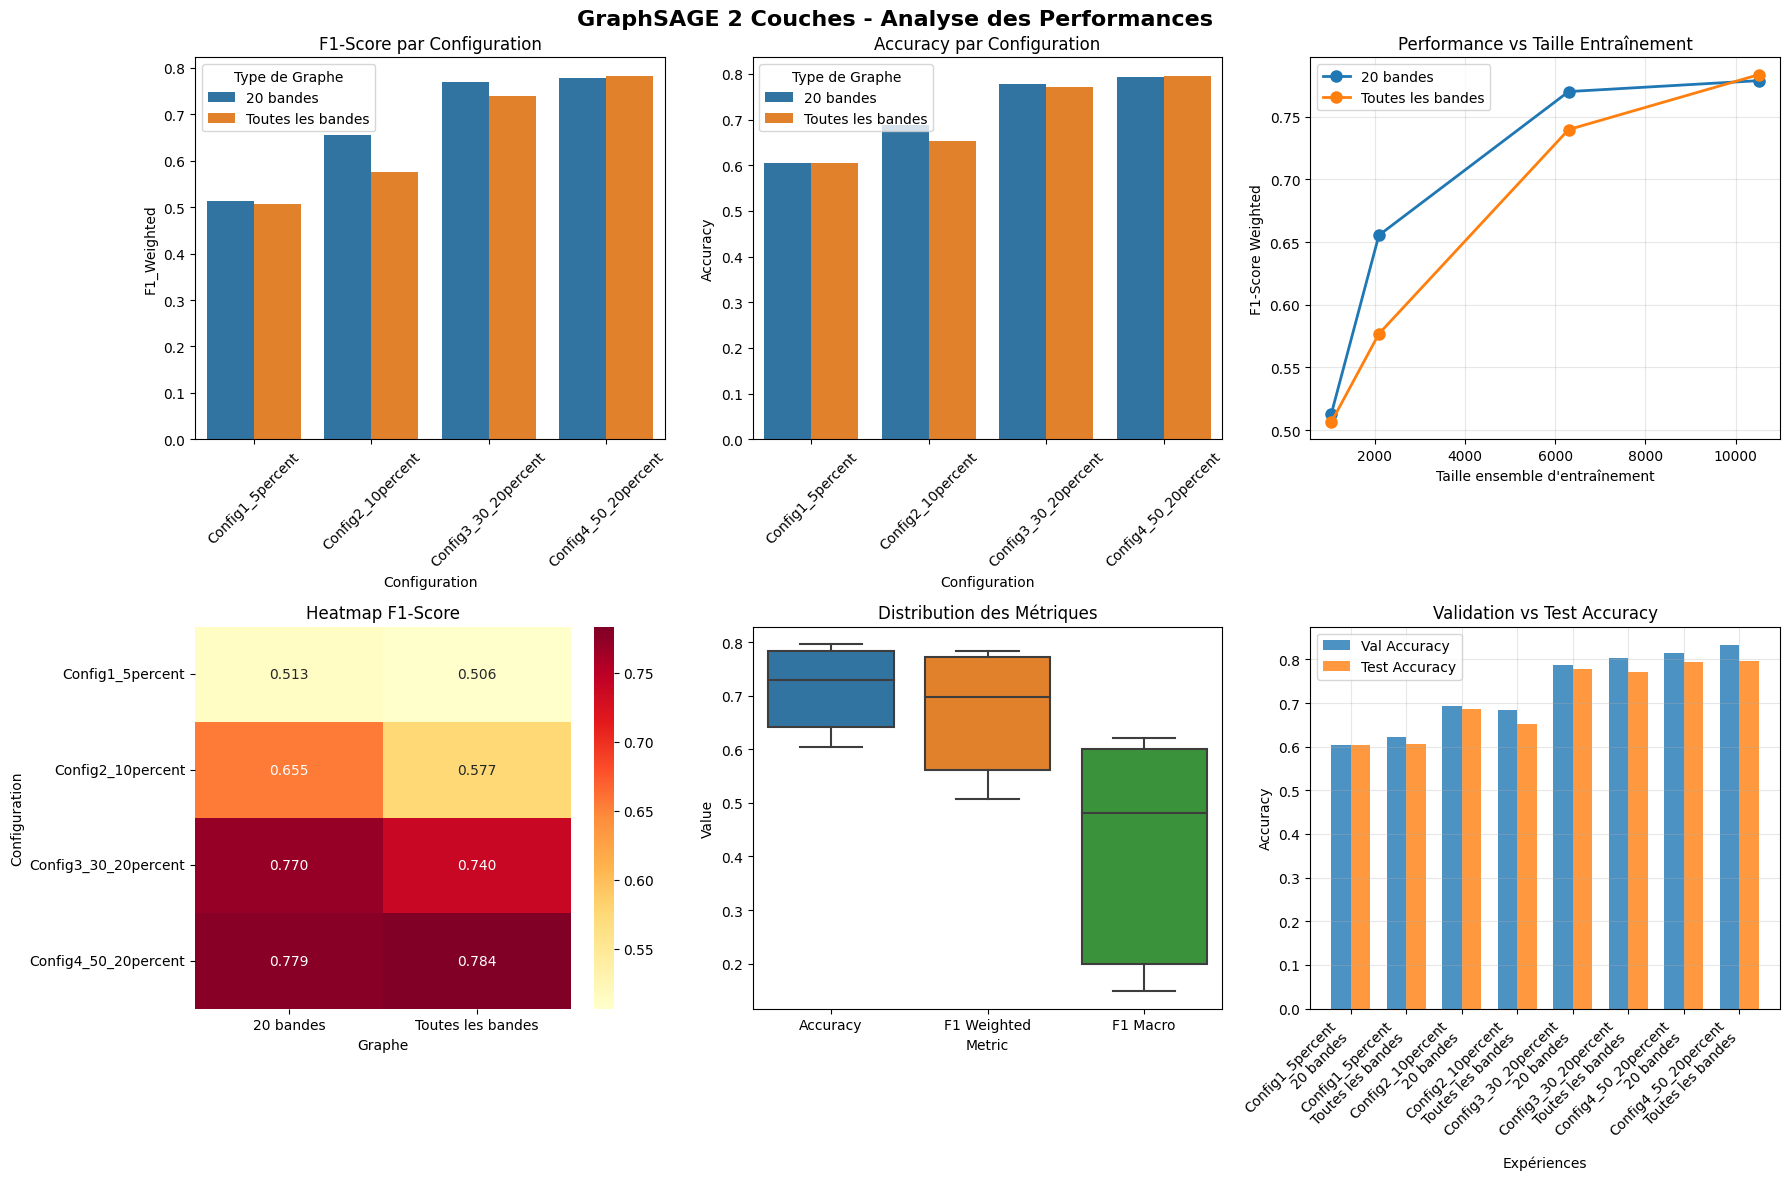

📊 Visualisations sauvegardées: /kaggle/working/graphsage_2layer_analysis.png


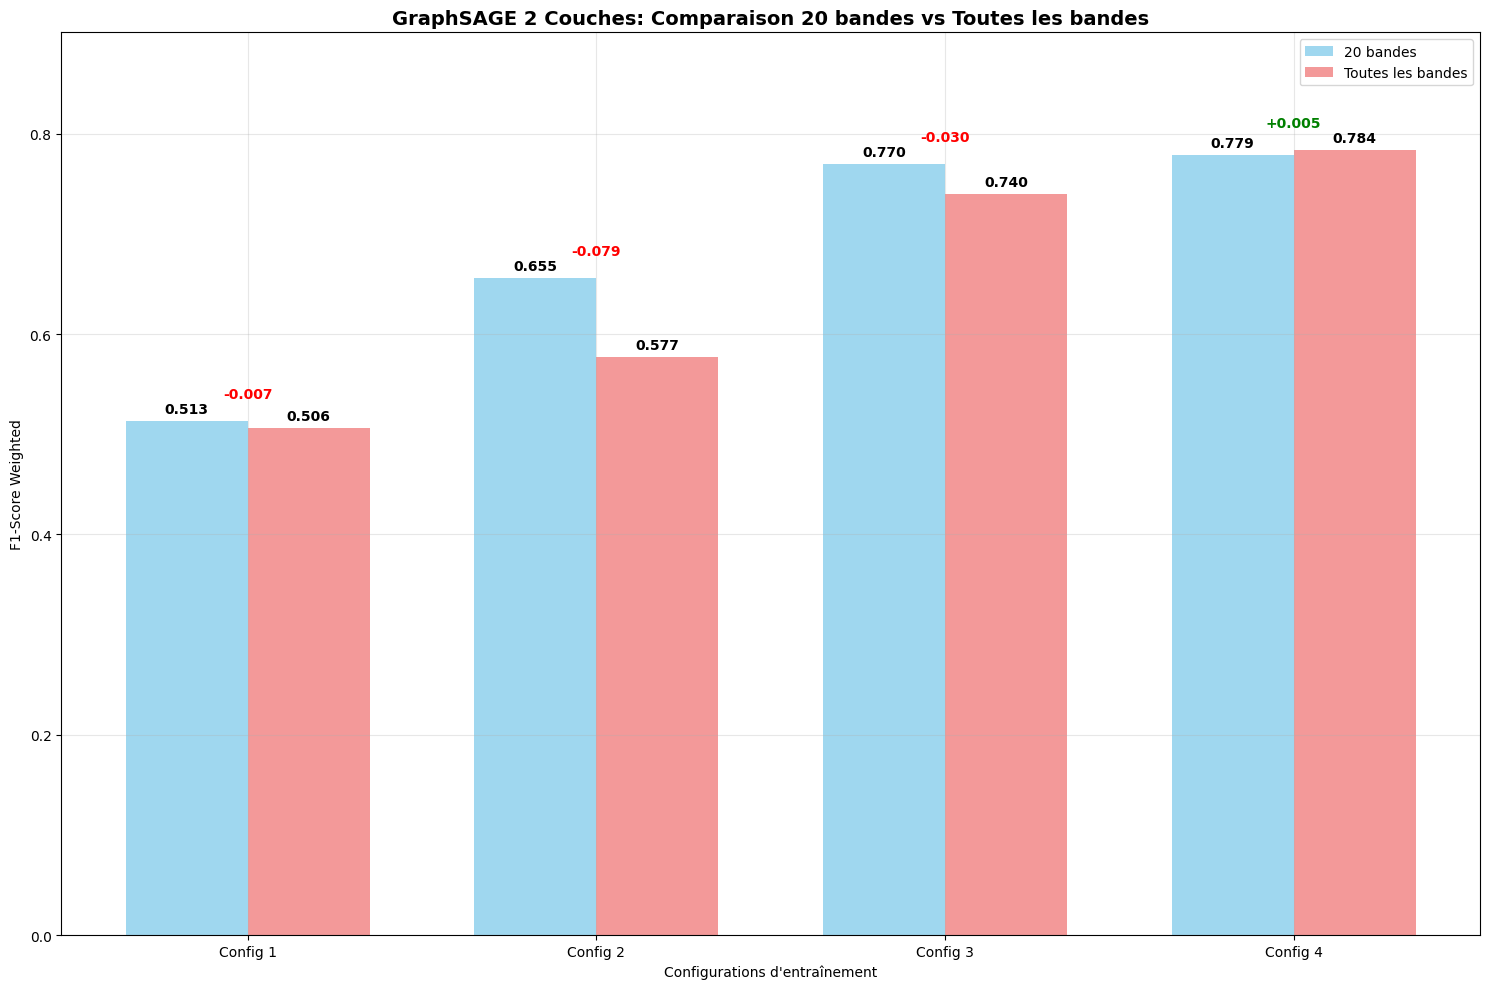

📊 Comparaison détaillée sauvegardée: /kaggle/working/graphsage_2layer_bands_comparison.png

📈 ANALYSE COMPARATIVE 20 BANDES vs TOUTES LES BANDES:
   Config1_5percent: 0.5132 → 0.5065 (-0.0068, -1.3%)
   Config2_10percent: 0.6554 → 0.5768 (-0.0786, -12.0%)
   Config3_30_20percent: 0.7701 → 0.7398 (-0.0303, -3.9%)
   Config4_50_20percent: 0.7788 → 0.7835 (+0.0047, +0.6%)

🎉 EXPÉRIMENTATIONS GRAPHSAGE 2 COUCHES TERMINÉES!
✅ 8 expériences optimisées réalisées
✅ Comparaison 20 bandes vs Toutes les bandes
✅ Impact des configurations d'entraînement analysé
✅ Visualisations détaillées créées
✅ Modèles sauvegardés pour déploiement


In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
import random
from collections import defaultdict
warnings.filterwarnings('ignore')

# Définir une seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# Chemins
dataset_path = "/kaggle/input/gcn-gat-graphsage"
output_path = "/kaggle/working/"

# ======================== CONFIGURATION GRAPHSAGE 2 COUCHES ========================

# Configuration optimisée pour GraphSAGE 2 couches
GRAPHSAGE_2LAYER_CONFIG = [25, 10]  # 25 voisins couche 1, 10 voisins couche 2

def print_graphsage_config():
    """Affiche la configuration GraphSAGE 2 couches"""
    print(f"📊 Configuration GraphSAGE 2 Couches:")
    print(f"   - Couche 1: {GRAPHSAGE_2LAYER_CONFIG[0]} voisins échantillonnés")
    print(f"   - Couche 2: {GRAPHSAGE_2LAYER_CONFIG[1]} voisins échantillonnés")
    print(f"   - Total théorique max: {np.prod(GRAPHSAGE_2LAYER_CONFIG)} voisins explorés")
    print(f"   - Réceptive field: 2-hop neighborhood")

# ======================== ÉCHANTILLONNAGE MANUEL GRAPHSAGE ========================

class GraphSAGE2LayerSampler:
    """
    Échantillonneur optimisé pour GraphSAGE 2 couches
    """
    def __init__(self, data, batch_size=1024):
        self.data = data
        self.batch_size = batch_size
        self.num_neighbors_list = GRAPHSAGE_2LAYER_CONFIG
        
        print(f"🔄 Initialisation échantillonneur GraphSAGE 2 couches:")
        print(f"   - Échantillonnage: {self.num_neighbors_list}")
        print(f"   - Batch size: {batch_size}")
        
        # Créer la liste d'adjacence optimisée
        self._create_adjacency_list()
        
    def _create_adjacency_list(self):
        """Crée une liste d'adjacence optimisée"""
        print("📊 Création de la liste d'adjacence...")
        
        self.adj_list = defaultdict(list)
        edge_index = self.data.edge_index
        
        # Construire la liste d'adjacence
        for i in range(edge_index.size(1)):
            src = edge_index[0, i].item()
            dst = edge_index[1, i].item()
            self.adj_list[src].append(dst)
        
        # Optimiser et calculer les statistiques
        total_edges = 0
        max_degree = 0
        
        for node in range(self.data.num_nodes):
            neighbors = list(set(self.adj_list[node]))  # Enlever les doublons
            self.adj_list[node] = neighbors
            degree = len(neighbors)
            total_edges += degree
            max_degree = max(max_degree, degree)
        
        avg_degree = total_edges / self.data.num_nodes
        print(f"   ✅ Degré moyen: {avg_degree:.2f}")
        print(f"   ✅ Degré maximum: {max_degree}")
        print(f"   ✅ Total connexions: {total_edges:,}")
        
    def sample_neighbors(self, nodes, num_samples):
        """Échantillonne efficacement les voisins"""
        sampled_neighbors = set()
        
        for node in nodes:
            neighbors = self.adj_list[node]
            
            if len(neighbors) == 0:
                continue
            elif len(neighbors) <= num_samples:
                sampled_neighbors.update(neighbors)
            else:
                sampled = random.sample(neighbors, num_samples)
                sampled_neighbors.update(sampled)
        
        return sampled_neighbors
    
    def create_2layer_subgraph(self, target_nodes):
        """
        Crée un sous-graphe optimisé pour GraphSAGE 2 couches
        """
        # Initialiser avec les nœuds cibles
        layer_0_nodes = set(target_nodes)  # Nœuds cibles
        all_nodes = set(target_nodes)
        
        # Couche 1: Échantillonner 25 voisins
        layer_1_neighbors = self.sample_neighbors(list(layer_0_nodes), self.num_neighbors_list[1])
        all_nodes.update(layer_1_neighbors)
        
        # Couche 2: Échantillonner 10 voisins pour chaque voisin de couche 1
        layer_2_neighbors = self.sample_neighbors(list(layer_1_neighbors), self.num_neighbors_list[0])
        all_nodes.update(layer_2_neighbors)
        
        # Convertir en liste ordonnée
        subgraph_nodes = list(all_nodes)
        node_to_idx = {node: idx for idx, node in enumerate(subgraph_nodes)}
        
        # Construire les arêtes du sous-graphe
        edge_index = self.data.edge_index
        subgraph_edges = []
        
        for i in range(edge_index.size(1)):
            src = edge_index[0, i].item()
            dst = edge_index[1, i].item()
            
            if src in node_to_idx and dst in node_to_idx:
                subgraph_edges.append([node_to_idx[src], node_to_idx[dst]])
        
        # Créer les tensors
        if subgraph_edges:
            subgraph_edge_index = torch.tensor(subgraph_edges).t().contiguous()
        else:
            subgraph_edge_index = torch.empty((2, 0), dtype=torch.long)
        
        subgraph_x = self.data.x[subgraph_nodes]
        target_indices_in_subgraph = [node_to_idx[node] for node in target_nodes]
        
        return {
            'x': subgraph_x,
            'edge_index': subgraph_edge_index,
            'target_indices': target_indices_in_subgraph,
            'target_nodes': target_nodes,
            'subgraph_size': len(subgraph_nodes),
            'num_edges': len(subgraph_edges)
        }

class GraphSAGE2LayerDataLoader:
    """DataLoader optimisé pour GraphSAGE 2 couches"""
    def __init__(self, data, mask, batch_size=1024, shuffle=True):
        self.data = data
        self.mask = mask
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Obtenir les indices des nœuds
        self.node_indices = torch.nonzero(mask).squeeze()
        if self.node_indices.dim() == 0:
            self.node_indices = self.node_indices.unsqueeze(0)
        self.node_indices = self.node_indices.tolist()
        
        # Créer l'échantillonneur
        self.sampler = GraphSAGE2LayerSampler(data, batch_size)
        
        print(f"📊 DataLoader GraphSAGE 2 couches:")
        print(f"   - Nœuds à traiter: {len(self.node_indices):,}")
        print(f"   - Nombre de batches: {len(self)}")
    
    def __len__(self):
        return (len(self.node_indices) + self.batch_size - 1) // self.batch_size
    
    def __iter__(self):
        indices = self.node_indices.copy()
        if self.shuffle:
            random.shuffle(indices)
        
        for i in range(0, len(indices), self.batch_size):
            batch_nodes = indices[i:i + self.batch_size]
            
            # Créer le sous-graphe 2-couches
            subgraph = self.sampler.create_2layer_subgraph(batch_nodes)
            batch_labels = self.data.y[batch_nodes]
            
            yield {
                'x': subgraph['x'],
                'edge_index': subgraph['edge_index'],
                'y': batch_labels,
                'target_indices': torch.tensor(subgraph['target_indices']),
                'batch_size': len(batch_nodes),
                'subgraph_info': {
                    'nodes': subgraph['subgraph_size'],
                    'edges': subgraph['num_edges']
                }
            }

# ======================== MODÈLE GRAPHSAGE 2 COUCHES ========================

class OptimizedGraphSAGE2Layer(torch.nn.Module):
    """
    Modèle GraphSAGE 2 couches optimisé
    """
    def __init__(self, num_features, num_classes, hidden_channels=128, 
                 dropout=0.5, aggregator='mean'):
        super(OptimizedGraphSAGE2Layer, self).__init__()
        
        self.num_features = num_features
        self.num_classes = num_classes
        self.hidden_channels = hidden_channels
        self.dropout = dropout
        self.num_neighbors = GRAPHSAGE_2LAYER_CONFIG
        
        # Couches GraphSAGE
        self.conv1 = SAGEConv(num_features, hidden_channels, aggr=aggregator)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr=aggregator)
        
        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)
        
        # Couche de normalisation (optionnelle mais améliore souvent les performances)
        self.batch_norm = nn.BatchNorm1d(hidden_channels)
        
        print(f"🏗️ Modèle GraphSAGE 2 Couches créé:")
        print(f"   - Architecture: {num_features} → {hidden_channels} → {hidden_channels} → {num_classes}")
        print(f"   - Échantillonnage: {self.num_neighbors}")
        print(f"   - Agrégateur: {aggregator}")
        print(f"   - Dropout: {dropout}")
        
    def forward(self, x, edge_index, target_indices=None):
        """Forward pass optimisé"""
        # Première couche GraphSAGE
        x = self.conv1(x, edge_index)
        x = self.batch_norm(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Deuxième couche GraphSAGE
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Extraire les embeddings des nœuds cibles
        if target_indices is not None:
            x = x[target_indices]
        
        # Classification finale
        x = self.classifier(x)
        
        return x

# ======================== FONCTIONS DE DIVISION DES DONNÉES ========================

def create_data_splits_config1(data, include_background=True):
    """Config 1: 5% train, 5% val, 90% test"""
    train_percent, val_percent = 0.05, 0.05
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 1 (5% train)")

def create_data_splits_config2(data, include_background=True):
    """Config 2: 10% train, 10% val, 80% test"""
    train_percent, val_percent = 0.10, 0.10
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 2 (10% train)")

def create_data_splits_config3(data, include_background=True):
    """Config 3: 30% train, 20% val, 50% test"""
    train_percent, val_percent = 0.30, 0.20
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 3 (30% train)")

def create_data_splits_config4(data, include_background=True):
    """Config 4: 50% train, 20% val, 30% test"""
    train_percent, val_percent = 0.50, 0.20
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 4 (50% train)")

def _create_splits_by_class(data, train_percent, val_percent, include_background, config_name):
    """Fonction helper pour créer les divisions par classe"""
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices, val_indices, test_indices = [], [], []
    
    print(f"\n{config_name} - Répartition par classe:")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        if n_test <= 0:
            n_train, n_val = 1, 1 if total_samples >= 3 else 0
            n_test = total_samples - n_train - n_val
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

# ======================== FONCTION D'ENTRAÎNEMENT PRINCIPALE ========================

def train_graphsage_2layer(graph_path, config_name, split_function, 
                          epochs=50, patience=15, lr=0.01, device='cuda', 
                          include_background=True, batch_size=1024):
    """
    Entraîne le modèle GraphSAGE 2 couches optimisé
    """
    print(f"\n{'='*80}")
    print(f"🚀 GRAPHSAGE 2 COUCHES - ENTRAÎNEMENT")
    print(f"📊 Graphe: {os.path.basename(graph_path)}")
    print(f"⚙️ Configuration: {config_name}")
    print(f"{'='*80}")
    
    # Charger le graphe
    try:
        data = torch.load(graph_path, weights_only=False)
    except Exception as e:
        print(f"❌ Erreur de chargement: {e}")
        try:
            import torch.serialization
            from torch_geometric.data import Data
            torch.serialization.add_safe_globals([Data])
            data = torch.load(graph_path, weights_only=False)
        except Exception as e2:
            print(f"❌ Erreur méthode 2: {e2}")
            return None, None
    
    # Informations du graphe
    num_features = data.x.shape[1]
    num_classes = int(data.y.max().item() + 1) if include_background else int(data.y.max().item())
    
    print(f"📋 Informations du graphe:")
    print(f"   - Nœuds: {data.num_nodes:,}")
    print(f"   - Arêtes: {data.num_edges:,}")
    print(f"   - Features: {num_features}")
    print(f"   - Classes: {num_classes}")
    
    print_graphsage_config()
    
    # Créer les divisions
    train_indices, val_indices, test_indices = split_function(data, include_background)
    
    # Créer les masques
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Statistiques
    train_size = train_mask.sum().item()
    val_size = val_mask.sum().item()
    test_size = test_mask.sum().item()
    
    print(f"\n📊 Répartition finale:")
    print(f"   - Entraînement: {train_size:,} pixels ({train_size/(train_size+val_size+test_size):.1%})")
    print(f"   - Validation: {val_size:,} pixels ({val_size/(train_size+val_size+test_size):.1%})")
    print(f"   - Test: {test_size:,} pixels ({test_size/(train_size+val_size+test_size):.1%})")
    
    # Créer le modèle
    model = OptimizedGraphSAGE2Layer(num_features, num_classes).to(device)
    
    # Créer les DataLoaders
    train_loader = GraphSAGE2LayerDataLoader(data, train_mask, batch_size, shuffle=True)
    val_loader = GraphSAGE2LayerDataLoader(data, val_mask, batch_size, shuffle=False)
    test_loader = GraphSAGE2LayerDataLoader(data, test_mask, batch_size, shuffle=False)
    
    print(f"\n🔄 Configuration d'entraînement:")
    print(f"   - Batch size: {batch_size}")
    print(f"   - Learning rate: {lr}")
    print(f"   - Max epochs: {epochs}")
    print(f"   - Patience: {patience}")
    print(f"   - Device: {device}")
    
    # Optimizer et scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.7, patience=8, verbose=True, min_lr=1e-6
    )
    
    # Variables d'entraînement
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    train_losses, val_losses, val_accuracies = [], [], []
    
    print(f"\n🎯 Début de l'entraînement...")
    
    for epoch in range(epochs):
        # ===== ENTRAÎNEMENT =====
        model.train()
        total_train_loss = 0
        num_batches = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train", leave=False)
        for batch in train_pbar:
            batch_x = batch['x'].to(device)
            batch_edge_index = batch['edge_index'].to(device)
            batch_y = batch['y'].to(device)
            batch_target_indices = batch['target_indices'].to(device)
            
            optimizer.zero_grad()
            out = model(batch_x, batch_edge_index, batch_target_indices)
            loss = F.cross_entropy(out, batch_y)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            num_batches += 1
            
            # Update progress bar
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_train_loss = total_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # ===== VALIDATION =====
        model.eval()
        total_val_loss = 0
        total_correct = 0
        total_samples = 0
        num_val_batches = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val", leave=False)
            for batch in val_pbar:
                batch_x = batch['x'].to(device)
                batch_edge_index = batch['edge_index'].to(device)
                batch_y = batch['y'].to(device)
                batch_target_indices = batch['target_indices'].to(device)
                
                out = model(batch_x, batch_edge_index, batch_target_indices)
                val_loss = F.cross_entropy(out, batch_y)
                pred = out.argmax(dim=1)
                correct = (pred == batch_y).sum().item()
                
                total_val_loss += val_loss.item()
                total_correct += correct
                total_samples += batch_y.size(0)
                num_val_batches += 1
                
                # Update progress bar
                val_pbar.set_postfix({'Loss': f'{val_loss.item():.4f}'})
        
        avg_val_loss = total_val_loss / num_val_batches
        val_acc = total_correct / total_samples
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        
        # Scheduler step
        scheduler.step(val_acc)
        
        # Affichage des résultats
        print(f"Epoch {epoch+1:3d}/{epochs}: "
              f"Train Loss={avg_train_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, "
              f"Val Acc={val_acc:.4f}")
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"🎯 Nouveau meilleur modèle! Val Acc: {val_acc:.4f}")
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"⏹️ Arrêt précoce à l'époque {epoch+1}")
            break
    
    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    
    # ===== ÉVALUATION FINALE =====
    print(f"\n🎯 Évaluation finale sur l'ensemble de test...")
    
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc="Test final")
        for batch in test_pbar:
            batch_x = batch['x'].to(device)
            batch_edge_index = batch['edge_index'].to(device)
            batch_y = batch['y'].to(device)
            batch_target_indices = batch['target_indices'].to(device)
            
            out = model(batch_x, batch_edge_index, batch_target_indices)
            pred = out.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    # Calculer les métriques finales
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    accuracy = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Afficher les résultats finaux
    print(f"\n🏆 RÉSULTATS FINAUX:")
    print(f"   ✅ Test Accuracy: {accuracy:.4f}")
    print(f"   ✅ F1-Score Weighted: {f1_weighted:.4f}")
    print(f"   ✅ F1-Score Macro: {f1_macro:.4f}")
    print(f"   ✅ Meilleure Val Accuracy: {best_val_acc:.4f}")
    
    # Préparer les résultats
    results = {
        'config': config_name,
        'graph': os.path.basename(graph_path),
        'model_type': 'GraphSAGE_2Layer',
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_per_class': f1_per_class.tolist(),
        'best_val_accuracy': best_val_acc,
        'train_size': train_size,
        'val_size': val_size,
        'test_size': test_size,
        'num_features': num_features,
        'num_classes': num_classes,
        'sampling_config': GRAPHSAGE_2LAYER_CONFIG,
        'epochs_trained': epoch + 1,
        'batch_size': batch_size
    }
    
    # Sauvegarder le modèle
    model_filename = f"graphsage_2layer_{config_name}_{os.path.basename(graph_path).split('.')[0]}.pt"
    model_path = os.path.join(output_path, model_filename)
    torch.save(model, model_path)
    print(f"💾 Modèle sauvegardé: {model_filename}")
    
    return model, results

# ======================== EXPÉRIMENTATIONS OPTIMISÉES ========================

def run_optimized_graphsage_experiments():
    """
    Lance les 8 expérimentations GraphSAGE 2 couches optimisées
    2 graphes × 4 configurations = 8 expériences
    """
    print("="*100)
    print("🚀 EXPÉRIMENTATIONS GRAPHSAGE 2 COUCHES OPTIMISÉES")
    print("📊 2 Graphes (20 bandes + Toutes bandes) × 4 Configurations = 8 Expériences")
    print("="*100)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️ Device utilisé: {device}")
    
    # Graphes sélectionnés
    graph_paths = [
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_allbands.pt")
    ]
    
    # Configurations de division
    configs = [
        {'name': 'Config1_5percent', 'function': create_data_splits_config1, 
         'description': '5% train, 5% val, 90% test'},
        {'name': 'Config2_10percent', 'function': create_data_splits_config2, 
         'description': '10% train, 10% val, 80% test'},
        {'name': 'Config3_30_20percent', 'function': create_data_splits_config3, 
         'description': '30% train, 20% val, 50% test'},
        {'name': 'Config4_50_20percent', 'function': create_data_splits_config4, 
         'description': '50% train, 20% val, 30% test'}
    ]
    
    # Vérifier les graphes existants
    existing_graphs = [p for p in graph_paths if os.path.exists(p)]
    
    if not existing_graphs:
        print("❌ Aucun graphe trouvé! Vérifiez les chemins:")
        for path in graph_paths:
            print(f"   - {path}")
        return {}, pd.DataFrame()
    
    print(f"📊 Graphes trouvés: {len(existing_graphs)}")
    for path in existing_graphs:
        print(f"   ✅ {os.path.basename(path)}")
    
    # Stockage des résultats
    all_results = {}
    experiment_data = []
    
    # Compteur d'expériences
    experiment_count = 0
    total_experiments = len(existing_graphs) * len(configs)
    
    # Lancer les expérimentations
    for config in configs:
        print(f"\n{'#'*80}")
        print(f"# CONFIGURATION: {config['description']}")
        print(f"{'#'*80}")
        
        for graph_path in existing_graphs:
            experiment_count += 1
            
            print(f"\n🔄 Expérience {experiment_count}/{total_experiments}")
            
            try:
                # Entraîner le modèle
                model, results = train_graphsage_2layer(
                    graph_path=graph_path,
                    config_name=config['name'],
                    split_function=config['function'],
                    epochs=50,
                    patience=15,
                    lr=0.01,
                    device=device,
                    batch_size=1024
                )
                
                # Stocker les résultats
                exp_key = f"GraphSAGE2L_{config['name']}_{os.path.basename(graph_path)}"
                all_results[exp_key] = results
                
                # Déterminer le type de graphe
                graph_name = os.path.basename(graph_path)
                if "20bands" in graph_name:
                    bands_type = "20 bandes"
                elif "allbands" in graph_name:
                    bands_type = "Toutes les bandes"
                else:
                    bands_type = "Inconnu"
                
                # Ajouter aux données d'expérimentation
                experiment_data.append({
                    'Configuration': config['name'],
                    'Description': config['description'],
                    'Graphe': bands_type,
                    'Model_Type': 'GraphSAGE 2 Couches',
                    'Nombre_Features': results['num_features'],
                    'Sampling_Config': str(results['sampling_config']),
                    'Batch_Size': results['batch_size'],
                    'Epochs_Trained': results['epochs_trained'],
                    'Taille_Train': results['train_size'],
                    'Taille_Val': results['val_size'],
                    'Taille_Test': results['test_size'],
                    'Accuracy': results['accuracy'],
                    'F1_Weighted': results['f1_weighted'],
                    'F1_Macro': results['f1_macro'],
                    'Best_Val_Acc': results['best_val_accuracy']
                })
                
                print(f"✅ Expérience {experiment_count} terminée avec succès!")
                print(f"📊 Résultats: Acc={results['accuracy']:.4f}, F1={results['f1_weighted']:.4f}")
                
            except Exception as e:
                print(f"❌ Erreur pour {graph_path} avec {config['name']}: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(experiment_data)
    
    # Sauvegarder les résultats
    results_csv_path = os.path.join(output_path, "graphsage_2layer_optimized_experiments.csv")
    results_df.to_csv(results_csv_path, index=False)
    
    print(f"\n{'='*100}")
    print("🏆 RÉSULTATS FINAUX - GRAPHSAGE 2 COUCHES OPTIMISÉ")
    print(f"{'='*100}")
    
    if not results_df.empty:
        print(results_df.to_string(index=False))
        
        # Statistiques résumées
        print(f"\n📊 STATISTIQUES RÉSUMÉES:")
        print(f"   - Expériences réussies: {len(results_df)}/{total_experiments}")
        print(f"   - Accuracy moyenne: {results_df['Accuracy'].mean():.4f} ± {results_df['Accuracy'].std():.4f}")
        print(f"   - F1-Score moyen: {results_df['F1_Weighted'].mean():.4f} ± {results_df['F1_Weighted'].std():.4f}")
        
        # Meilleur résultat
        best_idx = results_df['F1_Weighted'].idxmax()
        best_result = results_df.iloc[best_idx]
        print(f"\n🥇 MEILLEUR RÉSULTAT:")
        print(f"   - Configuration: {best_result['Description']}")
        print(f"   - Graphe: {best_result['Graphe']}")
        print(f"   - Accuracy: {best_result['Accuracy']:.4f}")
        print(f"   - F1-Score: {best_result['F1_Weighted']:.4f}")
        
    else:
        print("❌ Aucune expérience n'a réussi!")
    
    print(f"\n💾 Résultats sauvegardés dans: {results_csv_path}")
    
    return all_results, results_df

# ======================== VISUALISATIONS ========================

def create_optimized_visualizations(results_df):
    """Crée des visualisations pour les résultats GraphSAGE 2 couches"""
    if results_df.empty:
        print("❌ Pas de données à visualiser!")
        return
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GraphSAGE 2 Couches - Analyse des Performances', fontsize=16, fontweight='bold')
    
    # 1. Comparaison F1-Score par configuration
    ax1 = axes[0, 0]
    sns.barplot(data=results_df, x='Configuration', y='F1_Weighted', hue='Graphe', ax=ax1)
    ax1.set_title('F1-Score par Configuration')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.legend(title='Type de Graphe')
    
    # 2. Comparaison Accuracy par configuration
    ax2 = axes[0, 1]
    sns.barplot(data=results_df, x='Configuration', y='Accuracy', hue='Graphe', ax=ax2)
    ax2.set_title('Accuracy par Configuration')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.legend(title='Type de Graphe')
    
    # 3. Performance vs Taille d'entraînement
    ax3 = axes[0, 2]
    for graphe in results_df['Graphe'].unique():
        subset = results_df[results_df['Graphe'] == graphe]
        ax3.plot(subset['Taille_Train'], subset['F1_Weighted'], 
                marker='o', label=graphe, linewidth=2, markersize=8)
    ax3.set_xlabel('Taille ensemble d\'entraînement')
    ax3.set_ylabel('F1-Score Weighted')
    ax3.set_title('Performance vs Taille Entraînement')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Heatmap des performances
    ax4 = axes[1, 0]
    pivot_table = results_df.pivot(index='Configuration', columns='Graphe', values='F1_Weighted')
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax4)
    ax4.set_title('Heatmap F1-Score')
    
    # 5. Distribution des métriques
    ax5 = axes[1, 1]
    metrics_data = []
    for _, row in results_df.iterrows():
        metrics_data.extend([
            {'Metric': 'Accuracy', 'Value': row['Accuracy'], 'Config': row['Configuration']},
            {'Metric': 'F1_Weighted', 'Value': row['F1_Weighted'], 'Config': row['Configuration']},
            {'Metric': 'F1_Macro', 'Value': row['F1_Macro'], 'Config': row['Configuration']}
        ])
    
    metrics_df = pd.DataFrame(metrics_data)
    sns.boxplot(data=metrics_df, x='Metric', y='Value', ax=ax5)
    ax5.set_title('Distribution des Métriques')
    ax5.set_xticklabels(['Accuracy', 'F1 Weighted', 'F1 Macro'])
    
    # 6. Comparaison Training vs Validation
    ax6 = axes[1, 2]
    x_pos = np.arange(len(results_df))
    width = 0.35
    
    ax6.bar(x_pos - width/2, results_df['Best_Val_Acc'], width, label='Val Accuracy', alpha=0.8)
    ax6.bar(x_pos + width/2, results_df['Accuracy'], width, label='Test Accuracy', alpha=0.8)
    
    ax6.set_xlabel('Expériences')
    ax6.set_ylabel('Accuracy')
    ax6.set_title('Validation vs Test Accuracy')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels([f"{row['Configuration']}\n{row['Graphe']}" for _, row in results_df.iterrows()], 
                       rotation=45, ha='right')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Sauvegarder
    viz_path = os.path.join(output_path, "graphsage_2layer_analysis.png")
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Visualisations sauvegardées: {viz_path}")
    
    # Créer un graphique de comparaison détaillé
    create_detailed_comparison(results_df)

def create_detailed_comparison(results_df):
    """Crée une comparaison détaillée entre 20 bandes et toutes les bandes"""
    plt.figure(figsize=(15, 10))
    
    # Comparer les performances par configuration
    configs = results_df['Configuration'].unique()
    bands_20 = []
    bands_all = []
    
    for config in configs:
        result_20 = results_df[(results_df['Configuration'] == config) & 
                              (results_df['Graphe'] == '20 bandes')]['F1_Weighted']
        result_all = results_df[(results_df['Configuration'] == config) & 
                               (results_df['Graphe'] == 'Toutes les bandes')]['F1_Weighted']
        
        bands_20.append(result_20.iloc[0] if len(result_20) > 0 else 0)
        bands_all.append(result_all.iloc[0] if len(result_all) > 0 else 0)
    
    x = np.arange(len(configs))
    width = 0.35
    
    plt.bar(x - width/2, bands_20, width, label='20 bandes', alpha=0.8, color='skyblue')
    plt.bar(x + width/2, bands_all, width, label='Toutes les bandes', alpha=0.8, color='lightcoral')
    
    # Ajouter les valeurs sur les barres
    for i, (v20, vall) in enumerate(zip(bands_20, bands_all)):
        plt.text(i - width/2, v20 + 0.005, f'{v20:.3f}', ha='center', va='bottom', fontweight='bold')
        plt.text(i + width/2, vall + 0.005, f'{vall:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Calculer et afficher l'amélioration
        improvement = vall - v20
        color = 'green' if improvement > 0 else 'red'
        plt.text(i, max(v20, vall) + 0.02, f'+{improvement:.3f}' if improvement > 0 else f'{improvement:.3f}', 
                ha='center', va='bottom', color=color, fontweight='bold')
    
    plt.xlabel('Configurations d\'entraînement')
    plt.ylabel('F1-Score Weighted')
    plt.title('GraphSAGE 2 Couches: Comparaison 20 bandes vs Toutes les bandes', fontsize=14, fontweight='bold')
    plt.xticks(x, [f"Config {i+1}" for i in range(len(configs))])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, max(max(bands_20), max(bands_all)) * 1.15)
    
    plt.tight_layout()
    
    # Sauvegarder
    comparison_path = os.path.join(output_path, "graphsage_2layer_bands_comparison.png")
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Comparaison détaillée sauvegardée: {comparison_path}")
    
    # Afficher les statistiques de comparaison
    print(f"\n📈 ANALYSE COMPARATIVE 20 BANDES vs TOUTES LES BANDES:")
    for i, config in enumerate(configs):
        improvement = bands_all[i] - bands_20[i]
        percentage_improvement = (improvement / bands_20[i]) * 100 if bands_20[i] > 0 else 0
        print(f"   {config}: {bands_20[i]:.4f} → {bands_all[i]:.4f} "
              f"({improvement:+.4f}, {percentage_improvement:+.1f}%)")

# ======================== FONCTION PRINCIPALE ========================

def main():
    """Fonction principale pour lancer les expérimentations GraphSAGE 2 couches"""
    print("🚀 LANCEMENT DES EXPÉRIMENTATIONS GRAPHSAGE 2 COUCHES OPTIMISÉES")
    print("="*80)
    
    # Configuration globale
    print("📋 CONFIGURATION:")
    print(f"   - Architecture: GraphSAGE 2 Couches")
    print(f"   - Échantillonnage: {GRAPHSAGE_2LAYER_CONFIG}")
    print(f"   - Graphes: 20 bandes + Toutes les bandes")
    print(f"   - Configurations: 4 divisions de données")
    print(f"   - Total expériences: 8")
    print(f"   - Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    
    # Lancer les expérimentations
    all_results, results_df = run_optimized_graphsage_experiments()
    
    # Créer les visualisations
    if not results_df.empty:
        print(f"\n🎨 Création des visualisations...")
        create_optimized_visualizations(results_df)
    
    # Message final
    print(f"\n{'='*80}")
    print("🎉 EXPÉRIMENTATIONS GRAPHSAGE 2 COUCHES TERMINÉES!")
    print("="*80)
    print("✅ 8 expériences optimisées réalisées")
    print("✅ Comparaison 20 bandes vs Toutes les bandes")
    print("✅ Impact des configurations d'entraînement analysé")
    print("✅ Visualisations détaillées créées")
    print("✅ Modèles sauvegardés pour déploiement")
    print("="*80)
    
    return all_results, results_df

# ======================== POINT D'ENTRÉE ========================

if __name__ == "__main__":
    # Lancement direct des expérimentations complètes
    main()

### Expérimentation GraphSAGE 3 Couches

🚀 LANCEMENT DES EXPÉRIMENTATIONS GRAPHSAGE 3 COUCHES OPTIMISÉES
📋 CONFIGURATION:
   - Architecture: GraphSAGE 3 Couches (Profondeur maximale)
   - Échantillonnage: [25, 15, 5]
   - Graphes: 20 bandes + Toutes les bandes
   - Configurations: 4 divisions de données
   - Total expériences: 8
   - Device: CUDA
   - Spécialités: 3-hop patterns, connexions résiduelles, anti-over-smoothing
🚀 EXPÉRIMENTATIONS GRAPHSAGE 3 COUCHES OPTIMISÉES
📊 2 Graphes (20 bandes + Toutes bandes) × 4 Configurations = 8 Expériences
🔬 PROFONDEUR: 3-hop neighborhood pour patterns complexes
⚠️ ATTENTION: Plus lent mais plus expressif
🖥️ Device utilisé: cuda
📊 Graphes trouvés: 2
   ✅ indian_pines_graph_d1_4connectivity_20bands.pt
   ✅ indian_pines_graph_d1_4connectivity_allbands.pt

################################################################################
# CONFIGURATION: 5% train, 5% val, 90% test
################################################################################

🔄 Expérience 1/8

🚀 GRAPHSAGE 

Epoch   1/50: Train Loss=3.8709, Val Loss=2.2010, Val Acc=0.3193
🎯 Nouveau meilleur modèle! Val Acc: 0.3193


Epoch   2/50: Train Loss=2.8575, Val Loss=1.6260, Val Acc=0.4727
🎯 Nouveau meilleur modèle! Val Acc: 0.4727


Epoch   3/50: Train Loss=2.3473, Val Loss=1.3761, Val Acc=0.5110
🎯 Nouveau meilleur modèle! Val Acc: 0.5110


Epoch   4/50: Train Loss=1.9575, Val Loss=1.2814, Val Acc=0.5321
🎯 Nouveau meilleur modèle! Val Acc: 0.5321


Epoch   5/50: Train Loss=1.7641, Val Loss=1.2000, Val Acc=0.5283


Epoch   6/50: Train Loss=1.7044, Val Loss=1.1779, Val Acc=0.5561
🎯 Nouveau meilleur modèle! Val Acc: 0.5561


Epoch   7/50: Train Loss=1.8772, Val Loss=1.1839, Val Acc=0.5494


Epoch   8/50: Train Loss=1.5575, Val Loss=1.1802, Val Acc=0.5532


Epoch   9/50: Train Loss=1.5620, Val Loss=1.1345, Val Acc=0.5599
🎯 Nouveau meilleur modèle! Val Acc: 0.5599


Epoch  10/50: Train Loss=1.6051, Val Loss=1.0959, Val Acc=0.5714
🎯 Nouveau meilleur modèle! Val Acc: 0.5714


Epoch  11/50: Train Loss=1.4422, Val Loss=1.0585, Val Acc=0.5676


Epoch  12/50: Train Loss=1.3360, Val Loss=1.0272, Val Acc=0.5618


Epoch  13/50: Train Loss=1.5373, Val Loss=1.0011, Val Acc=0.5532


Epoch  14/50: Train Loss=1.3657, Val Loss=0.9896, Val Acc=0.5570


Epoch  15/50: Train Loss=1.2202, Val Loss=0.9826, Val Acc=0.5676


Epoch  16/50: Train Loss=1.3563, Val Loss=0.9653, Val Acc=0.5695


Epoch  17/50: Train Loss=1.3843, Val Loss=0.9355, Val Acc=0.5724
🎯 Nouveau meilleur modèle! Val Acc: 0.5724


Epoch  18/50: Train Loss=1.5267, Val Loss=0.9160, Val Acc=0.5791
🎯 Nouveau meilleur modèle! Val Acc: 0.5791


Epoch  19/50: Train Loss=1.3886, Val Loss=0.9098, Val Acc=0.5839
🎯 Nouveau meilleur modèle! Val Acc: 0.5839


Epoch  20/50: Train Loss=1.3093, Val Loss=0.8967, Val Acc=0.5849
🎯 Nouveau meilleur modèle! Val Acc: 0.5849


Epoch  21/50: Train Loss=1.3513, Val Loss=0.8966, Val Acc=0.5839


Epoch  22/50: Train Loss=1.2036, Val Loss=0.8929, Val Acc=0.5849


Epoch  23/50: Train Loss=1.2378, Val Loss=0.8827, Val Acc=0.5858
🎯 Nouveau meilleur modèle! Val Acc: 0.5858


Epoch  24/50: Train Loss=1.2674, Val Loss=0.8644, Val Acc=0.5916
🎯 Nouveau meilleur modèle! Val Acc: 0.5916


Epoch  25/50: Train Loss=1.2525, Val Loss=0.8498, Val Acc=0.6059
🎯 Nouveau meilleur modèle! Val Acc: 0.6059


Epoch  26/50: Train Loss=1.2418, Val Loss=0.8409, Val Acc=0.5944


Epoch  27/50: Train Loss=1.1340, Val Loss=0.8319, Val Acc=0.5791


Epoch  28/50: Train Loss=1.2476, Val Loss=0.8210, Val Acc=0.5810


Epoch  29/50: Train Loss=1.1367, Val Loss=0.8154, Val Acc=0.5868


Epoch  30/50: Train Loss=1.1263, Val Loss=0.8067, Val Acc=0.5964


Epoch  31/50: Train Loss=1.1746, Val Loss=0.8056, Val Acc=0.6165
🎯 Nouveau meilleur modèle! Val Acc: 0.6165


Epoch  32/50: Train Loss=1.1407, Val Loss=0.8006, Val Acc=0.6184
🎯 Nouveau meilleur modèle! Val Acc: 0.6184


Epoch  33/50: Train Loss=1.0781, Val Loss=0.7947, Val Acc=0.6146


Epoch  34/50: Train Loss=1.1457, Val Loss=0.8092, Val Acc=0.6098


Epoch  35/50: Train Loss=1.0119, Val Loss=0.8150, Val Acc=0.6098


Epoch  36/50: Train Loss=1.3794, Val Loss=0.8014, Val Acc=0.6165


Epoch  37/50: Train Loss=1.2741, Val Loss=0.8273, Val Acc=0.6079


Epoch  38/50: Train Loss=1.3787, Val Loss=0.8505, Val Acc=0.6117


Epoch  39/50: Train Loss=0.9642, Val Loss=0.8034, Val Acc=0.6174


Epoch  40/50: Train Loss=1.0996, Val Loss=0.7904, Val Acc=0.6222
🎯 Nouveau meilleur modèle! Val Acc: 0.6222


Epoch  41/50: Train Loss=1.2272, Val Loss=0.7895, Val Acc=0.6280
🎯 Nouveau meilleur modèle! Val Acc: 0.6280


Epoch  42/50: Train Loss=1.3414, Val Loss=0.7867, Val Acc=0.6203


Epoch  43/50: Train Loss=1.3051, Val Loss=0.7996, Val Acc=0.6117


Epoch  44/50: Train Loss=1.0969, Val Loss=0.7645, Val Acc=0.6146


Epoch  45/50: Train Loss=0.9777, Val Loss=0.7502, Val Acc=0.6184


Epoch  46/50: Train Loss=0.9794, Val Loss=0.7441, Val Acc=0.6261


Epoch  47/50: Train Loss=0.9559, Val Loss=0.7382, Val Acc=0.6328
🎯 Nouveau meilleur modèle! Val Acc: 0.6328


Epoch  48/50: Train Loss=0.9428, Val Loss=0.7289, Val Acc=0.6328


Epoch  49/50: Train Loss=0.9757, Val Loss=0.7433, Val Acc=0.6280


Epoch  50/50: Train Loss=1.2686, Val Loss=0.7443, Val Acc=0.6290

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.6509
   ✅ F1-Score Weighted: 0.5721
   ✅ F1-Score Macro: 0.2844
   ✅ Meilleure Val Accuracy: 0.6328
💾 Modèle sauvegardé: graphsage_3layer_Config1_5percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 1 terminée avec succès!
📊 Résultats: Acc=0.6509, F1=0.5721
⚡ Paramètres: 20,625

🔄 Expérience 2/8

🚀 GRAPHSAGE 3 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config1_5percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 3 Couches:
   - Couche 1: 5 voisins échantillonnés
   - Couche 2: 15 voisins échantillonnés
   - Couche 3: 25 voisins échantillonnés
   - Réceptive field: 3-hop neighborhood
   - Total théorique max: 1875 voisins explorés
   - Stratégie: Échantillonnage décroissant pour éviter l'over-

Epoch   1/50: Train Loss=3.6762, Val Loss=1.7763, Val Acc=0.5072
🎯 Nouveau meilleur modèle! Val Acc: 0.5072


Epoch   2/50: Train Loss=2.1396, Val Loss=1.9755, Val Acc=0.4909


Epoch   3/50: Train Loss=2.2570, Val Loss=1.8151, Val Acc=0.4698


Epoch   4/50: Train Loss=2.0211, Val Loss=1.6005, Val Acc=0.4516


Epoch   5/50: Train Loss=1.6599, Val Loss=1.4703, Val Acc=0.4593


Epoch   6/50: Train Loss=1.6580, Val Loss=1.4056, Val Acc=0.4746


Epoch   7/50: Train Loss=1.9030, Val Loss=1.2830, Val Acc=0.5321
🎯 Nouveau meilleur modèle! Val Acc: 0.5321


Epoch   8/50: Train Loss=1.4105, Val Loss=1.2075, Val Acc=0.5868
🎯 Nouveau meilleur modèle! Val Acc: 0.5868


Epoch   9/50: Train Loss=1.5702, Val Loss=1.1374, Val Acc=0.5868


Epoch  10/50: Train Loss=1.4337, Val Loss=1.1025, Val Acc=0.5877
🎯 Nouveau meilleur modèle! Val Acc: 0.5877


Epoch  11/50: Train Loss=1.3951, Val Loss=1.0818, Val Acc=0.5868


Epoch  12/50: Train Loss=1.4639, Val Loss=1.0754, Val Acc=0.5916
🎯 Nouveau meilleur modèle! Val Acc: 0.5916


Epoch  13/50: Train Loss=1.4746, Val Loss=1.0820, Val Acc=0.6031
🎯 Nouveau meilleur modèle! Val Acc: 0.6031


Epoch  14/50: Train Loss=1.5008, Val Loss=1.0850, Val Acc=0.6088
🎯 Nouveau meilleur modèle! Val Acc: 0.6088


Epoch  15/50: Train Loss=1.3519, Val Loss=1.0735, Val Acc=0.6213
🎯 Nouveau meilleur modèle! Val Acc: 0.6213


Epoch  16/50: Train Loss=1.2899, Val Loss=1.0350, Val Acc=0.6213


Epoch  17/50: Train Loss=1.2871, Val Loss=1.0019, Val Acc=0.6174


Epoch  18/50: Train Loss=1.2569, Val Loss=0.9813, Val Acc=0.6261
🎯 Nouveau meilleur modèle! Val Acc: 0.6261


Epoch  19/50: Train Loss=1.1570, Val Loss=0.9710, Val Acc=0.6261


Epoch  20/50: Train Loss=1.1370, Val Loss=0.9621, Val Acc=0.6318
🎯 Nouveau meilleur modèle! Val Acc: 0.6318


Epoch  21/50: Train Loss=1.2861, Val Loss=0.9466, Val Acc=0.6261


Epoch  22/50: Train Loss=1.1198, Val Loss=0.9455, Val Acc=0.6290


Epoch  23/50: Train Loss=1.1959, Val Loss=0.9496, Val Acc=0.6242


Epoch  24/50: Train Loss=1.2161, Val Loss=0.9206, Val Acc=0.6232


Epoch  25/50: Train Loss=1.2046, Val Loss=0.9117, Val Acc=0.6251


Epoch  26/50: Train Loss=1.3138, Val Loss=0.9265, Val Acc=0.6213


Epoch  27/50: Train Loss=1.2446, Val Loss=0.9534, Val Acc=0.6261


Epoch  28/50: Train Loss=1.0939, Val Loss=0.9707, Val Acc=0.6395
🎯 Nouveau meilleur modèle! Val Acc: 0.6395


Epoch  29/50: Train Loss=1.2105, Val Loss=0.9464, Val Acc=0.6251


Epoch  30/50: Train Loss=1.3060, Val Loss=0.9191, Val Acc=0.6347


Epoch  31/50: Train Loss=1.3128, Val Loss=0.9205, Val Acc=0.6347


Epoch  32/50: Train Loss=1.1955, Val Loss=0.9236, Val Acc=0.6299


Epoch  33/50: Train Loss=1.1508, Val Loss=0.9014, Val Acc=0.6290


Epoch  34/50: Train Loss=1.0111, Val Loss=0.8910, Val Acc=0.6299


Epoch  35/50: Train Loss=1.1258, Val Loss=0.9018, Val Acc=0.6299


Epoch  36/50: Train Loss=1.1246, Val Loss=0.8901, Val Acc=0.6337


Epoch  37/50: Train Loss=1.0699, Val Loss=0.8842, Val Acc=0.6357


Epoch  38/50: Train Loss=1.1827, Val Loss=0.8745, Val Acc=0.6347


Epoch  39/50: Train Loss=1.0722, Val Loss=0.8788, Val Acc=0.6376


Epoch  40/50: Train Loss=1.0955, Val Loss=0.8749, Val Acc=0.6357


Epoch  41/50: Train Loss=1.2262, Val Loss=0.8911, Val Acc=0.6366


Epoch  42/50: Train Loss=1.1979, Val Loss=0.8957, Val Acc=0.6395


Epoch  43/50: Train Loss=1.0541, Val Loss=0.8934, Val Acc=0.6500
🎯 Nouveau meilleur modèle! Val Acc: 0.6500


Epoch  44/50: Train Loss=1.1094, Val Loss=0.8747, Val Acc=0.6462


Epoch  45/50: Train Loss=1.1152, Val Loss=0.8541, Val Acc=0.6462


Epoch  46/50: Train Loss=1.2283, Val Loss=0.8420, Val Acc=0.6376


Epoch  47/50: Train Loss=1.1087, Val Loss=0.8701, Val Acc=0.6481


Epoch  48/50: Train Loss=1.1471, Val Loss=0.8639, Val Acc=0.6424


Epoch  49/50: Train Loss=1.1856, Val Loss=0.8470, Val Acc=0.6405


Epoch  50/50: Train Loss=1.1942, Val Loss=0.8596, Val Acc=0.6520
🎯 Nouveau meilleur modèle! Val Acc: 0.6520

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.6497
   ✅ F1-Score Weighted: 0.5639
   ✅ F1-Score Macro: 0.1923
   ✅ Meilleure Val Accuracy: 0.6520
💾 Modèle sauvegardé: graphsage_3layer_Config1_5percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 2 terminée avec succès!
📊 Résultats: Acc=0.6497, F1=0.5639
⚡ Paramètres: 43,665

################################################################################
# CONFIGURATION: 10% train, 10% val, 80% test
################################################################################

🔄 Expérience 3/8

🚀 GRAPHSAGE 3 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_20bands.pt
⚙️ Configuration: Config2_10percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 20
   - Classes: 17
📊 Configuration GraphSAGE 3 Couches:
   - Couche 1: 5 voisins échantillonnés
   - Couche 2: 15 voisins

Epoch   1/50: Train Loss=3.1655, Val Loss=1.7423, Val Acc=0.5155
🎯 Nouveau meilleur modèle! Val Acc: 0.5155


Epoch   2/50: Train Loss=2.1959, Val Loss=1.4781, Val Acc=0.5451
🎯 Nouveau meilleur modèle! Val Acc: 0.5451


Epoch   3/50: Train Loss=1.8595, Val Loss=1.3886, Val Acc=0.4902


Epoch   4/50: Train Loss=1.6514, Val Loss=1.2492, Val Acc=0.5494
🎯 Nouveau meilleur modèle! Val Acc: 0.5494


Epoch   5/50: Train Loss=1.4868, Val Loss=1.1388, Val Acc=0.5709
🎯 Nouveau meilleur modèle! Val Acc: 0.5709


Epoch   6/50: Train Loss=1.4475, Val Loss=1.1149, Val Acc=0.5780
🎯 Nouveau meilleur modèle! Val Acc: 0.5780


Epoch   7/50: Train Loss=1.3575, Val Loss=1.0803, Val Acc=0.6033
🎯 Nouveau meilleur modèle! Val Acc: 0.6033


Epoch   8/50: Train Loss=1.3159, Val Loss=1.0357, Val Acc=0.6053
🎯 Nouveau meilleur modèle! Val Acc: 0.6053


Epoch   9/50: Train Loss=1.3119, Val Loss=1.0179, Val Acc=0.5986


Epoch  10/50: Train Loss=1.3302, Val Loss=0.9915, Val Acc=0.6172
🎯 Nouveau meilleur modèle! Val Acc: 0.6172


Epoch  11/50: Train Loss=1.2899, Val Loss=0.9778, Val Acc=0.6172


Epoch  12/50: Train Loss=1.2823, Val Loss=0.9834, Val Acc=0.6181
🎯 Nouveau meilleur modèle! Val Acc: 0.6181


Epoch  13/50: Train Loss=1.2647, Val Loss=0.9678, Val Acc=0.6234
🎯 Nouveau meilleur modèle! Val Acc: 0.6234


Epoch  14/50: Train Loss=1.3191, Val Loss=0.9444, Val Acc=0.6339
🎯 Nouveau meilleur modèle! Val Acc: 0.6339


Epoch  15/50: Train Loss=1.2289, Val Loss=0.9516, Val Acc=0.6138


Epoch  16/50: Train Loss=1.1556, Val Loss=0.9405, Val Acc=0.6286


Epoch  17/50: Train Loss=1.1969, Val Loss=0.9194, Val Acc=0.6415
🎯 Nouveau meilleur modèle! Val Acc: 0.6415


Epoch  18/50: Train Loss=1.1981, Val Loss=0.9204, Val Acc=0.6310


Epoch  19/50: Train Loss=1.2036, Val Loss=0.8991, Val Acc=0.6315


Epoch  20/50: Train Loss=1.1278, Val Loss=0.8836, Val Acc=0.6387


Epoch  21/50: Train Loss=1.1327, Val Loss=0.8998, Val Acc=0.6348


Epoch  22/50: Train Loss=1.2141, Val Loss=0.8726, Val Acc=0.6368


Epoch  23/50: Train Loss=1.0898, Val Loss=0.8640, Val Acc=0.6291


Epoch  24/50: Train Loss=1.1118, Val Loss=0.8690, Val Acc=0.6420
🎯 Nouveau meilleur modèle! Val Acc: 0.6420


Epoch  25/50: Train Loss=1.0865, Val Loss=0.8339, Val Acc=0.6411


Epoch  26/50: Train Loss=1.1229, Val Loss=0.8372, Val Acc=0.6449
🎯 Nouveau meilleur modèle! Val Acc: 0.6449


Epoch  27/50: Train Loss=1.1029, Val Loss=0.8551, Val Acc=0.6477
🎯 Nouveau meilleur modèle! Val Acc: 0.6477


Epoch  28/50: Train Loss=1.1146, Val Loss=0.8243, Val Acc=0.6520
🎯 Nouveau meilleur modèle! Val Acc: 0.6520


Epoch  29/50: Train Loss=1.1213, Val Loss=0.8478, Val Acc=0.6525
🎯 Nouveau meilleur modèle! Val Acc: 0.6525


Epoch  30/50: Train Loss=1.0856, Val Loss=0.8243, Val Acc=0.6539
🎯 Nouveau meilleur modèle! Val Acc: 0.6539


Epoch  31/50: Train Loss=1.0700, Val Loss=0.8209, Val Acc=0.6644
🎯 Nouveau meilleur modèle! Val Acc: 0.6644


Epoch  32/50: Train Loss=1.0981, Val Loss=0.8096, Val Acc=0.6444


Epoch  33/50: Train Loss=1.0503, Val Loss=0.7998, Val Acc=0.6683
🎯 Nouveau meilleur modèle! Val Acc: 0.6683


Epoch  34/50: Train Loss=1.0202, Val Loss=0.8094, Val Acc=0.6582


Epoch  35/50: Train Loss=1.0267, Val Loss=0.7967, Val Acc=0.6587


Epoch  36/50: Train Loss=0.9947, Val Loss=0.7848, Val Acc=0.6706
🎯 Nouveau meilleur modèle! Val Acc: 0.6706


Epoch  37/50: Train Loss=1.0102, Val Loss=0.7802, Val Acc=0.6811
🎯 Nouveau meilleur modèle! Val Acc: 0.6811


Epoch  38/50: Train Loss=1.0154, Val Loss=0.8038, Val Acc=0.6687


Epoch  39/50: Train Loss=1.0875, Val Loss=0.7657, Val Acc=0.6697


Epoch  40/50: Train Loss=0.9997, Val Loss=0.7803, Val Acc=0.7021
🎯 Nouveau meilleur modèle! Val Acc: 0.7021


Epoch  41/50: Train Loss=0.9584, Val Loss=0.7857, Val Acc=0.6955


Epoch  42/50: Train Loss=1.0083, Val Loss=0.7348, Val Acc=0.7165
🎯 Nouveau meilleur modèle! Val Acc: 0.7165


Epoch  43/50: Train Loss=0.9956, Val Loss=0.7263, Val Acc=0.6883


Epoch  44/50: Train Loss=0.9666, Val Loss=0.7387, Val Acc=0.6993


Epoch  45/50: Train Loss=0.9509, Val Loss=0.7248, Val Acc=0.7332
🎯 Nouveau meilleur modèle! Val Acc: 0.7332


Epoch  46/50: Train Loss=0.9213, Val Loss=0.7201, Val Acc=0.7084


Epoch  47/50: Train Loss=0.9632, Val Loss=0.7124, Val Acc=0.7174


Epoch  48/50: Train Loss=0.9239, Val Loss=0.7111, Val Acc=0.7045


Epoch  49/50: Train Loss=0.8797, Val Loss=0.6748, Val Acc=0.7212


Epoch  50/50: Train Loss=0.9241, Val Loss=0.7017, Val Acc=0.6907

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 33/33 [00:24<00:00,  1.34it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.6836
   ✅ F1-Score Weighted: 0.6364
   ✅ F1-Score Macro: 0.4116
   ✅ Meilleure Val Accuracy: 0.7332
💾 Modèle sauvegardé: graphsage_3layer_Config2_10percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 3 terminée avec succès!
📊 Résultats: Acc=0.6836, F1=0.6364
⚡ Paramètres: 20,625

🔄 Expérience 4/8

🚀 GRAPHSAGE 3 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config2_10percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 3 Couches:
   - Couche 1: 5 voisins échantillonnés
   - Couche 2: 15 voisins échantillonnés
   - Couche 3: 25 voisins échantillonnés
   - Réceptive field: 3-hop neighborhood
   - Total théorique max: 1875 voisins explorés
   - Stratégie: Échantillonnage décroissant pour éviter l'ove

Epoch   1/50: Train Loss=3.2318, Val Loss=2.0439, Val Acc=0.5184
🎯 Nouveau meilleur modèle! Val Acc: 0.5184


Epoch   2/50: Train Loss=2.1164, Val Loss=1.7175, Val Acc=0.5356
🎯 Nouveau meilleur modèle! Val Acc: 0.5356


Epoch   3/50: Train Loss=1.8654, Val Loss=1.4104, Val Acc=0.5107


Epoch   4/50: Train Loss=1.7088, Val Loss=1.3092, Val Acc=0.5375
🎯 Nouveau meilleur modèle! Val Acc: 0.5375


Epoch   5/50: Train Loss=1.6344, Val Loss=1.2400, Val Acc=0.5671
🎯 Nouveau meilleur modèle! Val Acc: 0.5671


Epoch   6/50: Train Loss=1.4636, Val Loss=1.1958, Val Acc=0.5776
🎯 Nouveau meilleur modèle! Val Acc: 0.5776


Epoch   7/50: Train Loss=1.4481, Val Loss=1.1522, Val Acc=0.5828
🎯 Nouveau meilleur modèle! Val Acc: 0.5828


Epoch   8/50: Train Loss=1.3367, Val Loss=1.1048, Val Acc=0.5862
🎯 Nouveau meilleur modèle! Val Acc: 0.5862


Epoch   9/50: Train Loss=1.3241, Val Loss=1.0713, Val Acc=0.5909
🎯 Nouveau meilleur modèle! Val Acc: 0.5909


Epoch  10/50: Train Loss=1.3534, Val Loss=1.0662, Val Acc=0.5971
🎯 Nouveau meilleur modèle! Val Acc: 0.5971


Epoch  11/50: Train Loss=1.3617, Val Loss=1.0492, Val Acc=0.5986
🎯 Nouveau meilleur modèle! Val Acc: 0.5986


Epoch  12/50: Train Loss=1.2696, Val Loss=1.0399, Val Acc=0.6038
🎯 Nouveau meilleur modèle! Val Acc: 0.6038


Epoch  13/50: Train Loss=1.2779, Val Loss=1.0187, Val Acc=0.6200
🎯 Nouveau meilleur modèle! Val Acc: 0.6200


Epoch  14/50: Train Loss=1.2302, Val Loss=1.0348, Val Acc=0.6229
🎯 Nouveau meilleur modèle! Val Acc: 0.6229


Epoch  15/50: Train Loss=1.1838, Val Loss=1.0502, Val Acc=0.6277
🎯 Nouveau meilleur modèle! Val Acc: 0.6277


Epoch  16/50: Train Loss=1.2152, Val Loss=1.0065, Val Acc=0.6329
🎯 Nouveau meilleur modèle! Val Acc: 0.6329


Epoch  17/50: Train Loss=1.2411, Val Loss=1.0260, Val Acc=0.6339
🎯 Nouveau meilleur modèle! Val Acc: 0.6339


Epoch  18/50: Train Loss=1.1572, Val Loss=0.9615, Val Acc=0.6301


Epoch  19/50: Train Loss=1.1685, Val Loss=0.9657, Val Acc=0.6305


Epoch  20/50: Train Loss=1.1315, Val Loss=0.9841, Val Acc=0.6305


Epoch  21/50: Train Loss=1.1534, Val Loss=0.9225, Val Acc=0.6348
🎯 Nouveau meilleur modèle! Val Acc: 0.6348


Epoch  22/50: Train Loss=1.1253, Val Loss=0.9400, Val Acc=0.6387
🎯 Nouveau meilleur modèle! Val Acc: 0.6387


Epoch  23/50: Train Loss=1.1375, Val Loss=0.9135, Val Acc=0.6477
🎯 Nouveau meilleur modèle! Val Acc: 0.6477


Epoch  24/50: Train Loss=1.1085, Val Loss=0.9195, Val Acc=0.6411


Epoch  25/50: Train Loss=1.0791, Val Loss=0.8838, Val Acc=0.6558
🎯 Nouveau meilleur modèle! Val Acc: 0.6558


Epoch  26/50: Train Loss=1.0746, Val Loss=0.8893, Val Acc=0.6539


Epoch  27/50: Train Loss=1.0583, Val Loss=0.8708, Val Acc=0.6587
🎯 Nouveau meilleur modèle! Val Acc: 0.6587


Epoch  28/50: Train Loss=1.0343, Val Loss=0.8821, Val Acc=0.6673
🎯 Nouveau meilleur modèle! Val Acc: 0.6673


Epoch  29/50: Train Loss=1.0767, Val Loss=0.8428, Val Acc=0.6621


Epoch  30/50: Train Loss=1.0604, Val Loss=0.8917, Val Acc=0.6621


Epoch  31/50: Train Loss=0.9855, Val Loss=0.8499, Val Acc=0.6573


Epoch  32/50: Train Loss=1.0033, Val Loss=0.8541, Val Acc=0.6687
🎯 Nouveau meilleur modèle! Val Acc: 0.6687


Epoch  33/50: Train Loss=0.9954, Val Loss=0.8116, Val Acc=0.6821
🎯 Nouveau meilleur modèle! Val Acc: 0.6821


Epoch  34/50: Train Loss=1.0154, Val Loss=0.8543, Val Acc=0.6702


Epoch  35/50: Train Loss=0.9926, Val Loss=0.8152, Val Acc=0.6864
🎯 Nouveau meilleur modèle! Val Acc: 0.6864


Epoch  36/50: Train Loss=1.0127, Val Loss=0.8079, Val Acc=0.6883
🎯 Nouveau meilleur modèle! Val Acc: 0.6883


Epoch  37/50: Train Loss=0.9770, Val Loss=0.9113, Val Acc=0.6716


Epoch  38/50: Train Loss=0.9828, Val Loss=0.7827, Val Acc=0.6811


Epoch  39/50: Train Loss=0.9400, Val Loss=0.7933, Val Acc=0.6802


Epoch  40/50: Train Loss=0.9473, Val Loss=0.8346, Val Acc=0.6687


Epoch  41/50: Train Loss=0.9617, Val Loss=0.8025, Val Acc=0.7002
🎯 Nouveau meilleur modèle! Val Acc: 0.7002


Epoch  42/50: Train Loss=0.9546, Val Loss=0.8589, Val Acc=0.6549


Epoch  43/50: Train Loss=0.9298, Val Loss=0.8297, Val Acc=0.6644


Epoch  44/50: Train Loss=0.9134, Val Loss=0.8013, Val Acc=0.6907


Epoch  45/50: Train Loss=0.9081, Val Loss=0.7570, Val Acc=0.7084
🎯 Nouveau meilleur modèle! Val Acc: 0.7084


Epoch  46/50: Train Loss=0.9208, Val Loss=0.7561, Val Acc=0.6969


Epoch  47/50: Train Loss=0.9397, Val Loss=0.7459, Val Acc=0.7155
🎯 Nouveau meilleur modèle! Val Acc: 0.7155


Epoch  48/50: Train Loss=0.8898, Val Loss=0.7960, Val Acc=0.6549


Epoch  49/50: Train Loss=0.9079, Val Loss=0.7915, Val Acc=0.6706


Epoch  50/50: Train Loss=0.8868, Val Loss=0.7352, Val Acc=0.7017

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 33/33 [00:24<00:00,  1.34it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.7022
   ✅ F1-Score Weighted: 0.6528
   ✅ F1-Score Macro: 0.3465
   ✅ Meilleure Val Accuracy: 0.7155
💾 Modèle sauvegardé: graphsage_3layer_Config2_10percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 4 terminée avec succès!
📊 Résultats: Acc=0.7022, F1=0.6528
⚡ Paramètres: 43,665

################################################################################
# CONFIGURATION: 30% train, 20% val, 50% test
################################################################################

🔄 Expérience 5/8

🚀 GRAPHSAGE 3 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_20bands.pt
⚙️ Configuration: Config3_30_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 20
   - Classes: 17
📊 Configuration GraphSAGE 3 Couches:
   - Couche 1: 5 voisins échantillonnés
   - Couche 2: 15 voi

Epoch   1/50: Train Loss=2.6107, Val Loss=1.5259, Val Acc=0.5390
🎯 Nouveau meilleur modèle! Val Acc: 0.5390


Epoch   2/50: Train Loss=1.6214, Val Loss=1.2453, Val Acc=0.5586
🎯 Nouveau meilleur modèle! Val Acc: 0.5586


Epoch   3/50: Train Loss=1.3746, Val Loss=1.1128, Val Acc=0.6110
🎯 Nouveau meilleur modèle! Val Acc: 0.6110


Epoch   4/50: Train Loss=1.2908, Val Loss=1.0695, Val Acc=0.6126
🎯 Nouveau meilleur modèle! Val Acc: 0.6126


Epoch   5/50: Train Loss=1.2252, Val Loss=1.0048, Val Acc=0.6267
🎯 Nouveau meilleur modèle! Val Acc: 0.6267


Epoch   6/50: Train Loss=1.1781, Val Loss=0.9777, Val Acc=0.6314
🎯 Nouveau meilleur modèle! Val Acc: 0.6314


Epoch   7/50: Train Loss=1.1503, Val Loss=0.9477, Val Acc=0.6486
🎯 Nouveau meilleur modèle! Val Acc: 0.6486


Epoch   8/50: Train Loss=1.1092, Val Loss=0.9073, Val Acc=0.6719
🎯 Nouveau meilleur modèle! Val Acc: 0.6719


Epoch   9/50: Train Loss=1.0641, Val Loss=0.8940, Val Acc=0.6633


Epoch  10/50: Train Loss=1.0474, Val Loss=0.8774, Val Acc=0.6938
🎯 Nouveau meilleur modèle! Val Acc: 0.6938


Epoch  11/50: Train Loss=1.0027, Val Loss=0.8217, Val Acc=0.6950
🎯 Nouveau meilleur modèle! Val Acc: 0.6950


Epoch  12/50: Train Loss=0.9793, Val Loss=0.8289, Val Acc=0.6857


Epoch  13/50: Train Loss=0.9671, Val Loss=0.7977, Val Acc=0.7186
🎯 Nouveau meilleur modèle! Val Acc: 0.7186


Epoch  14/50: Train Loss=0.9291, Val Loss=0.7728, Val Acc=0.7143


Epoch  15/50: Train Loss=0.9109, Val Loss=0.7530, Val Acc=0.7164


Epoch  16/50: Train Loss=0.8941, Val Loss=0.7441, Val Acc=0.7169


Epoch  17/50: Train Loss=0.8686, Val Loss=0.7101, Val Acc=0.7548
🎯 Nouveau meilleur modèle! Val Acc: 0.7548


Epoch  18/50: Train Loss=0.8390, Val Loss=0.6791, Val Acc=0.7631
🎯 Nouveau meilleur modèle! Val Acc: 0.7631


Epoch  19/50: Train Loss=0.8403, Val Loss=0.6888, Val Acc=0.7500


Epoch  20/50: Train Loss=0.8259, Val Loss=0.7114, Val Acc=0.7371


Epoch  21/50: Train Loss=0.8227, Val Loss=0.6879, Val Acc=0.7590


Epoch  22/50: Train Loss=0.7913, Val Loss=0.6979, Val Acc=0.7245


Epoch  23/50: Train Loss=0.7974, Val Loss=0.6714, Val Acc=0.7471


Epoch  24/50: Train Loss=0.7697, Val Loss=0.6376, Val Acc=0.7764
🎯 Nouveau meilleur modèle! Val Acc: 0.7764


Epoch  25/50: Train Loss=0.7680, Val Loss=0.7214, Val Acc=0.7355


Epoch  26/50: Train Loss=0.7750, Val Loss=0.6845, Val Acc=0.7550


Epoch  27/50: Train Loss=0.7716, Val Loss=0.6317, Val Acc=0.7686


Epoch  28/50: Train Loss=0.7399, Val Loss=0.6443, Val Acc=0.7600


Epoch  29/50: Train Loss=0.7401, Val Loss=0.6649, Val Acc=0.7536


Epoch  30/50: Train Loss=0.7441, Val Loss=0.6237, Val Acc=0.7636


Epoch  31/50: Train Loss=0.7178, Val Loss=0.6575, Val Acc=0.7655


Epoch  32/50: Train Loss=0.7367, Val Loss=0.6063, Val Acc=0.7895
🎯 Nouveau meilleur modèle! Val Acc: 0.7895


Epoch  33/50: Train Loss=0.7118, Val Loss=0.6217, Val Acc=0.7740


Epoch  34/50: Train Loss=0.7049, Val Loss=0.6524, Val Acc=0.7614


Epoch  35/50: Train Loss=0.6971, Val Loss=0.6004, Val Acc=0.7902
🎯 Nouveau meilleur modèle! Val Acc: 0.7902


Epoch  36/50: Train Loss=0.7088, Val Loss=0.6196, Val Acc=0.7707


Epoch  37/50: Train Loss=0.6765, Val Loss=0.6508, Val Acc=0.7567


Epoch  38/50: Train Loss=0.6790, Val Loss=0.5709, Val Acc=0.7936
🎯 Nouveau meilleur modèle! Val Acc: 0.7936


Epoch  39/50: Train Loss=0.6760, Val Loss=0.5837, Val Acc=0.7833


Epoch  40/50: Train Loss=0.6898, Val Loss=0.6216, Val Acc=0.7824


Epoch  41/50: Train Loss=0.6617, Val Loss=0.5584, Val Acc=0.7860


Epoch  42/50: Train Loss=0.6705, Val Loss=0.5941, Val Acc=0.7726


Epoch  43/50: Train Loss=0.6941, Val Loss=0.6622, Val Acc=0.7660


Epoch  44/50: Train Loss=0.6749, Val Loss=0.6254, Val Acc=0.7410


Epoch  45/50: Train Loss=0.6615, Val Loss=0.5684, Val Acc=0.8083
🎯 Nouveau meilleur modèle! Val Acc: 0.8083


Epoch  46/50: Train Loss=0.6323, Val Loss=0.5411, Val Acc=0.7917


Epoch  47/50: Train Loss=0.6271, Val Loss=0.7168, Val Acc=0.7433


Epoch  48/50: Train Loss=0.6553, Val Loss=0.5483, Val Acc=0.7867


Epoch  49/50: Train Loss=0.6363, Val Loss=0.5404, Val Acc=0.7981


Epoch  50/50: Train Loss=0.6496, Val Loss=0.5066, Val Acc=0.8088
🎯 Nouveau meilleur modèle! Val Acc: 0.8088

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.8127
   ✅ F1-Score Weighted: 0.7994
   ✅ F1-Score Macro: 0.6065
   ✅ Meilleure Val Accuracy: 0.8088
💾 Modèle sauvegardé: graphsage_3layer_Config3_30_20percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 5 terminée avec succès!
📊 Résultats: Acc=0.8127, F1=0.7994
⚡ Paramètres: 20,625

🔄 Expérience 6/8

🚀 GRAPHSAGE 3 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config3_30_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 3 Couches:
   - Couche 1: 5 voisins échantillonnés
   - Couche 2: 15 voisins échantillonnés
   - Couche 3: 25 voisins échantillonnés
   - Réceptive field: 3-hop neighborhood
   - Total théorique max: 1875 voisins explorés
   - Stratégie: Échantillonnage décroissant pour éviter

Epoch   1/50: Train Loss=2.7544, Val Loss=1.6584, Val Acc=0.5279
🎯 Nouveau meilleur modèle! Val Acc: 0.5279


Epoch   2/50: Train Loss=1.6822, Val Loss=1.2712, Val Acc=0.5624
🎯 Nouveau meilleur modèle! Val Acc: 0.5624


Epoch   3/50: Train Loss=1.3953, Val Loss=1.1698, Val Acc=0.5812
🎯 Nouveau meilleur modèle! Val Acc: 0.5812


Epoch   4/50: Train Loss=1.3193, Val Loss=1.1020, Val Acc=0.6133
🎯 Nouveau meilleur modèle! Val Acc: 0.6133


Epoch   5/50: Train Loss=1.2524, Val Loss=1.0850, Val Acc=0.6093


Epoch   6/50: Train Loss=1.2058, Val Loss=1.0595, Val Acc=0.6150
🎯 Nouveau meilleur modèle! Val Acc: 0.6150


Epoch   7/50: Train Loss=1.1891, Val Loss=0.9967, Val Acc=0.6300
🎯 Nouveau meilleur modèle! Val Acc: 0.6300


Epoch   8/50: Train Loss=1.1317, Val Loss=0.9597, Val Acc=0.6474
🎯 Nouveau meilleur modèle! Val Acc: 0.6474


Epoch   9/50: Train Loss=1.0915, Val Loss=0.9270, Val Acc=0.6593
🎯 Nouveau meilleur modèle! Val Acc: 0.6593


Epoch  10/50: Train Loss=1.0480, Val Loss=0.8481, Val Acc=0.6810
🎯 Nouveau meilleur modèle! Val Acc: 0.6810


Epoch  11/50: Train Loss=1.0160, Val Loss=0.8675, Val Acc=0.6864
🎯 Nouveau meilleur modèle! Val Acc: 0.6864


Epoch  12/50: Train Loss=0.9874, Val Loss=0.7928, Val Acc=0.7233
🎯 Nouveau meilleur modèle! Val Acc: 0.7233


Epoch  13/50: Train Loss=0.9601, Val Loss=0.7846, Val Acc=0.7245
🎯 Nouveau meilleur modèle! Val Acc: 0.7245


Epoch  14/50: Train Loss=0.9324, Val Loss=0.8086, Val Acc=0.6824


Epoch  15/50: Train Loss=0.9075, Val Loss=0.7992, Val Acc=0.6917


Epoch  16/50: Train Loss=0.8683, Val Loss=0.7509, Val Acc=0.7045


Epoch  17/50: Train Loss=0.8638, Val Loss=0.7479, Val Acc=0.7395
🎯 Nouveau meilleur modèle! Val Acc: 0.7395


Epoch  18/50: Train Loss=0.8366, Val Loss=0.8603, Val Acc=0.6990


Epoch  19/50: Train Loss=0.8129, Val Loss=0.6903, Val Acc=0.7393


Epoch  20/50: Train Loss=0.7949, Val Loss=0.6356, Val Acc=0.7626
🎯 Nouveau meilleur modèle! Val Acc: 0.7626


Epoch  21/50: Train Loss=0.7738, Val Loss=0.7512, Val Acc=0.7352


Epoch  22/50: Train Loss=0.7552, Val Loss=0.7030, Val Acc=0.7245


Epoch  23/50: Train Loss=0.7230, Val Loss=0.6597, Val Acc=0.7652
🎯 Nouveau meilleur modèle! Val Acc: 0.7652


Epoch  24/50: Train Loss=0.7321, Val Loss=0.6494, Val Acc=0.7657
🎯 Nouveau meilleur modèle! Val Acc: 0.7657


Epoch  25/50: Train Loss=0.7062, Val Loss=0.7719, Val Acc=0.7579


Epoch  26/50: Train Loss=0.7237, Val Loss=0.9177, Val Acc=0.6957


Epoch  27/50: Train Loss=0.7070, Val Loss=0.7976, Val Acc=0.7176


Epoch  28/50: Train Loss=0.6862, Val Loss=0.6540, Val Acc=0.7602


Epoch  29/50: Train Loss=0.6853, Val Loss=0.6505, Val Acc=0.7714
🎯 Nouveau meilleur modèle! Val Acc: 0.7714


Epoch  30/50: Train Loss=0.6609, Val Loss=0.6661, Val Acc=0.7629


Epoch  31/50: Train Loss=0.6413, Val Loss=0.5319, Val Acc=0.7998
🎯 Nouveau meilleur modèle! Val Acc: 0.7998


Epoch  32/50: Train Loss=0.6503, Val Loss=0.5936, Val Acc=0.7888


Epoch  33/50: Train Loss=0.6286, Val Loss=0.6767, Val Acc=0.7743


Epoch  34/50: Train Loss=0.6262, Val Loss=0.6124, Val Acc=0.7681


Epoch  35/50: Train Loss=0.6285, Val Loss=0.6181, Val Acc=0.7733


Epoch  36/50: Train Loss=0.6435, Val Loss=0.6926, Val Acc=0.7579


Epoch  37/50: Train Loss=0.6151, Val Loss=0.8414, Val Acc=0.6638


Epoch  38/50: Train Loss=0.6269, Val Loss=0.5888, Val Acc=0.7731


Epoch  39/50: Train Loss=0.6222, Val Loss=0.5004, Val Acc=0.8271
🎯 Nouveau meilleur modèle! Val Acc: 0.8271


Epoch  40/50: Train Loss=0.6220, Val Loss=0.6515, Val Acc=0.7586


Epoch  41/50: Train Loss=0.6227, Val Loss=0.5816, Val Acc=0.7881


Epoch  42/50: Train Loss=0.5757, Val Loss=0.8971, Val Acc=0.7445


Epoch  43/50: Train Loss=0.5871, Val Loss=0.6663, Val Acc=0.7717


Epoch  44/50: Train Loss=0.5856, Val Loss=0.5952, Val Acc=0.7893


Epoch  45/50: Train Loss=0.6091, Val Loss=0.5702, Val Acc=0.7917


Epoch  46/50: Train Loss=0.6021, Val Loss=0.5453, Val Acc=0.7993


Epoch  47/50: Train Loss=0.5931, Val Loss=0.4680, Val Acc=0.8221


Epoch  48/50: Train Loss=0.5477, Val Loss=0.6185, Val Acc=0.7724


Epoch  49/50: Train Loss=0.5429, Val Loss=0.4552, Val Acc=0.8417
🎯 Nouveau meilleur modèle! Val Acc: 0.8417


Epoch  50/50: Train Loss=0.5586, Val Loss=0.7068, Val Acc=0.7529

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 21/21 [00:15<00:00,  1.33it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.7557
   ✅ F1-Score Weighted: 0.7409
   ✅ F1-Score Macro: 0.5625
   ✅ Meilleure Val Accuracy: 0.8417
💾 Modèle sauvegardé: graphsage_3layer_Config3_30_20percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 6 terminée avec succès!
📊 Résultats: Acc=0.7557, F1=0.7409
⚡ Paramètres: 43,665

################################################################################
# CONFIGURATION: 50% train, 20% val, 30% test
################################################################################

🔄 Expérience 7/8

🚀 GRAPHSAGE 3 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_20bands.pt
⚙️ Configuration: Config4_50_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 20
   - Classes: 17
📊 Configuration GraphSAGE 3 Couches:
   - Couche 1: 5 voisins échantillonnés
   - Couche 2: 15 

Epoch   1/50: Train Loss=2.1921, Val Loss=1.3251, Val Acc=0.5664
🎯 Nouveau meilleur modèle! Val Acc: 0.5664


Epoch   2/50: Train Loss=1.4154, Val Loss=1.1253, Val Acc=0.5995
🎯 Nouveau meilleur modèle! Val Acc: 0.5995


Epoch   3/50: Train Loss=1.2686, Val Loss=1.0273, Val Acc=0.6098
🎯 Nouveau meilleur modèle! Val Acc: 0.6098


Epoch   4/50: Train Loss=1.1840, Val Loss=0.9518, Val Acc=0.6350
🎯 Nouveau meilleur modèle! Val Acc: 0.6350


Epoch   5/50: Train Loss=1.1248, Val Loss=0.9236, Val Acc=0.6383
🎯 Nouveau meilleur modèle! Val Acc: 0.6383


Epoch   6/50: Train Loss=1.0708, Val Loss=0.8882, Val Acc=0.6590
🎯 Nouveau meilleur modèle! Val Acc: 0.6590


Epoch   7/50: Train Loss=1.0499, Val Loss=0.8539, Val Acc=0.6760
🎯 Nouveau meilleur modèle! Val Acc: 0.6760


Epoch   8/50: Train Loss=1.0041, Val Loss=0.8309, Val Acc=0.6683


Epoch   9/50: Train Loss=0.9552, Val Loss=0.7533, Val Acc=0.7148
🎯 Nouveau meilleur modèle! Val Acc: 0.7148


Epoch  10/50: Train Loss=0.9148, Val Loss=0.7495, Val Acc=0.7238
🎯 Nouveau meilleur modèle! Val Acc: 0.7238


Epoch  11/50: Train Loss=0.8727, Val Loss=0.6990, Val Acc=0.7414
🎯 Nouveau meilleur modèle! Val Acc: 0.7414


Epoch  12/50: Train Loss=0.8606, Val Loss=0.6953, Val Acc=0.7217


Epoch  13/50: Train Loss=0.8361, Val Loss=0.6753, Val Acc=0.7400


Epoch  14/50: Train Loss=0.8065, Val Loss=0.6301, Val Acc=0.7660
🎯 Nouveau meilleur modèle! Val Acc: 0.7660


Epoch  15/50: Train Loss=0.8054, Val Loss=0.6568, Val Acc=0.7512


Epoch  16/50: Train Loss=0.7849, Val Loss=0.6556, Val Acc=0.7450


Epoch  17/50: Train Loss=0.7699, Val Loss=0.5979, Val Acc=0.7912
🎯 Nouveau meilleur modèle! Val Acc: 0.7912


Epoch  18/50: Train Loss=0.7496, Val Loss=0.6090, Val Acc=0.7636


Epoch  19/50: Train Loss=0.7417, Val Loss=0.5628, Val Acc=0.8010
🎯 Nouveau meilleur modèle! Val Acc: 0.8010


Epoch  20/50: Train Loss=0.7048, Val Loss=0.5779, Val Acc=0.7848


Epoch  21/50: Train Loss=0.7157, Val Loss=0.5785, Val Acc=0.7800


Epoch  22/50: Train Loss=0.7046, Val Loss=0.5862, Val Acc=0.7783


Epoch  23/50: Train Loss=0.6751, Val Loss=0.5165, Val Acc=0.8062
🎯 Nouveau meilleur modèle! Val Acc: 0.8062


Epoch  24/50: Train Loss=0.6855, Val Loss=0.5150, Val Acc=0.8079
🎯 Nouveau meilleur modèle! Val Acc: 0.8079


Epoch  25/50: Train Loss=0.6649, Val Loss=0.5063, Val Acc=0.8114
🎯 Nouveau meilleur modèle! Val Acc: 0.8114


Epoch  26/50: Train Loss=0.6685, Val Loss=0.5757, Val Acc=0.7774


Epoch  27/50: Train Loss=0.6656, Val Loss=0.5682, Val Acc=0.7688


Epoch  28/50: Train Loss=0.6778, Val Loss=0.5834, Val Acc=0.7607


Epoch  29/50: Train Loss=0.6801, Val Loss=0.5212, Val Acc=0.7960


Epoch  30/50: Train Loss=0.6469, Val Loss=0.5236, Val Acc=0.7950


Epoch  31/50: Train Loss=0.6450, Val Loss=0.4929, Val Acc=0.8129
🎯 Nouveau meilleur modèle! Val Acc: 0.8129


Epoch  32/50: Train Loss=0.6380, Val Loss=0.4748, Val Acc=0.8176
🎯 Nouveau meilleur modèle! Val Acc: 0.8176


Epoch  33/50: Train Loss=0.6488, Val Loss=0.4846, Val Acc=0.8286
🎯 Nouveau meilleur modèle! Val Acc: 0.8286


Epoch  34/50: Train Loss=0.6305, Val Loss=0.4879, Val Acc=0.8167


Epoch  35/50: Train Loss=0.6223, Val Loss=0.4984, Val Acc=0.8074


Epoch  36/50: Train Loss=0.6246, Val Loss=0.5492, Val Acc=0.7981


Epoch  37/50: Train Loss=0.6082, Val Loss=0.4829, Val Acc=0.8174


Epoch  38/50: Train Loss=0.6153, Val Loss=0.5167, Val Acc=0.8088


Epoch  39/50: Train Loss=0.6299, Val Loss=0.5374, Val Acc=0.7948


Epoch  40/50: Train Loss=0.6111, Val Loss=0.5070, Val Acc=0.8102


Epoch  41/50: Train Loss=0.5949, Val Loss=0.4379, Val Acc=0.8333
🎯 Nouveau meilleur modèle! Val Acc: 0.8333


Epoch  42/50: Train Loss=0.5915, Val Loss=0.4745, Val Acc=0.8143


Epoch  43/50: Train Loss=0.5904, Val Loss=0.4637, Val Acc=0.8226


Epoch  44/50: Train Loss=0.6002, Val Loss=0.5521, Val Acc=0.8043


Epoch  45/50: Train Loss=0.6043, Val Loss=0.5908, Val Acc=0.7512


Epoch  46/50: Train Loss=0.6138, Val Loss=0.5489, Val Acc=0.7943


Epoch  47/50: Train Loss=0.6118, Val Loss=0.6477, Val Acc=0.7883


Epoch  48/50: Train Loss=0.5802, Val Loss=0.5055, Val Acc=0.7952


Epoch  49/50: Train Loss=0.5893, Val Loss=0.4264, Val Acc=0.8367
🎯 Nouveau meilleur modèle! Val Acc: 0.8367


Epoch  50/50: Train Loss=0.5938, Val Loss=0.4715, Val Acc=0.8229

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.8119
   ✅ F1-Score Weighted: 0.8038
   ✅ F1-Score Macro: 0.6195
   ✅ Meilleure Val Accuracy: 0.8367
💾 Modèle sauvegardé: graphsage_3layer_Config4_50_20percent_indian_pines_graph_d1_4connectivity_20bands.pt
✅ Expérience 7 terminée avec succès!
📊 Résultats: Acc=0.8119, F1=0.8038
⚡ Paramètres: 20,625

🔄 Expérience 8/8

🚀 GRAPHSAGE 3 COUCHES - ENTRAÎNEMENT
📊 Graphe: indian_pines_graph_d1_4connectivity_allbands.pt
⚙️ Configuration: Config4_50_20percent
❌ Erreur de chargement: cannot access local variable 'torch' where it is not associated with a value
📋 Informations du graphe:
   - Nœuds: 21,025
   - Arêtes: 83,520
   - Features: 200
   - Classes: 17
📊 Configuration GraphSAGE 3 Couches:
   - Couche 1: 5 voisins échantillonnés
   - Couche 2: 15 voisins échantillonnés
   - Couche 3: 25 voisins échantillonnés
   - Réceptive field: 3-hop neighborhood
   - Total théorique max: 1875 voisins explorés
   - Stratégie: Échantillonnage décroissant pour éviter

Epoch   1/50: Train Loss=2.2870, Val Loss=1.3752, Val Acc=0.4943
🎯 Nouveau meilleur modèle! Val Acc: 0.4943


Epoch   2/50: Train Loss=1.4141, Val Loss=1.1363, Val Acc=0.5957
🎯 Nouveau meilleur modèle! Val Acc: 0.5957


Epoch   3/50: Train Loss=1.2806, Val Loss=1.0689, Val Acc=0.6188
🎯 Nouveau meilleur modèle! Val Acc: 0.6188


Epoch   4/50: Train Loss=1.2036, Val Loss=0.9895, Val Acc=0.6426
🎯 Nouveau meilleur modèle! Val Acc: 0.6426


Epoch   5/50: Train Loss=1.1305, Val Loss=0.9409, Val Acc=0.6464
🎯 Nouveau meilleur modèle! Val Acc: 0.6464


Epoch   6/50: Train Loss=1.0772, Val Loss=0.8875, Val Acc=0.6821
🎯 Nouveau meilleur modèle! Val Acc: 0.6821


Epoch   7/50: Train Loss=1.0026, Val Loss=0.8062, Val Acc=0.6857
🎯 Nouveau meilleur modèle! Val Acc: 0.6857


Epoch   8/50: Train Loss=0.9647, Val Loss=0.8911, Val Acc=0.6931
🎯 Nouveau meilleur modèle! Val Acc: 0.6931


Epoch   9/50: Train Loss=0.8914, Val Loss=0.7375, Val Acc=0.7169
🎯 Nouveau meilleur modèle! Val Acc: 0.7169


Epoch  10/50: Train Loss=0.8567, Val Loss=0.6947, Val Acc=0.7362
🎯 Nouveau meilleur modèle! Val Acc: 0.7362


Epoch  11/50: Train Loss=0.8385, Val Loss=0.7887, Val Acc=0.7031


Epoch  12/50: Train Loss=0.8104, Val Loss=0.6893, Val Acc=0.7467
🎯 Nouveau meilleur modèle! Val Acc: 0.7467


Epoch  13/50: Train Loss=0.7880, Val Loss=0.6499, Val Acc=0.7626
🎯 Nouveau meilleur modèle! Val Acc: 0.7626


Epoch  14/50: Train Loss=0.7601, Val Loss=0.6318, Val Acc=0.7788
🎯 Nouveau meilleur modèle! Val Acc: 0.7788


Epoch  15/50: Train Loss=0.7252, Val Loss=0.5824, Val Acc=0.7840
🎯 Nouveau meilleur modèle! Val Acc: 0.7840


Epoch  16/50: Train Loss=0.7150, Val Loss=0.7357, Val Acc=0.7024


Epoch  17/50: Train Loss=0.6969, Val Loss=0.6512, Val Acc=0.7633


Epoch  18/50: Train Loss=0.6881, Val Loss=0.5926, Val Acc=0.7760


Epoch  19/50: Train Loss=0.6530, Val Loss=0.5847, Val Acc=0.8043
🎯 Nouveau meilleur modèle! Val Acc: 0.8043


Epoch  20/50: Train Loss=0.6581, Val Loss=0.6324, Val Acc=0.7495


Epoch  21/50: Train Loss=0.6654, Val Loss=0.4904, Val Acc=0.8264
🎯 Nouveau meilleur modèle! Val Acc: 0.8264


Epoch  22/50: Train Loss=0.6430, Val Loss=0.6719, Val Acc=0.7362


Epoch  23/50: Train Loss=0.6346, Val Loss=0.7870, Val Acc=0.7133


Epoch  24/50: Train Loss=0.6208, Val Loss=0.6365, Val Acc=0.7433


Epoch  25/50: Train Loss=0.6242, Val Loss=0.5106, Val Acc=0.8276
🎯 Nouveau meilleur modèle! Val Acc: 0.8276


Epoch  26/50: Train Loss=0.6021, Val Loss=0.5122, Val Acc=0.8152


Epoch  27/50: Train Loss=0.5885, Val Loss=0.5187, Val Acc=0.8062


Epoch  28/50: Train Loss=0.5760, Val Loss=0.8430, Val Acc=0.6929


Epoch  29/50: Train Loss=0.5923, Val Loss=0.5209, Val Acc=0.8036


Epoch  30/50: Train Loss=0.5753, Val Loss=0.6403, Val Acc=0.7871


Epoch  31/50: Train Loss=0.5782, Val Loss=0.6880, Val Acc=0.7960


Epoch  32/50: Train Loss=0.5721, Val Loss=0.6504, Val Acc=0.7467


Epoch  33/50: Train Loss=0.5778, Val Loss=0.6222, Val Acc=0.7576


Epoch  34/50: Train Loss=0.5689, Val Loss=0.5329, Val Acc=0.8012


Epoch  35/50: Train Loss=0.5832, Val Loss=0.5465, Val Acc=0.8219


Epoch  36/50: Train Loss=0.5670, Val Loss=0.6144, Val Acc=0.7512


Epoch  37/50: Train Loss=0.5367, Val Loss=0.4191, Val Acc=0.8460
🎯 Nouveau meilleur modèle! Val Acc: 0.8460


Epoch  38/50: Train Loss=0.5135, Val Loss=0.3754, Val Acc=0.8657
🎯 Nouveau meilleur modèle! Val Acc: 0.8657


Epoch  39/50: Train Loss=0.5003, Val Loss=0.3948, Val Acc=0.8605


Epoch  40/50: Train Loss=0.4866, Val Loss=0.3639, Val Acc=0.8721
🎯 Nouveau meilleur modèle! Val Acc: 0.8721


Epoch  41/50: Train Loss=0.4873, Val Loss=0.3420, Val Acc=0.8857
🎯 Nouveau meilleur modèle! Val Acc: 0.8857


Epoch  42/50: Train Loss=0.4724, Val Loss=0.4600, Val Acc=0.8167


Epoch  43/50: Train Loss=0.4646, Val Loss=0.3807, Val Acc=0.8605


Epoch  44/50: Train Loss=0.4716, Val Loss=0.4987, Val Acc=0.8276


Epoch  45/50: Train Loss=0.4603, Val Loss=0.5000, Val Acc=0.8010


Epoch  46/50: Train Loss=0.4771, Val Loss=0.4282, Val Acc=0.8352


Epoch  47/50: Train Loss=0.4581, Val Loss=0.4704, Val Acc=0.8255


Epoch  48/50: Train Loss=0.4424, Val Loss=0.4145, Val Acc=0.8474


Epoch  49/50: Train Loss=0.4469, Val Loss=0.3555, Val Acc=0.8657


Epoch  50/50: Train Loss=0.4466, Val Loss=0.3645, Val Acc=0.8676

🎯 Évaluation finale sur l'ensemble de test...


Test final: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]



🏆 RÉSULTATS FINAUX:
   ✅ Test Accuracy: 0.8597
   ✅ F1-Score Weighted: 0.8507
   ✅ F1-Score Macro: 0.6728
   ✅ Meilleure Val Accuracy: 0.8857
💾 Modèle sauvegardé: graphsage_3layer_Config4_50_20percent_indian_pines_graph_d1_4connectivity_allbands.pt
✅ Expérience 8 terminée avec succès!
📊 Résultats: Acc=0.8597, F1=0.8507
⚡ Paramètres: 43,665

🏆 RÉSULTATS FINAUX - GRAPHSAGE 3 COUCHES OPTIMISÉ
       Configuration                  Description            Graphe          Model_Type  Nombre_Features Sampling_Config  Batch_Size  Epochs_Trained  Num_Parameters  Taille_Train  Taille_Val  Taille_Test  Accuracy  F1_Weighted  F1_Macro  Best_Val_Acc
    Config1_5percent   5% train, 5% val, 90% test         20 bandes GraphSAGE 3 Couches               20     [25, 15, 5]         512              50           20625          1043        1043        18939  0.650879     0.572059  0.284422      0.632790
    Config1_5percent   5% train, 5% val, 90% test Toutes les bandes GraphSAGE 3 Couches              200

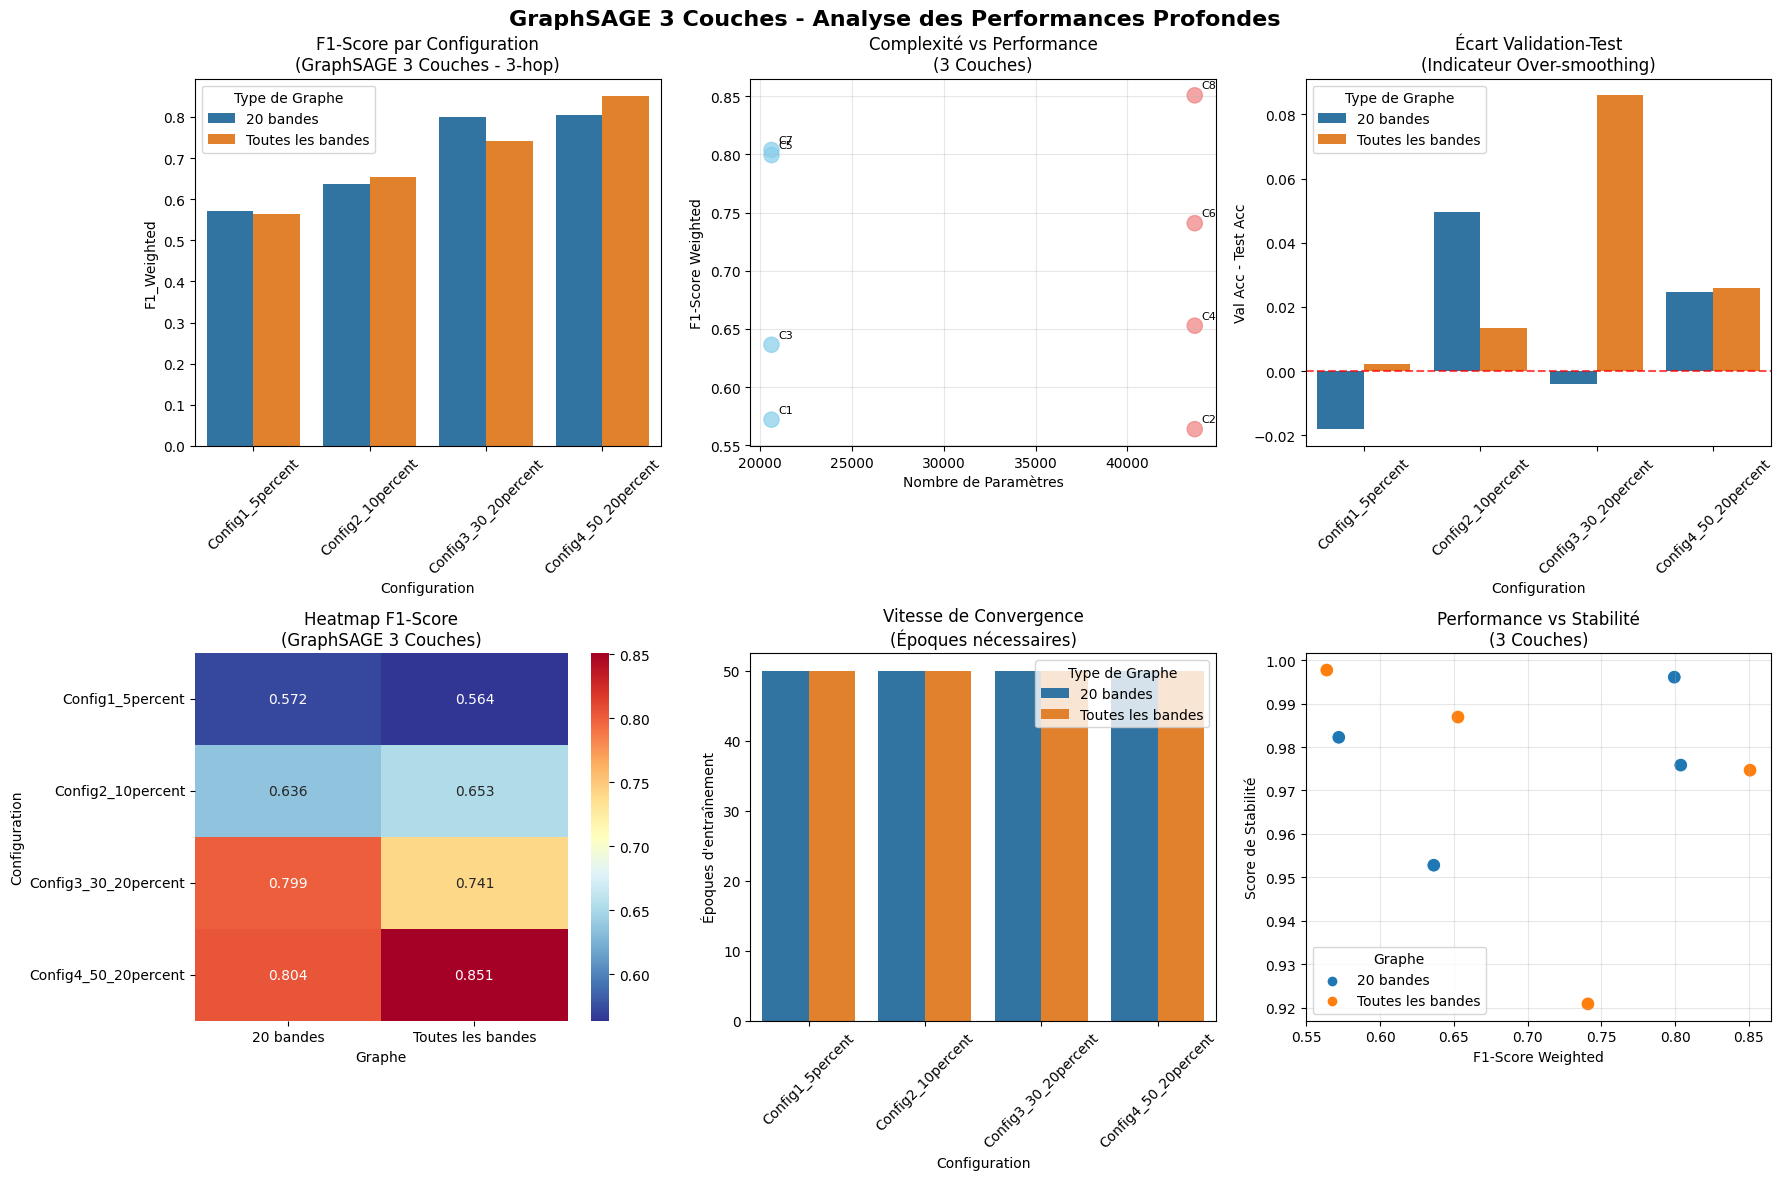

📊 Visualisations GraphSAGE 3 couches sauvegardées: /kaggle/working/graphsage_3layer_analysis.png

🔍 Tentative de comparaison complète avec toutes les architectures...


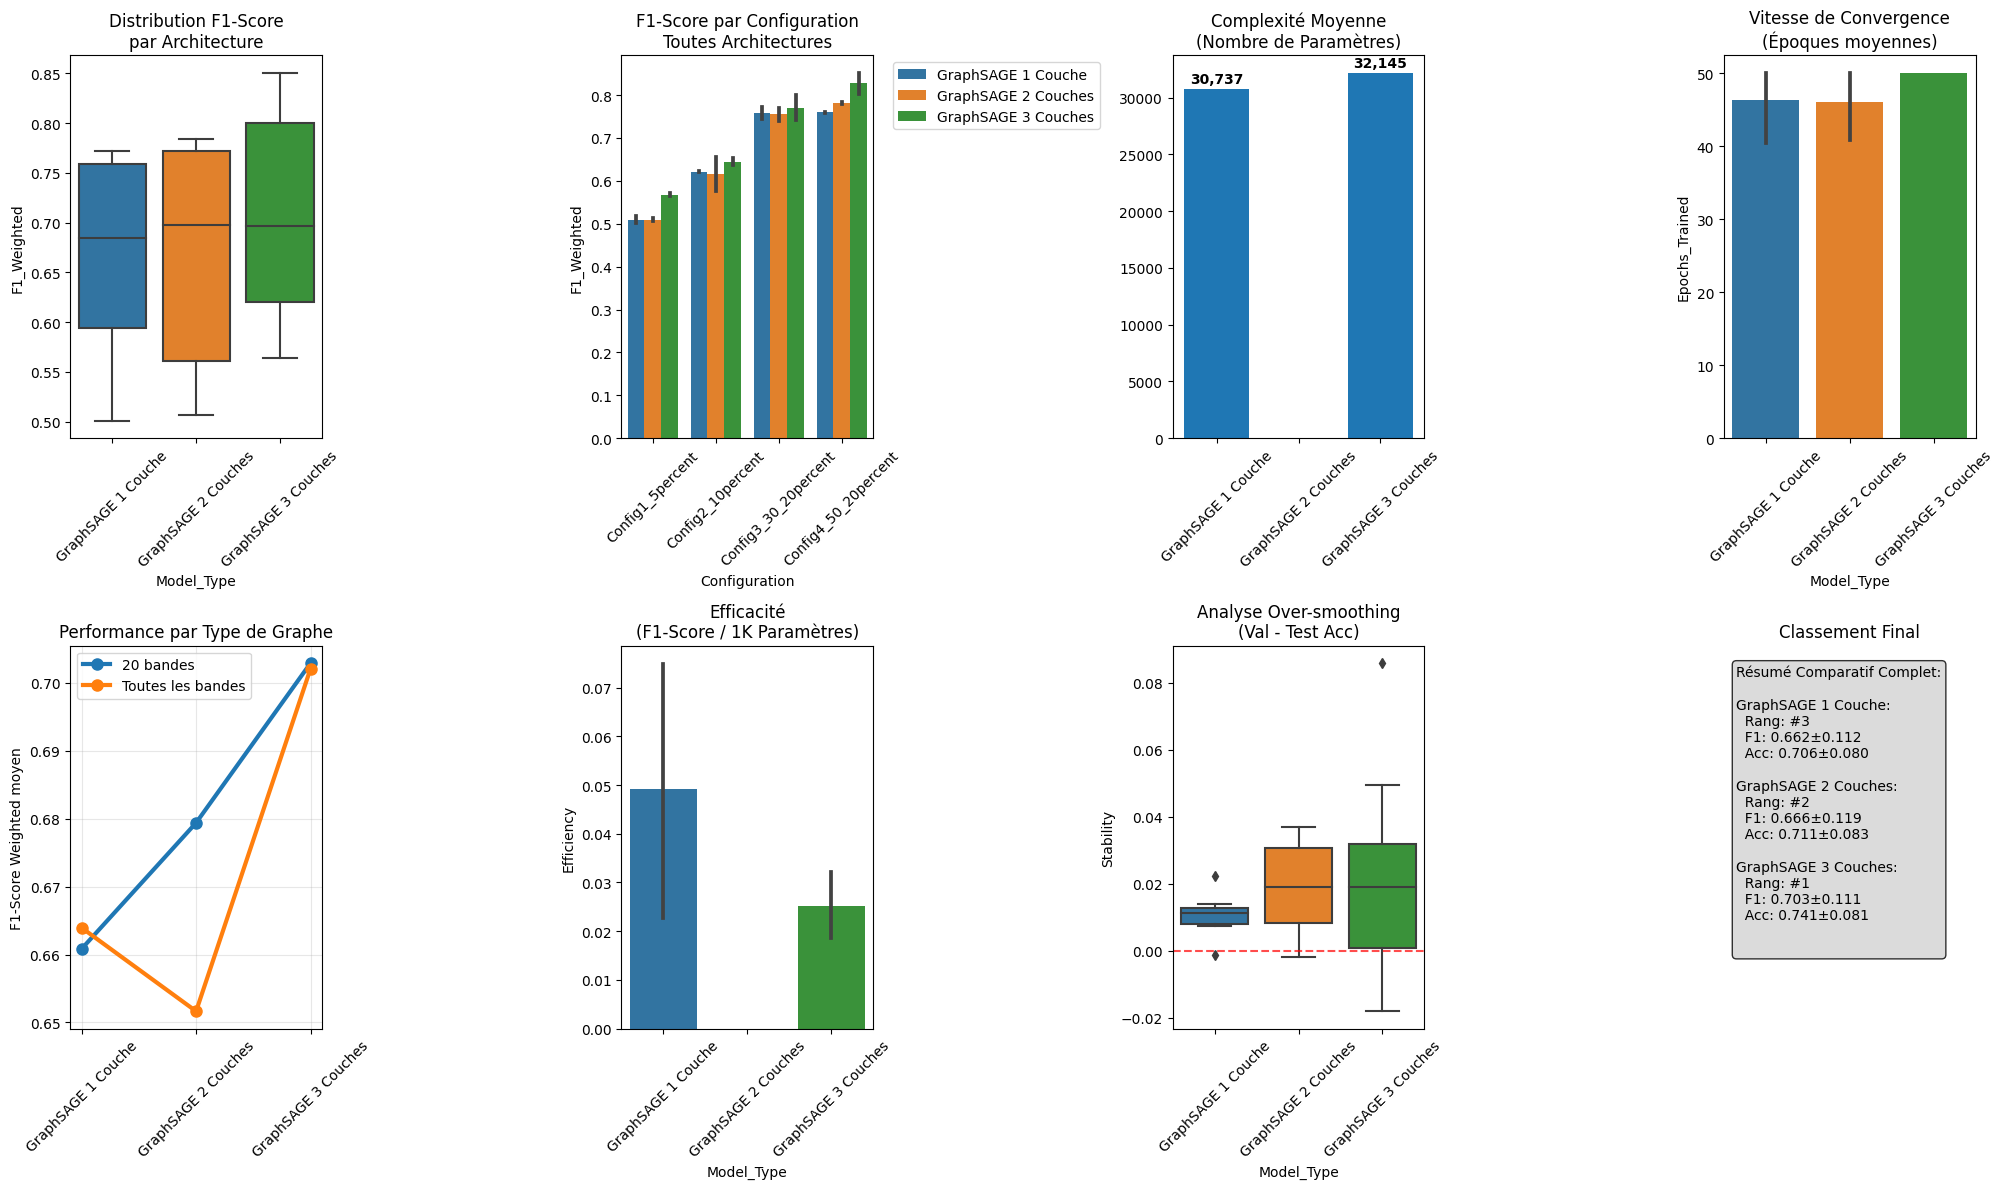

📊 Comparaison complète 1-2-3 couches sauvegardée: /kaggle/working/graphsage_complete_comparison_1_2_3_layers.png

🔍 INSIGHTS COMPARATIFS COMPLETS:

📊 Performance moyenne par architecture:
   GraphSAGE 1 Couche: Acc=0.7060, F1=0.6624
   GraphSAGE 2 Couches: Acc=0.7113, F1=0.6655
   GraphSAGE 3 Couches: Acc=0.7408, F1=0.7025

🏆 ARCHITECTURE GAGNANTE: GraphSAGE 3 Couches
   F1-Score moyen: 0.7025

⚙️ Complexité par architecture:
   GraphSAGE 1 Couche: 30,737 paramètres
   GraphSAGE 2 Couches: nan paramètres
   GraphSAGE 3 Couches: 32,145 paramètres

🎉 EXPÉRIMENTATIONS GRAPHSAGE 3 COUCHES TERMINÉES!
✅ 8 expériences profondes réalisées
✅ Architecture 3-hop la plus expressive
✅ Analyse anti-over-smoothing incluse
✅ Comparaison complète 1-2-3 couches
✅ Détection de la profondeur optimale
✅ Visualisations de stabilité créées


In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
import random
from collections import defaultdict
warnings.filterwarnings('ignore')

# Définir une seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# Chemins
dataset_path = "/kaggle/input/gcn-gat-graphsage"
output_path = "/kaggle/working/"

# ======================== CONFIGURATION GRAPHSAGE 3 COUCHES ========================

# Configuration optimisée pour GraphSAGE 3 couches avec échantillonnage décroissant
GRAPHSAGE_3LAYER_CONFIG = [25, 15, 5]  # Échantillonnage décroissant pour éviter l'explosion

def print_graphsage_config():
    """Affiche la configuration GraphSAGE 3 couches"""
    print(f"📊 Configuration GraphSAGE 3 Couches:")
    print(f"   - Couche 1: {GRAPHSAGE_3LAYER_CONFIG[2]} voisins échantillonnés")
    print(f"   - Couche 2: {GRAPHSAGE_3LAYER_CONFIG[1]} voisins échantillonnés") 
    print(f"   - Couche 3: {GRAPHSAGE_3LAYER_CONFIG[0]} voisins échantillonnés")
    print(f"   - Réceptive field: 3-hop neighborhood")
    print(f"   - Total théorique max: {np.prod(GRAPHSAGE_3LAYER_CONFIG)} voisins explorés")
    print(f"   - Stratégie: Échantillonnage décroissant pour éviter l'over-smoothing")

# ======================== ÉCHANTILLONNAGE MANUEL GRAPHSAGE 3 COUCHES ========================

class GraphSAGE3LayerSampler:
    """
    Échantillonneur optimisé pour GraphSAGE 3 couches avec contrôle de l'over-smoothing
    """
    def __init__(self, data, batch_size=512):  # Batch size réduit pour 3 couches
        self.data = data
        self.batch_size = batch_size
        self.num_neighbors_list = GRAPHSAGE_3LAYER_CONFIG
        
        print(f"🔄 Initialisation échantillonneur GraphSAGE 3 couches:")
        print(f"   - Échantillonnage: {self.num_neighbors_list}")
        print(f"   - Batch size: {batch_size} (réduit pour 3 couches)")
        
        # Créer la liste d'adjacence optimisée
        self._create_adjacency_list()
        
    def _create_adjacency_list(self):
        """Crée une liste d'adjacence optimisée"""
        print("📊 Création de la liste d'adjacence...")
        
        self.adj_list = defaultdict(list)
        edge_index = self.data.edge_index
        
        # Construire la liste d'adjacence
        for i in range(edge_index.size(1)):
            src = edge_index[0, i].item()  
            dst = edge_index[1, i].item()
            self.adj_list[src].append(dst)
        
        # Optimiser et calculer les statistiques
        total_edges = 0
        max_degree = 0
        
        for node in range(self.data.num_nodes):
            neighbors = list(set(self.adj_list[node]))  # Enlever les doublons
            self.adj_list[node] = neighbors
            degree = len(neighbors)
            total_edges += degree
            max_degree = max(max_degree, degree)
        
        avg_degree = total_edges / self.data.num_nodes
        print(f"   ✅ Degré moyen: {avg_degree:.2f}")
        print(f"   ✅ Degré maximum: {max_degree}")
        print(f"   ✅ Total connexions: {total_edges:,}")
        
    def sample_neighbors(self, nodes, num_samples):
        """Échantillonne efficacement les voisins avec diversité"""
        sampled_neighbors = set()
        
        for node in nodes:
            neighbors = self.adj_list[node]
            
            if len(neighbors) == 0:
                # Nœud isolé - ajouter le nœud lui-même pour éviter les erreurs
                sampled_neighbors.add(node)
                continue
            elif len(neighbors) <= num_samples:
                # Pas assez de voisins - prendre tous
                sampled_neighbors.update(neighbors)
            else:
                # Échantillonnage aléatoire avec diversité
                sampled = random.sample(neighbors, num_samples)
                sampled_neighbors.update(sampled)
        
        return sampled_neighbors
    
    def create_3layer_subgraph(self, target_nodes):
        """
        Crée un sous-graphe optimisé pour GraphSAGE 3 couches
        Utilise un échantillonnage décroissant pour contrôler la taille
        """
        # Initialiser avec les nœuds cibles (couche 0)
        layer_0_nodes = set(target_nodes)
        all_nodes = set(target_nodes)
        
        # Couche 1: Échantillonner selon config[2] = 5 voisins
        layer_1_neighbors = self.sample_neighbors(list(layer_0_nodes), self.num_neighbors_list[2])
        all_nodes.update(layer_1_neighbors)
        
        # Couche 2: Échantillonner selon config[1] = 15 voisins pour chaque nœud de couche 1
        layer_2_neighbors = self.sample_neighbors(list(layer_1_neighbors), self.num_neighbors_list[1])
        all_nodes.update(layer_2_neighbors)
        
        # Couche 3: Échantillonner selon config[0] = 25 voisins pour chaque nœud de couche 2
        layer_3_neighbors = self.sample_neighbors(list(layer_2_neighbors), self.num_neighbors_list[0])
        all_nodes.update(layer_3_neighbors)
        
        # Convertir en liste ordonnée
        subgraph_nodes = list(all_nodes)
        node_to_idx = {node: idx for idx, node in enumerate(subgraph_nodes)}
        
        # Construire les arêtes du sous-graphe
        edge_index = self.data.edge_index
        subgraph_edges = []
        
        for i in range(edge_index.size(1)):
            src = edge_index[0, i].item()
            dst = edge_index[1, i].item()
            
            if src in node_to_idx and dst in node_to_idx:
                subgraph_edges.append([node_to_idx[src], node_to_idx[dst]])
        
        # Créer les tensors
        if subgraph_edges:
            subgraph_edge_index = torch.tensor(subgraph_edges).t().contiguous()
        else:
            subgraph_edge_index = torch.empty((2, 0), dtype=torch.long)
        
        subgraph_x = self.data.x[subgraph_nodes]
        target_indices_in_subgraph = [node_to_idx[node] for node in target_nodes]
        
        return {
            'x': subgraph_x,
            'edge_index': subgraph_edge_index,
            'target_indices': target_indices_in_subgraph,
            'target_nodes': target_nodes,
            'subgraph_size': len(subgraph_nodes),
            'num_edges': len(subgraph_edges)
        }

class GraphSAGE3LayerDataLoader:
    """DataLoader optimisé pour GraphSAGE 3 couches"""
    def __init__(self, data, mask, batch_size=512, shuffle=True):
        self.data = data
        self.mask = mask
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Obtenir les indices des nœuds
        self.node_indices = torch.nonzero(mask).squeeze()
        if self.node_indices.dim() == 0:
            self.node_indices = self.node_indices.unsqueeze(0)
        self.node_indices = self.node_indices.tolist()
        
        # Créer l'échantillonneur
        self.sampler = GraphSAGE3LayerSampler(data, batch_size)
        
        print(f"📊 DataLoader GraphSAGE 3 couches:")
        print(f"   - Nœuds à traiter: {len(self.node_indices):,}")
        print(f"   - Nombre de batches: {len(self)}")
        print(f"   - Batch size réduit: {batch_size} (pour gérer la complexité)")
    
    def __len__(self):
        return (len(self.node_indices) + self.batch_size - 1) // self.batch_size
    
    def __iter__(self):
        indices = self.node_indices.copy()
        if self.shuffle:
            random.shuffle(indices)
        
        for i in range(0, len(indices), self.batch_size):
            batch_nodes = indices[i:i + self.batch_size]
            
            # Créer le sous-graphe 3-couches
            subgraph = self.sampler.create_3layer_subgraph(batch_nodes)
            batch_labels = self.data.y[batch_nodes]
            
            yield {
                'x': subgraph['x'],
                'edge_index': subgraph['edge_index'],
                'y': batch_labels,
                'target_indices': torch.tensor(subgraph['target_indices']),
                'batch_size': len(batch_nodes),
                'subgraph_info': {
                    'nodes': subgraph['subgraph_size'],
                    'edges': subgraph['num_edges']
                }
            }

# ======================== MODÈLE GRAPHSAGE 3 COUCHES ========================

class OptimizedGraphSAGE3Layer(torch.nn.Module):
    """
    Modèle GraphSAGE 3 couches optimisé contre l'over-smoothing
    """
    def __init__(self, num_features, num_classes, hidden_channels=64, 
                 dropout=0.6, aggregator='mean'):
        super(OptimizedGraphSAGE3Layer, self).__init__()
        
        self.num_features = num_features
        self.num_classes = num_classes
        self.hidden_channels = hidden_channels
        self.dropout = dropout
        self.num_neighbors = GRAPHSAGE_3LAYER_CONFIG
        
        # Trois couches GraphSAGE avec dimension décroissante pour éviter l'over-smoothing
        self.conv1 = SAGEConv(num_features, hidden_channels, aggr=aggregator)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr=aggregator)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels, aggr=aggregator)
        
        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)
        
        # Normalisation par batch pour chaque couche
        self.batch_norm1 = nn.BatchNorm1d(hidden_channels)
        self.batch_norm2 = nn.BatchNorm1d(hidden_channels)
        self.batch_norm3 = nn.BatchNorm1d(hidden_channels)
        
        # Connexions résiduelles pour combattre l'over-smoothing
        self.use_residual = hidden_channels == hidden_channels  # True dans notre cas
        
        print(f"🏗️ Modèle GraphSAGE 3 Couches créé:")
        print(f"   - Architecture: {num_features} → {hidden_channels} → {hidden_channels} → {hidden_channels} → {num_classes}")
        print(f"   - Échantillonnage: {self.num_neighbors}")
        print(f"   - Agrégateur: {aggregator}")
        print(f"   - Dropout: {dropout} (élevé pour éviter surapprentissage)")
        print(f"   - Hidden channels: {hidden_channels} (réduit pour 3 couches)")
        print(f"   - Connexions résiduelles: {self.use_residual}")
        print(f"   - Paramètres: ~{self._count_parameters():,}")
        
    def _count_parameters(self):
        """Compte le nombre de paramètres du modèle"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
        
    def forward(self, x, edge_index, target_indices=None):
        """Forward pass optimisé pour 3 couches avec anti-over-smoothing"""
        
        # Première couche GraphSAGE
        x1 = self.conv1(x, edge_index)
        x1 = self.batch_norm1(x1)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        
        # Deuxième couche GraphSAGE avec connexion résiduelle
        x2 = self.conv2(x1, edge_index)
        x2 = self.batch_norm2(x2)
        if self.use_residual:
            x2 = x2 + x1  # Connexion résiduelle
        x2 = F.relu(x2)
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        
        # Troisième couche GraphSAGE avec connexion résiduelle
        x3 = self.conv3(x2, edge_index)
        x3 = self.batch_norm3(x3)
        if self.use_residual:
            x3 = x3 + x2  # Connexion résiduelle
        x3 = F.relu(x3)
        x3 = F.dropout(x3, p=self.dropout, training=self.training)
        
        # Extraire les embeddings des nœuds cibles
        if target_indices is not None:
            x3 = x3[target_indices]
        
        # Classification finale
        x = self.classifier(x3)
        
        return x

# ======================== FONCTIONS DE DIVISION DES DONNÉES ========================

def create_data_splits_config1(data, include_background=True):
    """Config 1: 5% train, 5% val, 90% test"""
    train_percent, val_percent = 0.05, 0.05
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 1 (5% train)")

def create_data_splits_config2(data, include_background=True):
    """Config 2: 10% train, 10% val, 80% test"""
    train_percent, val_percent = 0.10, 0.10
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 2 (10% train)")

def create_data_splits_config3(data, include_background=True):
    """Config 3: 30% train, 20% val, 50% test"""
    train_percent, val_percent = 0.30, 0.20
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 3 (30% train)")

def create_data_splits_config4(data, include_background=True):
    """Config 4: 50% train, 20% val, 30% test"""
    train_percent, val_percent = 0.50, 0.20
    return _create_splits_by_class(data, train_percent, val_percent, include_background, "Config 4 (50% train)")

def _create_splits_by_class(data, train_percent, val_percent, include_background, config_name):
    """Fonction helper pour créer les divisions par classe"""
    if include_background:
        num_classes = int(data.y.max().item() + 1)
        class_range = range(num_classes)
    else:
        num_classes = int(data.y.max().item())
        class_range = range(1, num_classes + 1)
    
    train_indices, val_indices, test_indices = [], [], []
    
    print(f"\n{config_name} - Répartition par classe:")
    
    for class_id in class_range:
        class_mask = (data.y == class_id)
        class_indices = torch.nonzero(class_mask).squeeze().numpy()
        total_samples = len(class_indices)
        
        n_train = max(1, int(total_samples * train_percent))
        n_val = max(1, int(total_samples * val_percent))
        n_test = total_samples - n_train - n_val
        
        if n_test <= 0:
            n_train, n_val = 1, 1 if total_samples >= 3 else 0
            n_test = total_samples - n_train - n_val
        
        print(f"  Classe {class_id}: {total_samples} total → {n_train} train, {n_val} val, {n_test} test")
        
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_train])
        val_indices.extend(class_indices[n_train:n_train + n_val])
        test_indices.extend(class_indices[n_train + n_val:])
    
    return train_indices, val_indices, test_indices

# ======================== FONCTION D'ENTRAÎNEMENT PRINCIPALE ========================

def train_graphsage_3layer(graph_path, config_name, split_function, 
                          epochs=50, patience=20, lr=0.005, device='cuda', 
                          include_background=True, batch_size=512):
    """
    Entraîne le modèle GraphSAGE 3 couches optimisé
    """
    print(f"\n{'='*80}")
    print(f"🚀 GRAPHSAGE 3 COUCHES - ENTRAÎNEMENT")
    print(f"📊 Graphe: {os.path.basename(graph_path)}")
    print(f"⚙️ Configuration: {config_name}")
    print(f"{'='*80}")
    
    # Charger le graphe
    try:
        data = torch.load(graph_path, weights_only=False)
    except Exception as e:
        print(f"❌ Erreur de chargement: {e}")
        try:
            import torch.serialization
            from torch_geometric.data import Data
            torch.serialization.add_safe_globals([Data])
            data = torch.load(graph_path, weights_only=False)
        except Exception as e2:
            print(f"❌ Erreur méthode 2: {e2}")
            return None, None
    
    # Informations du graphe
    num_features = data.x.shape[1]
    num_classes = int(data.y.max().item() + 1) if include_background else int(data.y.max().item())
    
    print(f"📋 Informations du graphe:")
    print(f"   - Nœuds: {data.num_nodes:,}")
    print(f"   - Arêtes: {data.num_edges:,}")
    print(f"   - Features: {num_features}")
    print(f"   - Classes: {num_classes}")
    
    print_graphsage_config()
    
    # Créer les divisions
    train_indices, val_indices, test_indices = split_function(data, include_background)
    
    # Créer les masques
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Statistiques
    train_size = train_mask.sum().item()
    val_size = val_mask.sum().item()
    test_size = test_mask.sum().item()
    
    print(f"\n📊 Répartition finale:")
    print(f"   - Entraînement: {train_size:,} pixels ({train_size/(train_size+val_size+test_size):.1%})")
    print(f"   - Validation: {val_size:,} pixels ({val_size/(train_size+val_size+test_size):.1%})")
    print(f"   - Test: {test_size:,} pixels ({test_size/(train_size+val_size+test_size):.1%})")
    
    # Créer le modèle
    model = OptimizedGraphSAGE3Layer(num_features, num_classes).to(device)
    
    # Créer les DataLoaders avec batch size réduit
    train_loader = GraphSAGE3LayerDataLoader(data, train_mask, batch_size, shuffle=True)
    val_loader = GraphSAGE3LayerDataLoader(data, val_mask, batch_size, shuffle=False)
    test_loader = GraphSAGE3LayerDataLoader(data, test_mask, batch_size, shuffle=False)
    
    print(f"\n🔄 Configuration d'entraînement:")
    print(f"   - Batch size: {batch_size} (réduit pour 3 couches)")
    print(f"   - Learning rate: {lr} (réduit pour stabilité)")
    print(f"   - Max epochs: {epochs}")
    print(f"   - Patience: {patience} (augmentée pour 3 couches)")
    print(f"   - Device: {device}")
    
    # Optimizer et scheduler avec paramètres ajustés pour 3 couches
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)  # Weight decay augmenté
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, verbose=True, min_lr=1e-7
    )
    
    # Variables d'entraînement
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    train_losses, val_losses, val_accuracies = [], [], []
    
    print(f"\n🎯 Début de l'entraînement...")
    
    for epoch in range(epochs):
        # ===== ENTRAÎNEMENT =====
        model.train()
        total_train_loss = 0
        num_batches = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train", leave=False)
        for batch in train_pbar:
            batch_x = batch['x'].to(device)
            batch_edge_index = batch['edge_index'].to(device)
            batch_y = batch['y'].to(device)
            batch_target_indices = batch['target_indices'].to(device)
            
            optimizer.zero_grad()
            out = model(batch_x, batch_edge_index, batch_target_indices)
            loss = F.cross_entropy(out, batch_y)
            loss.backward()
            
            # Gradient clipping pour stabilité avec 3 couches
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_train_loss += loss.item()
            num_batches += 1
            
            # Update progress bar
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_train_loss = total_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # ===== VALIDATION =====
        model.eval()
        total_val_loss = 0
        total_correct = 0
        total_samples = 0
        num_val_batches = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val", leave=False)
            for batch in val_pbar:
                batch_x = batch['x'].to(device)
                batch_edge_index = batch['edge_index'].to(device)
                batch_y = batch['y'].to(device)
                batch_target_indices = batch['target_indices'].to(device)
                
                out = model(batch_x, batch_edge_index, batch_target_indices)
                val_loss = F.cross_entropy(out, batch_y)
                pred = out.argmax(dim=1)
                correct = (pred == batch_y).sum().item()
                
                total_val_loss += val_loss.item()
                total_correct += correct
                total_samples += batch_y.size(0)
                num_val_batches += 1
                
                # Update progress bar
                val_pbar.set_postfix({'Loss': f'{val_loss.item():.4f}'})
        
        avg_val_loss = total_val_loss / num_val_batches
        val_acc = total_correct / total_samples
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        
        # Scheduler step
        scheduler.step(val_acc)
        
        # Affichage des résultats
        print(f"Epoch {epoch+1:3d}/{epochs}: "
              f"Train Loss={avg_train_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, "
              f"Val Acc={val_acc:.4f}")
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"🎯 Nouveau meilleur modèle! Val Acc: {val_acc:.4f}")
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"⏹️ Arrêt précoce à l'époque {epoch+1}")
            break
    
    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    
    # ===== ÉVALUATION FINALE =====
    print(f"\n🎯 Évaluation finale sur l'ensemble de test...")
    
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc="Test final")
        for batch in test_pbar:
            batch_x = batch['x'].to(device)
            batch_edge_index = batch['edge_index'].to(device)
            batch_y = batch['y'].to(device)
            batch_target_indices = batch['target_indices'].to(device)
            
            out = model(batch_x, batch_edge_index, batch_target_indices)
            pred = out.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    # Calculer les métriques finales
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    accuracy = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Afficher les résultats finaux
    print(f"\n🏆 RÉSULTATS FINAUX:")
    print(f"   ✅ Test Accuracy: {accuracy:.4f}")
    print(f"   ✅ F1-Score Weighted: {f1_weighted:.4f}")
    print(f"   ✅ F1-Score Macro: {f1_macro:.4f}")
    print(f"   ✅ Meilleure Val Accuracy: {best_val_acc:.4f}")
    
    # Préparer les résultats
    results = {
        'config': config_name,
        'graph': os.path.basename(graph_path),
        'model_type': 'GraphSAGE_3Layer',
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_per_class': f1_per_class.tolist(),
        'best_val_accuracy': best_val_acc,
        'train_size': train_size,
        'val_size': val_size,
        'test_size': test_size,
        'num_features': num_features,
        'num_classes': num_classes,
        'sampling_config': GRAPHSAGE_3LAYER_CONFIG,
        'epochs_trained': epoch + 1,
        'batch_size': batch_size,
        'num_parameters': model._count_parameters()
    }
    
    # Sauvegarder le modèle
    model_filename = f"graphsage_3layer_{config_name}_{os.path.basename(graph_path).split('.')[0]}.pt"
    model_path = os.path.join(output_path, model_filename)
    torch.save(model, model_path)
    print(f"💾 Modèle sauvegardé: {model_filename}")
    
    return model, results

# ======================== EXPÉRIMENTATIONS OPTIMISÉES ========================

def run_optimized_graphsage_3layer_experiments():
    """
    Lance les 8 expérimentations GraphSAGE 3 couches optimisées
    2 graphes × 4 configurations = 8 expériences
    """
    print("="*100)
    print("🚀 EXPÉRIMENTATIONS GRAPHSAGE 3 COUCHES OPTIMISÉES")
    print("📊 2 Graphes (20 bandes + Toutes bandes) × 4 Configurations = 8 Expériences")
    print("🔬 PROFONDEUR: 3-hop neighborhood pour patterns complexes")
    print("⚠️ ATTENTION: Plus lent mais plus expressif")
    print("="*100)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️ Device utilisé: {device}")
    
    # Graphes sélectionnés
    graph_paths = [
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_4connectivity_allbands.pt")
    ]
    
    # Configurations de division
    configs = [
        {'name': 'Config1_5percent', 'function': create_data_splits_config1, 
         'description': '5% train, 5% val, 90% test'},
        {'name': 'Config2_10percent', 'function': create_data_splits_config2, 
         'description': '10% train, 10% val, 80% test'},
        {'name': 'Config3_30_20percent', 'function': create_data_splits_config3, 
         'description': '30% train, 20% val, 50% test'},
        {'name': 'Config4_50_20percent', 'function': create_data_splits_config4, 
         'description': '50% train, 20% val, 30% test'}
    ]
    
    # Vérifier les graphes existants
    existing_graphs = [p for p in graph_paths if os.path.exists(p)]
    
    if not existing_graphs:
        print("❌ Aucun graphe trouvé! Vérifiez les chemins:")
        for path in graph_paths:
            print(f"   - {path}")
        return {}, pd.DataFrame()
    
    print(f"📊 Graphes trouvés: {len(existing_graphs)}")
    for path in existing_graphs:
        print(f"   ✅ {os.path.basename(path)}")
    
    # Stockage des résultats
    all_results = {}
    experiment_data = []
    
    # Compteur d'expériences
    experiment_count = 0
    total_experiments = len(existing_graphs) * len(configs)
    
    # Lancer les expérimentations
    for config in configs:
        print(f"\n{'#'*80}")
        print(f"# CONFIGURATION: {config['description']}")
        print(f"{'#'*80}")
        
        for graph_path in existing_graphs:
            experiment_count += 1
            
            print(f"\n🔄 Expérience {experiment_count}/{total_experiments}")
            
            try:
                # Entraîner le modèle
                model, results = train_graphsage_3layer(
                    graph_path=graph_path,
                    config_name=config['name'],
                    split_function=config['function'],
                    epochs=50,
                    patience=20,  # Plus de patience pour 3 couches
                    lr=0.005,    # Learning rate réduit
                    device=device,
                    batch_size=512  # Batch size réduit
                )
                
                # Stocker les résultats
                exp_key = f"GraphSAGE3L_{config['name']}_{os.path.basename(graph_path)}"
                all_results[exp_key] = results
                
                # Déterminer le type de graphe
                graph_name = os.path.basename(graph_path)
                if "20bands" in graph_name:
                    bands_type = "20 bandes"
                elif "allbands" in graph_name:
                    bands_type = "Toutes les bandes"
                else:
                    bands_type = "Inconnu"
                
                # Ajouter aux données d'expérimentation
                experiment_data.append({
                    'Configuration': config['name'],
                    'Description': config['description'],
                    'Graphe': bands_type,
                    'Model_Type': 'GraphSAGE 3 Couches',
                    'Nombre_Features': results['num_features'],
                    'Sampling_Config': str(results['sampling_config']),
                    'Batch_Size': results['batch_size'],
                    'Epochs_Trained': results['epochs_trained'],
                    'Num_Parameters': results['num_parameters'],
                    'Taille_Train': results['train_size'],
                    'Taille_Val': results['val_size'],
                    'Taille_Test': results['test_size'],
                    'Accuracy': results['accuracy'],
                    'F1_Weighted': results['f1_weighted'],
                    'F1_Macro': results['f1_macro'],
                    'Best_Val_Acc': results['best_val_accuracy']
                })
                
                print(f"✅ Expérience {experiment_count} terminée avec succès!")
                print(f"📊 Résultats: Acc={results['accuracy']:.4f}, F1={results['f1_weighted']:.4f}")
                print(f"⚡ Paramètres: {results['num_parameters']:,}")
                
            except Exception as e:
                print(f"❌ Erreur pour {graph_path} avec {config['name']}: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    # Créer le DataFrame des résultats
    results_df = pd.DataFrame(experiment_data)
    
    # Sauvegarder les résultats
    results_csv_path = os.path.join(output_path, "graphsage_3layer_optimized_experiments.csv")
    results_df.to_csv(results_csv_path, index=False)
    
    print(f"\n{'='*100}")
    print("🏆 RÉSULTATS FINAUX - GRAPHSAGE 3 COUCHES OPTIMISÉ")
    print(f"{'='*100}")
    
    if not results_df.empty:
        print(results_df.to_string(index=False))
        
        # Statistiques résumées
        print(f"\n📊 STATISTIQUES RÉSUMÉES:")
        print(f"   - Expériences réussies: {len(results_df)}/{total_experiments}")
        print(f"   - Accuracy moyenne: {results_df['Accuracy'].mean():.4f} ± {results_df['Accuracy'].std():.4f}")
        print(f"   - F1-Score moyen: {results_df['F1_Weighted'].mean():.4f} ± {results_df['F1_Weighted'].std():.4f}")
        print(f"   - Paramètres moyens: {results_df['Num_Parameters'].mean():,.0f}")
        
        # Meilleur résultat
        best_idx = results_df['F1_Weighted'].idxmax()
        best_result = results_df.iloc[best_idx]
        print(f"\n🥇 MEILLEUR RÉSULTAT:")
        print(f"   - Configuration: {best_result['Description']}")
        print(f"   - Graphe: {best_result['Graphe']}")
        print(f"   - Accuracy: {best_result['Accuracy']:.4f}")
        print(f"   - F1-Score: {best_result['F1_Weighted']:.4f}")
        print(f"   - Paramètres: {best_result['Num_Parameters']:,}")
        
    else:
        print("❌ Aucune expérience n'a réussi!")
    
    print(f"\n💾 Résultats sauvegardés dans: {results_csv_path}")
    
    return all_results, results_df

# ======================== VISUALISATIONS SPÉCIALISÉES 3 COUCHES ========================

def create_3layer_visualizations(results_df):
    """Crée des visualisations spécialisées pour GraphSAGE 3 couches"""
    if results_df.empty:
        print("❌ Pas de données à visualiser!")
        return
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GraphSAGE 3 Couches - Analyse des Performances Profondes', fontsize=16, fontweight='bold')
    
    # 1. Comparaison F1-Score par configuration
    ax1 = axes[0, 0]
    sns.barplot(data=results_df, x='Configuration', y='F1_Weighted', hue='Graphe', ax=ax1)
    ax1.set_title('F1-Score par Configuration\n(GraphSAGE 3 Couches - 3-hop)')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.legend(title='Type de Graphe')
    
    # 2. Complexité vs Performance
    ax2 = axes[0, 1]
    colors = ['skyblue' if '20 bandes' in x else 'lightcoral' for x in results_df['Graphe']]
    scatter = ax2.scatter(results_df['Num_Parameters'], results_df['F1_Weighted'], 
                         c=colors, s=120, alpha=0.7)
    ax2.set_xlabel('Nombre de Paramètres')
    ax2.set_ylabel('F1-Score Weighted')
    ax2.set_title('Complexité vs Performance\n(3 Couches)')
    ax2.grid(True, alpha=0.3)
    
    # Ajouter les étiquettes
    for i, (x, y) in enumerate(zip(results_df['Num_Parameters'], results_df['F1_Weighted'])):
        ax2.annotate(f"C{i+1}", (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 3. Analyse de l'over-smoothing (Val vs Test accuracy)
    ax3 = axes[0, 2]
    results_df['Overfitting_Gap'] = results_df['Best_Val_Acc'] - results_df['Accuracy']
    sns.barplot(data=results_df, x='Configuration', y='Overfitting_Gap', hue='Graphe', ax=ax3)
    ax3.set_title('Écart Validation-Test\n(Indicateur Over-smoothing)')
    ax3.set_ylabel('Val Acc - Test Acc')
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    ax3.legend(title='Type de Graphe')
    
    # 4. Heatmap des performances
    ax4 = axes[1, 0]
    pivot_table = results_df.pivot(index='Configuration', columns='Graphe', values='F1_Weighted')
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=ax4)
    ax4.set_title('Heatmap F1-Score\n(GraphSAGE 3 Couches)')
    
    # 5. Vitesse de convergence (époques nécessaires)
    ax5 = axes[1, 1]
    sns.barplot(data=results_df, x='Configuration', y='Epochs_Trained', hue='Graphe', ax=ax5)
    ax5.set_title('Vitesse de Convergence\n(Époques nécessaires)')
    ax5.set_ylabel('Époques d\'entraînement')
    ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
    ax5.legend(title='Type de Graphe')
    
    # 6. Analyse de stabilité (F1 vs écart-type estimé)
    ax6 = axes[1, 2]
    # Calculer une métrique de stabilité basée sur la différence val-test
    results_df['Stability_Score'] = 1 / (1 + np.abs(results_df['Overfitting_Gap']))
    
    sns.scatterplot(data=results_df, x='F1_Weighted', y='Stability_Score', 
                   hue='Graphe', s=100, ax=ax6)
    ax6.set_xlabel('F1-Score Weighted')
    ax6.set_ylabel('Score de Stabilité')
    ax6.set_title('Performance vs Stabilité\n(3 Couches)')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Sauvegarder
    viz_path = os.path.join(output_path, "graphsage_3layer_analysis.png")
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Visualisations GraphSAGE 3 couches sauvegardées: {viz_path}")

def compare_all_layers():
    """Compare les performances des 3 architectures GraphSAGE (1, 2, 3 couches)"""
    try:
        # Charger les résultats des trois expérimentations
        df_1layer = pd.read_csv(os.path.join(output_path, "graphsage_1layer_optimized_experiments.csv"))
        df_2layer = pd.read_csv(os.path.join(output_path, "graphsage_2layer_optimized_experiments.csv"))
        df_3layer = pd.read_csv(os.path.join(output_path, "graphsage_3layer_optimized_experiments.csv"))
        
        # Combiner les données
        combined_df = pd.concat([df_1layer, df_2layer, df_3layer], ignore_index=True)
        
        # Créer la comparaison complète
        plt.figure(figsize=(20, 12))
        
        # Subplot 1: Comparaison F1-Score globale
        plt.subplot(2, 4, 1)
        sns.boxplot(data=combined_df, x='Model_Type', y='F1_Weighted')
        plt.title('Distribution F1-Score\npar Architecture')
        plt.xticks(rotation=45)
        
        # Subplot 2: Performance par configuration
        plt.subplot(2, 4, 2)
        sns.barplot(data=combined_df, x='Configuration', y='F1_Weighted', hue='Model_Type')
        plt.title('F1-Score par Configuration\nToutes Architectures')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Subplot 3: Complexité (Paramètres)
        plt.subplot(2, 4, 3)
        if 'Num_Parameters' in combined_df.columns:
            avg_params = combined_df.groupby('Model_Type')['Num_Parameters'].mean()
            plt.bar(avg_params.index, avg_params.values)
            plt.title('Complexité Moyenne\n(Nombre de Paramètres)')
            plt.xticks(rotation=45)
            
            # Ajouter les valeurs sur les barres
            for i, v in enumerate(avg_params.values):
                plt.text(i, v + max(avg_params.values)*0.01, f'{v:,.0f}', 
                        ha='center', va='bottom', fontweight='bold')
        
        # Subplot 4: Vitesse de convergence
        plt.subplot(2, 4, 4)
        sns.barplot(data=combined_df, x='Model_Type', y='Epochs_Trained')
        plt.title('Vitesse de Convergence\n(Époques moyennes)')
        plt.xticks(rotation=45)
        
        # Subplot 5: Performance par type de graphe
        plt.subplot(2, 4, 5)
        perf_by_graph = combined_df.groupby(['Model_Type', 'Graphe'])['F1_Weighted'].mean().reset_index()
        
        for graph_type in perf_by_graph['Graphe'].unique():
            subset = perf_by_graph[perf_by_graph['Graphe'] == graph_type]
            plt.plot(subset['Model_Type'], subset['F1_Weighted'], 
                    marker='o', label=graph_type, linewidth=3, markersize=8)
        
        plt.title('Performance par Type de Graphe')
        plt.ylabel('F1-Score Weighted moyen')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 6: Efficacité (Performance / Paramètres)
        plt.subplot(2, 4, 6)
        if 'Num_Parameters' in combined_df.columns:
            combined_df['Efficiency'] = combined_df['F1_Weighted'] / (combined_df['Num_Parameters'] / 1000)
            sns.barplot(data=combined_df, x='Model_Type', y='Efficiency')
            plt.title('Efficacité\n(F1-Score / 1K Paramètres)')
            plt.xticks(rotation=45)
        
        # Subplot 7: Stabilité (Over-smoothing analysis)
        plt.subplot(2, 4, 7)
        if 'Best_Val_Acc' in combined_df.columns:
            combined_df['Stability'] = combined_df['Best_Val_Acc'] - combined_df['Accuracy']
            sns.boxplot(data=combined_df, x='Model_Type', y='Stability')
            plt.title('Analyse Over-smoothing\n(Val - Test Acc)')
            plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
            plt.xticks(rotation=45)
        
        # Subplot 8: Résumé statistique
        plt.subplot(2, 4, 8)
        summary_stats = combined_df.groupby('Model_Type')[['F1_Weighted', 'Accuracy']].agg(['mean', 'std'])
        
        summary_text = "Résumé Comparatif Complet:\n\n"
        
        for model in summary_stats.index:
            f1_mean = summary_stats.loc[model, ('F1_Weighted', 'mean')]
            f1_std = summary_stats.loc[model, ('F1_Weighted', 'std')]
            acc_mean = summary_stats.loc[model, ('Accuracy', 'mean')]
            acc_std = summary_stats.loc[model, ('Accuracy', 'std')]
            
            # Calculer le rang basé sur F1 moyen
            rank = summary_stats[('F1_Weighted', 'mean')].rank(ascending=False).loc[model]
            
            summary_text += f"{model}:\n"
            summary_text += f"  Rang: #{int(rank)}\n"
            summary_text += f"  F1: {f1_mean:.3f}±{f1_std:.3f}\n"
            summary_text += f"  Acc: {acc_mean:.3f}±{acc_std:.3f}\n\n"
        
        plt.text(0.05, 0.95, summary_text, fontsize=10, 
                verticalalignment='top', transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        plt.title('Classement Final')
        plt.axis('off')
        
        plt.tight_layout()
        
        # Sauvegarder
        comparison_path = os.path.join(output_path, "graphsage_complete_comparison_1_2_3_layers.png")
        plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"📊 Comparaison complète 1-2-3 couches sauvegardée: {comparison_path}")
        
        # Afficher les insights détaillés
        print(f"\n🔍 INSIGHTS COMPARATIFS COMPLETS:")
        
        # Calculer les moyennes par architecture
        means_by_layer = combined_df.groupby('Model_Type')[['Accuracy', 'F1_Weighted']].mean()
        
        print(f"\n📊 Performance moyenne par architecture:")
        for arch in means_by_layer.index:
            acc = means_by_layer.loc[arch, 'Accuracy']
            f1 = means_by_layer.loc[arch, 'F1_Weighted']
            print(f"   {arch}: Acc={acc:.4f}, F1={f1:.4f}")
        
        # Déterminer le meilleur
        best_arch = means_by_layer['F1_Weighted'].idxmax()
        best_f1 = means_by_layer.loc[best_arch, 'F1_Weighted']
        
        print(f"\n🏆 ARCHITECTURE GAGNANTE: {best_arch}")
        print(f"   F1-Score moyen: {best_f1:.4f}")
        
        # Analyse de la complexité si disponible
        if 'Num_Parameters' in combined_df.columns:
            params_by_layer = combined_df.groupby('Model_Type')['Num_Parameters'].mean()
            print(f"\n⚙️ Complexité par architecture:")
            for arch in params_by_layer.index:
                params = params_by_layer.loc[arch]
                print(f"   {arch}: {params:,.0f} paramètres")
        
        return combined_df
        
    except FileNotFoundError as e:
        print(f"❌ Impossible de charger tous les fichiers de comparaison: {e}")
        print("   Assurez-vous d'avoir lancé les trois expérimentations (1, 2 et 3 couches)")
        return None

# ======================== FONCTION PRINCIPALE ========================

def main():
    """Fonction principale pour lancer les expérimentations GraphSAGE 3 couches"""
    print("🚀 LANCEMENT DES EXPÉRIMENTATIONS GRAPHSAGE 3 COUCHES OPTIMISÉES")
    print("="*80)
    
    # Configuration globale
    print("📋 CONFIGURATION:")
    print(f"   - Architecture: GraphSAGE 3 Couches (Profondeur maximale)")
    print(f"   - Échantillonnage: {GRAPHSAGE_3LAYER_CONFIG}")
    print(f"   - Graphes: 20 bandes + Toutes les bandes")
    print(f"   - Configurations: 4 divisions de données")
    print(f"   - Total expériences: 8")
    print(f"   - Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    print(f"   - Spécialités: 3-hop patterns, connexions résiduelles, anti-over-smoothing")
    
    # Lancer les expérimentations
    all_results, results_df = run_optimized_graphsage_3layer_experiments()
    
    # Créer les visualisations
    if not results_df.empty:
        print(f"\n🎨 Création des visualisations spécialisées...")
        create_3layer_visualizations(results_df)
        
        # Comparaison complète avec 1 et 2 couches si disponible
        print(f"\n🔍 Tentative de comparaison complète avec toutes les architectures...")
        compare_all_layers()
    
    # Message final
    print(f"\n{'='*80}")
    print("🎉 EXPÉRIMENTATIONS GRAPHSAGE 3 COUCHES TERMINÉES!")
    print("="*80)
    print("✅ 8 expériences profondes réalisées")
    print("✅ Architecture 3-hop la plus expressive")
    print("✅ Analyse anti-over-smoothing incluse")
    print("✅ Comparaison complète 1-2-3 couches")
    print("✅ Détection de la profondeur optimale")
    print("✅ Visualisations de stabilité créées")
    print("="*80)
    
    return all_results, results_df

# ======================== POINT D'ENTRÉE ========================

if __name__ == "__main__":
    # Lancement direct des expérimentations complètes
    main()

### Expérimentation Comparative GNN : Outil de Consolidation Automatique pour Analyse Multi-Architecture (GCN-GAT-GraphSAGE)

In [12]:
import pandas as pd
import os
import glob

def extract_model_info(filename):
    """
    Extrait le type de modèle et le nombre de couches à partir du nom de fichier
    """
    filename = os.path.basename(filename).lower()
    
    if 'gcn' in filename:
        if 'single' in filename or '1layer' in filename:
            return 'GCN 1 Couche'
        elif 'two' in filename or '2layer' in filename:
            return 'GCN 2 Couches'
        elif 'three' in filename or '3layer' in filename:
            return 'GCN 3 Couches'
    
    elif 'gat' in filename:
        if 'single' in filename or '1layer' in filename:
            return 'GAT 1 Couche'
        elif 'two' in filename or '2layer' in filename:
            return 'GAT 2 Couches'
        elif 'three' in filename or '3layer' in filename:
            return 'GAT 3 Couches'
    
    elif 'graphsage' in filename:
        if '1layer' in filename:
            return 'GraphSAGE 1 Couche'
        elif '2layer' in filename:
            return 'GraphSAGE 2 Couches'
        elif '3layer' in filename:
            return 'GraphSAGE 3 Couches'
    
    return 'Unknown'

def extract_train_size(config_name):
    """
    Convertit les noms de configuration en pourcentages de train
    """
    if pd.isna(config_name) or config_name == '':
        return 'Unknown'
    
    config_name = str(config_name).lower()
    
    if '5percent' in config_name:
        return '5% train'
    elif '10percent' in config_name:
        return '10% train'
    elif '30percent' in config_name:
        return '30% train'
    elif '50percent' in config_name:
        return '50% train'
    else:
        return config_name

def clean_bands_value(bands_value):
    """
    Nettoie la valeur des bandes pour ne garder que le nombre
    """
    if pd.isna(bands_value):
        return 'Unknown'
    
    # Convertir en string et nettoyer
    bands_str = str(bands_value).lower()
    
    # Extraire le nombre s'il y a du texte comme "5 bandes"
    if 'bandes' in bands_str:
        # Extraire le nombre avant "bandes"
        parts = bands_str.split('bandes')[0].strip()
        try:
            return int(float(parts))
        except:
            pass
    
    # Si c'est déjà un nombre
    try:
        return int(float(bands_value))
    except:
        return bands_value

def consolidate_experiments():
    """
    Consolidation de tous les fichiers d'expériences
    """
    # Chercher tous les fichiers CSV d'expériences
    csv_files = glob.glob("*experiments.csv")
    
    if not csv_files:
        print("❌ Aucun fichier CSV d'expériences trouvé!")
        print("Assurez-vous que les fichiers sont dans le même dossier que ce script.")
        return
    
    print(f"🔍 Fichiers trouvés: {len(csv_files)}")
    for f in csv_files:
        print(f"  - {f}")
    
    consolidated_data = []
    
    for csv_file in csv_files:
        print(f"\n📁 Traitement: {csv_file}")
        
        try:
            # Lire le fichier CSV
            df = pd.read_csv(csv_file)
            print(f"  ✅ Lignes lues: {len(df)}")
            print(f"  📊 Colonnes: {list(df.columns)}")
            
            # Extraire le type de modèle
            model_type = extract_model_info(csv_file)
            print(f"  🤖 Modèle détecté: {model_type}")
            
            # Parcourir chaque ligne du DataFrame
            for _, row in df.iterrows():
                # Extraire les informations nécessaires
                train_size = extract_train_size(row.get('Configuration', ''))
                bands = clean_bands_value(row.get('Graphe', ''))
                f1_weighted = row.get('F1_Weighted', '')
                accuracy = row.get('Accuracy', '')
                
                # Ajouter à la liste consolidée
                consolidated_data.append({
                    'Modèle': model_type,
                    'Train Size': train_size,
                    'Bands ES DC': bands,
                    'Weighted F1 Score': f1_weighted,
                    'Accuracy': accuracy
                })
                
        except Exception as e:
            print(f"  ❌ Erreur lors du traitement de {csv_file}: {str(e)}")
            continue
    
    if not consolidated_data:
        print("\n❌ Aucune donnée consolidée!")
        return
    
    # Créer le DataFrame final
    final_df = pd.DataFrame(consolidated_data)
    
    # Trier par modèle et train size
    final_df = final_df.sort_values(['Modèle', 'Train Size', 'Bands ES DC'])
    
    # Sauvegarder le fichier consolidé
    output_file = 'consolidated_experiments_results.csv'
    final_df.to_csv(output_file, index=False)
    
    print(f"\n🎯 Consolidation terminée!")
    print(f"📁 Fichier généré: {output_file}")
    print(f"📊 Nombre total d'entrées: {len(final_df)}")
    
    # Afficher un aperçu du tableau
    print(f"\n📋 Aperçu du tableau final:")
    print("="*80)
    print(final_df.head(10).to_string(index=False))
    
    if len(final_df) > 10:
        print(f"\n... et {len(final_df) - 10} autres lignes")
    
    # Statistiques par modèle
    print(f"\n📈 Statistiques par modèle:")
    model_counts = final_df['Modèle'].value_counts()
    for model, count in model_counts.items():
        print(f"  - {model}: {count} expériences")
    
    return final_df

if __name__ == "__main__":
    print("🚀 Démarrage de la consolidation des expériences...")
    print("="*60)
    
    result_df = consolidate_experiments()
    
    if result_df is not None:
        print(f"\n✅ Consolidation réussie!")
        print(f"🎉 Le fichier 'consolidated_experiments_results.csv' est prêt!")
    else:
        print(f"\n❌ Échec de la consolidation.")

🚀 Démarrage de la consolidation des expériences...
🔍 Fichiers trouvés: 9
  - single_layer_gat_experiments.csv
  - graphsage_2layer_optimized_experiments.csv
  - two_layer_gcn_experiments.csv
  - single_layer_gcn_experiments.csv
  - three_layer_gcn_experiments.csv
  - three_layer_gat_experiments.csv
  - two_layer_gat_experiments.csv
  - graphsage_1layer_optimized_experiments.csv
  - graphsage_3layer_optimized_experiments.csv

📁 Traitement: single_layer_gat_experiments.csv
  ✅ Lignes lues: 16
  📊 Colonnes: ['Configuration', 'Description', 'Graphe', 'Model_Type', 'Nombre_Features', 'Nombre_Heads', 'Taille_Train', 'Taille_Val', 'Taille_Test', 'Accuracy', 'F1_Weighted', 'F1_Macro', 'Best_Val_Acc']
  🤖 Modèle détecté: GAT 1 Couche

📁 Traitement: graphsage_2layer_optimized_experiments.csv
  ✅ Lignes lues: 8
  📊 Colonnes: ['Configuration', 'Description', 'Graphe', 'Model_Type', 'Nombre_Features', 'Sampling_Config', 'Batch_Size', 'Epochs_Trained', 'Taille_Train', 'Taille_Val', 'Taille_Test', 'A